In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

scene_id=325 scene_name=scene-0411 map_name=singapore-hollandvillage


/home/kfir/workspace/RadarLocalization/dataset.py:376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.53803387e+15 2.30000000e+01]
 [1.53803387e+15 2.30000000e+01]
 [1.53803387e+15 2.30000000e+01]
 ...
 [1.53898521e+15 1.70000000e+01]
 [1.53898521e+15 1.70000000e+01]
 [1.53898521e+15 1.70000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


self.dir_name images/325/database


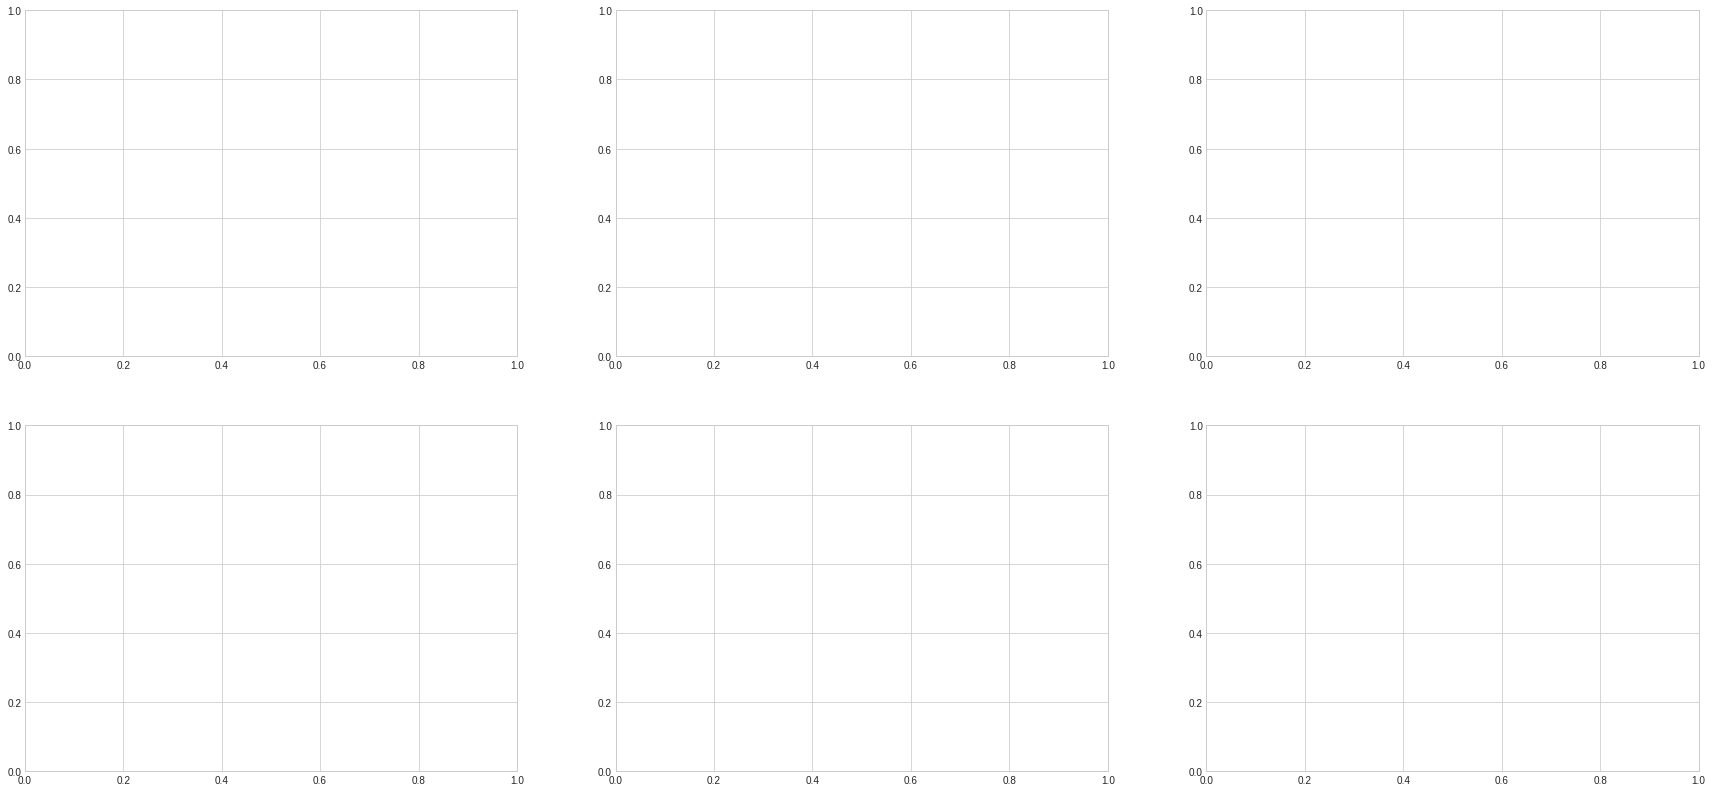

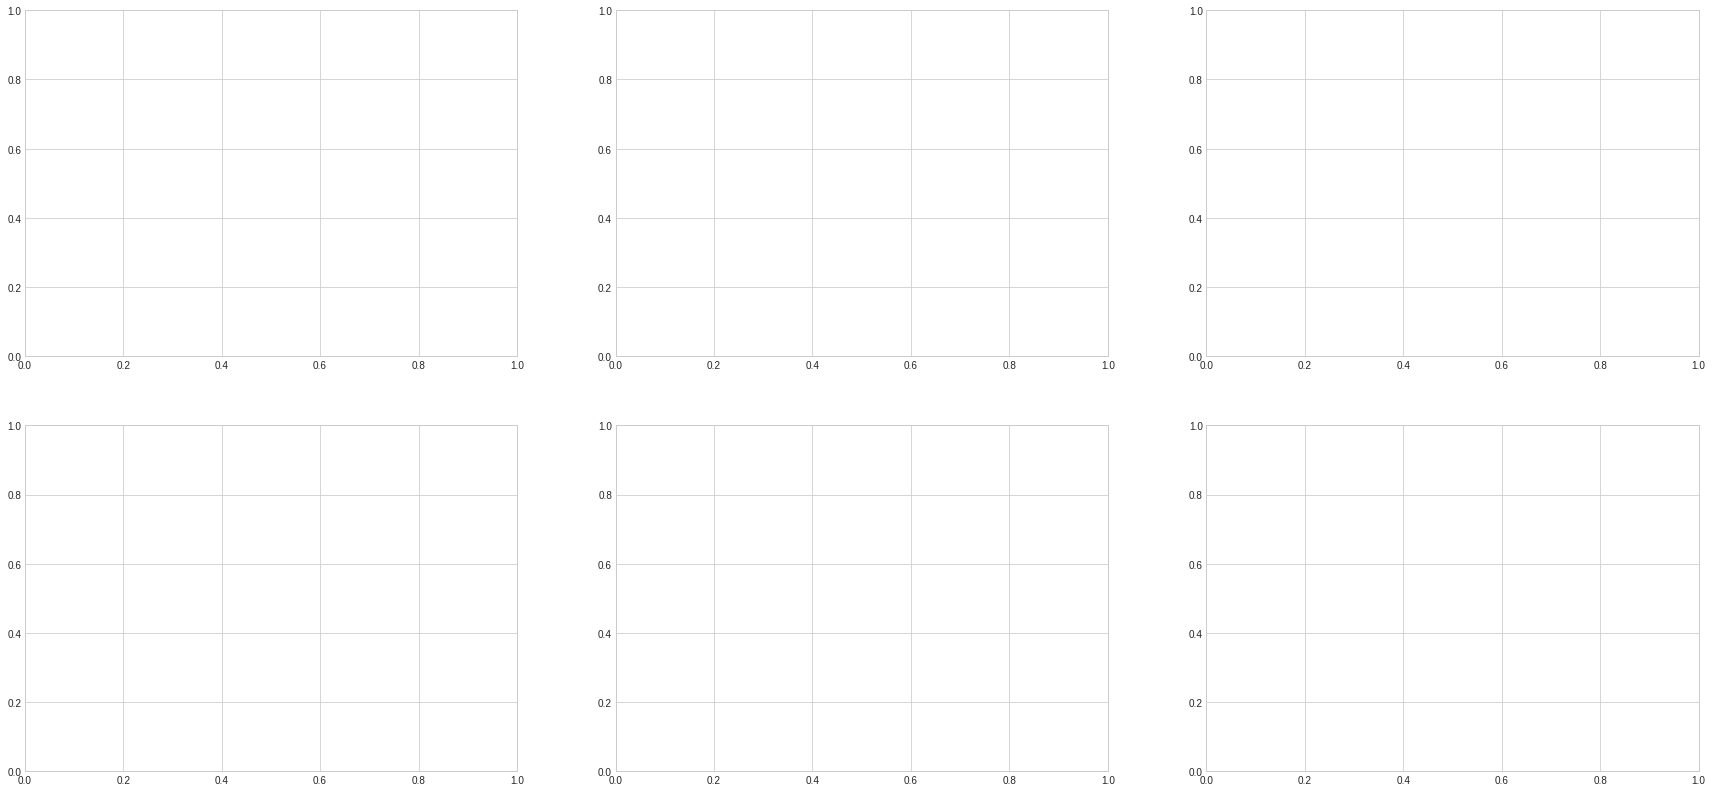

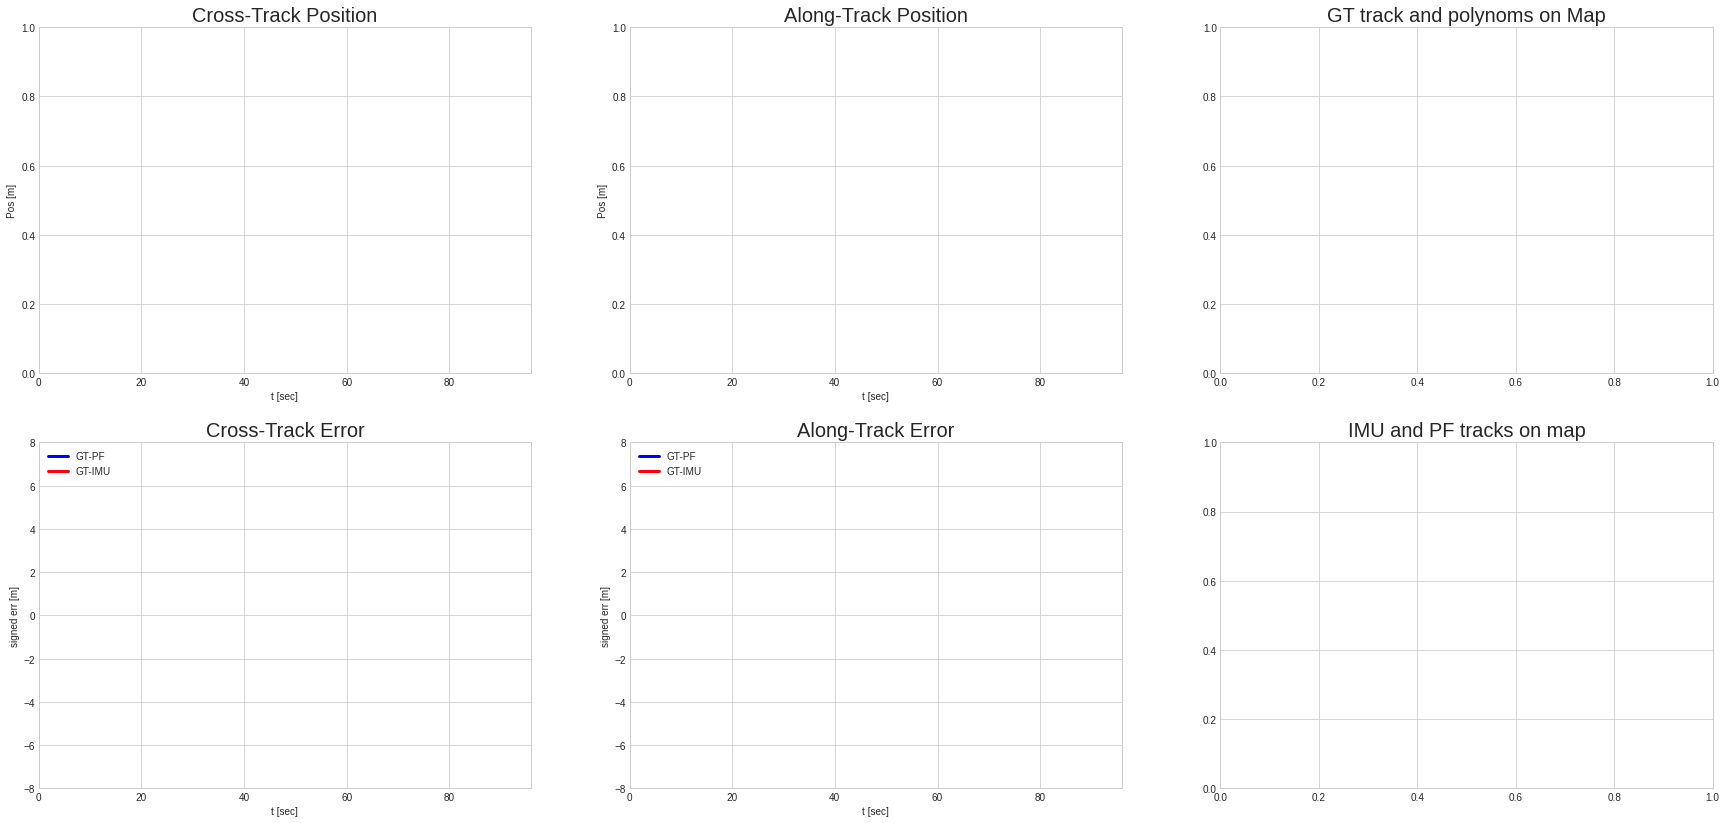

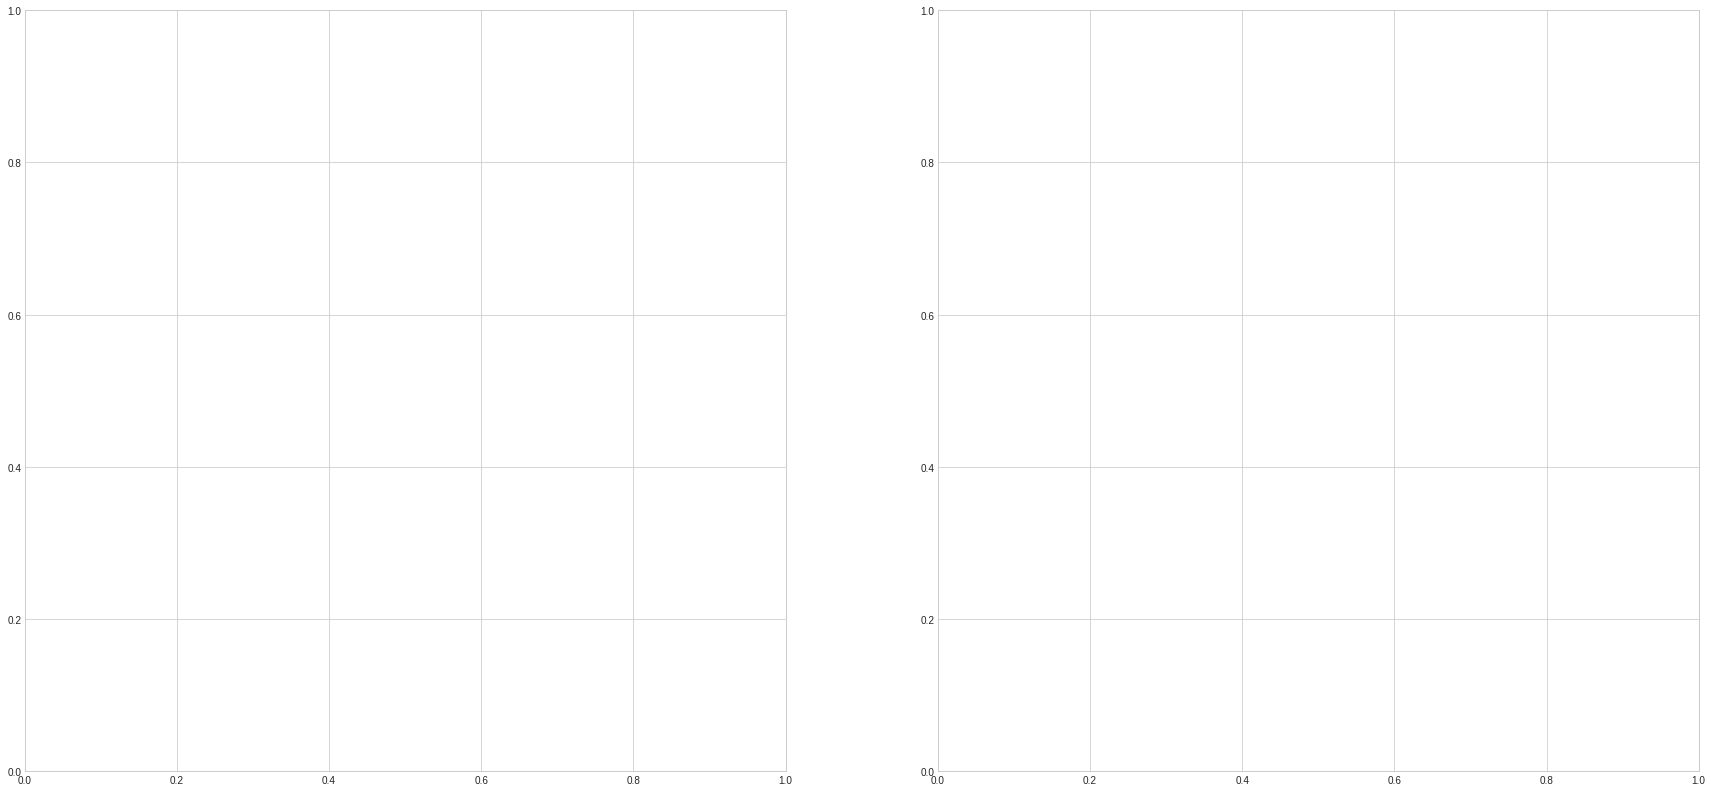

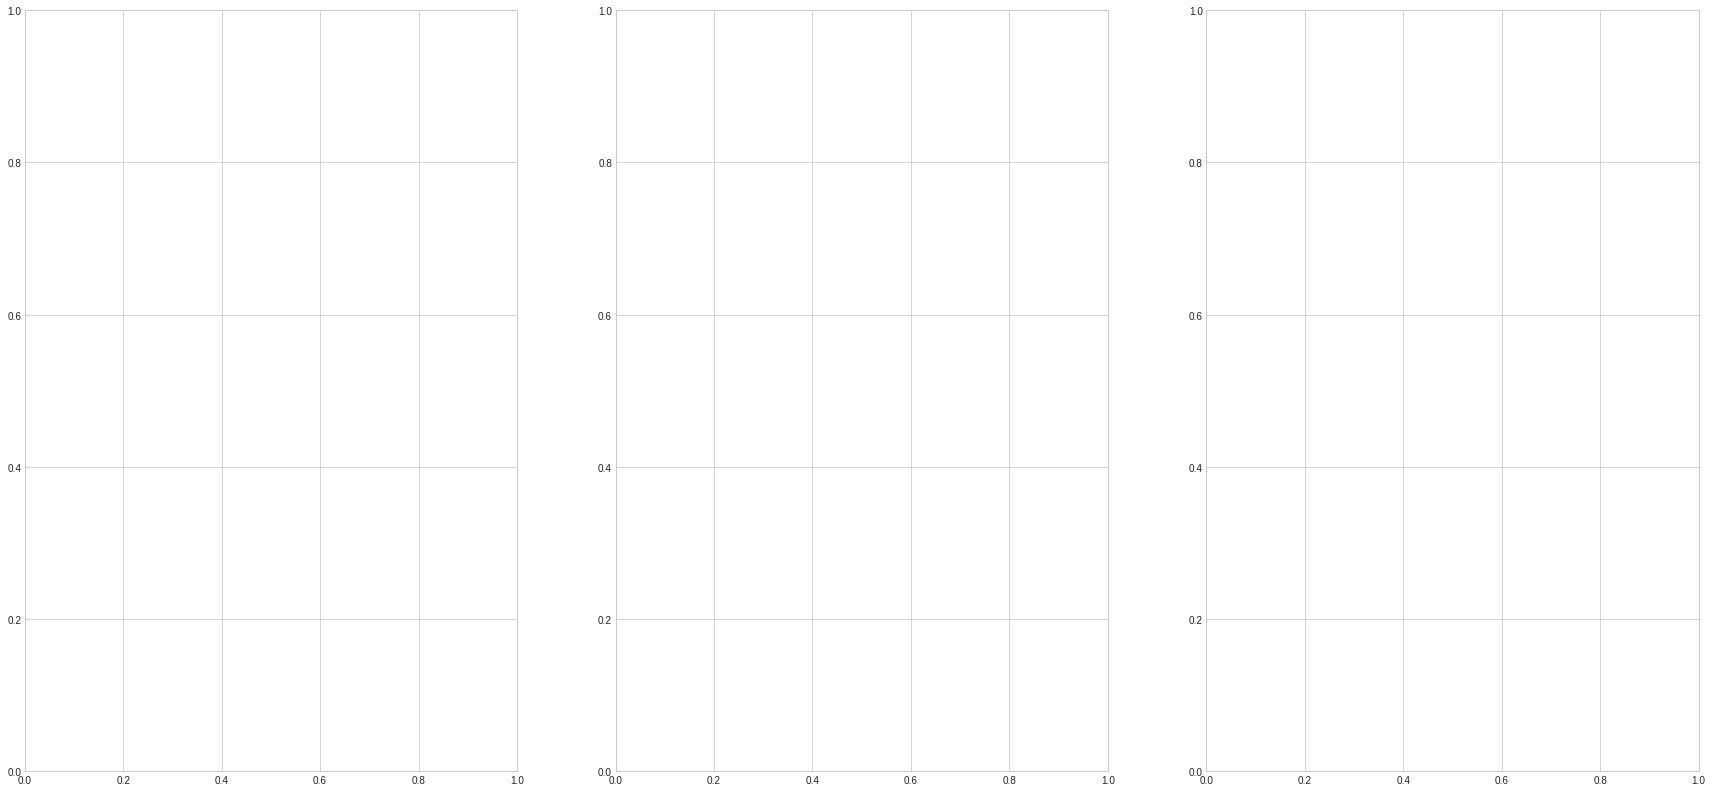

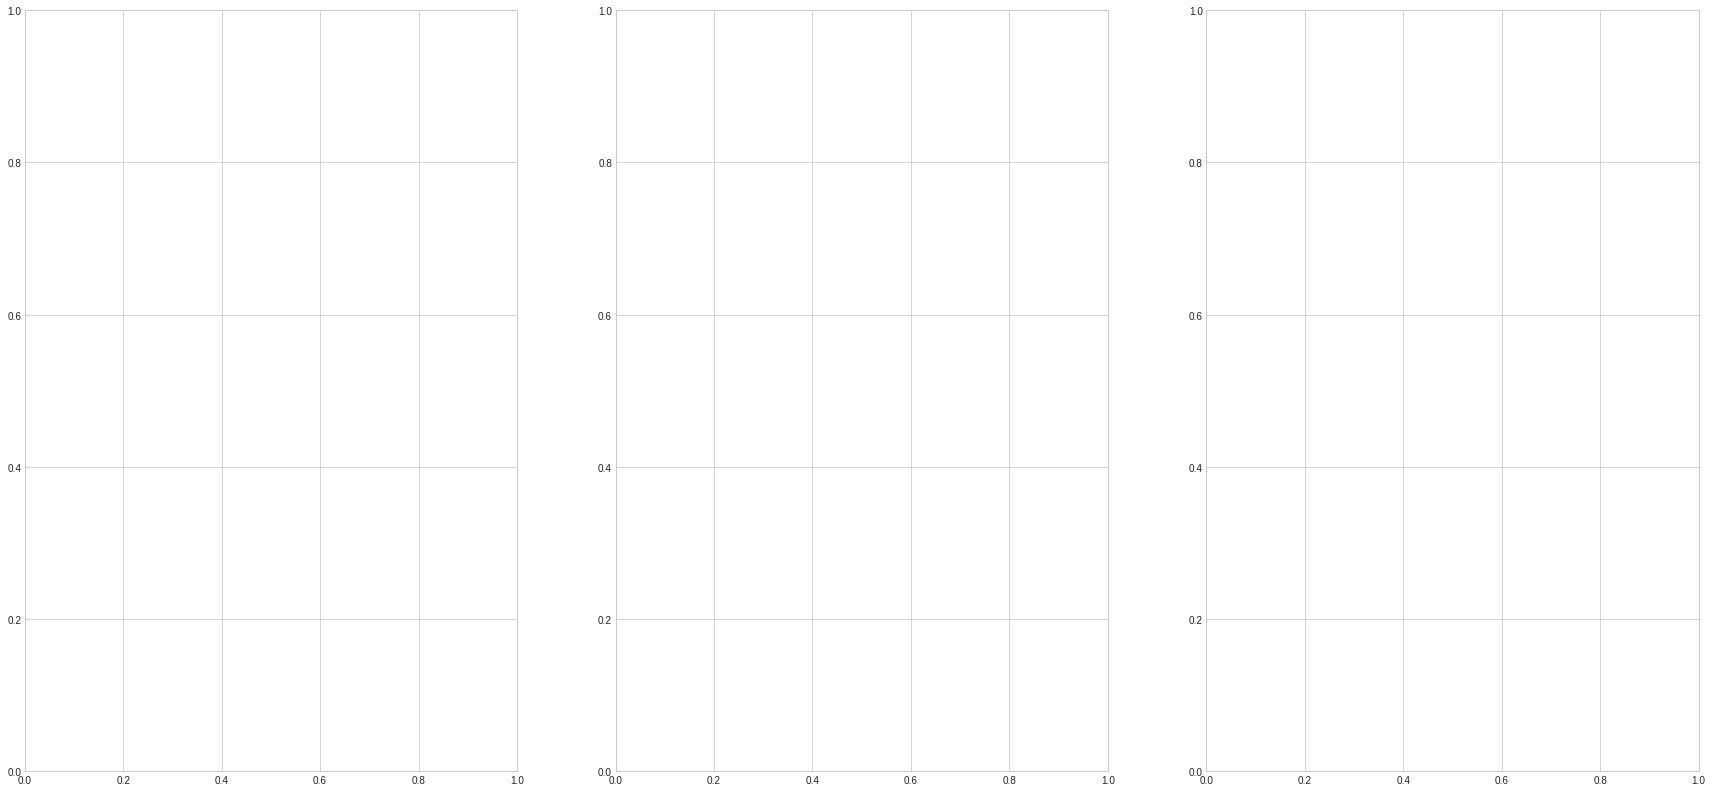

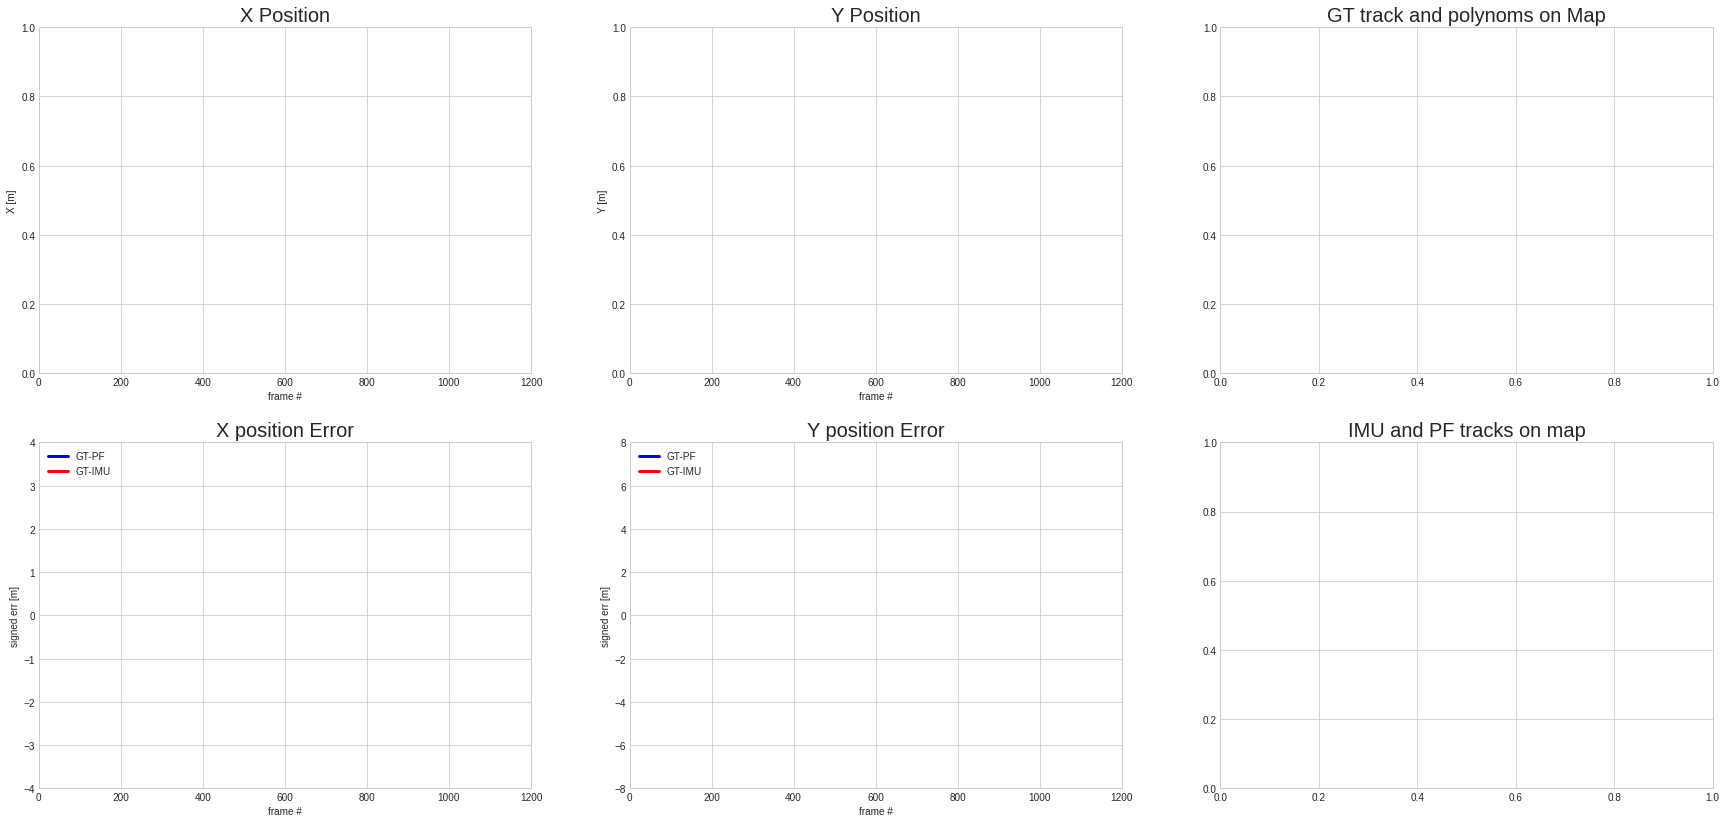

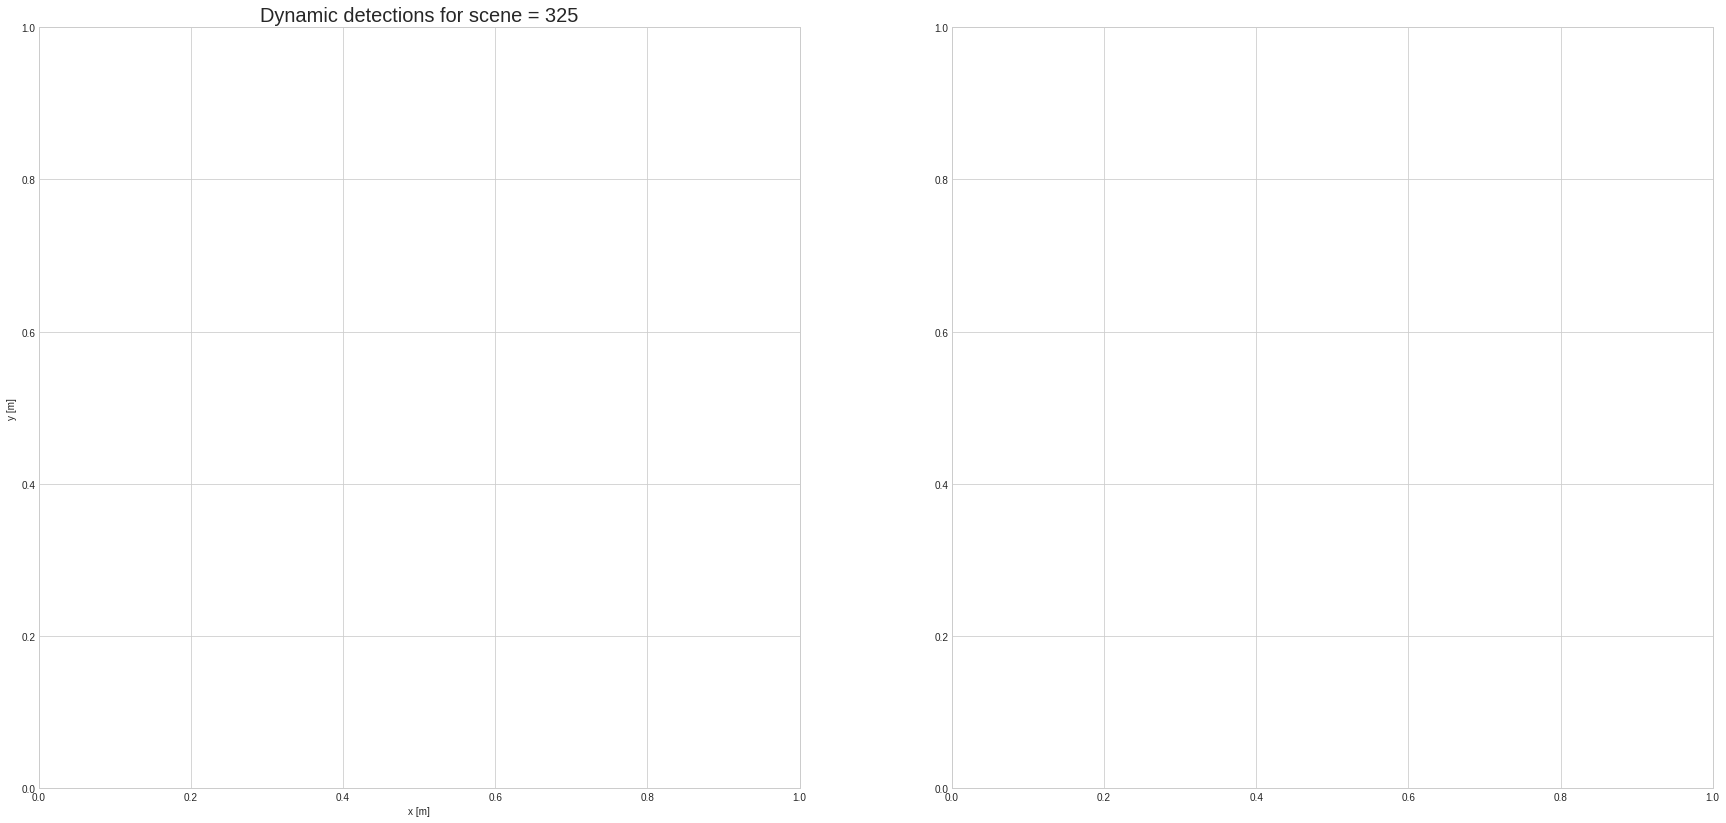

In [2]:
%load_ext autoreload
%autoreload 2
from simulation import NuscenesSimulation

class DummyModel():
    def __init__(self):
        self.mm = True
        
scene = 325
dummy_model = DummyModel()
video_list={'video' : False, 'video_debug': False, 'video_pf': False, 'video_pf_xy': False, 'dynamic_tracker': False}
sim = NuscenesSimulation(nusc=nusc, model=dummy_model, scene_id=scene, Nmax=1200, video_list=video_list, save_processed=True)

In [3]:
from tqdm import tqdm
import math

def calcTrackPosition(ego_path, ego_trns, gt_pos, pf_pos, imu_pos):
    #GT position
    gt_cross_track = 0
    it = np.argmin(np.linalg.norm(ego_path - np.array(gt_pos),axis=1),axis=0)
    it = max(1, min(it, ego_trns.shape[0]-2))
    gt_along_track = np.copy(ego_trns[it])
    #PF position
    it = np.argmin(np.linalg.norm(ego_path - np.array(pf_pos),axis=1),axis=0)
    it = max(1, min(it, ego_path.shape[0]-2))
    x,y,x1,y1,x2,y2 = pf_pos[0],pf_pos[1],ego_path[it-1][0], ego_path[it-1][1], ego_path[it+1][0], ego_path[it+1][1]
    d=(x-x1)*(y2-y1)-(y-y1)*(x2-x1)
    pf_cross_track = np.sign(d) * np.linalg.norm(ego_path[it]-pf_pos) #np.linalg.norm(np.cross(p2-p1, p1-pf_pos))/np.linalg.norm(p2-p1)
    pf_along_track = np.copy(ego_trns[it])
    #IMU position
    it = np.argmin(np.linalg.norm(ego_path - np.array(imu_pos),axis=1),axis=0)
    it = max(1, min(it, ego_path.shape[0]-2))
    x,y,x1,y1,x2,y2 = imu_pos[0],imu_pos[1],ego_path[it-1][0], ego_path[it-1][1], ego_path[it+1][0], ego_path[it+1][1]
    d=(x-x1)*(y2-y1)-(y-y1)*(x2-x1)
    imu_cross_track = np.sign(d) * np.linalg.norm(ego_path[it]-imu_pos)
    imu_along_track = np.copy(ego_trns[it])

    return np.array([gt_cross_track, gt_along_track]), np.array([pf_cross_track, pf_along_track]), np.array([imu_cross_track, imu_along_track])
    

def calc_rmse(ego_path, ego_trns, gt_pos, pf_mean_pos, imu_pos):
    gt_track_pos, pf_track_pos, imu_track_pos = calcTrackPosition(ego_path, ego_trns, gt_pos[0:2], pf_mean_pos, imu_pos)
    pf_track_errors = pf_track_pos - gt_track_pos
    imu_track_errors = imu_track_pos - gt_track_pos

    return pf_track_errors, imu_track_errors
    
def calc_acc_rmse(ego_path, ego_trns, pf_mean_pos, imu_pos, N):
    pf_rmse_lateral = np.zeros(N)
    pf_rmse_longitudal = np.zeros(N)
    imu_rmse_lateral = np.zeros(N)
    imu_rmse_longitudal = np.zeros(N)
    for i in tqdm(range(0,N)):
        pf_track_errors, imu_track_errors = calc_rmse(ego_path, ego_trns, ego_path[i,:], pf_mean_pos[i,:], imu_pos[i,:])
        print("pf_track_errors",pf_track_errors,"imu_track_errors",imu_track_errors)
        pf_rmse_lateral[i] = pf_track_errors[0]
        pf_rmse_longitudal[i] = pf_track_errors[1]
        imu_rmse_lateral[i] = imu_track_errors[0]
        imu_rmse_longitudal[i] = imu_track_errors[1]

    print(f"PF RMSE lateral: {math.sqrt((1. / N) * np.sum(pf_rmse_lateral**2))}")
    print(f"PF RMSE longitudal: {math.sqrt((1. / N) * np.sum(pf_rmse_longitudal**2))}")
    print(f"IMU RMSE lateral: {math.sqrt((1. / N) * np.sum(imu_rmse_lateral**2))}")
    print(f"IMU RMSE longitudal: {math.sqrt((1. / N) * np.sum(imu_rmse_longitudal**2))}")

In [4]:
from database import NuscenesProcessedDatabase
from tqdm import tqdm
data = NuscenesProcessedDatabase(scene_id=scene)


nusc_map = sim.dataset.nusc_map
video_with_priors = True

for t in tqdm(range(0,1300)):
    img = sim.dataset.getSyncedImage(t)
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
    video_data["img"] = img

    sim.video_list["video"] = False
    sim.video_list["video_debug"] = False
    sim.video_list["video_pf"] = True
    sim.video_list["video_pf_xy"] = False
    sim.video_list["dynamic_tracker"] = False

    sim.drawPlots(t, video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, nusc_map, video_with_priors, translation, debug_info)

  0%|          | 0/1300 [00:00<?, ?it/s]

self.dir_name images/325/database


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
No handles with labels found to put in legend.


PF RMSE lateral: 0.007273976961076871
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.0
IMU RMSE longitudal: 0.0


  0%|          | 1/1300 [00:01<22:48,  1.05s/it]

PF RMSE lateral: 0.0065259316046564885
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.0030285206044174205
IMU RMSE longitudal: 0.0


  0%|          | 2/1300 [00:01<21:29,  1.01it/s]

PF RMSE lateral: 0.011417415218304477
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.0090683292420864
IMU RMSE longitudal: 0.0


  0%|          | 3/1300 [00:02<20:43,  1.04it/s]

PF RMSE lateral: 0.01655808709033626
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.017469671848815236
IMU RMSE longitudal: 0.0


  0%|          | 4/1300 [00:03<20:44,  1.04it/s]

PF RMSE lateral: 0.016911355786423072
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.017927533660537637
IMU RMSE longitudal: 0.0
n_polynoms 1 cost_true [1.4628759067771095] cost_mean [1.5358840042858517]


  0%|          | 5/1300 [00:04<21:38,  1.00s/it]

PF RMSE lateral: 0.02591971612149946
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.026833991260552432
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.7143375148366098, 1.0223556964070453] cost_mean [1.7516631363920592, 1.1597891232979578]


  0%|          | 6/1300 [00:06<23:00,  1.07s/it]

PF RMSE lateral: 0.02439982064857438
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.025777225839922563
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.4700839097683278, 0.8939865860309985, 1.2557897185268017, 0.6046643483725775] cost_mean [1.5437714745641873, 0.9971157171556572, 1.114925726335624, 0.6809076899638148]


  1%|          | 7/1300 [00:07<23:36,  1.10s/it]

PF RMSE lateral: 0.02356733160877572
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.026075094623814802
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.1985252082372324, 0.7925110735887119, 3.7052209680854236, 0.622651706771433, 0.6142775914377798] cost_mean [1.231983889059405, 0.8810576359966241, 3.687077930991591, 0.8435373800899965, 0.6046350908042484]


  1%|          | 8/1300 [00:08<24:44,  1.15s/it]

PF RMSE lateral: 0.031888397313511445
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.03613107684573228
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.6544995677212455, 1.1825448039025896, 2.983003154883788, 0.7429194921902803, 0.7329995545915949] cost_mean [1.6906276137150398, 1.3938316901806207, 2.802377855022104, 0.8637985387645477, 0.8831251920954516]


  1%|          | 9/1300 [00:09<25:26,  1.18s/it]

PF RMSE lateral: 0.03141741937976038
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.03651639991529783
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.6489817268718163, 1.0841136500476292, 2.4037706933616736, 0.6294758471962156, 0.6964755710429255] cost_mean [1.5986781667357657, 1.2790841216666242, 2.324487276535492, 0.8662408708120174, 0.7785033999855936]


  1%|          | 10/1300 [00:11<26:13,  1.22s/it]

PF RMSE lateral: 0.031030785240545353
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.03691910224557091
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.6269973304113992, 0.9171721516145422, 2.290935407235773, 0.7049569535685758, 0.5883439755977752] cost_mean [1.6720727428145619, 1.0720515901776715, 2.2105651921846077, 0.6793403906771777, 0.6989689136339037]


  1%|          | 11/1300 [00:12<27:02,  1.26s/it]

PF RMSE lateral: 0.03201937720938017
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.03821138324718673
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.2223053624044458, 1.2597868038266933, 2.681443725494318, 0.6256454649614704, 0.5932441539003356] cost_mean [1.2678474899776817, 1.4463749781791777, 2.5400931591517506, 0.8607990603190072, 0.6129033765985815]


  1%|          | 12/1300 [00:13<28:00,  1.30s/it]

PF RMSE lateral: 0.03282392999966197
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.03963557326106675
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.5005006614823198, 1.0411306358585648, 2.818985740443615, 0.6518151618272924, 0.6756229402503944] cost_mean [1.5753842421285933, 1.036479795346428, 2.6885686695838316, 0.7478067179307928, 0.8363599596595094]


  1%|          | 13/1300 [00:15<28:12,  1.32s/it]

PF RMSE lateral: 0.03691443631853047
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.04459249944718404
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.7875353260650735, 0.998398790658694, 2.3972404909699367, 0.7446940070161903, 0.6688767607085334] cost_mean [1.820160913994028, 1.16912341093867, 2.3773487760173566, 0.8978895877900439, 0.8005830371874874]


  1%|          | 14/1300 [00:16<28:58,  1.35s/it]

PF RMSE lateral: 0.03662281206211104
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.04498049434095547
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.575832332377519, 1.1152428081705288, 2.3623151046937867, 0.5789668927793563, 0.5998479360987716] cost_mean [1.617445422957072, 1.2698429900718002, 2.336700943931871, 0.6479876098543149, 0.6804924328252845]


  1%|          | 15/1300 [00:18<29:35,  1.38s/it]

PF RMSE lateral: 0.036059853018440856
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.04513045696157034
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.361712136201184, 0.8219275435397703, 2.564374598381734, 0.6703888188168844, 0.5853332422279667] cost_mean [1.4106578196126685, 0.9410648589516183, 2.432178396071268, 0.9911741205275286, 0.6037578107353381]


  1%|          | 16/1300 [00:19<29:41,  1.39s/it]

PF RMSE lateral: 0.03667755440417843
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.04628008544774912
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.0508391921237266, 2.529689360679455, 0.5514940185642766, 0.6647829328400078] cost_mean [1.1088522711567266, 2.5102837465962127, 0.6758019279535369, 0.8119312563648761]


  1%|▏         | 17/1300 [00:20<30:15,  1.42s/it]

PF RMSE lateral: 0.036216265641569746
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.04658089653139534
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.5661640571218318, 2.081650928225394, 0.6073539730649162] cost_mean [1.5939076798677485, 2.138322304928357, 0.7088488741985451]


  1%|▏         | 18/1300 [00:22<31:01,  1.45s/it]

PF RMSE lateral: 0.03697491255920222
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.048118148660657147
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.5496037323630627, 2.46790809034965, 0.6683007287456727] cost_mean [1.5782680525433128, 2.3841747947990033, 0.740780190810713]


  1%|▏         | 19/1300 [00:23<31:24,  1.47s/it]

PF RMSE lateral: 0.03739872542941861
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.049545038864700124
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.2854820071088193, 2.738884894894514, 0.6576943673175407] cost_mean [1.3302120416793277, 2.597493056757702, 0.761415199114895]


  2%|▏         | 20/1300 [00:25<31:32,  1.48s/it]

PF RMSE lateral: 0.03735527010235594
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.049952165563195164
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.5904309604058258, 2.935932979987841, 0.624459679883942, 0.7095537439187879] cost_mean [1.5573807259274717, 2.8500820256728194, 0.881875694230156, 0.7333313613504174]


  2%|▏         | 21/1300 [00:27<32:12,  1.51s/it]

PF RMSE lateral: 0.037981392126480704
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.051517607442345806
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.849329144080796, 2.5922083617454827, 0.6493216337817735, 0.6550438651200776] cost_mean [1.8700224759588318, 2.509487813745564, 0.7851798751148188, 0.7610430601800556]


  2%|▏         | 22/1300 [00:28<33:07,  1.56s/it]

PF RMSE lateral: 0.03871900029347661
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.05251250373091981
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.4422114077912156, 2.3914869266919547, 0.7158940584293754, 0.5771928123724693] cost_mean [1.460115762394375, 2.264916498401786, 0.8155477393673307, 0.5946932815945427]


  2%|▏         | 23/1300 [00:30<33:34,  1.58s/it]

PF RMSE lateral: 0.040881789222893435
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.05416123900494438
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.067816842432489, 2.629473282105142, 0.6270466914883979, 0.7672691359629751] cost_mean [1.1026397130295225, 2.6303403589710026, 0.7200071127726322, 0.7416510522079494]


  2%|▏         | 24/1300 [00:32<34:12,  1.61s/it]

PF RMSE lateral: 0.041518673686387494
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.05533660547596943
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.5842248048073388, 2.6207645814393086, 0.5831525105628212, 0.8186448627628758] cost_mean [1.5985007627202341, 2.5316041834342253, 0.789603677051607, 0.7776897913899046]


  2%|▏         | 25/1300 [00:33<34:40,  1.63s/it]

PF RMSE lateral: 0.043155890434119014
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.05662740766578343
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.731137784096949, 2.4950403965838617, 0.6776899430947706, 0.5635235444488613] cost_mean [1.7401463112820599, 2.4744586831566373, 0.7811980143597668, 0.7038661658739078]


  2%|▏         | 26/1300 [00:35<34:50,  1.64s/it]

PF RMSE lateral: 0.044784070244275644
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.0580181358776138
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.5802869642132635, 2.426811295182804, 0.6824007784126159, 0.7149489594044522] cost_mean [1.5781523697522108, 2.3963767487820955, 0.7190552460358914, 0.7118432369089829]


  2%|▏         | 27/1300 [00:37<35:25,  1.67s/it]

PF RMSE lateral: 0.04521437886919497
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.059389028712836515
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.2599746347864333, 2.620887338253122, 0.7133089445639686, 0.7583124486810928] cost_mean [1.2856925915205175, 2.513929427447735, 0.7916701746398378, 0.7258628493653918]


  2%|▏         | 28/1300 [00:38<36:01,  1.70s/it]

PF RMSE lateral: 0.045938203347090284
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.06083153757820574
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.6133273582246874, 2.665094744216958, 0.5937806360463003, 0.6642620404345033] cost_mean [1.6431615320900888, 2.5414205873310594, 0.7224418496906779, 0.7786930401141318]


  2%|▏         | 29/1300 [00:40<36:25,  1.72s/it]

PF RMSE lateral: 0.04627870029900839
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.06297498433793157
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.444647138541091, 2.5006153324107605, 0.5398812592498906, 1.6217092570920468] cost_mean [1.4941377251089931, 2.406419082312257, 0.5620523203911824, 1.6167179202250361]


  2%|▏         | 30/1300 [00:42<36:55,  1.74s/it]

PF RMSE lateral: 0.04717358958983499
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.06464911633999193
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.1724972777353178, 2.7317633808228585, 0.7842580970660181, 1.8480841854426122, 1.7826127743895905, 0.9252773585032648] cost_mean [1.2051631577215038, 2.6436472082717413, 0.7442439342789533, 1.7712974630466798, 2.1812668970991043, 0.901353481695704]


  2%|▏         | 31/1300 [00:44<37:26,  1.77s/it]

PF RMSE lateral: 0.047696027242929276
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.06661596093563434
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.7553555255379767, 2.9380288479853283, 0.8602640673154898, 0.7486796457918302, 1.2573774220668432] cost_mean [1.7430036517103644, 2.7763309661393234, 0.7144459414734136, 0.7229855078297445, 1.0262885973313516]


  2%|▏         | 32/1300 [00:46<38:02,  1.80s/it]

PF RMSE lateral: 0.048372647534780454
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.06847021678471076
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.5963644109448436, 2.538398580496003, 1.0004794351615656, 0.7258068479077983, 1.1781551388753118, 0.9975459950399744] cost_mean [1.6207731807937245, 2.487416616263553, 0.9015623097184937, 0.7646308733000049, 1.090213247446441, 0.8378013363861564]


  3%|▎         | 33/1300 [00:48<38:43,  1.83s/it]

PF RMSE lateral: 0.05014082964577888
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.07030446851458284
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.4800179442415982, 2.48576587744899, 1.047457211204277, 0.7308593640861142, 1.162705977147285, 0.8344130813060942] cost_mean [1.4588003473256141, 2.438160229153226, 0.9529063900462675, 0.7613071020975807, 0.9604859758650522, 0.705930959107609]


  3%|▎         | 34/1300 [00:50<39:15,  1.86s/it]

PF RMSE lateral: 0.051265265013753225
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.07237219741849592
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.2291420651290108, 2.4591883103414283, 1.040681478776095, 0.8099730986060525, 1.3755019316692016, 0.923238724618147] cost_mean [1.242760222178315, 2.4684688189844803, 0.921408730051337, 0.7755659585314847, 1.1440075049219227, 0.7693097292570731]


  3%|▎         | 35/1300 [00:51<39:48,  1.89s/it]

PF RMSE lateral: 0.052850731600745736
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.07428318993977719
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.8662461450270478, 2.7038323050193394, 1.0625625579616405, 0.7128274782525481, 1.2549847160108076, 0.873022379529302] cost_mean [1.8771916112976896, 2.624665667016825, 0.9303596856094972, 0.7760184807743079, 1.0651078795096038, 0.7366641807885853]


  3%|▎         | 36/1300 [00:53<40:25,  1.92s/it]

PF RMSE lateral: 0.05420547035780501
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.07622333542869142
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.4464427125297112, 2.4554004548970756, 1.0502307875363897, 0.7806036716221548, 1.2040115327032679, 0.9018670621468466] cost_mean [1.4284930157981997, 2.3810940039449178, 0.9363824823669861, 0.7924579191159674, 1.1805490332115394, 0.7341172844837727]


  3%|▎         | 37/1300 [00:55<40:56,  1.94s/it]

PF RMSE lateral: 0.05509108737167329
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.07835642536288662
IMU RMSE longitudal: 0.0
n_polynoms 7 cost_true [1.180379763281236, 2.368411347990806, 1.0518895443658447, 0.8077893105394143, 1.1444240447003104, 0.9141566624114736, 65.43862034643585] cost_mean [1.182183152721444, 2.2714936292731203, 0.9662447477579288, 0.8119400418314632, 1.1341925791275955, 0.7781830629363793, 70.84957238540458]


  3%|▎         | 38/1300 [00:57<41:30,  1.97s/it]

PF RMSE lateral: 0.05599360525336128
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.08056652037319446
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [2.894959197337724, 0.7408288432035576, 0.748291922427033, 1.1685012576402194, 1.0948439600303759, 47.08281571162652] cost_mean [2.7871452212918673, 0.6852549390740702, 0.7492826044625942, 0.9939938575217359, 0.9285357356370842, 51.277507905125354]


  3%|▎         | 39/1300 [01:00<41:52,  1.99s/it]

PF RMSE lateral: 0.057535191259578906
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.08252357291987115
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [2.6018625355082277, 1.1043944074780454, 0.8370845986022678, 1.0984917694730632, 0.9972193313384043, 61.59189540013741] cost_mean [2.5488005568043115, 0.9968380177304783, 0.972340964562124, 1.0431414951632496, 0.80781150199929, 65.55536909079295]


  3%|▎         | 40/1300 [01:02<42:27,  2.02s/it]

PF RMSE lateral: 0.05840969843142136
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.08493094225945995
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [2.233532582458417, 1.0311938858441285, 0.7390022933977868, 0.7607798347001875, 0.726120413664366, 34.74638187359474] cost_mean [2.139414539444106, 0.9966097275600474, 0.802587152554425, 0.7945902788805548, 0.6315851213789249, 45.138981997377954]


  3%|▎         | 41/1300 [01:04<42:52,  2.04s/it]

PF RMSE lateral: 0.05984044535557145
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.08705953867282175
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.8184535086338904, 0.7413183969582461, 0.8169814889471744, 1.2643892745754803, 65.73739710829217] cost_mean [2.627386182136267, 0.669491548603047, 0.8417896007233898, 1.0165716609626028, 50.294337640685704]


  3%|▎         | 42/1300 [01:06<43:19,  2.07s/it]

PF RMSE lateral: 0.06043012669306729
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.0895085692145676
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.713692235772142, 0.8710901707976155, 0.7445429763636867, 0.8995172318891815, 44.49149974992704] cost_mean [2.672436855665622, 0.8296375190985482, 0.8390143233709139, 0.7379433682544229, 39.81906486470186]


  3%|▎         | 43/1300 [01:08<43:46,  2.09s/it]

PF RMSE lateral: 0.06138512661003347
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.09216160100599256
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.186033700960254, 1.0066193813368451, 0.7649236979383994, 42.72916998508931, 1.0154986053844743] cost_mean [2.1647424270430893, 0.8869635877245993, 0.7894169459020876, 39.50099385526727, 0.998353714804273]


  3%|▎         | 44/1300 [01:10<44:10,  2.11s/it]

PF RMSE lateral: 0.06241603364979001
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.09433270894629374
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [2.391445951247432, 1.0933526616408478, 0.7727105622091917, 50.386397639990584, 1.049215043848457, 0.7966956339375529] cost_mean [2.3301360852370556, 1.0151734560210337, 0.7980700404692568, 39.02512686856911, 1.010941488816437, 0.7471182305355728]


  3%|▎         | 45/1300 [01:12<44:47,  2.14s/it]

PF RMSE lateral: 0.06433605696907262
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.09796037123006024
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [2.497193869569052, 0.717465348117747, 0.8441607143149664, 37.14457459861254, 0.9265656595922738, 0.813967341615517] cost_mean [2.5652329307530475, 0.6347631646727838, 0.8417686572685462, 39.485479816953294, 1.0243402930524343, 0.8507485961187397]


  4%|▎         | 46/1300 [01:15<45:19,  2.17s/it]

PF RMSE lateral: 0.06558269485558554
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.10125376454584224
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [2.369010128679524, 0.9983260582737553, 0.7444763117326187, 37.53998235171594, 0.9664099970443844, 0.8978861608375657] cost_mean [2.3238831934060094, 0.9103715738702909, 0.7997391325629091, 39.41810601935601, 0.9538802182527305, 0.9328719817154035]


  4%|▎         | 47/1300 [01:17<45:52,  2.20s/it]

PF RMSE lateral: 0.06648746329716275
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.10372110250904272
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [2.627166739227358, 0.996676961900023, 0.7651222522628436, 43.451487355834765, 0.9497136985328901, 0.804541775115544] cost_mean [2.4822682118565194, 0.9251082321112092, 0.8066053508903863, 46.179479833062764, 1.0645561864099609, 0.8613936212663238]


  4%|▎         | 48/1300 [01:19<46:31,  2.23s/it]

PF RMSE lateral: 0.06786533924513403
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.10569723455275115
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [2.763279053374873, 0.8458403024913131, 0.9702460946732011, 0.7429553955661233] cost_mean [2.7093485027210114, 0.8421963941612401, 1.0428078987026648, 0.7524539384600641]


  4%|▍         | 49/1300 [01:21<46:59,  2.25s/it]

PF RMSE lateral: 0.06898614009626283
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.10799815389621666
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.7024585879036955, 0.7538081042325345, 0.9177572630387091, 0.7896889333167018, 3.333946420566169] cost_mean [2.7017558492929354, 0.8334456166945522, 0.9205803210272808, 0.887326265033158, 3.4276957858873436]


  4%|▍         | 50/1300 [01:24<47:16,  2.27s/it]

PF RMSE lateral: 0.07030608589310057
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.11025860016259298
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.555897086201711, 0.7982540413038979, 1.0223087051324884, 0.6957024729140624, 3.3941716866045035] cost_mean [2.45167936950414, 0.8146632909902993, 0.9970033688713777, 0.8027253913116631, 3.3968885077415534]


  4%|▍         | 51/1300 [01:26<47:50,  2.30s/it]

PF RMSE lateral: 0.07153696142564663
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.11308707464266207
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.267698259097931, 0.7962429563715634, 1.0178215637071755, 0.8217377498299835, 5.4003481993936] cost_mean [2.212365277064376, 0.7973407479940144, 0.976202693341399, 0.8808365206706595, 5.83516063135284]


  4%|▍         | 52/1300 [01:29<48:24,  2.33s/it]

PF RMSE lateral: 0.07295763274682153
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.11546087489090098
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.6735890927160044, 0.8525494879118048, 0.8976023251133447, 0.6917869546477317, 11.144236954072369] cost_mean [2.6410606087584187, 0.9460058191401088, 0.888792821835606, 0.7789895679801863, 11.387291799659598]


  4%|▍         | 53/1300 [01:31<48:43,  2.34s/it]

PF RMSE lateral: 0.07433401866542035
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.11773061333209883
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.4059055412750006, 0.7474931683426091, 0.9516212026793576, 0.9175578672411852, 4.037153031064448] cost_mean [2.355156940342231, 0.8113852005928378, 0.9180093469588785, 0.9430099167896624, 4.272892839315505]


  4%|▍         | 54/1300 [01:33<49:10,  2.37s/it]

PF RMSE lateral: 0.07562290554674929
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.12054649508517862
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [2.570672182203483, 0.7490697009780949, 0.7521719745103733, 3.669342852821883] cost_mean [2.4870220229679676, 0.7713159502153588, 0.8520579777661493, 3.6985023108951167]


  4%|▍         | 55/1300 [01:36<49:40,  2.39s/it]

PF RMSE lateral: 0.07737269100392588
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.12305270607447359
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [2.9447024996452806, 0.8131685473141312, 10.837434557226162, 0.9007160091159975] cost_mean [2.9077202122377384, 0.842268814073951, 10.638936822135102, 0.9471561419722164]


  4%|▍         | 56/1300 [01:38<50:35,  2.44s/it]

PF RMSE lateral: 0.07912204906396128
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.12621168198650443
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.692970617523685, 0.7367751899328205, 4.181349010646522, 0.8818920842608521, 0.7766116796901847] cost_mean [2.6346205033310275, 0.7914730375368807, 4.215355687441316, 0.8286418946349927, 0.8075217181796822]


  4%|▍         | 57/1300 [01:41<50:37,  2.44s/it]

PF RMSE lateral: 0.08096784316146204
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.12936348895960031
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.8473512463682313, 0.7930104212726721, 7.258098754850981, 1.0488113676419029, 0.5135853675675409] cost_mean [2.7588557362333423, 0.8278013820368556, 7.739560354896887, 1.0023790926691567, 0.6467693908120479]


  4%|▍         | 58/1300 [01:43<51:26,  2.48s/it]

PF RMSE lateral: 0.0831500891716587
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1318750516547488
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.993547760120942, 0.764255352364997, 3.496217481406788, 0.9079066461470645, 0.7599212512874197] cost_mean [2.981012961807047, 0.7416524656649081, 3.6718975694387477, 0.9567497417096228, 0.8570312271462205]


  5%|▍         | 59/1300 [01:46<51:44,  2.50s/it]

PF RMSE lateral: 0.0851092557307935
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.13475157841741361
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.6946982645928133, 0.83911409392682, 11.297748714811345, 0.934802296762901, 0.49389840998079854] cost_mean [2.704952333229647, 0.9619247698055728, 11.066853757020763, 0.9787071516352828, 0.7312366107215132]


  5%|▍         | 60/1300 [01:49<52:21,  2.53s/it]

PF RMSE lateral: 0.08711887883295523
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1377770979897381
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.607974278792455, 0.7288309071258093, 0.9484418615267681, 0.6368607663116534, 2.07572716606954] cost_mean [2.6236924563521833, 0.7878506320937383, 0.8802173030669995, 0.7699698229207979, 1.6541801635265503]


  5%|▍         | 61/1300 [01:51<52:40,  2.55s/it]

PF RMSE lateral: 0.08921092250096822
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.14036092047076826
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [2.821723300118115, 0.8741356634023846, 0.9922790906134308, 0.7415027161067467, 1.512772568113474, 12.167782615344361] cost_mean [2.6770963494481714, 0.9126797801511914, 1.0322586402927236, 0.9609838270079445, 1.413767454098055, 10.753117790515786]


  5%|▍         | 62/1300 [01:54<53:15,  2.58s/it]

PF RMSE lateral: 0.09142105953886909
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1434956093679304
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.8525553732692903, 0.9101267719662348, 0.7299667016000138, 1.8019906387796263, 6.825612275266816] cost_mean [2.7877089731499685, 0.9584358429727037, 0.7397455418758027, 1.612744787020705, 6.357967377748489]


  5%|▍         | 63/1300 [01:56<53:32,  2.60s/it]

PF RMSE lateral: 0.09411024731512505
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.14627714751933088
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.5688398814663147, 0.8729182703542907, 0.44950596191871495, 1.5485453362995212, 8.045804977933631] cost_mean [2.4364562927812994, 0.9376044147952536, 0.6673521160570334, 1.3947208501013364, 7.341328956868256]


  5%|▍         | 64/1300 [01:59<54:10,  2.63s/it]

PF RMSE lateral: 0.0966063327405036
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1490906959879
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [2.798215768442899, 1.028772356934643, 0.49546755838405687, 1.3480783783468813, 11.253342894044977] cost_mean [2.74829699578428, 0.9916860046964779, 0.6471976443470934, 1.3128911455533925, 9.740422305877773]


  5%|▌         | 65/1300 [02:02<54:34,  2.65s/it]

PF RMSE lateral: 0.09927858049568793
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.15231491378117729
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9239828033339508, 0.8177787145001757, 1.5434335963890755, 6.5183915054042885] cost_mean [0.943890803731619, 0.9121716315205689, 1.3947745329339238, 5.90203747245055]


  5%|▌         | 66/1300 [02:05<55:07,  2.68s/it]

PF RMSE lateral: 0.10230635540701874
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.15500797769723765
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.49868628519620306, 1.4600626746811816, 7.613257401151353] cost_mean [0.7300286135270185, 1.524004567579378, 6.955653056646237]


  5%|▌         | 67/1300 [02:07<55:27,  2.70s/it]

PF RMSE lateral: 0.10508369953376251
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.15832634291717013
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.5768264042060156, 7.231065750958246, 1.097426739174896] cost_mean [1.4198279670657936, 6.43425294031031, 1.0893278300013793]


  5%|▌         | 68/1300 [02:10<56:22,  2.75s/it]

PF RMSE lateral: 0.10807955058335394
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.16139902669023892
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.7422740160575934, 7.621015885130009, 1.0242240574463386] cost_mean [1.5973647876620116, 6.959874973294786, 1.067070371774059]


  5%|▌         | 69/1300 [02:13<57:10,  2.79s/it]

PF RMSE lateral: 0.11178331765487089
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.16417766964610453
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.372672418039869, 6.7170025224931775, 1.0441368693532695, 13.052948056784281, 1.2741940068533604] cost_mean [1.4452084183374205, 5.925494481030091, 1.0147500749267448, 12.80997928754035, 1.0422424897076326]


  5%|▌         | 70/1300 [02:16<57:57,  2.83s/it]

PF RMSE lateral: 0.11587619467763932
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.16694402109171658
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.610525780363287, 7.831916737415821, 1.2129022096817632, 11.751187701174391, 0.9786664516202697, 12.876987024832081] cost_mean [1.4574501354128648, 6.91660258051409, 1.2767717620570749, 11.157656906028983, 0.9444285751887403, 14.341891847467817]


  5%|▌         | 71/1300 [02:19<58:34,  2.86s/it]

PF RMSE lateral: 0.1194449094988037
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.17017340570209677
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.770121417064282, 11.889538396200726, 1.2228569357056838, 13.082104793094924, 1.0863743013492935, 15.946349348764075] cost_mean [1.524249722687657, 11.376780505247584, 1.1562920763092217, 12.878869148582863, 0.9114324574268318, 17.040753769172916]


  6%|▌         | 72/1300 [02:22<58:44,  2.87s/it]

PF RMSE lateral: 0.123746214000103
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.17301839221481494
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.6827963308389435, 1.002145488621508, 10.846442440781676, 1.1452259582064597, 11.791672951154244] cost_mean [1.5849425090417988, 1.11586505083245, 10.26930309382215, 1.0361053859931362, 13.67486495355229]


  6%|▌         | 73/1300 [02:25<59:00,  2.89s/it]

PF RMSE lateral: 0.1276777716985611
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.17630879815407136
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.6311805315946657, 1.179539921862876, 6.412293807055288, 1.2709706396613845, 13.476106408424782] cost_mean [1.7144469899797357, 1.2545823750581273, 6.207035965021965, 1.1123877779437341, 15.115095956002458]


  6%|▌         | 74/1300 [02:28<59:27,  2.91s/it]

PF RMSE lateral: 0.13184632294918947
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1796373786050242
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.7901804759261601, 1.3028651634029664, 9.090120080677085, 1.052745188350715, 19.733995358881316] cost_mean [1.5335150133725495, 1.3501315663015687, 8.407609916050669, 0.9914329537994526, 21.257735771885073]


  6%|▌         | 75/1300 [02:31<59:51,  2.93s/it]

PF RMSE lateral: 0.13770548165053062
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1823679948871516
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.593409281032716, 0.9606053127973434, 12.347019811563609, 1.1326989990475744, 12.94654105376615, 0.8792640775304157] cost_mean [1.4947317701585756, 1.0833098540582191, 10.81622535071147, 0.9762185636676165, 14.979917784357486, 0.8200237409036125]


  6%|▌         | 76/1300 [02:34<1:00:15,  2.95s/it]

PF RMSE lateral: 0.1420906645345866
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1855128634781674
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.9478657159923716, 1.3000098187539524, 5.860274071319743, 1.2295777745834366, 11.3398383343059, 0.6568090565978706] cost_mean [1.7957411846599276, 1.3544684270029603, 5.130998759732627, 1.0407393412603345, 12.97286900082947, 0.8457580724701117]


  6%|▌         | 77/1300 [02:37<1:00:41,  2.98s/it]

PF RMSE lateral: 0.14637429948203554
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.18870068831948075
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.7044893057859098, 1.2162059316642384, 11.317639248086056, 1.0413099731357616, 13.132764310608898, 0.4761970346737092] cost_mean [1.6108422355438516, 1.2596017844932208, 10.234322423081203, 1.101304597507049, 14.617784757862722, 0.5517290110443398]


  6%|▌         | 78/1300 [02:40<1:01:06,  3.00s/it]

PF RMSE lateral: 0.1520243532688923
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.19157749899217905
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.7128858510428753, 6.404786123901644, 0.9704680180763927, 15.275713968905327, 0.8839978385224925] cost_mean [1.5004365722440327, 5.116931158836379, 0.8937530550369758, 16.013389772011124, 0.9804377116360031]


  6%|▌         | 79/1300 [02:43<1:01:26,  3.02s/it]

PF RMSE lateral: 0.1564662064413684
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.1948090434832793
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.8852262901559014, 9.787320002157617, 1.24232187695555, 12.315902327276001, 1.0187832988581769, 1.0321141878481699] cost_mean [1.7423804991228686, 8.562040084019738, 1.0705418530888298, 14.436873082807361, 0.8104548558516761, 1.0680016164256891]


  6%|▌         | 80/1300 [02:46<1:01:55,  3.05s/it]

PF RMSE lateral: 0.16091673007732807
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.19791631502989684
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.5651603268053027, 10.307664893998556, 0.4948111610826601, 1.3710699643584139] cost_mean [1.4779682578499442, 11.280749049233478, 0.5233671772437889, 1.271446882290038]


  6%|▌         | 81/1300 [02:49<1:02:18,  3.07s/it]

PF RMSE lateral: 0.16547342377437196
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.20071617637263336
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.8921688782950183, 0.8499448107671622, 1.2445531637500393, 2.951808524993266, 0.923575075446069, 0.8131862613704587] cost_mean [1.6753116975836027, 0.8306577997215774, 1.2469077512063784, 3.6797471434581523, 0.8390078368012674, 1.0045842640959821]


  6%|▋         | 82/1300 [02:52<1:02:47,  3.09s/it]

PF RMSE lateral: 0.16960093848746402
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.20337312296244014
IMU RMSE longitudal: 0.0
n_polynoms 7 cost_true [1.5566090721439128, 0.8104776124371271, 0.9224513000901707, 3.9985412514342156, 0.878228905923659, 0.8520379571758551, 0.9478825019420022] cost_mean [1.3411960636148144, 0.8877540641763619, 1.0331063471571076, 4.645453754653357, 0.9817833717771772, 0.9370594760005883, 0.6411010507340105]


  6%|▋         | 83/1300 [02:55<1:03:11,  3.12s/it]

PF RMSE lateral: 0.17272006603970144
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.20626468648501617
IMU RMSE longitudal: 0.0
n_polynoms 7 cost_true [2.043660972710684, 0.8031357973401315, 1.2331721728788518, 5.230580708543811, 0.9250878575771116, 1.1447990725725308, 1.1151072803939963] cost_mean [1.946059408265353, 0.8983067774239277, 1.3170283267866785, 5.636828698977894, 0.5768949938529464, 1.1879699315275563, 0.8059334496409234]


  6%|▋         | 84/1300 [02:59<1:03:53,  3.15s/it]

PF RMSE lateral: 0.17557839719527932
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2090872048558496
IMU RMSE longitudal: 0.0
n_polynoms 7 cost_true [1.6028523447923742, 0.8810346706370714, 1.2791463612695682, 4.64061782904668, 1.0154883073327616, 0.9725520564730995, 0.9517601541878156] cost_mean [1.4835328403709769, 0.7667240953438206, 1.2232542636420536, 4.788608834335377, 0.7208003217778426, 1.2126451603491593, 0.9325137358422824]


  7%|▋         | 85/1300 [03:02<1:04:08,  3.17s/it]

PF RMSE lateral: 0.17828022062957932
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.21218077174161065
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [1.7775973961186768, 0.9048957726604812, 1.003531822112322, 3.751139419983779, 0.8735905061026269, 0.8875143854770068, 0.9255965675992186, 97.63132960291324] cost_mean [1.6291829857856928, 0.8417496719259626, 1.1050221206591164, 3.781467413674537, 0.7159327183770162, 0.9844056915644804, 0.5562796014594816, 47.107741142798304]


  7%|▋         | 86/1300 [03:05<1:04:52,  3.21s/it]

PF RMSE lateral: 0.18148547587410035
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.21504283278004654
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [1.8753469766908144, 1.0826217261486244, 2.452505565844757, 0.8735838314904012, 1.1403302676982663, 0.9923626735352217, 60.30700236069644, 14.609799163217598] cost_mean [1.7084918954831017, 1.0198054833948258, 2.7241397404512626, 0.6335087459233526, 1.168953840233664, 0.7868816098241719, 36.46651350986128, 11.52591063892492]


  7%|▋         | 87/1300 [03:08<1:05:19,  3.23s/it]

PF RMSE lateral: 0.18502437546671358
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.21786372284957758
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [1.6332716170248054, 1.2789427185970068, 3.1880712970089085, 1.0225136393088132, 0.8234387406488476, 1.1342899270334779, 48.20938890367852, 11.990332896414605] cost_mean [1.5034250108730831, 1.276313212229301, 3.3877915149751767, 0.8474600630044278, 1.1461746158232484, 0.9966274206341821, 45.21189715079834, 9.26905308855554]


  7%|▋         | 88/1300 [03:12<1:05:57,  3.27s/it]

PF RMSE lateral: 0.18831744013133608
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.22107767637546952
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [1.8043495276073744, 1.1938962629499563, 2.678380076752601, 0.9411408226928982, 0.9956751263159459, 0.9064905622708288, 76.77597272535823, 13.044671531280136] cost_mean [1.5549606486118521, 1.0690321535875853, 2.7523163629365075, 0.9257052469770899, 1.076708282639461, 0.5828289839148789, 33.37734936745633, 10.41453739992543]


  7%|▋         | 89/1300 [03:15<1:06:28,  3.29s/it]

PF RMSE lateral: 0.19207936524332023
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.22378520148954179
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [1.764972255461307, 1.1589637362221163, 9.861478952364228, 0.9517141193762024, 0.8275315003488432, 1.0254502497720195, 71.93908377105802, 11.569788384397581] cost_mean [1.6090842393380809, 1.2010670335636464, 10.193812509323072, 0.742228621975576, 0.9200290444575314, 0.7155299663882771, 30.177562230096264, 8.883740604678406]


  7%|▋         | 90/1300 [03:18<1:06:58,  3.32s/it]

PF RMSE lateral: 0.1955907471489385
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.22676919645075178
IMU RMSE longitudal: 0.0
n_polynoms 7 cost_true [1.539083819339484, 3.3274511898368027, 1.0406314418845115, 1.0818501321126133, 1.0274192644117344, 38.93575429444765, 12.616549599802175] cost_mean [1.4467414090012256, 3.404608303250734, 0.6344994841175776, 1.2473291799790476, 1.0582082046602228, 36.69431450118441, 9.710729985125534]


  7%|▋         | 91/1300 [03:22<1:07:14,  3.34s/it]

PF RMSE lateral: 0.19913412969541952
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.22988263863688213
IMU RMSE longitudal: 0.0
n_polynoms 8 cost_true [1.8973277299862388, 3.81797931765107, 0.9496969325604034, 0.9290219814010355, 0.921550474916303, 89.7237752726261, 11.430540449450968, 1.075416768883726] cost_mean [1.690405756376515, 3.830184063200136, 0.9101127179121578, 0.9705433387826065, 0.68790909431126, 41.529000670343095, 8.937153459005229, 1.0601009940708799]


  7%|▋         | 92/1300 [03:25<1:08:02,  3.38s/it]

PF RMSE lateral: 0.2035406004690638
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.23256933587287482
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.6084145164871861, 0.9835006534433028, 76.2051251965492, 13.719099706640396, 0.788025023738902] cost_mean [1.52008361736165, 0.6500371512070562, 32.02667324285923, 10.541581551806408, 0.9244447472640015]


  7%|▋         | 93/1300 [03:29<1:08:20,  3.40s/it]

PF RMSE lateral: 0.20804404361533274
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2353134840656834
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.538696166535365, 61.98162592394394, 12.739458723080345, 0.9546427258032217, 0.7826115569729449, 0.9624390888410235] cost_mean [1.7208325354306282, 36.94224696403009, 9.76846817117769, 0.9917120772676121, 0.8892504880097348, 0.7180000436287]


  7%|▋         | 94/1300 [03:32<1:08:44,  3.42s/it]

PF RMSE lateral: 0.21232190894187616
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.23821615059536344
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.5775860954329322, 32.630287611210385, 13.5247274302477, 1.0048530039092523, 0.8104120737345419, 0.9139001281375202] cost_mean [1.5660832054023086, 29.69699272906046, 10.204739743630977, 0.9988153134266176, 0.6578716703114695, 0.6707639529757823]


  7%|▋         | 95/1300 [03:36<1:09:33,  3.46s/it]

PF RMSE lateral: 0.2170999334454388
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.24085956607190115
IMU RMSE longitudal: 0.0
n_polynoms 7 cost_true [1.7885866585548875, 67.90054624828684, 10.716852754942115, 0.9763699012749655, 0.7709288416760948, 0.940858767952592, 0.6981956583210985] cost_mean [1.5594367518742487, 26.64780711685901, 8.170795539471305, 1.0713693914868938, 0.6511587314961824, 0.5496627929692269, 0.8438893552750252]


  7%|▋         | 96/1300 [03:39<1:10:18,  3.50s/it]

PF RMSE lateral: 0.22138768359556066
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.24385710593709872
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.920857632973977, 12.975593186409515, 0.9407607959377884, 0.7918467369987262, 0.937528516293245, 0.5100871410522685] cost_mean [1.9295150028594215, 9.84923315671019, 0.8881086627065949, 0.9505082290302733, 0.7366273453960378, 0.7977174754112958]


  7%|▋         | 97/1300 [03:43<1:10:50,  3.53s/it]

PF RMSE lateral: 0.2255195425556138
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.24684067072345883
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.6816405466656859, 0.9625793390792516, 0.8134619860589601, 0.9323940440083407, 0.9186683062947292] cost_mean [1.7479384715387443, 0.9462249147911457, 0.7781320970828078, 0.7321558609860106, 0.9557844016118666]


  8%|▊         | 98/1300 [03:47<1:11:53,  3.59s/it]

PF RMSE lateral: 0.2296023117561332
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.24950745643313796
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.6460065581427932, 0.8376991630493663, 0.6905079293100282, 0.8858190466378255, 0.7031763356165371] cost_mean [1.5604526493893232, 0.8241873329047043, 0.5884692084851051, 0.5468305771330555, 0.8847589614476915]


  8%|▊         | 99/1300 [03:50<1:12:32,  3.62s/it]

PF RMSE lateral: 0.2332100620232605
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.252497485101885
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.6045472808635834, 0.9629077212518673, 0.8665387834167698, 0.9172424892677795, 0.6737614121109322, 1.0413928436590931] cost_mean [1.3731690409763961, 1.0388551297601405, 0.6502810663632229, 0.617898821295074, 0.7492209541809529, 1.0896112111672798]


  8%|▊         | 100/1300 [03:54<1:13:15,  3.66s/it]

PF RMSE lateral: 0.23692283310359724
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.25521679451594154
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.884754480807154, 0.9351759793566394, 0.6167478244963633, 0.9272657015302151, 0.5511946050577291, 1.157324689387766] cost_mean [1.8540540449331764, 1.0338971008491638, 0.6907405485594478, 0.7781965072277277, 0.8698307627103059, 1.1309552466822868]


  8%|▊         | 101/1300 [03:58<1:13:55,  3.70s/it]

PF RMSE lateral: 0.240692122987392
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.25783607380484863
IMU RMSE longitudal: 0.0
n_polynoms 6 cost_true [1.6953629736078764, 1.0238813241787426, 0.6162596065803154, 0.9984231699375694, 1.046335301639729, 0.9062082412169336] cost_mean [1.6708097119399334, 1.0473505112087702, 0.6287226110166879, 0.7248849070634934, 1.0576431314605035, 0.9502966835523585]


  8%|▊         | 102/1300 [04:02<1:14:29,  3.73s/it]

PF RMSE lateral: 0.2440893554952642
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.260719887958198
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.8362971136135298, 0.9075417326241071, 0.7142892459612981, 1.0280261619033702] cost_mean [0.6135085324749437, 0.5563533682912185, 0.7790930361478071, 1.0395547083144578]


  8%|▊         | 103/1300 [04:06<1:14:47,  3.75s/it]

PF RMSE lateral: 0.24732574935315033
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2633248556668681
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.6666190564629941, 1.0150647713758132, 0.5514779073948637, 1.1314000246466824] cost_mean [0.5589983233781116, 0.6277609756694724, 0.6640697766659274, 1.308785971578984]


  8%|▊         | 104/1300 [04:09<1:15:07,  3.77s/it]

PF RMSE lateral: 0.2502202919659438
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.26587582840265483
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [0.5938475116856594, 1.1552742602447963] cost_mean [0.6649397369856419, 1.1974972396831307]


  8%|▊         | 105/1300 [04:13<1:15:27,  3.79s/it]

PF RMSE lateral: 0.25271434616133787
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2688427798796906
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.8888285551785885, 0.9057374209475801, 0.7780378788213266, 0.9647177333040698] cost_mean [0.8721230043077006, 0.9825929001774317, 0.6250362660683408, 0.790423633417422]


  8%|▊         | 106/1300 [04:17<1:15:59,  3.82s/it]

PF RMSE lateral: 0.2557341386279895
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2714022099822631
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.0721257649223608, 0.8127282429532336, 0.987757561455046, 0.9231625800145317] cost_mean [1.1272929804774732, 0.6052975168985666, 0.569289256667699, 0.7230173782766913]


  8%|▊         | 107/1300 [04:21<1:16:28,  3.85s/it]

PF RMSE lateral: 0.2584036561778661
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.27419990374743763
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.1839973494106095, 0.6172760029005536, 0.9156761779947319, 0.754449682610732] cost_mean [1.2081017177151026, 0.6102593272218693, 0.8476447230320489, 0.6054741383420233]


  8%|▊         | 108/1300 [04:25<1:16:55,  3.87s/it]

PF RMSE lateral: 0.26108238693067365
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2770082220203241
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.9381941775455589, 0.7274606001490915, 0.8780318919880127, 1.0460468552848259] cost_mean [0.9518305406046729, 0.753227436080878, 0.7183054855844563, 0.8778234886772928]


  8%|▊         | 109/1300 [04:29<1:17:24,  3.90s/it]

PF RMSE lateral: 0.26394112144475557
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2794541693912013
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.8929674125409912, 0.8017606192336814, 0.9407283114784951, 0.9789011214696482] cost_mean [0.9381762739012518, 0.6119931408036031, 0.7408189462277686, 0.9677373412950389]


  8%|▊         | 110/1300 [04:33<1:17:53,  3.93s/it]

PF RMSE lateral: 0.26670931683761523
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.28213659889202575
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.8896720941476163, 0.9683178879640503, 0.8733146184030559] cost_mean [0.6168798587458457, 0.6453329493097164, 0.8126019429103305]


  9%|▊         | 111/1300 [04:37<1:18:18,  3.95s/it]

PF RMSE lateral: 0.26967594957817054
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2848667434523388
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.6847811738092207, 0.9903876513513676, 0.9606771475975062, 1.209639545941086] cost_mean [0.5372001068996748, 0.7060340983548208, 0.7817766205194805, 1.2325362477791062]


  9%|▊         | 112/1300 [04:41<1:18:46,  3.98s/it]

PF RMSE lateral: 0.27321761014682566
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.28759989926343804
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [0.7598731268840917, 0.8938819951769857, 0.851262350276638, 0.9864253198024628, 49.10945373789339] cost_mean [0.7922290151591563, 0.6577678262773977, 0.758775212240761, 1.124231895509676, 28.113283629805796]


  9%|▊         | 113/1300 [04:45<1:19:13,  4.00s/it]

PF RMSE lateral: 0.27736706624890234
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2902670912865545
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [0.8085708440228208, 0.8281837749468529, 0.9208817539073092, 1.0933652277458452, 57.37333227976649] cost_mean [0.6473439608520791, 0.5899470298168636, 0.7630984336192814, 1.0538905879107219, 53.71940075176066]


  9%|▉         | 114/1300 [04:49<1:19:49,  4.04s/it]

PF RMSE lateral: 0.2828959855789432
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.29271768629981587
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [0.6283952267886206, 1.0194722419101758, 0.9073985918749472, 1.165992157317772, 95.76311920247977] cost_mean [0.6151360198719623, 0.5806935958389985, 0.6379958272794144, 1.1276183425941966, 44.40780722290232]


  9%|▉         | 115/1300 [04:53<1:20:21,  4.07s/it]

PF RMSE lateral: 0.2912288138818011
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2952195159634398
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [0.7169134519225926, 0.9867120266944092, 0.8645207535847039, 1.101835250483341, 81.65922835356528] cost_mean [0.9839730354609143, 0.6415080790927076, 0.6092523546908623, 1.1155373319924762, 53.12349820748706]


  9%|▉         | 116/1300 [04:57<1:20:57,  4.10s/it]

PF RMSE lateral: 0.2987460187152528
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.2977582004844713
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.0173794692890192, 1.0784431251073634, 48.44240659314711] cost_mean [1.0239123583702434, 0.9582704502352235, 27.54928975342733]


  9%|▉         | 117/1300 [05:02<1:21:15,  4.12s/it]

PF RMSE lateral: 0.3066226384188703
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.30021859264686956
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.1090668200842897, 57.09526446831904] cost_mean [1.0878149139144149, 33.982650791582465]


  9%|▉         | 118/1300 [05:06<1:21:30,  4.14s/it]

PF RMSE lateral: 0.3185456721940043
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3028261658630713
IMU RMSE longitudal: 0.0
n_polynoms 2 cost_true [1.211007554224245, 80.59291151876891] cost_mean [0.9349425216277325, 10.419289726844235]


  9%|▉         | 119/1300 [05:10<1:21:51,  4.16s/it]

PF RMSE lateral: 0.33121985885781363
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.30525311189910487
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [1.0813250851650174, 50.25216861113089, 0.6693714245428776] cost_mean [1.021319144408718, 29.925192344668247, 1.0031466203024832]


  9%|▉         | 120/1300 [05:14<1:22:17,  4.18s/it]

PF RMSE lateral: 0.3433108041730565
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3078892423559998
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [1.121339336861212, 57.48836874564334, 0.5807171829864661, 0.9033520584980982] cost_mean [1.024972149752548, 36.04459990314619, 1.0483094717398789, 1.230218253971957]


  9%|▉         | 121/1300 [05:18<1:22:30,  4.20s/it]

PF RMSE lateral: 0.3552601331423543
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.31046909574513987
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [1.1978177319902552, 47.5912420984633, 0.6338420217138973, 0.8055988323579644, 1.3054998367674129] cost_mean [0.98805224170484, 10.069917038660675, 1.2448627085675013, 0.7176212936964651, 2.12820949643595]


  9%|▉         | 122/1300 [05:23<1:22:33,  4.20s/it]

PF RMSE lateral: 0.36692097282009845
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.31284137655255406
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [40.24837884394245, 0.6028171351674178, 1.35590753931506, 1.6376543732621458] cost_mean [10.972689470067131, 0.9842177059951808, 1.7512795340666059, 2.795132445490121]


  9%|▉         | 123/1300 [05:27<1:22:38,  4.21s/it]

PF RMSE lateral: 0.37798990947156835
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3152429473329545
IMU RMSE longitudal: 0.0
n_polynoms 3 cost_true [0.5779432081549266, 1.1620077315048865, 1.2914236788471245] cost_mean [1.0651139699487546, 0.8814296263624779, 2.133412734588966]


 10%|▉         | 124/1300 [05:31<1:22:47,  4.22s/it]

PF RMSE lateral: 0.38889682182420315
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.31766422530413907
IMU RMSE longitudal: 0.0
n_polynoms 4 cost_true [0.539361801603873, 1.4297602218383443, 1.5245790412033027, 1.0704434440285164] cost_mean [0.9736955521260486, 1.5844312181464846, 2.675802228484387, 0.9109884293013454]


 10%|▉         | 125/1300 [05:35<1:23:03,  4.24s/it]

PF RMSE lateral: 0.39915413763019464
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3200793355167982
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [0.6342931347760934, 0.9810021708489419, 1.5574458387825219, 1.1523887222407292, 0.8735223977563777] cost_mean [1.2881186627302421, 1.138942293461848, 2.748909364465575, 0.8971391928724313, 2.0766383735602862]


 10%|▉         | 126/1300 [05:40<1:23:26,  4.26s/it]

PF RMSE lateral: 0.40917020953826844
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.32267847683377576
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [0.6080386983870687, 1.0194039865840976, 1.5348062912336025, 1.1800152447922116, 0.9782542006135695] cost_mean [1.072427310149356, 1.190826440044608, 2.569784477498437, 0.9105471850518142, 2.362839801358623]


 10%|▉         | 127/1300 [05:44<1:23:48,  4.29s/it]

PF RMSE lateral: 0.41871859204924944
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3252745243285171
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [0.6338380438154394, 1.0450352060527344, 1.3970008423351978, 1.0809778357312663, 0.9884502191807925] cost_mean [1.0413972683429635, 0.9913239006695842, 2.3310577177274507, 0.957945656777932, 2.4208683325135327]


 10%|▉         | 128/1300 [05:48<1:24:12,  4.31s/it]

PF RMSE lateral: 0.42783923811820207
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.32777745511417666
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [0.5382715064677849, 1.4561382312002613, 1.6878897559604362, 0.9419516428344753, 0.971290301463742] cost_mean [1.116522655180526, 1.6876227877105867, 2.808795446838991, 1.0431654222996032, 2.099730062445082]


 10%|▉         | 129/1300 [05:53<1:24:32,  4.33s/it]

PF RMSE lateral: 0.43656026179606927
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.33043091088142373
IMU RMSE longitudal: 0.0
n_polynoms 5 cost_true [0.5695400652296163, 1.214977654575487, 1.1902600008775044, 0.9980757913951561, 0.9255397655079126] cost_mean [0.9302000017656606, 0.8591096516395014, 2.0176927564749554, 1.0656693240560897, 2.1842791012304685]


 10%|█         | 130/1300 [05:57<1:25:03,  4.36s/it]

PF RMSE lateral: 0.4449409907282134
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3328965082366432
IMU RMSE longitudal: 0.03544251276731266
n_polynoms 4 cost_true [1.0754074751987892, 1.2012653526995385, 1.1628257458984117, 0.8401027445094752] cost_mean [1.2292682404065631, 2.2595132072610262, 0.8473086629543823, 1.9451984590690408]


 10%|█         | 131/1300 [06:02<1:25:34,  4.39s/it]

PF RMSE lateral: 0.4452088981399795
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.33536534380075345
IMU RMSE longitudal: 0.05065697723544089
n_polynoms 4 cost_true [1.6192534409966286, 1.176749428125538, 1.0696561649750271, 0.9706392266948488] cost_mean [2.0810767591935035, 1.1541360473638334, 1.7887544457818905, 1.5834895196623364]


 10%|█         | 132/1300 [06:06<1:25:57,  4.42s/it]

PF RMSE lateral: 0.44505783428643936
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3376594830338897
IMU RMSE longitudal: 0.06214179916260084
n_polynoms 3 cost_true [0.9502420569491308, 0.7647939274868044, 0.83865410239429] cost_mean [0.9808427531024569, 0.9586225523078494, 1.0530713495048099]


 10%|█         | 133/1300 [06:11<1:26:22,  4.44s/it]

PF RMSE lateral: 0.4446016151406048
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3398496894946271
IMU RMSE longitudal: 0.07022659667693151
n_polynoms 3 cost_true [1.099660705979255, 0.6423571788444252, 0.6907458140792926] cost_mean [1.132007767997611, 0.7596296256600914, 0.7891407096778217]


 10%|█         | 134/1300 [06:15<1:26:41,  4.46s/it]

PF RMSE lateral: 0.4439725926894667
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3425602427070684
IMU RMSE longitudal: 0.06996601471457785
n_polynoms 3 cost_true [0.9223026412243085, 0.7085577183729257, 0.8901838908292078] cost_mean [1.1551794532819288, 0.7458015001793737, 0.8104731079994749]


 10%|█         | 135/1300 [06:20<1:27:01,  4.48s/it]

PF RMSE lateral: 0.44331231710330266
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.34476313755427335
IMU RMSE longitudal: 0.07745797336622852
n_polynoms 2 cost_true [0.6902273139555003, 0.8986912836523308] cost_mean [0.6716065464647253, 0.8047108268827619]


 10%|█         | 136/1300 [06:24<1:27:45,  4.52s/it]

PF RMSE lateral: 0.44263529670956486
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3470396357328625
IMU RMSE longitudal: 0.08557374848905011
n_polynoms 2 cost_true [0.8574888759000044, 2.1153621374163536] cost_mean [1.098956805289546, 1.537856852402292]


 11%|█         | 137/1300 [06:29<1:28:21,  4.56s/it]

PF RMSE lateral: 0.441878774229607
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3491843473208838
IMU RMSE longitudal: 0.09225655079832985
n_polynoms 2 cost_true [0.7358198153774969, 1.7762497608294991] cost_mean [0.8448893361653187, 2.7974700269051445]


 11%|█         | 138/1300 [06:34<1:28:55,  4.59s/it]

PF RMSE lateral: 0.44112064338521795
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3512888824806138
IMU RMSE longitudal: 0.09878526154193279
n_polynoms 3 cost_true [0.8327811967019895, 1.894851902500575, 0.7081730026829849] cost_mean [0.7972194074341814, 2.951440425040221, 0.7515701412670405]


 11%|█         | 139/1300 [06:38<1:29:29,  4.63s/it]

PF RMSE lateral: 0.44037620434447267
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3537248748412224
IMU RMSE longitudal: 0.09843182476825633
n_polynoms 3 cost_true [0.7535352300516162, 1.5783972522483403, 0.7090450855824537] cost_mean [0.6616165849082619, 2.4914592693850977, 0.6418797335651526]


 11%|█         | 140/1300 [06:43<1:30:08,  4.66s/it]

PF RMSE lateral: 0.4396305142706426
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3558381679958207
IMU RMSE longitudal: 0.1041062206602655
n_polynoms 3 cost_true [0.8682720614273087, 1.553886727414778, 0.8489973155967644] cost_mean [0.7742495861263204, 2.3735919183434384, 0.8286140613125641]


 11%|█         | 141/1300 [06:48<1:30:39,  4.69s/it]

PF RMSE lateral: 0.43890678999063476
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3579014058040059
IMU RMSE longitudal: 0.1087167340895473
n_polynoms 3 cost_true [0.8075174752820904, 1.4920202094328137, 0.657392899614016] cost_mean [0.7565542761296407, 2.3180447337886, 0.6288309959628625]


 11%|█         | 142/1300 [06:53<1:31:07,  4.72s/it]

PF RMSE lateral: 0.4381934831921412
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3600177357352104
IMU RMSE longitudal: 0.11382625150886842
n_polynoms 2 cost_true [1.7992045745582823, 0.8028715543753883] cost_mean [2.766427565132434, 0.8500939771772075]


 11%|█         | 143/1300 [06:58<1:31:34,  4.75s/it]

PF RMSE lateral: 0.43740701630103873
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3620568556550919
IMU RMSE longitudal: 0.11875538013567409
n_polynoms 2 cost_true [1.7869755477974048, 0.7511912411317675] cost_mean [2.7399219376803536, 0.8246483004645506]


 11%|█         | 144/1300 [07:02<1:31:57,  4.77s/it]

PF RMSE lateral: 0.436630884509717
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.36414770953174125
IMU RMSE longitudal: 0.12344016315123636
n_polynoms 3 cost_true [1.4769309428242983, 0.7428222943866961, 0.8160949129617109] cost_mean [2.265011537834923, 0.8290633873794476, 0.7268015457755624]


 11%|█         | 145/1300 [07:10<1:49:05,  5.67s/it]

PF RMSE lateral: 0.4358174502196173
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3669784737048681
IMU RMSE longitudal: 0.12301669650644984
n_polynoms 3 cost_true [1.6700243425948884, 0.7757837337149311, 0.8691707871789397] cost_mean [2.5400333765092467, 0.7769111733382058, 0.7489591014937237]


 11%|█         | 146/1300 [07:15<1:44:12,  5.42s/it]

PF RMSE lateral: 0.43501805384567654
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.36895645460372106
IMU RMSE longitudal: 0.1271929950855057
n_polynoms 3 cost_true [1.5828788278479793, 0.6748961022530022, 0.8175853580503478] cost_mean [2.3677038091623506, 0.6011255018409785, 0.7633741187268926]


 11%|█▏        | 147/1300 [07:20<1:41:14,  5.27s/it]

PF RMSE lateral: 0.4341902165151973
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3709789361777136
IMU RMSE longitudal: 0.13194578438873292
n_polynoms 3 cost_true [1.8201258050060476, 0.8645438834593376, 0.8892169022362786] cost_mean [2.678435889464398, 0.8514688884890323, 1.027547521995237]


 11%|█▏        | 148/1300 [07:25<1:39:25,  5.18s/it]

PF RMSE lateral: 0.43336161960344854
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3729275250738444
IMU RMSE longitudal: 0.1365987296472644
n_polynoms 3 cost_true [1.5940561897228975, 0.7749411959130998, 0.7466791062516872] cost_mean [2.3500257357418315, 0.8436205651048898, 0.7872559038990425]


 11%|█▏        | 149/1300 [07:30<1:38:15,  5.12s/it]

PF RMSE lateral: 0.4325169677192529
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3748432535884012
IMU RMSE longitudal: 0.14043574067295436
n_polynoms 2 cost_true [1.3884561098123345, 0.8586527665865443] cost_mean [2.1351166038449083, 0.8032173653355419]


 12%|█▏        | 150/1300 [07:35<1:37:32,  5.09s/it]

PF RMSE lateral: 0.43167838857316143
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3768228251064051
IMU RMSE longitudal: 0.14489535169487663
n_polynoms 2 cost_true [1.4325916931910871, 0.7667547119024082] cost_mean [2.1268058574876547, 0.6397691775110168]


 12%|█▏        | 151/1300 [07:40<1:37:11,  5.08s/it]

PF RMSE lateral: 0.4308811262354897
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.37988782090508205
IMU RMSE longitudal: 0.14441793572913192
n_polynoms 2 cost_true [1.3746155191443432, 0.9128048350810737] cost_mean [1.9357861340911413, 0.8088220930482329]


 12%|█▏        | 152/1300 [07:45<1:37:05,  5.07s/it]

PF RMSE lateral: 0.43009890705979953
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.38184542694941515
IMU RMSE longitudal: 0.148951617785583
n_polynoms 2 cost_true [1.4004494800178795, 0.8019947000129942] cost_mean [1.9671590912216632, 0.805879438110017]


 12%|█▏        | 153/1300 [07:50<1:36:58,  5.07s/it]

PF RMSE lateral: 0.42943890738433804
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3837041947865005
IMU RMSE longitudal: 0.1528213707838546
n_polynoms 2 cost_true [1.4385509251612407, 0.9170581084492204] cost_mean [2.11249314964236, 0.9106531016637095]


 12%|█▏        | 154/1300 [07:55<1:37:00,  5.08s/it]

PF RMSE lateral: 0.42884413748423894
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.38558648127257145
IMU RMSE longitudal: 0.15746944462734466
n_polynoms 2 cost_true [1.088147747076543, 0.8511328160362982] cost_mean [1.5892181594555563, 0.7507257740809229]


 12%|█▏        | 155/1300 [08:00<1:37:17,  5.10s/it]

PF RMSE lateral: 0.4281820849670366
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3875422815733786
IMU RMSE longitudal: 0.1623857855718332
n_polynoms 1 cost_true [1.504430565935622] cost_mean [2.153927577625875]


 12%|█▏        | 156/1300 [08:05<1:37:39,  5.12s/it]

PF RMSE lateral: 0.4276076462043732
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3894251522990065
IMU RMSE longitudal: 0.16621913307441996
n_polynoms 2 cost_true [1.2081785428299447, 0.9125953650228646] cost_mean [1.6286368232974002, 1.053030620511245]


 12%|█▏        | 157/1300 [08:11<1:38:01,  5.15s/it]

PF RMSE lateral: 0.4271915223795148
PF RMSE longitudal: 0.0
IMU RMSE lateral: 0.3927637484956291
IMU RMSE longitudal: 0.16569228822115115
n_polynoms 2 cost_true [1.2078462437748145, 0.8599588950486736] cost_mean [1.7253580185391486, 0.9592675991851118]


 12%|█▏        | 158/1300 [08:16<1:38:22,  5.17s/it]

PF RMSE lateral: 0.42648523904156155
PF RMSE longitudal: 0.03968751933881937
IMU RMSE lateral: 0.39474075145299203
IMU RMSE longitudal: 0.16987162009380294
n_polynoms 2 cost_true [1.425107630108978, 0.9172842333443681] cost_mean [1.910642675901807, 0.9634599696323084]


 12%|█▏        | 159/1300 [08:21<1:38:40,  5.19s/it]

PF RMSE lateral: 0.4258666867650826
PF RMSE longitudal: 0.05854179270988169
IMU RMSE lateral: 0.39679267006881874
IMU RMSE longitudal: 0.1747509704978724
n_polynoms 2 cost_true [1.340551463330535, 0.9666106833566573] cost_mean [1.8511511126734315, 0.9459710519099984]


 12%|█▏        | 160/1300 [08:26<1:39:00,  5.21s/it]

PF RMSE lateral: 0.42529381229521784
PF RMSE longitudal: 0.07270596119722131
IMU RMSE lateral: 0.39895910214349306
IMU RMSE longitudal: 0.17952305471718594
n_polynoms 2 cost_true [1.4049908667151463, 0.9057233224375398] cost_mean [1.962076586375876, 1.059514172191622]


 12%|█▏        | 161/1300 [08:32<1:39:22,  5.23s/it]

PF RMSE lateral: 0.4245131096100268
PF RMSE longitudal: 0.08452484666166935
IMU RMSE lateral: 0.4010217271678907
IMU RMSE longitudal: 0.18417521319731517
n_polynoms 2 cost_true [1.1383399794605547, 0.9327739637152086] cost_mean [1.545857055847723, 0.9642925923971151]


 12%|█▏        | 162/1300 [08:37<1:39:45,  5.26s/it]

PF RMSE lateral: 0.4236681920001921
PF RMSE longitudal: 0.09382786205551986
IMU RMSE lateral: 0.4030558850887133
IMU RMSE longitudal: 0.18818994884853496
n_polynoms 2 cost_true [1.5703162145019645, 0.9610642667069822] cost_mean [2.1429425279952143, 1.0640656263189538]


 13%|█▎        | 163/1300 [08:42<1:40:03,  5.28s/it]

PF RMSE lateral: 0.42352911170909296
PF RMSE longitudal: 0.09354136409798958
IMU RMSE lateral: 0.40595541418089115
IMU RMSE longitudal: 0.18761532170909392
n_polynoms 2 cost_true [1.1026621535310146, 0.9135664870960972] cost_mean [1.5227109836184178, 0.9019834243545962]


 13%|█▎        | 164/1300 [08:48<1:40:30,  5.31s/it]

PF RMSE lateral: 0.42266293023073664
PF RMSE longitudal: 0.10357736537538108
IMU RMSE lateral: 0.4079899639974529
IMU RMSE longitudal: 0.19239930516143033
n_polynoms 2 cost_true [1.2326769763833558, 0.9660896668952184] cost_mean [1.7017497637202472, 1.0098418067542119]


 13%|█▎        | 165/1300 [08:53<1:40:57,  5.34s/it]

PF RMSE lateral: 0.42208156040677547
PF RMSE longitudal: 0.11284840476258039
IMU RMSE lateral: 0.4101384206700712
IMU RMSE longitudal: 0.19714364219693997
n_polynoms 3 cost_true [1.3109458302383337, 0.878376270497058, 44.10480938891708] cost_mean [1.776539842087984, 0.9090009171927296, 50.200229378761996]


 13%|█▎        | 166/1300 [08:58<1:41:00,  5.34s/it]

PF RMSE lateral: 0.4215648826159637
PF RMSE longitudal: 0.12021550190344081
IMU RMSE lateral: 0.4121159262370007
IMU RMSE longitudal: 0.20106254729375758
n_polynoms 5 cost_true [1.3262824655295475, 0.9077525412181912, 49.226753249128855, 0.9169726763933213, 0.8206529941374086] cost_mean [1.8289108895877406, 1.0072146400576567, 50.36892741349649, 0.9269274311005239, 0.9280103910281396]


 13%|█▎        | 167/1300 [09:04<1:41:07,  5.36s/it]

PF RMSE lateral: 0.42133751952859977
PF RMSE longitudal: 0.11985718366407953
IMU RMSE lateral: 0.4141742709403625
IMU RMSE longitudal: 0.20558773208255118
n_polynoms 4 cost_true [1.3266966077739555, 42.5762638870545, 0.8341033755151909, 0.853336748507673] cost_mean [1.900090861252588, 25.670061207253987, 0.9075044985448236, 0.9471532745542113]


 13%|█▎        | 168/1300 [09:09<1:41:25,  5.38s/it]

PF RMSE lateral: 0.42145309726785707
PF RMSE longitudal: 0.11950205048743785
IMU RMSE lateral: 0.417490070706372
IMU RMSE longitudal: 0.20497858190780935
n_polynoms 4 cost_true [1.4227811081949384, 43.38715240680707, 0.928312369644407, 1.1207656351412072] cost_mean [2.0164083733711275, 18.523877146654765, 0.9012817232680143, 0.9619420233783577]


 13%|█▎        | 169/1300 [09:15<1:41:43,  5.40s/it]

PF RMSE lateral: 0.421232314308479
PF RMSE longitudal: 0.11915005546513636
IMU RMSE lateral: 0.4195575087419203
IMU RMSE longitudal: 0.20935719669416683
n_polynoms 4 cost_true [1.4957460766593278, 29.781054377135607, 0.6801873512788668, 0.8660329280246573] cost_mean [2.125882146680959, 32.24213587441092, 0.7771340243553969, 0.784471641303941]


 13%|█▎        | 170/1300 [09:20<1:41:55,  5.41s/it]

PF RMSE lateral: 0.4210334814850994
PF RMSE longitudal: 0.11880115265032073
IMU RMSE lateral: 0.42145708176214164
IMU RMSE longitudal: 0.2130194702345187
n_polynoms 5 cost_true [1.566561045562766, 36.74796330387492, 0.8603308400463597, 0.7349819357122813, 5.084468946124846] cost_mean [2.3066916359241776, 20.248289551114667, 0.8902984609680197, 0.8720346197865454, 3.653728101819013]


 13%|█▎        | 171/1300 [09:26<1:42:21,  5.44s/it]

PF RMSE lateral: 0.4207337514805088
PF RMSE longitudal: 0.1184552970324686
IMU RMSE lateral: 0.42358049070280696
IMU RMSE longitudal: 0.2173556339877082
n_polynoms 5 cost_true [1.1689995543514737, 41.05271480110464, 0.8178608064194307, 1.1990271169802351, 5.306316902536389] cost_mean [1.7735619196439776, 14.7881619122734, 0.8531317552370847, 1.1423174036796122, 3.827450009283993]


 13%|█▎        | 172/1300 [09:31<1:42:47,  5.47s/it]

PF RMSE lateral: 0.4207845113180391
PF RMSE longitudal: 0.11811244451299871
IMU RMSE lateral: 0.4255170641445884
IMU RMSE longitudal: 0.22083293933780015
n_polynoms 5 cost_true [1.6947430893047715, 33.15380230565191, 0.7665189768643371, 0.900588199208354, 5.306138727508295] cost_mean [2.584375676538606, 35.250221102248794, 1.0084889800354304, 0.5880645088174512, 3.7680757034231123]


 13%|█▎        | 173/1300 [09:37<1:43:14,  5.50s/it]

PF RMSE lateral: 0.42076803052747885
PF RMSE longitudal: 0.11777255188165217
IMU RMSE lateral: 0.4276045259018586
IMU RMSE longitudal: 0.22477578915275537
n_polynoms 5 cost_true [1.3548262567882723, 39.980170684157095, 0.7201401345260943, 0.8687403657578177, 4.676666449485971] cost_mean [2.0238659665830503, 37.539847192232195, 0.8831839148784436, 0.8181450410212185, 3.254888189903069]


 13%|█▎        | 174/1300 [09:42<1:43:41,  5.53s/it]

PF RMSE lateral: 0.42091372639347996
PF RMSE longitudal: 0.11743557679361694
IMU RMSE lateral: 0.43086368707755085
IMU RMSE longitudal: 0.22413265252942693
n_polynoms 5 cost_true [1.7983525276778487, 32.01434004508272, 0.8746843573370852, 0.8657315588738381, 4.691643136451172] cost_mean [2.724870563680466, 33.46517728869902, 0.9978629470362106, 0.8153527865284591, 3.2178384773361683]


 13%|█▎        | 175/1300 [09:48<1:44:02,  5.55s/it]

PF RMSE lateral: 0.42124326515117944
PF RMSE longitudal: 0.11710147774736833
IMU RMSE lateral: 0.43290160897440566
IMU RMSE longitudal: 0.22791294498234016
n_polynoms 5 cost_true [1.3519880064387513, 27.00349449182538, 0.8261388284627842, 0.9860020574964785, 4.937819406349959] cost_mean [2.205420331936059, 14.505707744667001, 1.0039307527443297, 0.8056591007435783, 3.3625783918660197]


 14%|█▎        | 176/1300 [09:54<1:44:29,  5.58s/it]

PF RMSE lateral: 0.4216763142470495
PF RMSE longitudal: 0.11677021406319903
IMU RMSE lateral: 0.43482910038473194
IMU RMSE longitudal: 0.23125484807584556
n_polynoms 4 cost_true [1.5013806344289313, 0.6861928132099898, 0.9080528193994594, 5.126597218816391] cost_mean [2.3351803995043863, 0.9398243117054121, 0.6723076674504863, 3.5081045479836117]


 14%|█▎        | 177/1300 [09:59<1:44:54,  5.61s/it]

PF RMSE lateral: 0.4221736097815771
PF RMSE longitudal: 0.11644174586241339
IMU RMSE lateral: 0.4368016934728858
IMU RMSE longitudal: 0.2352480562968034
n_polynoms 2 cost_true [2.0322263913891727, 4.3473417496364775] cost_mean [3.094293782020465, 2.867682569680079]


 14%|█▎        | 178/1300 [10:05<1:45:16,  5.63s/it]

PF RMSE lateral: 0.4225885962662712
PF RMSE longitudal: 0.11611603404716202
IMU RMSE lateral: 0.4388818699003537
IMU RMSE longitudal: 0.2391495607322952
n_polynoms 5 cost_true [1.6769289755680818, 5.128284588094235, 0.8061269094403238, 0.9075158799828286, 0.9740006282978358] cost_mean [2.6057580345099667, 3.534134395033822, 1.1541427629544894, 0.6459380880377755, 1.0983520180002064]


 14%|█▍        | 179/1300 [10:11<1:45:50,  5.66s/it]

PF RMSE lateral: 0.4231128785452514
PF RMSE longitudal: 0.11579304028089327
IMU RMSE lateral: 0.4408367884372568
IMU RMSE longitudal: 0.24250557748828658
n_polynoms 5 cost_true [1.395611487388906, 4.641898138845138, 0.7288755133975349, 0.9697689748619703, 0.9414390202514982] cost_mean [2.2475817063749233, 3.110006013397417, 0.9166258934433203, 0.509450873466886, 1.1755750406490202]


 14%|█▍        | 180/1300 [10:16<1:46:15,  5.69s/it]

PF RMSE lateral: 0.4237346002551162
PF RMSE longitudal: 0.11547272696939964
IMU RMSE lateral: 0.44443305443318226
IMU RMSE longitudal: 0.24183474473018202
n_polynoms 5 cost_true [1.7490745649159265, 5.006635194408073, 0.7290126814550758, 0.5560660198605993, 0.7697078846345122] cost_mean [2.7802367929362704, 3.4469948145984692, 1.1141682379088296, 0.8329763557439536, 0.9845429027994601]


 14%|█▍        | 181/1300 [10:22<1:47:05,  5.74s/it]

PF RMSE lateral: 0.42427673105951536
PF RMSE longitudal: 0.11515505724243784
IMU RMSE lateral: 0.4465613002387596
IMU RMSE longitudal: 0.24576562033996488
n_polynoms 4 cost_true [1.331953352837313, 0.6479689665908004, 0.6831475117589535, 0.9777146763478548] cost_mean [2.1384700370823766, 0.8809097698931562, 0.7610647339448274, 0.935863505198623]


 14%|█▍        | 182/1300 [10:28<1:47:50,  5.79s/it]

PF RMSE lateral: 0.42482896094628325
PF RMSE longitudal: 0.11483999493590173
IMU RMSE lateral: 0.4486410859773266
IMU RMSE longitudal: 0.24975604839049786
n_polynoms 4 cost_true [1.3340889348344858, 0.6947260483327213, 0.8566040670043601, 0.910126728061241] cost_mean [2.1435481159574468, 0.9428139995674738, 0.5898601805425093, 1.004408282022866]


 14%|█▍        | 183/1300 [10:34<1:48:27,  5.83s/it]

PF RMSE lateral: 0.4252490964904766
PF RMSE longitudal: 0.11452750457452925
IMU RMSE lateral: 0.4507406196059532
IMU RMSE longitudal: 0.25304672983313536
n_polynoms 4 cost_true [1.860548987160276, 0.8769226002227133, 0.559443842121677, 1.1552767202496903] cost_mean [2.8275177627507286, 1.21943690525113, 0.8196941595453446, 1.389249230457636]


 14%|█▍        | 184/1300 [10:40<1:48:52,  5.85s/it]

PF RMSE lateral: 0.42567551470432646
PF RMSE longitudal: 0.11421755135512378
IMU RMSE lateral: 0.45291800970261875
IMU RMSE longitudal: 0.2569241519060081
n_polynoms 4 cost_true [1.5677437121515172, 0.617312718020809, 0.5164472330263971, 1.0220672635901273] cost_mean [2.4012087055928975, 0.873208312635688, 0.7579364105753517, 1.0091792260352987]


 14%|█▍        | 185/1300 [10:46<1:49:25,  5.89s/it]

PF RMSE lateral: 0.42608177709981276
PF RMSE longitudal: 0.11391010113027264
IMU RMSE lateral: 0.4550317820641924
IMU RMSE longitudal: 0.26081559431259993
n_polynoms 4 cost_true [1.7389918489637246, 0.9421127789659225, 0.811482756324098, 0.9528430523534693] cost_mean [2.6062874036725057, 1.1241462016018398, 0.6454975325362057, 1.0702932002403853]


 14%|█▍        | 186/1300 [10:52<1:50:01,  5.93s/it]

PF RMSE lateral: 0.42629680075272713
PF RMSE longitudal: 0.11360512039254485
IMU RMSE lateral: 0.4581388024041281
IMU RMSE longitudal: 0.26011729160217223
n_polynoms 4 cost_true [1.5429356747111207, 0.6759922943515694, 0.8330885121516541, 1.0531249801637328] cost_mean [2.40242183874235, 0.8585428161687298, 0.5964624180086937, 1.1139368270020706]


 14%|█▍        | 187/1300 [10:58<1:50:04,  5.93s/it]

PF RMSE lateral: 0.42660542156343845
PF RMSE longitudal: 0.11330257625915208
IMU RMSE lateral: 0.46026715082441505
IMU RMSE longitudal: 0.26395423231934234
n_polynoms 4 cost_true [1.2513006552292256, 0.6678969353889307, 0.7468161327708892, 0.9041413313791956] cost_mean [1.8773227871898175, 0.8073918577997455, 0.780648515885259, 0.9766558795292479]


 14%|█▍        | 188/1300 [11:04<1:50:13,  5.95s/it]

PF RMSE lateral: 0.42670086006361263
PF RMSE longitudal: 0.11300243645705617
IMU RMSE lateral: 0.46242937401266754
IMU RMSE longitudal: 0.26722092756390925
n_polynoms 4 cost_true [1.703070024048187, 0.9066526215650003, 0.6950848326893966, 1.0175395116328858] cost_mean [2.544361303889969, 1.1203249743615722, 0.6000067595785203, 1.0566045772986574]


 15%|█▍        | 189/1300 [11:10<1:50:24,  5.96s/it]

PF RMSE lateral: 0.4267046439886713
PF RMSE longitudal: 0.11270466930850881
IMU RMSE lateral: 0.46465877762625835
IMU RMSE longitudal: 0.2708823318286157
n_polynoms 1 cost_true [1.3562992446152162] cost_mean [2.013098621303355]


 15%|█▍        | 190/1300 [11:16<1:50:24,  5.97s/it]

PF RMSE lateral: 0.4268290728381154
PF RMSE longitudal: 0.11240924371700775
IMU RMSE lateral: 0.4667716539356917
IMU RMSE longitudal: 0.27442645601528415
n_polynoms 1 cost_true [1.2701761822148796] cost_mean [1.92479328740817]


 15%|█▍        | 191/1300 [11:22<1:50:55,  6.00s/it]

PF RMSE lateral: 0.42676580431880845
PF RMSE longitudal: 0.11211612915365604
IMU RMSE lateral: 0.4688900220504385
IMU RMSE longitudal: 0.2773499303247755
n_polynoms 1 cost_true [1.5335661505429792] cost_mean [2.1894776239269493]


 15%|█▍        | 192/1300 [11:28<1:51:07,  6.02s/it]

PF RMSE lateral: 0.4267170355244798
PF RMSE longitudal: 0.11182529564391051
IMU RMSE lateral: 0.471907395463589
IMU RMSE longitudal: 0.27663047404071595
n_polynoms 3 cost_true [1.2033968249496585, 0.8882492410440254, 0.8241083830701614] cost_mean [1.6651338683925756, 0.7938333566824841, 0.7681417590416376]


 15%|█▍        | 193/1300 [11:34<1:51:22,  6.04s/it]

PF RMSE lateral: 0.4266616532135444
PF RMSE longitudal: 0.11153671375470631
IMU RMSE lateral: 0.4740408432092796
IMU RMSE longitudal: 0.2796486364454625
n_polynoms 3 cost_true [1.4892170296614848, 0.8838645451579616, 0.911303280475769] cost_mean [2.0480514238536403, 0.7866053563241987, 1.0453853323203792]


 15%|█▍        | 194/1300 [11:40<1:51:41,  6.06s/it]

PF RMSE lateral: 0.42651006337288067
PF RMSE longitudal: 0.11125035458194515
IMU RMSE lateral: 0.4762378270332334
IMU RMSE longitudal: 0.28306549224755545
n_polynoms 3 cost_true [1.5605877314331076, 0.8352107024424731, 0.6702745191855418] cost_mean [2.1645114328905897, 0.885429887676177, 0.6228555561462369]


 15%|█▌        | 195/1300 [11:46<1:52:24,  6.10s/it]

PF RMSE lateral: 0.42621438979156495
PF RMSE longitudal: 0.11096618973833515
IMU RMSE lateral: 0.47842436383969683
IMU RMSE longitudal: 0.2860307106960694
n_polynoms 3 cost_true [1.3490411308117882, 0.754638893939799, 0.8979181930932588] cost_mean [1.8628971528751501, 0.6492548125117154, 0.7717244396856634]


 15%|█▌        | 196/1300 [11:53<1:52:51,  6.13s/it]

PF RMSE lateral: 0.42596036396037085
PF RMSE longitudal: 0.11068419134157043
IMU RMSE lateral: 0.48048208551779614
IMU RMSE longitudal: 0.28933031402206244
n_polynoms 4 cost_true [1.4178084369693291, 0.8937493522088604, 0.8139854296124536, 1.1884011549552849] cost_mean [1.894541156286896, 0.8759896868474487, 0.8063359018698281, 1.579244969507877]


 15%|█▌        | 197/1300 [11:59<1:53:10,  6.16s/it]

PF RMSE lateral: 0.4256044280646891
PF RMSE longitudal: 0.11040433200283965
IMU RMSE lateral: 0.4824867868877881
IMU RMSE longitudal: 0.2920051035990678
n_polynoms 5 cost_true [1.3115758407769462, 0.8515891931203302, 0.8439803429005677, 1.3854029702185495, 9.077201682123908] cost_mean [1.7005948865225795, 0.7827749609401664, 0.8308257884106913, 1.584035021910299, 7.792200551393988]


 15%|█▌        | 198/1300 [12:05<1:53:20,  6.17s/it]

PF RMSE lateral: 0.4252660741224436
PF RMSE longitudal: 0.11012658481565252
IMU RMSE lateral: 0.485476697781648
IMU RMSE longitudal: 0.29127049840108654
n_polynoms 5 cost_true [1.4504156125797265, 0.8266869460775257, 0.9767061605477606, 1.3188983614094425, 9.76220971660488] cost_mean [1.8760077225343568, 0.7885375058221205, 0.717603027125136, 1.5974530776045297, 8.380396444869328]


 15%|█▌        | 199/1300 [12:11<1:53:43,  6.20s/it]

PF RMSE lateral: 0.42500435368391865
PF RMSE longitudal: 0.10985092334497382
IMU RMSE lateral: 0.48745447603886993
IMU RMSE longitudal: 0.2939860285985372
n_polynoms 5 cost_true [1.3314488267446036, 0.7408113392357417, 0.8932742139176416, 0.8320397863908598, 9.31194577893584] cost_mean [1.655658350980547, 0.7037575329901501, 0.7150519410753419, 0.6238111035767202, 7.065356640041786]


 15%|█▌        | 200/1300 [12:18<1:54:06,  6.22s/it]

PF RMSE lateral: 0.42475057087086077
PF RMSE longitudal: 0.1095773216166553
IMU RMSE lateral: 0.48951987742952563
IMU RMSE longitudal: 0.29725113373391526
n_polynoms 5 cost_true [1.165315986095223, 0.8864340774638616, 0.864728117368295, 1.3275177889185956, 9.072139203430465] cost_mean [1.5115150543693456, 0.8069902251001675, 0.8046147838348326, 1.2643816179257699, 7.664274252745374]


 15%|█▌        | 201/1300 [12:24<1:54:25,  6.25s/it]

PF RMSE lateral: 0.4245558786960781
PF RMSE longitudal: 0.10930575410715565
IMU RMSE lateral: 0.4915070311060854
IMU RMSE longitudal: 0.3005333289532606
n_polynoms 5 cost_true [1.150190290263964, 0.8493281022145628, 0.7627483570899913, 0.7178533699342762, 9.262785672654731] cost_mean [1.547885669483569, 0.788705448602944, 0.5997140207118881, 0.6284794519475287, 7.333810941610577]


 16%|█▌        | 202/1300 [12:30<1:54:48,  6.27s/it]

PF RMSE lateral: 0.424303156097498
PF RMSE longitudal: 0.1090361957335392
IMU RMSE lateral: 0.4934786235727294
IMU RMSE longitudal: 0.30324911691717177
n_polynoms 5 cost_true [1.280563697755678, 0.7420602840657624, 0.9298264998389443, 0.940577597519219, 9.509024640476639] cost_mean [1.6223009800015424, 0.6473048426887771, 0.6645496080533765, 0.8806422546471582, 7.507509277175589]


 16%|█▌        | 203/1300 [12:37<1:55:25,  6.31s/it]

PF RMSE lateral: 0.4240776181058866
PF RMSE longitudal: 0.1087686218437448
IMU RMSE lateral: 0.49653767784520975
IMU RMSE longitudal: 0.3025049461833676
n_polynoms 3 cost_true [1.2355629988937926, 0.724742768237617, 8.832122881224159] cost_mean [1.5772722429277182, 0.5945569853905945, 7.587761820327803]


 16%|█▌        | 204/1300 [12:43<1:56:02,  6.35s/it]

PF RMSE lateral: 0.4239573610481559
PF RMSE longitudal: 0.10850300820711598
IMU RMSE lateral: 0.49855056674343706
IMU RMSE longitudal: 0.30517176038127114
n_polynoms 4 cost_true [1.1914478532788935, 0.8686025357926005, 8.765697615318835, 0.8553899293776742] cost_mean [1.5467960440417576, 0.7665918707375352, 7.23038746410691, 0.7983662732724106]


 16%|█▌        | 205/1300 [12:50<1:56:44,  6.40s/it]

PF RMSE lateral: 0.42380592786457627
PF RMSE longitudal: 0.10823933100518414
IMU RMSE lateral: 0.500645492938508
IMU RMSE longitudal: 0.30826680526273836
n_polynoms 4 cost_true [1.3039941986492494, 0.9216366145461957, 8.689589578670398, 0.7539036903970113] cost_mean [1.6404267874202245, 0.6446092356173846, 6.739815858950233, 0.7059475604425525]


 16%|█▌        | 206/1300 [12:56<1:57:50,  6.46s/it]

PF RMSE lateral: 0.42375387334117237
PF RMSE longitudal: 0.1079775668226973
IMU RMSE lateral: 0.5026856286886527
IMU RMSE longitudal: 0.3113223982150809
n_polynoms 4 cost_true [1.1806650699719754, 0.7416140489930877, 8.50954644834167, 0.8655274201400487] cost_mean [1.5783406043592993, 0.6178298094390433, 7.02341354995536, 0.8176839605451544]


 16%|█▌        | 207/1300 [13:03<1:58:42,  6.52s/it]

PF RMSE lateral: 0.4236515701296785
PF RMSE longitudal: 0.1077176926388859
IMU RMSE lateral: 0.5047158022217367
IMU RMSE longitudal: 0.31382950262036297
n_polynoms 3 cost_true [0.9976084681448244, 8.989178306770434, 0.8618458535831525] cost_mean [1.245806222666034, 7.24678007390079, 0.827733403901426]


 16%|█▌        | 208/1300 [13:09<1:59:20,  6.56s/it]

PF RMSE lateral: 0.4234741498306955
PF RMSE longitudal: 0.10745968581895905
IMU RMSE lateral: 0.5068229171898591
IMU RMSE longitudal: 0.3166707071972733
n_polynoms 2 cost_true [1.0226801113192712, 0.8646349653862493] cost_mean [1.2955666702847226, 0.7639598508870791]


 16%|█▌        | 209/1300 [13:16<1:59:53,  6.59s/it]

PF RMSE lateral: 0.42335635604328126
PF RMSE longitudal: 0.10720352410582368
IMU RMSE lateral: 0.510110269890836
IMU RMSE longitudal: 0.31591582958677933
n_polynoms 4 cost_true [1.1511096502005778, 0.8141267076225487, 4.545257159919176, 0.9589970771647995] cost_mean [1.3666990136343418, 0.641469103942477, 3.5245125928643404, 1.189704187639705]


 16%|█▌        | 210/1300 [13:23<2:00:25,  6.63s/it]

PF RMSE lateral: 0.4232693443672079
PF RMSE longitudal: 0.10694918561201965
IMU RMSE lateral: 0.5122061559824487
IMU RMSE longitudal: 0.31875207415687595
n_polynoms 4 cost_true [0.9266729578306414, 0.8616402092433776, 4.343767442135643, 0.8588849380151076] cost_mean [1.0496283290492008, 0.8351337823643287, 3.3165924482888007, 1.0745985180051307]


 16%|█▌        | 211/1300 [13:30<2:00:59,  6.67s/it]

PF RMSE lateral: 0.42325924400325415
PF RMSE longitudal: 0.10669664881186461
IMU RMSE lateral: 0.5142221595741034
IMU RMSE longitudal: 0.321628389819591
n_polynoms 4 cost_true [0.8099971837107095, 0.9173271352116912, 4.908365317829438, 1.2031104516960576] cost_mean [0.9743507935499558, 0.8080948864819675, 3.7487512138159778, 1.4977287441955176]


 16%|█▋        | 212/1300 [13:36<2:01:24,  6.70s/it]

PF RMSE lateral: 0.4231774937377605
PF RMSE longitudal: 0.10644589253380173
IMU RMSE lateral: 0.5162920011934241
IMU RMSE longitudal: 0.32442615115938184
n_polynoms 4 cost_true [1.0600691503407895, 0.7912260939232086, 4.101961682993741, 1.010245817560468] cost_mean [1.2255379735409209, 0.7175130529090394, 3.1046717799351704, 1.3870727428131902]


 16%|█▋        | 213/1300 [13:43<2:01:51,  6.73s/it]

PF RMSE lateral: 0.4231494001020763
PF RMSE longitudal: 0.10619689595294429
IMU RMSE lateral: 0.5182696605342146
IMU RMSE longitudal: 0.3266924357690935
n_polynoms 4 cost_true [1.0233177947212542, 0.9047179695491717, 4.516230792124902, 0.9429011239198214] cost_mean [1.3188351170178576, 0.8147419364528983, 3.4341450676449257, 0.9530955169561725]


 16%|█▋        | 214/1300 [13:50<2:02:14,  6.75s/it]

PF RMSE lateral: 0.4232312011524127
PF RMSE longitudal: 0.10594963858381155
IMU RMSE lateral: 0.5203014474397715
IMU RMSE longitudal: 0.3294313718647652
n_polynoms 4 cost_true [0.9390306465977858, 0.8836554002437504, 4.863400526631109, 1.416862600797415] cost_mean [1.0515369658635285, 0.84483879185816, 3.721635527229677, 1.4895025762160865]


 17%|█▋        | 215/1300 [13:57<2:02:41,  6.78s/it]

PF RMSE lateral: 0.4232806961955837
PF RMSE longitudal: 0.1057041002732493
IMU RMSE lateral: 0.5233282720131166
IMU RMSE longitudal: 0.3286679145885056
n_polynoms 3 cost_true [1.0342587185567864, 4.736945278817555, 1.2275052191731] cost_mean [1.2376769360118256, 3.5880342373584346, 1.593950931543755]


 17%|█▋        | 216/1300 [14:04<2:02:55,  6.80s/it]

PF RMSE lateral: 0.42339725040941334
PF RMSE longitudal: 0.10546026119353043
IMU RMSE lateral: 0.5253069486215393
IMU RMSE longitudal: 0.3308059158635036
n_polynoms 3 cost_true [0.9396915904150961, 4.595456923483263, 0.9359616898509913] cost_mean [1.1383906226057203, 3.50071268143686, 1.1804972606620592]


 17%|█▋        | 217/1300 [14:11<2:03:22,  6.84s/it]

PF RMSE lateral: 0.42359883128427467
PF RMSE longitudal: 0.10521810183562973
IMU RMSE lateral: 0.5273194221494737
IMU RMSE longitudal: 0.333396758085267
n_polynoms 4 cost_true [1.1133353392794376, 4.783517583460813, 1.3213927495131992, 0.8632856797371291] cost_mean [1.3443734551065736, 3.654002729019552, 1.4650346750789776, 0.7700129217122443]


 17%|█▋        | 218/1300 [14:17<2:02:40,  6.80s/it]

PF RMSE lateral: 0.42373666722615305
PF RMSE longitudal: 0.10497760300266754
IMU RMSE lateral: 0.5293796693861578
IMU RMSE longitudal: 0.33589951636333837
n_polynoms 4 cost_true [1.0392709520303827, 5.252511423605334, 1.2293657686066675, 0.8597127794252243] cost_mean [1.1116845277615772, 4.0100796813262125, 1.5439029245854303, 0.7775075919211228]


 17%|█▋        | 219/1300 [14:24<2:02:35,  6.80s/it]

PF RMSE lateral: 0.42403609731735215
PF RMSE longitudal: 0.10473874580351782
IMU RMSE lateral: 0.5313449875547293
IMU RMSE longitudal: 0.33801895815255145
n_polynoms 3 cost_true [4.1780120523585715, 1.0138406409134133, 0.7578859817347106] cost_mean [3.0928244457978034, 1.460532782489709, 0.727745072989988]


 17%|█▋        | 220/1300 [14:31<2:02:27,  6.80s/it]

PF RMSE lateral: 0.42427172764330884
PF RMSE longitudal: 0.10450151164657517
IMU RMSE lateral: 0.5333620950363906
IMU RMSE longitudal: 0.34044061765419636
n_polynoms 1 cost_true [0.8667717822277429] cost_mean [0.7984133716176492]


 17%|█▋        | 221/1300 [14:38<2:02:26,  6.81s/it]

PF RMSE lateral: 0.4246044291214662
PF RMSE longitudal: 0.10426588223367675
IMU RMSE lateral: 0.5363828904259716
IMU RMSE longitudal: 0.3396729940897073
n_polynoms 3 cost_true [0.8096606246366586, 3.562275056096275, 1.2939363150413694] cost_mean [0.8139102595752321, 2.683830049042218, 1.3858699372638854]


 17%|█▋        | 222/1300 [14:45<2:02:31,  6.82s/it]

PF RMSE lateral: 0.4250852621233863
PF RMSE longitudal: 0.10403183955417396
IMU RMSE lateral: 0.5383703847908425
IMU RMSE longitudal: 0.3420825645496303
n_polynoms 3 cost_true [0.8229209658502711, 3.546891049517795, 1.066229620162283] cost_mean [0.757314753834928, 2.475197915609018, 1.356712266683908]


 17%|█▋        | 223/1300 [14:52<2:02:42,  6.84s/it]

PF RMSE lateral: 0.42554989303798574
PF RMSE longitudal: 0.1037993658791501
IMU RMSE lateral: 0.540435753198703
IMU RMSE longitudal: 0.34447545930540263
n_polynoms 3 cost_true [0.8452234043189591, 3.2602266091375784, 0.9074691742380355] cost_mean [0.8239082464713491, 2.3376523543944194, 1.0118488243379615]


 17%|█▋        | 224/1300 [14:58<2:02:47,  6.85s/it]

PF RMSE lateral: 0.42621335902075674
PF RMSE longitudal: 0.10356844375577946
IMU RMSE lateral: 0.5424194368444768
IMU RMSE longitudal: 0.3463639332765609
n_polynoms 4 cost_true [0.7798074744313463, 3.4936537326602304, 1.244190231382532, 1.0225928633004775] cost_mean [0.7050079035113035, 2.394170911100506, 1.2240819410171078, 0.504304566541147]


 17%|█▋        | 225/1300 [15:05<2:03:02,  6.87s/it]

PF RMSE lateral: 0.4269544325887541
PF RMSE longitudal: 0.10333905600182375
IMU RMSE lateral: 0.544426129735069
IMU RMSE longitudal: 0.3485718938689435
n_polynoms 4 cost_true [0.7797447290407369, 3.3871001277817263, 1.1264210254642266, 1.0099986297554597] cost_mean [0.7398113630668469, 2.460782392849143, 1.4150542721134483, 0.47296706975439895]


 17%|█▋        | 226/1300 [15:12<2:03:25,  6.89s/it]

PF RMSE lateral: 0.4277464369433314
PF RMSE longitudal: 0.10311118570026208
IMU RMSE lateral: 0.5464343260132473
IMU RMSE longitudal: 0.35032108092938424
n_polynoms 4 cost_true [0.8343701943681897, 2.986387917147735, 0.9968976007830954, 1.0594694505080637] cost_mean [0.8809547635936921, 2.006493865501987, 1.2363612534044575, 0.4499907202077241]


 17%|█▋        | 227/1300 [15:19<2:03:47,  6.92s/it]

PF RMSE lateral: 0.4286351697721035
PF RMSE longitudal: 0.10288481619405074
IMU RMSE lateral: 0.5493487886260979
IMU RMSE longitudal: 0.34955198871531606
n_polynoms 4 cost_true [0.7561201981422301, 3.266409227090964, 0.8996100506984004, 0.8137335523101992] cost_mean [0.8141443502548488, 2.181785751649084, 0.9462774952680184, 0.4609222150590498]


 18%|█▊        | 228/1300 [15:26<2:04:09,  6.95s/it]

PF RMSE lateral: 0.42982724479630635
PF RMSE longitudal: 0.1026599310810088
IMU RMSE lateral: 0.5514370894630399
IMU RMSE longitudal: 0.3512224187845479
n_polynoms 3 cost_true [3.3391447567186283, 0.9805472868998932, 0.8368615590107621] cost_mean [2.2418843660129073, 1.2123193569078103, 1.1770907901519696]


 18%|█▊        | 229/1300 [15:33<2:04:30,  6.98s/it]

PF RMSE lateral: 0.43102661677247606
PF RMSE longitudal: 0.10243651420882621
IMU RMSE lateral: 0.5535558449738038
IMU RMSE longitudal: 0.3530995160628736
n_polynoms 4 cost_true [3.1392867549256493, 0.91864550946078, 0.733698468271808, 0.7439004886531159] cost_mean [2.0521970673050833, 1.0065331539879436, 0.41678315070880234, 1.0207919524298867]


 18%|█▊        | 230/1300 [15:40<2:04:57,  7.01s/it]

PF RMSE lateral: 0.4322252043343777
PF RMSE longitudal: 0.1022145496701909
IMU RMSE lateral: 0.5557158017129552
IMU RMSE longitudal: 0.3549699339511412
n_polynoms 4 cost_true [3.097340063665877, 1.3001375528574954, 0.8771022752144767, 0.7982755300520675] cost_mean [2.056598883957537, 1.368860738296378, 0.4732392537575769, 0.8909353432474634]


 18%|█▊        | 231/1300 [15:47<2:05:14,  7.03s/it]

PF RMSE lateral: 0.4334268175262831
PF RMSE longitudal: 0.10199402179803156
IMU RMSE lateral: 0.5578130900999796
IMU RMSE longitudal: 0.3564690974542845
n_polynoms 4 cost_true [3.3896794545021103, 1.181180209412921, 0.7297738501612925, 0.7166408706040291] cost_mean [2.291364069837124, 1.3211674035972687, 0.5672152738496509, 0.954402358687118]


 18%|█▊        | 232/1300 [15:55<2:05:43,  7.06s/it]

PF RMSE lateral: 0.43444992521074094
PF RMSE longitudal: 0.10177491516087274
IMU RMSE lateral: 0.5609764739891144
IMU RMSE longitudal: 0.3557033197761681
n_polynoms 2 cost_true [1.0333159806255816, 0.6776853605463905] cost_mean [0.4656090971772742, 0.8101219162026434]


 18%|█▊        | 233/1300 [16:02<2:06:07,  7.09s/it]

PF RMSE lateral: 0.43567262685262204
PF RMSE longitudal: 0.10155721455829929
IMU RMSE lateral: 0.5630890994831718
IMU RMSE longitudal: 0.35709464238007727
n_polynoms 3 cost_true [1.3535146972237528, 0.7645924667383392, 2.2199222385478414] cost_mean [0.6433219401091966, 0.9871484124815516, 1.4621944234372017]


 18%|█▊        | 234/1300 [16:09<2:06:30,  7.12s/it]

PF RMSE lateral: 0.43666933284115794
PF RMSE longitudal: 0.10134090501652715
IMU RMSE lateral: 0.5652115116079053
IMU RMSE longitudal: 0.3587330646542792
n_polynoms 4 cost_true [1.1233174523583573, 0.7912290535280596, 2.370958409698475, 7.324789173285478] cost_mean [0.464966729395734, 0.7381947753511278, 1.6493184433928179, 14.482370917309755]


 18%|█▊        | 235/1300 [16:16<2:06:49,  7.15s/it]

PF RMSE lateral: 0.43739576344703235
PF RMSE longitudal: 0.10112597178407727
IMU RMSE lateral: 0.5673665811318274
IMU RMSE longitudal: 0.3603742818930937
n_polynoms 3 cost_true [0.6736424788622233, 2.620976454582064, 6.636777526848074] cost_mean [0.8585824764311778, 1.8944542165319092, 12.522388116864706]


 18%|█▊        | 236/1300 [16:23<2:06:58,  7.16s/it]

PF RMSE lateral: 0.43796448234861
PF RMSE longitudal: 0.1009124003275503
IMU RMSE lateral: 0.5694701025192013
IMU RMSE longitudal: 0.36163969651352007
n_polynoms 4 cost_true [0.6841242936301639, 2.387896614038297, 4.707733930474183, 1.0254613840537665] cost_mean [0.7597306937571061, 1.6821152142880207, 9.537991537530605, 1.3149886234167532]


 18%|█▊        | 237/1300 [16:31<2:07:13,  7.18s/it]

PF RMSE lateral: 0.43841320836116626
PF RMSE longitudal: 0.10070017632749874
IMU RMSE lateral: 0.5716003272084393
IMU RMSE longitudal: 0.3631094433102757
n_polynoms 5 cost_true [0.7706405769069448, 2.3712456179943233, 4.415016814147032, 0.824719085064342, 2.209356848917832] cost_mean [0.9051855505049426, 1.7306372018882388, 8.276375499703972, 0.9780679482843305, 1.1811630750012536]


 18%|█▊        | 238/1300 [16:38<2:09:43,  7.33s/it]

PF RMSE lateral: 0.43886164573049136
PF RMSE longitudal: 0.10048928567439443
IMU RMSE lateral: 0.5746635702295496
IMU RMSE longitudal: 0.36234900385087493
n_polynoms 5 cost_true [0.7714637660449769, 2.748023493773189, 3.607753219646802, 1.01162687251276, 1.9728679300997969] cost_mean [0.7584289023144637, 1.9947468020741246, 6.435771355503969, 1.101689940100295, 1.108116170101598]


 18%|█▊        | 239/1300 [16:46<2:11:34,  7.44s/it]

PF RMSE lateral: 0.43924288588245164
PF RMSE longitudal: 0.10027971446468835
IMU RMSE lateral: 0.5768104084443361
IMU RMSE longitudal: 0.36379235962356693
n_polynoms 5 cost_true [0.7782072630372976, 2.9002014179573905, 5.272101711838174, 1.22577255216706, 3.0898971365158165] cost_mean [0.7640696399051268, 2.1160274754727193, 10.004470795221296, 1.1611098422978143, 1.8560459298069736]


 18%|█▊        | 240/1300 [16:53<2:10:52,  7.41s/it]

PF RMSE lateral: 0.43960397947989993
PF RMSE longitudal: 0.10007144899696065
IMU RMSE lateral: 0.5789581268968905
IMU RMSE longitudal: 0.36494036505873345
n_polynoms 5 cost_true [2.457729471187905, 5.0633904354194295, 1.004007735738956, 2.0482311405885643, 0.7360262233781448] cost_mean [1.8910307342183699, 8.31705865933114, 1.3142919856817026, 1.2846133855404118, 0.6684154877049784]


 19%|█▊        | 241/1300 [17:01<2:10:42,  7.41s/it]

PF RMSE lateral: 0.4400013141775403
PF RMSE longitudal: 0.09986447576815802
IMU RMSE lateral: 0.5811147577158258
IMU RMSE longitudal: 0.36622955570573573
n_polynoms 5 cost_true [2.784856276471317, 3.6088905367217543, 0.9151752732389747, 2.219810133042554, 0.727832366172276] cost_mean [2.1080550255810433, 6.109432205773659, 1.1243624858869457, 1.3594173438723762, 0.6520604638401214]


 19%|█▊        | 242/1300 [17:08<2:10:28,  7.40s/it]

PF RMSE lateral: 0.4402931831587722
PF RMSE longitudal: 0.0996587814699165
IMU RMSE lateral: 0.5832477587742311
IMU RMSE longitudal: 0.36749330739688046
n_polynoms 5 cost_true [2.742532877915534, 3.423992232364363, 0.8476792553726342, 2.805570806644547, 0.6673664759173473] cost_mean [2.0113583728522992, 5.4799098326405105, 0.974038247563351, 1.733422690985802, 0.6719151643730904]


 19%|█▊        | 243/1300 [17:15<2:10:27,  7.41s/it]

PF RMSE lateral: 0.44066196966129567
PF RMSE longitudal: 0.09945435298496719
IMU RMSE lateral: 0.5853592637217423
IMU RMSE longitudal: 0.36840005637250467
n_polynoms 5 cost_true [3.099426558214934, 6.39370130475701, 1.1648574818314323, 2.431354618237688, 0.6506358322566976] cost_mean [2.388928252271074, 9.810368800835532, 1.151010807334048, 1.4934242038229946, 0.669759632583393]


 19%|█▉        | 244/1300 [17:23<2:10:33,  7.42s/it]

PF RMSE lateral: 0.4409463715569418
PF RMSE longitudal: 0.0992511773836228
IMU RMSE lateral: 0.5883900058615652
IMU RMSE longitudal: 0.367647450772626
n_polynoms 4 cost_true [5.644070932093622, 1.1524111389742422, 1.8343476704674277, 0.6569223359748018] cost_mean [7.988715384204146, 1.356706535442579, 1.2875784794231737, 0.7165133654957107]


 19%|█▉        | 245/1300 [17:30<2:10:43,  7.43s/it]

PF RMSE lateral: 0.44130271964452705
PF RMSE longitudal: 0.09904924192034265
IMU RMSE lateral: 0.5905455688391222
IMU RMSE longitudal: 0.3684858690846503
n_polynoms 3 cost_true [0.9226713376528852, 2.494314475463652, 0.720166050246158] cost_mean [1.074574643010703, 1.5947899684050573, 0.6575108554879748]


 19%|█▉        | 246/1300 [17:38<2:10:53,  7.45s/it]

PF RMSE lateral: 0.4417346418659048
PF RMSE longitudal: 0.09884853403037447
IMU RMSE lateral: 0.5927144457371049
IMU RMSE longitudal: 0.3694948502389369
n_polynoms 3 cost_true [0.8278250714344255, 2.653144953328429, 0.6505890874306406] cost_mean [0.8759305763537564, 1.6562504729056562, 0.6071183929656628]


 19%|█▉        | 247/1300 [17:45<2:11:07,  7.47s/it]

PF RMSE lateral: 0.4423043567123499
PF RMSE longitudal: 0.0986490413264706
IMU RMSE lateral: 0.5948922840943969
IMU RMSE longitudal: 0.37045104316306376
n_polynoms 2 cost_true [2.4550038249135935, 0.6700805700984858] cost_mean [1.4234876333735569, 0.7062996522960399]


 19%|█▉        | 248/1300 [17:53<2:11:12,  7.48s/it]

PF RMSE lateral: 0.4428213607453749
PF RMSE longitudal: 0.09845075159567683
IMU RMSE lateral: 0.5970711227565133
IMU RMSE longitudal: 0.37114860414074424
n_polynoms 1 cost_true [0.6365726410883809] cost_mean [0.5534685289102556]


 19%|█▉        | 249/1300 [18:00<2:11:26,  7.50s/it]

PF RMSE lateral: 0.44338209218263996
PF RMSE longitudal: 0.09825365279619201
IMU RMSE lateral: 0.5992429881603961
IMU RMSE longitudal: 0.37200798093904247
n_polynoms 2 cost_true [0.8040380396944473, 0.614965013379942] cost_mean [0.6926688950307974, 0.7079486682881366]


 19%|█▉        | 250/1300 [18:08<2:11:55,  7.54s/it]

PF RMSE lateral: 0.4443135100783678
PF RMSE longitudal: 0.09805773305429644
IMU RMSE lateral: 0.6022012804557115
IMU RMSE longitudal: 0.37691848024010627
n_polynoms 4 cost_true [0.7230857350194431, 0.8801323590439095, 0.9638778950530982, 5.017336937080254] cost_mean [0.6459535134498543, 0.814299976142591, 1.0733836772805496, 2.072626639101039]


 19%|█▉        | 251/1300 [18:16<2:12:28,  7.58s/it]

PF RMSE lateral: 0.4457860667930754
PF RMSE longitudal: 0.09786298066134744
IMU RMSE lateral: 0.6043947375004619
IMU RMSE longitudal: 0.37756695475180646
n_polynoms 3 cost_true [0.8446245273092527, 1.4042756070794704, 4.536721873161683] cost_mean [0.8478289289732629, 0.9752082590511404, 1.8466710473836268]


 19%|█▉        | 252/1300 [18:23<2:12:52,  7.61s/it]

PF RMSE lateral: 0.44750596003026616
PF RMSE longitudal: 0.09766938407084035
IMU RMSE lateral: 0.6066086263365321
IMU RMSE longitudal: 0.3780516152948367
n_polynoms 4 cost_true [0.6309742458985447, 1.4009805688964245, 4.461327859697875, 8.607225220150282] cost_mean [0.7856436368392181, 1.6961349187348582, 1.2004896296317413, 1.4480240746532507]


 19%|█▉        | 253/1300 [18:31<2:13:13,  7.63s/it]

PF RMSE lateral: 0.44977702543074694
PF RMSE longitudal: 0.09747693189553304
IMU RMSE lateral: 0.6087895233595653
IMU RMSE longitudal: 0.3786927865253573
n_polynoms 4 cost_true [0.8209784728166971, 1.1729132080832292, 4.0286534166782575, 12.267246151982464] cost_mean [0.8018974040499157, 1.133656967043992, 0.9761043228748018, 1.6293679922857702]


 20%|█▉        | 254/1300 [18:39<2:14:55,  7.74s/it]

PF RMSE lateral: 0.45231325400268624
PF RMSE longitudal: 0.09728561290463277
IMU RMSE lateral: 0.6109330351509394
IMU RMSE longitudal: 0.37931407530979544
n_polynoms 4 cost_true [0.9924912054842253, 0.9760134915616544, 3.0036619541015486, 4.471845862549265] cost_mean [0.8117099638004538, 0.7633413911125643, 0.6800594112141709, 1.5495677208879024]


 20%|█▉        | 255/1300 [18:47<2:15:20,  7.77s/it]

PF RMSE lateral: 0.4552716260947435
PF RMSE longitudal: 0.09709541602104325
IMU RMSE lateral: 0.6130987170720347
IMU RMSE longitudal: 0.37971162580852846
n_polynoms 4 cost_true [0.7940876707451296, 1.1014399348233452, 3.7362701273627086, 4.8413293122958665] cost_mean [0.7861344052461097, 0.6762740465627565, 0.9205825023807215, 1.672336738132903]


 20%|█▉        | 256/1300 [18:55<2:15:11,  7.77s/it]

PF RMSE lateral: 0.4584353901023854
PF RMSE longitudal: 0.09690633031867098
IMU RMSE lateral: 0.615705998625327
IMU RMSE longitudal: 0.3837588951053283
n_polynoms 4 cost_true [0.6738406276343896, 1.3700311210956568, 3.1739955757066243, 2.27168218295904] cost_mean [0.8784454095463505, 1.347903049407089, 0.6054116992595481, 1.1388356977407081]


 20%|█▉        | 257/1300 [19:03<2:15:09,  7.78s/it]

PF RMSE lateral: 0.4618137026175969
PF RMSE longitudal: 0.09671834501978882
IMU RMSE lateral: 0.617838549659425
IMU RMSE longitudal: 0.3842627677938757
n_polynoms 4 cost_true [0.717048642854675, 0.9205855028349723, 4.490506546695176, 2.7814142922474003] cost_mean [0.8986989182958465, 0.6599153110134716, 0.8704384653809286, 1.3993082668732963]


 20%|█▉        | 258/1300 [19:10<2:15:14,  7.79s/it]

PF RMSE lateral: 0.4654221296251702
PF RMSE longitudal: 0.0965314494924557
IMU RMSE lateral: 0.6199922267243254
IMU RMSE longitudal: 0.3845066194728934
n_polynoms 4 cost_true [0.7771526956413879, 1.2358981952305355, 2.603960909604225, 4.4188160550846085] cost_mean [0.9818588658325327, 0.7980607698308148, 0.45981800917531107, 1.356739541879182]


 20%|█▉        | 259/1300 [19:18<2:16:07,  7.85s/it]

PF RMSE lateral: 0.46927524264298287
PF RMSE longitudal: 0.09634563324799103
IMU RMSE lateral: 0.6221250293225129
IMU RMSE longitudal: 0.38487420035925346
n_polynoms 4 cost_true [0.8620085846670086, 1.0319954622848517, 3.2215900212737583, 4.589213426843223] cost_mean [0.7052742257733253, 0.69707769449316, 0.608552670524948, 1.4483035075194566]


 20%|██        | 260/1300 [19:26<2:16:40,  7.88s/it]

PF RMSE lateral: 0.47343001483182856
PF RMSE longitudal: 0.09616088593850221
IMU RMSE lateral: 0.6242585127017938
IMU RMSE longitudal: 0.38506486286765934
n_polynoms 3 cost_true [1.4335310922903721, 2.358244615166707, 2.132487190906648] cost_mean [1.4835949600306375, 0.4823957197351313, 1.1384801467636334]


 20%|██        | 261/1300 [19:34<2:17:11,  7.92s/it]

PF RMSE lateral: 0.4775168702726829
PF RMSE longitudal: 0.09597719735446433
IMU RMSE lateral: 0.6263685614292233
IMU RMSE longitudal: 0.3853699717539828
n_polynoms 2 cost_true [2.236828831754086, 0.4249189268739016] cost_mean [1.1285036014771876, 1.0045942654967364]


 20%|██        | 262/1300 [19:42<2:17:34,  7.95s/it]

PF RMSE lateral: 0.48149832961861894
PF RMSE longitudal: 0.09579455742235027
IMU RMSE lateral: 0.6287104107999885
IMU RMSE longitudal: 0.38841968569123814
n_polynoms 3 cost_true [2.4469125987358975, 0.7410304942054265, 0.9212741747083165] cost_mean [1.074606569439435, 0.8154400851045558, 0.832342237000443]


 20%|██        | 263/1300 [19:50<2:17:55,  7.98s/it]

PF RMSE lateral: 0.4853490784797571
PF RMSE longitudal: 0.09561295620231045
IMU RMSE lateral: 0.6308250930275695
IMU RMSE longitudal: 0.38849548342167867
n_polynoms 2 cost_true [0.8680289390449473, 1.2119342106490267] cost_mean [0.95467960577515, 0.5942997816285799]


 20%|██        | 264/1300 [19:58<2:18:17,  8.01s/it]

PF RMSE lateral: 0.4890905320699024
PF RMSE longitudal: 0.09543238388590057
IMU RMSE lateral: 0.6329225425405
IMU RMSE longitudal: 0.38862747956327065
n_polynoms 2 cost_true [0.8104698450374446, 0.9766556871193584] cost_mean [0.722668711601975, 0.6507122596810645]


 20%|██        | 265/1300 [20:07<2:18:50,  8.05s/it]

PF RMSE lateral: 0.49259788743678434
PF RMSE longitudal: 0.09525283079385669
IMU RMSE lateral: 0.635084827010924
IMU RMSE longitudal: 0.3886069698433456
n_polynoms 2 cost_true [0.616645274923034, 1.2213862688385746] cost_mean [0.8051489966528985, 0.576302924312058]


 20%|██        | 266/1300 [20:15<2:19:31,  8.10s/it]

PF RMSE lateral: 0.4958184418029777
PF RMSE longitudal: 0.09507428737391573
IMU RMSE lateral: 0.6372398325681448
IMU RMSE longitudal: 0.390766264883454
n_polynoms 2 cost_true [0.517314158368852, 0.6187910107998156] cost_mean [0.8989214545699545, 0.6523488550447071]


 21%|██        | 267/1300 [20:23<2:20:06,  8.14s/it]

PF RMSE lateral: 0.49876657562448207
PF RMSE longitudal: 0.0948967441986812
IMU RMSE lateral: 0.6394095295980083
IMU RMSE longitudal: 0.39071898061509
n_polynoms 2 cost_true [0.49313989025163124, 0.728207592098414] cost_mean [0.8648361766364966, 0.8091872941874102]


 21%|██        | 268/1300 [20:31<2:20:39,  8.18s/it]

PF RMSE lateral: 0.5014901854053886
PF RMSE longitudal: 0.0947201919635323
IMU RMSE lateral: 0.6415254514330592
IMU RMSE longitudal: 0.3928020125724217
n_polynoms 2 cost_true [0.7722325130499273, 0.9508715270287396] cost_mean [0.7416188615105993, 0.8029467808377863]


 21%|██        | 269/1300 [20:40<2:21:05,  8.21s/it]

PF RMSE lateral: 0.5041032074970122
PF RMSE longitudal: 0.0945446214845758
IMU RMSE lateral: 0.6436012546043983
IMU RMSE longitudal: 0.39468689991968847
n_polynoms 2 cost_true [0.7488949307710286, 1.21816506562339] cost_mean [0.7357837186043942, 0.6194843646587763]


 21%|██        | 270/1300 [20:48<2:21:47,  8.26s/it]

PF RMSE lateral: 0.506573086333443
PF RMSE longitudal: 0.09437002369663944
IMU RMSE lateral: 0.6456722058064871
IMU RMSE longitudal: 0.3966479055510996
n_polynoms 2 cost_true [0.9238693673651487, 0.9748400087086015] cost_mean [0.7271832875312311, 0.631515652437376]


 21%|██        | 271/1300 [20:56<2:22:01,  8.28s/it]

PF RMSE lateral: 0.5089856363129857
PF RMSE longitudal: 0.09419638965130601
IMU RMSE lateral: 0.6477255382182685
IMU RMSE longitudal: 0.3983045970585525
n_polynoms 2 cost_true [0.7694882518080031, 0.9749356091781294] cost_mean [0.6914697036745658, 0.5833479003436826]


 21%|██        | 272/1300 [21:05<2:22:13,  8.30s/it]

PF RMSE lateral: 0.5113119694424247
PF RMSE longitudal: 0.09402371051498708
IMU RMSE lateral: 0.6500147064904085
IMU RMSE longitudal: 0.3981224448435277
n_polynoms 1 cost_true [1.2121200080614232] cost_mean [0.5486355922529171]


 21%|██        | 273/1300 [21:13<2:22:29,  8.32s/it]

PF RMSE lateral: 0.5135881282995831
PF RMSE longitudal: 0.09385197756703528
IMU RMSE lateral: 0.6520391708606221
IMU RMSE longitudal: 0.39978286093873006


 21%|██        | 274/1300 [21:21<2:22:02,  8.31s/it]

PF RMSE lateral: 0.5156778321849652
PF RMSE longitudal: 0.09368118219789466
IMU RMSE lateral: 0.6540841838988206
IMU RMSE longitudal: 0.40151188628265455
n_polynoms 2 cost_true [0.9488394185182244, 1.2540896580332808] cost_mean [1.391521499779818, 0.5200845928013554]


 21%|██        | 275/1300 [21:30<2:22:41,  8.35s/it]

PF RMSE lateral: 0.5175730683118701
PF RMSE longitudal: 0.09351131590728763
IMU RMSE lateral: 0.6561065347051985
IMU RMSE longitudal: 0.4030742753281845
n_polynoms 3 cost_true [0.8143161273573478, 0.500320114999752, 1.0584963946904942] cost_mean [1.195713756445182, 1.0302797041326475, 1.304935774357329]


 21%|██        | 276/1300 [21:38<2:23:17,  8.40s/it]

PF RMSE lateral: 0.5193843639803223
PF RMSE longitudal: 0.09334237030243812
IMU RMSE lateral: 0.658117661277371
IMU RMSE longitudal: 0.40459997152179417
n_polynoms 3 cost_true [0.8726406562841911, 0.6021945854972628, 1.5610163437171873] cost_mean [1.199002719768853, 0.7390934843482575, 2.0794418313123426]


 21%|██▏       | 277/1300 [21:47<2:24:01,  8.45s/it]

PF RMSE lateral: 0.521046856214964
PF RMSE longitudal: 0.09317433709632987
IMU RMSE lateral: 0.6601187231141368
IMU RMSE longitudal: 0.4060303080310988
n_polynoms 3 cost_true [0.7710434053506592, 0.5050271938262314, 1.8558740192626828] cost_mean [0.9690959754774039, 0.6422841462656578, 1.7780425302281027]


 21%|██▏       | 278/1300 [21:55<2:24:15,  8.47s/it]

PF RMSE lateral: 0.5224989803084024
PF RMSE longitudal: 0.0930072081059991
IMU RMSE lateral: 0.6624792357414063
IMU RMSE longitudal: 0.41023558609299626
n_polynoms 3 cost_true [1.2064729912564434, 0.6260751459298823, 2.2823669312469064] cost_mean [1.4596227726713393, 0.6676130106702044, 1.230376353264239]


 21%|██▏       | 279/1300 [22:04<2:24:35,  8.50s/it]

PF RMSE lateral: 0.5238370738046468
PF RMSE longitudal: 0.09284097525086074
IMU RMSE lateral: 0.6644790985658228
IMU RMSE longitudal: 0.4118100211340429
n_polynoms 3 cost_true [1.2774281763031061, 0.6922202641482493, 1.3663149467402658] cost_mean [1.5775626474648115, 0.5975610547758007, 1.6057102595622872]


 22%|██▏       | 280/1300 [22:12<2:24:52,  8.52s/it]

PF RMSE lateral: 0.525176441652538
PF RMSE longitudal: 0.09267563055106744
IMU RMSE lateral: 0.6664780174610111
IMU RMSE longitudal: 0.41329115418194956
n_polynoms 3 cost_true [1.2178087170191887, 1.1527349561858822, 1.3526285130172369] cost_mean [1.3283377364391593, 0.4624495931719187, 1.2686519778590546]


 22%|██▏       | 281/1300 [22:21<2:25:00,  8.54s/it]

PF RMSE lateral: 0.5265107066069536
PF RMSE longitudal: 0.09251116612590062
IMU RMSE lateral: 0.6684871562165728
IMU RMSE longitudal: 0.41480625351284073
n_polynoms 3 cost_true [1.1576123829110312, 0.7995209267490951, 3.3073903526674786] cost_mean [1.4942631287245123, 0.44897105209844096, 1.196451888595212]


 22%|██▏       | 282/1300 [22:30<2:25:23,  8.57s/it]

PF RMSE lateral: 0.5276770886676722
PF RMSE longitudal: 0.09460745871988009
IMU RMSE lateral: 0.6705089901602465
IMU RMSE longitudal: 0.41640630915090654
n_polynoms 3 cost_true [0.9947045279107464, 0.953134869454839, 1.2036440466258522] cost_mean [1.2159412416716302, 0.45766101518353774, 1.954358442324639]


 22%|██▏       | 283/1300 [22:38<2:25:45,  8.60s/it]

PF RMSE lateral: 0.5287542721946356
PF RMSE longitudal: 0.09444074941199478
IMU RMSE lateral: 0.672868078496828
IMU RMSE longitudal: 0.41622737109006225
n_polynoms 3 cost_true [0.9432706325779397, 0.7112737202254465, 1.386606964537997] cost_mean [1.3469980723871613, 0.3009958881094944, 0.853361360524228]


 22%|██▏       | 284/1300 [22:47<2:26:01,  8.62s/it]

PF RMSE lateral: 0.5297601349487381
PF RMSE longitudal: 0.09427491829299069
IMU RMSE lateral: 0.6749254786332235
IMU RMSE longitudal: 0.4181488040452339
n_polynoms 3 cost_true [0.7758577067315007, 0.5248349406005882, 2.1216140110440653] cost_mean [1.175603873274605, 0.39439015141319594, 0.9110230632498447]


 22%|██▏       | 285/1300 [22:56<2:26:23,  8.65s/it]

PF RMSE lateral: 0.530741553589537
PF RMSE longitudal: 0.09410995767966175
IMU RMSE lateral: 0.6770493177097988
IMU RMSE longitudal: 0.42026718768588156
n_polynoms 1 cost_true [2.141927574289927] cost_mean [1.071585000849313]


 22%|██▏       | 286/1300 [23:04<2:26:32,  8.67s/it]

PF RMSE lateral: 0.5316416351595113
PF RMSE longitudal: 0.09394585998258143
IMU RMSE lateral: 0.6791476147738399
IMU RMSE longitudal: 0.4221588485752803
n_polynoms 1 cost_true [1.3084667565625971] cost_mean [1.6119816926893795]


 22%|██▏       | 287/1300 [23:13<2:26:48,  8.70s/it]

PF RMSE lateral: 0.5324877738740822
PF RMSE longitudal: 0.0937826177046361
IMU RMSE lateral: 0.6812651912788572
IMU RMSE longitudal: 0.42403032292307247
n_polynoms 2 cost_true [1.1791212963833522, 0.7417975519898985] cost_mean [1.4554866237369606, 0.5633283671197838]


 22%|██▏       | 288/1300 [23:22<2:27:04,  8.72s/it]

PF RMSE lateral: 0.5331999852689784
PF RMSE longitudal: 0.09629594846377998
IMU RMSE lateral: 0.6834109213576074
IMU RMSE longitudal: 0.4261652414732133
n_polynoms 2 cost_true [1.2434884394380217, 0.7265440328762112] cost_mean [1.5167286796693455, 0.6056620305012564]


 22%|██▏       | 289/1300 [23:31<2:27:24,  8.75s/it]

PF RMSE lateral: 0.5338714774248945
PF RMSE longitudal: 0.09612977759197168
IMU RMSE lateral: 0.685768330631565
IMU RMSE longitudal: 0.4261648669821147
n_polynoms 2 cost_true [1.108044855606166, 0.7891296214168901] cost_mean [1.2672759933021658, 0.7383426575604175]


 22%|██▏       | 290/1300 [23:40<2:27:38,  8.77s/it]

PF RMSE lateral: 0.5344913709519153
PF RMSE longitudal: 0.09596446400860928
IMU RMSE lateral: 0.6879223049295936
IMU RMSE longitudal: 0.4283820059387248
n_polynoms 3 cost_true [1.0729462863501324, 1.1178683575043504, 3.1245287790060345] cost_mean [1.3764394836116873, 0.6448221405494268, 3.685231633169505]


 22%|██▏       | 291/1300 [23:49<2:28:24,  8.83s/it]

PF RMSE lateral: 0.5349322265834541
PF RMSE longitudal: 0.09580000036759234
IMU RMSE lateral: 0.6901171047578988
IMU RMSE longitudal: 0.4304967389303415
n_polynoms 3 cost_true [0.9570768895391928, 0.7282282890199484, 2.6480489540989662] cost_mean [1.1382620116291817, 0.548072025054167, 3.24166526217894]


 22%|██▏       | 292/1300 [23:57<2:28:38,  8.85s/it]

PF RMSE lateral: 0.5352818294019858
PF RMSE longitudal: 0.09563637941064763
IMU RMSE lateral: 0.6923193388199756
IMU RMSE longitudal: 0.43270086135259883
n_polynoms 3 cost_true [0.809648354950439, 0.6773544001795105, 2.6260896634646915] cost_mean [1.1066737492139995, 0.5703236120145716, 3.262608287767936]


 23%|██▎       | 293/1300 [24:06<2:28:52,  8.87s/it]

PF RMSE lateral: 0.5355600676035895
PF RMSE longitudal: 0.09547359396598362
IMU RMSE lateral: 0.6945589262783969
IMU RMSE longitudal: 0.43509407001815453
n_polynoms 3 cost_true [0.8639145982637052, 0.7818353996795011, 2.932283576612919] cost_mean [0.9664179760444753, 0.5849591008926968, 3.467899818154716]


 23%|██▎       | 294/1300 [24:15<2:29:06,  8.89s/it]

PF RMSE lateral: 0.5358010290382975
PF RMSE longitudal: 0.09531163694697022
IMU RMSE lateral: 0.696885597220976
IMU RMSE longitudal: 0.43522573237786183
n_polynoms 3 cost_true [0.9702259143570263, 0.75136916945606, 2.7853489355267453] cost_mean [1.2740232336014607, 0.5318313190680843, 3.4088584746653288]


 23%|██▎       | 295/1300 [24:24<2:29:19,  8.91s/it]

PF RMSE lateral: 0.5359984641426513
PF RMSE longitudal: 0.09515050135084295
IMU RMSE lateral: 0.6991244254146162
IMU RMSE longitudal: 0.43772673856994093
n_polynoms 3 cost_true [1.1007187732662471, 0.6908728880295169, 2.571906034509135] cost_mean [1.274675314946825, 0.6326386579651231, 2.9570664413012397]


 23%|██▎       | 296/1300 [24:33<2:29:42,  8.95s/it]

PF RMSE lateral: 0.5362013105547858
PF RMSE longitudal: 0.09499018025743118
IMU RMSE lateral: 0.7013935435225586
IMU RMSE longitudal: 0.437819589952797
n_polynoms 3 cost_true [1.1017818268411013, 0.7448023630945695, 2.3543687567673173] cost_mean [1.361976455295504, 0.64389163330675, 2.806179188026604]


 23%|██▎       | 297/1300 [24:42<2:29:57,  8.97s/it]

PF RMSE lateral: 0.5363045592993467
PF RMSE longitudal: 0.09483066682790989
IMU RMSE lateral: 0.7036869843223568
IMU RMSE longitudal: 0.43792834541545317
n_polynoms 2 cost_true [0.8161615954982262, 2.3138316288992056] cost_mean [0.7064599403624643, 2.827107966535457]


 23%|██▎       | 298/1300 [24:51<2:30:16,  9.00s/it]

PF RMSE lateral: 0.5363968095123347
PF RMSE longitudal: 0.09467195430357435
IMU RMSE lateral: 0.7059586820464923
IMU RMSE longitudal: 0.43800731564109224
n_polynoms 2 cost_true [2.9712968741576637, 0.8803795633242415] cost_mean [3.5039898867649844, 0.9791173888404282]


 23%|██▎       | 299/1300 [25:01<2:30:27,  9.02s/it]

PF RMSE lateral: 0.536418141244876
PF RMSE longitudal: 0.0945140360046373
IMU RMSE lateral: 0.7082710959308977
IMU RMSE longitudal: 0.44032534215345565
n_polynoms 3 cost_true [3.344286140704401, 0.8449430328245696, 0.8215057932672829] cost_mean [3.857664700098797, 0.907602475982565, 0.7107092948859274]


 23%|██▎       | 300/1300 [25:10<2:31:03,  9.06s/it]

PF RMSE lateral: 0.5364508143932759
PF RMSE longitudal: 0.09435690532904817
IMU RMSE lateral: 0.7105773716021381
IMU RMSE longitudal: 0.4403776731278421
n_polynoms 3 cost_true [2.779844776096696, 0.8658848805393144, 0.8589825722948055] cost_mean [3.2316340794073226, 0.9433064839815929, 0.6838296092255349]


 23%|██▎       | 301/1300 [25:19<2:31:14,  9.08s/it]

PF RMSE lateral: 0.5364689268098983
PF RMSE longitudal: 0.09778388472226107
IMU RMSE lateral: 0.7129698188199707
IMU RMSE longitudal: 0.4425944533492895
n_polynoms 2 cost_true [0.8733232328985722, 0.9012933516647114] cost_mean [0.8848450603856995, 0.6999694000658474]


 23%|██▎       | 302/1300 [25:28<2:31:30,  9.11s/it]

PF RMSE lateral: 0.5363878618076744
PF RMSE longitudal: 0.09762239182142719
IMU RMSE lateral: 0.7153092534184401
IMU RMSE longitudal: 0.44265698645170354
n_polynoms 3 cost_true [1.0050811687226142, 1.063033702625125, 2.0971493030132433] cost_mean [1.1352944862393008, 0.8447881544142334, 2.4636503262053955]


 23%|██▎       | 303/1300 [25:37<2:31:54,  9.14s/it]

PF RMSE lateral: 0.5362966316112315
PF RMSE longitudal: 0.09746169641730251
IMU RMSE lateral: 0.7176397475084583
IMU RMSE longitudal: 0.4427319057360263
n_polynoms 3 cost_true [0.8934028828988851, 0.9490869026591124, 2.0789273154017995] cost_mean [0.8888046568376213, 0.7215060529735353, 2.443580655053432]


 23%|██▎       | 304/1300 [25:46<2:32:15,  9.17s/it]

PF RMSE lateral: 0.5361486913100293
PF RMSE longitudal: 0.09730179196765598
IMU RMSE lateral: 0.7200297628301878
IMU RMSE longitudal: 0.44278437992738445
n_polynoms 5 cost_true [1.0633394458551626, 0.8441856581087418, 1.5998237973790128, 0.6464078639583491, 0.6168765749050347] cost_mean [1.1389693937068224, 0.6553836246978015, 1.9236013920452952, 0.5044076942267808, 0.7547198291211348]


 23%|██▎       | 305/1300 [25:56<2:32:33,  9.20s/it]

PF RMSE lateral: 0.5359817503749494
PF RMSE longitudal: 0.09714267200514728
IMU RMSE lateral: 0.7224225032899186
IMU RMSE longitudal: 0.4427886495674032
n_polynoms 5 cost_true [1.0274508907154714, 0.8282385359535815, 1.889506134283991, 0.6765690243158228, 0.6369547053583668] cost_mean [1.128406110446674, 0.6658880547878183, 2.2243092423219415, 0.5568967040724607, 0.7294134771383538]


 24%|██▎       | 306/1300 [26:05<2:32:48,  9.22s/it]

PF RMSE lateral: 0.5357780676713858
PF RMSE longitudal: 0.09698433013622827
IMU RMSE lateral: 0.7247853312730597
IMU RMSE longitudal: 0.44291281186388526
n_polynoms 5 cost_true [0.996524686918489, 0.8015224510741803, 1.5037573669943187, 0.6648119769631512, 0.6362604781314665] cost_mean [0.9739051720484017, 0.7241403034500815, 1.786264021869722, 0.6121817328049101, 0.7028655089931]


 24%|██▎       | 307/1300 [26:14<2:33:21,  9.27s/it]

PF RMSE lateral: 0.5354903026305576
PF RMSE longitudal: 0.09682676004006394
IMU RMSE lateral: 0.7272772161270029
IMU RMSE longitudal: 0.44538540487497996
n_polynoms 5 cost_true [1.0582879225050994, 0.816798694618535, 1.7017084678156404, 0.6223889569418367, 0.5698790575508963] cost_mean [1.0929765306848667, 0.7481042581097846, 2.0802906801779817, 0.6174566675161189, 0.6007580413223759]


 24%|██▎       | 308/1300 [26:24<2:33:38,  9.29s/it]

PF RMSE lateral: 0.5351236096331707
PF RMSE longitudal: 0.09666995546747255
IMU RMSE lateral: 0.7296803458158834
IMU RMSE longitudal: 0.44554909275860405
n_polynoms 5 cost_true [1.060113902070393, 0.7687848185720016, 1.8035361674479962, 0.598313495777993, 0.5746393422347567] cost_mean [1.0859626017767134, 0.8223783412535995, 2.1280578156231638, 0.6024646705689377, 0.6168455275560726]


 24%|██▍       | 309/1300 [26:33<2:34:13,  9.34s/it]

PF RMSE lateral: 0.5346961059288713
PF RMSE longitudal: 0.09651391023988477
IMU RMSE lateral: 0.7321293239779074
IMU RMSE longitudal: 0.4456442005059159
n_polynoms 4 cost_true [0.7684327949071298, 1.8370080832112503, 0.6070639067149195, 0.6195442474926844] cost_mean [0.8206889422881819, 2.0578629351324715, 0.5858440306583274, 0.6095940901856427]


 24%|██▍       | 310/1300 [26:43<2:34:13,  9.35s/it]

PF RMSE lateral: 0.5342339555029554
PF RMSE longitudal: 0.09635861824832108
IMU RMSE lateral: 0.734562743513815
IMU RMSE longitudal: 0.445866613755675
n_polynoms 3 cost_true [1.755492710129129, 0.539569608541989, 0.6017266845393058] cost_mean [1.9741900495920166, 0.6075455903502545, 0.5944187350092303]


 24%|██▍       | 311/1300 [26:52<2:34:18,  9.36s/it]

PF RMSE lateral: 0.5337481108834752
PF RMSE longitudal: 0.09620407345238727
IMU RMSE lateral: 0.7370120358483576
IMU RMSE longitudal: 0.44595017203954035
n_polynoms 4 cost_true [1.7296524104213915, 0.5685991257110617, 0.6221253801989652, 2.2855259350819743] cost_mean [2.0316091462249184, 0.5813214067606359, 0.6085925095201146, 2.9060000742728063]


 24%|██▍       | 312/1300 [27:01<2:34:30,  9.38s/it]

PF RMSE lateral: 0.5332136797191038
PF RMSE longitudal: 0.09605026987928758
IMU RMSE lateral: 0.7394433759666847
IMU RMSE longitudal: 0.4461694499559582
n_polynoms 4 cost_true [1.6761505198390623, 0.5076623643961035, 0.5876240292049939, 1.3793748130068622] cost_mean [1.9691999344394333, 0.5901995524786501, 0.5838611766769236, 1.715636138775352]


 24%|██▍       | 313/1300 [27:11<2:34:40,  9.40s/it]

PF RMSE lateral: 0.5325986620221527
PF RMSE longitudal: 0.09589720162285519
IMU RMSE lateral: 0.7422308635620288
IMU RMSE longitudal: 0.449028730344132
n_polynoms 3 cost_true [0.4557650240052416, 0.5888359492154968, 2.220491479780441] cost_mean [0.5178883324658581, 0.5970948911279126, 2.2445063690487763]


 24%|██▍       | 314/1300 [27:20<2:34:30,  9.40s/it]

PF RMSE lateral: 0.5319075094601716
PF RMSE longitudal: 0.09574486284259959
IMU RMSE lateral: 0.7447177431264498
IMU RMSE longitudal: 0.4492873699433315
n_polynoms 3 cost_true [0.42394784715119865, 0.5501339712433737, 1.9604019285349101] cost_mean [0.4687439234902952, 0.5913937695840289, 2.0228877834545687]


 24%|██▍       | 315/1300 [27:30<2:34:24,  9.41s/it]

PF RMSE lateral: 0.5312313519677658
PF RMSE longitudal: 0.0955932477627706
IMU RMSE lateral: 0.7472263253105813
IMU RMSE longitudal: 0.44946913295929625
n_polynoms 2 cost_true [1.3922021021273974, 1.6172950477119612] cost_mean [1.3414816339048459, 1.832107328241476]


 24%|██▍       | 316/1300 [27:39<2:33:43,  9.37s/it]

PF RMSE lateral: 0.5305536158528751
PF RMSE longitudal: 0.09544235067143861
IMU RMSE lateral: 0.7497486478712183
IMU RMSE longitudal: 0.44976588427911174
n_polynoms 4 cost_true [1.916537384239175, 1.6767344750052415, 0.8607205508281992, 1.0431194907109445] cost_mean [1.2454982643218087, 1.8283592934192927, 0.8676715309318884, 1.1141265356231562]


 24%|██▍       | 317/1300 [27:48<2:33:37,  9.38s/it]

PF RMSE lateral: 0.5298291129309506
PF RMSE longitudal: 0.09529216591959074
IMU RMSE lateral: 0.7522744974244603
IMU RMSE longitudal: 0.45006110338900157
n_polynoms 5 cost_true [0.933846661279196, 1.7777660101372097, 0.8413778534204569, 0.8186944173046494, 0.5689991889417841] cost_mean [0.8387695592866725, 1.8931193864870954, 0.877846442575856, 0.839720438512638, 0.5677540697306588]


 24%|██▍       | 318/1300 [27:58<2:33:23,  9.37s/it]

PF RMSE lateral: 0.5291711990822248
PF RMSE longitudal: 0.09514268792024255
IMU RMSE lateral: 0.7548231194830756
IMU RMSE longitudal: 0.4502570432085351
n_polynoms 5 cost_true [1.2152287233534178, 1.7389227183968934, 0.8812051747397275, 0.9652550304021322, 0.5685440373448639] cost_mean [1.1167222081507981, 1.849758417441893, 0.9404519923248608, 0.9844161321771361, 0.5775602974394479]


 25%|██▍       | 319/1300 [28:07<2:33:28,  9.39s/it]

PF RMSE lateral: 0.5285180160970468
PF RMSE longitudal: 0.09499391114756522
IMU RMSE lateral: 0.7578804357232571
IMU RMSE longitudal: 0.4539457540878692
n_polynoms 6 cost_true [0.9905643834382781, 1.8129070501253808, 1.0127075649847552, 0.7911109284578951, 0.5945802365183234, 4.296727596691312] cost_mean [0.8681636405764291, 1.9282507937378008, 1.0347798079228048, 0.8144059529095538, 0.598405126095249, 5.003433529026327]


 25%|██▍       | 320/1300 [28:17<2:33:32,  9.40s/it]

PF RMSE lateral: 0.5278109215493673
PF RMSE longitudal: 0.09484583013602742
IMU RMSE lateral: 0.7603797761886825
IMU RMSE longitudal: 0.45420619114477273
n_polynoms 6 cost_true [1.5582257433345592, 1.8110465520577606, 1.0044820173602709, 0.9369751229838434, 0.5699265600648151, 3.837798752913571] cost_mean [1.373475282145098, 1.9053255465191303, 1.0355511956683439, 0.9312748965912675, 0.562035614228506, 4.528716155864521]


 25%|██▍       | 321/1300 [28:26<2:33:37,  9.42s/it]

PF RMSE lateral: 0.5271085156878981
PF RMSE longitudal: 0.09469843947955202
IMU RMSE lateral: 0.7628507132348827
IMU RMSE longitudal: 0.4546235189266253
n_polynoms 6 cost_true [1.0802817401748244, 1.6692055593964106, 1.0444033722654376, 0.815822157270311, 0.6745961131696121, 5.17123629662738] cost_mean [1.0305374976736423, 1.681123946210477, 1.0543022210022945, 0.7936609605746989, 0.6645570818005605, 5.7457769805267995]


 25%|██▍       | 322/1300 [28:36<2:34:48,  9.50s/it]

PF RMSE lateral: 0.5263478171554402
PF RMSE longitudal: 0.0945517338306872
IMU RMSE lateral: 0.7653073247140935
IMU RMSE longitudal: 0.4549236820979674
n_polynoms 5 cost_true [1.3782923493766526, 1.050451398611218, 0.8112075470367122, 0.6661026009797398, 4.740148546547687] cost_mean [1.4226560399414034, 1.0310556957705803, 0.7860874154043545, 0.6551136179627947, 5.060815248276496]


 25%|██▍       | 323/1300 [28:45<2:35:31,  9.55s/it]

PF RMSE lateral: 0.5255680797556049
PF RMSE longitudal: 0.09440570789979151
IMU RMSE lateral: 0.7677689715523663
IMU RMSE longitudal: 0.45540625422367004
n_polynoms 6 cost_true [1.6969534975161635, 0.9300602580245412, 0.8031934444945779, 0.654093195064019, 5.031299995429858, 0.6398901516937673] cost_mean [1.7448095392128735, 0.9199840432506771, 0.8078539518697323, 0.6525949318532729, 5.111884437525363, 0.6857378329095168]


 25%|██▍       | 324/1300 [28:55<2:36:30,  9.62s/it]

PF RMSE lateral: 0.5247889746377646
PF RMSE longitudal: 0.09426035645423282
IMU RMSE lateral: 0.7702183976234694
IMU RMSE longitudal: 0.4559058824707543
n_polynoms 7 cost_true [1.4330540722077072, 1.107598761188429, 0.797457735555268, 0.6546632994727847, 4.171198101685139, 0.6524191826579153, 0.5002166375220982] cost_mean [1.4553052549424268, 1.107821826502557, 0.8003177062104736, 0.6619969294078708, 4.34146894537818, 0.6581700404617108, 0.48936993752598495]


 25%|██▌       | 325/1300 [29:05<2:37:23,  9.69s/it]

PF RMSE lateral: 0.523996879532425
PF RMSE longitudal: 0.0941156743176008
IMU RMSE lateral: 0.7731676718527626
IMU RMSE longitudal: 0.4552061032670654
n_polynoms 7 cost_true [1.733494857473667, 1.0816262508049428, 0.7873454300041901, 0.6558278622544513, 4.297882670258653, 0.6492824740178338, 0.5274263453319101] cost_mean [1.8091933873540178, 1.0777668727560137, 0.7591300300280563, 0.6371852100236514, 4.247875472910978, 0.6468231306466572, 0.5040368774905014]


 25%|██▌       | 326/1300 [29:15<2:37:56,  9.73s/it]

PF RMSE lateral: 0.5232049984071447
PF RMSE longitudal: 0.0939716563689326
IMU RMSE lateral: 0.7756196079949779
IMU RMSE longitudal: 0.45568441964780576
n_polynoms 6 cost_true [1.0594957807989815, 0.7411115290592616, 0.6763008936663156, 2.3401278552888236, 0.6814887438428123, 0.5043980669868307] cost_mean [1.0420436373285762, 0.7389017566539856, 0.6743890085188328, 2.274938434679574, 0.6812729231240391, 0.4820346736272347]


 25%|██▌       | 327/1300 [29:25<2:38:37,  9.78s/it]

PF RMSE lateral: 0.5224206766465279
PF RMSE longitudal: 0.09382829754195156
IMU RMSE lateral: 0.7780702376371904
IMU RMSE longitudal: 0.4560635067178107
n_polynoms 5 cost_true [0.5628156149963001, 5.050910068098077, 0.6823633786298904, 0.5184012241174781, 10.864336527328675] cost_mean [0.5714261057129854, 4.814882227179906, 0.6912515027397329, 0.5006149768472266, 10.879326734938813]


 25%|██▌       | 328/1300 [29:35<2:38:59,  9.81s/it]

PF RMSE lateral: 0.5216470692106545
PF RMSE longitudal: 0.09368559282431865
IMU RMSE lateral: 0.7805242201814492
IMU RMSE longitudal: 0.45660355990748497
n_polynoms 4 cost_true [2.923469965790501, 0.6401374761887847, 0.4984181792111174, 8.087004793577618] cost_mean [2.9344114997617545, 0.6558026987854443, 0.48971173430964315, 7.914710812501944]


 25%|██▌       | 329/1300 [29:44<2:39:19,  9.85s/it]

PF RMSE lateral: 0.5208936348402715
PF RMSE longitudal: 0.09354353725689647
IMU RMSE lateral: 0.7829606587812328
IMU RMSE longitudal: 0.45714464907365293
n_polynoms 5 cost_true [3.681640586217061, 0.6454215534708528, 0.5308386502418965, 6.411202641115046, 0.57252827419843] cost_mean [3.8590066212757983, 0.6293437286463814, 0.5114017906773849, 6.088062074427161, 0.5687987498965986]


 25%|██▌       | 330/1300 [29:54<2:39:36,  9.87s/it]

PF RMSE lateral: 0.5201573252108479
PF RMSE longitudal: 0.0934021259330253
IMU RMSE lateral: 0.7858848346040412
IMU RMSE longitudal: 0.4564535758908141
n_polynoms 5 cost_true [0.6188574934776135, 0.5075847175188781, 8.539539517006949, 0.5825691933478144, 0.8144858012591264] cost_mean [0.6081613853578658, 0.5134857762333065, 8.06800526652134, 0.5682570489245607, 0.7932274787090533]


 25%|██▌       | 331/1300 [30:04<2:39:51,  9.90s/it]

PF RMSE lateral: 0.519510156156665
PF RMSE longitudal: 0.09326135399781131
IMU RMSE lateral: 0.7883269361205494
IMU RMSE longitudal: 0.4570638123067373
n_polynoms 5 cost_true [0.6138611424443258, 0.5307432605316328, 9.780069263148427, 0.9406069748982205, 0.7760405985240484] cost_mean [0.592475823130852, 0.5167370150790926, 8.661564014950708, 0.8044733155501259, 0.7485683080789781]


 26%|██▌       | 332/1300 [30:14<2:40:13,  9.93s/it]

PF RMSE lateral: 0.5191620301351373
PF RMSE longitudal: 0.09312121664742655
IMU RMSE lateral: 0.7907641280181315
IMU RMSE longitudal: 0.4574998245432508
n_polynoms 5 cost_true [0.6774049081056935, 0.564150058883611, 24.09138197668797, 0.6143678447006419, 0.7445788211944944] cost_mean [0.5970419947084912, 0.5637119733628098, 4.733894382899847, 0.5302919434241052, 0.7030628317112428]


 26%|██▌       | 333/1300 [30:24<2:40:28,  9.96s/it]

PF RMSE lateral: 0.518867488365407
PF RMSE longitudal: 0.09298170912842037
IMU RMSE lateral: 0.7931957659603134
IMU RMSE longitudal: 0.4580973121544435
n_polynoms 5 cost_true [0.5159903244906263, 0.5801893910097019, 5.157633418478769, 0.5465203350693036, 0.7248320250063817] cost_mean [0.47956744893402437, 0.649448811459393, 3.6186119523106695, 0.5785199831699299, 0.6937507564892776]


 26%|██▌       | 334/1300 [30:34<2:40:45,  9.98s/it]

PF RMSE lateral: 0.5186217545328521
PF RMSE longitudal: 0.09284282673704218
IMU RMSE lateral: 0.7956072381614763
IMU RMSE longitudal: 0.458662273131064
n_polynoms 4 cost_true [0.6137121695722333, 7.575186630739765, 0.5115299908317374, 0.7949557249153024] cost_mean [0.7239017187510358, 3.830139885979787, 0.47560611309436457, 0.7796583013149537]


 26%|██▌       | 335/1300 [30:44<2:40:48, 10.00s/it]

PF RMSE lateral: 0.5185458495739693
PF RMSE longitudal: 0.09270456481857538
IMU RMSE lateral: 0.7979966649779567
IMU RMSE longitudal: 0.4590643851543587
n_polynoms 4 cost_true [22.01605013600745, 0.456029868622296, 0.6778083173393621, 0.7460904657814352] cost_mean [4.0787779590264055, 0.48577457288995063, 0.7031935562804135, 0.6563368331681173]


 26%|██▌       | 336/1300 [30:55<2:41:27, 10.05s/it]

PF RMSE lateral: 0.5185638975999023
PF RMSE longitudal: 0.0925669187666821
IMU RMSE lateral: 0.8009672767409439
IMU RMSE longitudal: 0.4583827747039459
n_polynoms 4 cost_true [16.72414933698998, 0.4544779599007804, 0.6509462648684339, 0.7665499461783079] cost_mean [3.776042611819953, 0.5128942483794958, 0.6226814263399315, 0.6672378876626849]


 26%|██▌       | 337/1300 [31:05<2:41:34, 10.07s/it]

PF RMSE lateral: 0.5185887599482252
PF RMSE longitudal: 0.09242988402275862
IMU RMSE lateral: 0.8033475720153689
IMU RMSE longitudal: 0.4588393244483471
n_polynoms 4 cost_true [4.8350063478406735, 0.5063444380766025, 0.6690499394533129, 0.7356231275075696] cost_mean [3.79204162298699, 0.5944661141869776, 0.641504166648204, 0.6317381307852987]


 26%|██▌       | 338/1300 [31:15<2:41:46, 10.09s/it]

PF RMSE lateral: 0.518659843491094
PF RMSE longitudal: 0.0922934560753012
IMU RMSE lateral: 0.8057045018520987
IMU RMSE longitudal: 0.45945812943885156
n_polynoms 3 cost_true [0.4999797174810175, 1.0054081510162691, 0.7330586904052068] cost_mean [0.5812092253903804, 0.986212461203233, 0.5846320125906175]


 26%|██▌       | 339/1300 [31:25<2:41:30, 10.08s/it]

PF RMSE lateral: 0.5187481825683466
PF RMSE longitudal: 0.09215763045928244
IMU RMSE lateral: 0.8080522998884881
IMU RMSE longitudal: 0.4600558285401554
n_polynoms 3 cost_true [0.5675214176633541, 0.9638292835147885, 0.7249288737364198] cost_mean [0.5906154413811279, 0.857937207856326, 0.756275609564689]


 26%|██▌       | 340/1300 [31:35<2:41:21, 10.08s/it]

PF RMSE lateral: 0.5189136395190777
PF RMSE longitudal: 0.09202240275553722
IMU RMSE lateral: 0.8103716196373402
IMU RMSE longitudal: 0.46049311357312067
n_polynoms 2 cost_true [0.7839811873117266, 0.7996889717388077] cost_mean [0.7279874166630058, 0.7552928127376831]


 26%|██▌       | 341/1300 [31:45<2:41:31, 10.11s/it]

PF RMSE lateral: 0.5190334539449993
PF RMSE longitudal: 0.091887768590159
IMU RMSE lateral: 0.8126969774838815
IMU RMSE longitudal: 0.46110995518535625
n_polynoms 2 cost_true [0.7488583399522795, 0.7847535765826151] cost_mean [0.6739477697222112, 0.6127797750540003]


 26%|██▋       | 342/1300 [31:55<2:41:33, 10.12s/it]

PF RMSE lateral: 0.5192412679919794
PF RMSE longitudal: 0.0917537236339056
IMU RMSE lateral: 0.8156032839150712
IMU RMSE longitudal: 0.46043729260230337
n_polynoms 3 cost_true [0.7858516526126418, 0.7802399644803812, 0.8193723741313662] cost_mean [0.7490464638530484, 0.5704142159761715, 0.6265288547160414]


 26%|██▋       | 343/1300 [32:06<2:41:36, 10.13s/it]

PF RMSE lateral: 0.5195610988679084
PF RMSE longitudal: 0.09162026360161445
IMU RMSE lateral: 0.8179067567187316
IMU RMSE longitudal: 0.4611957060538951
n_polynoms 3 cost_true [0.7779720609591142, 0.8657231284634185, 0.8290952992332121] cost_mean [0.6725689931769537, 0.6355850454795312, 0.6459855047021295]


 26%|██▋       | 344/1300 [32:16<2:42:16, 10.18s/it]

PF RMSE lateral: 0.5199440825428322
PF RMSE longitudal: 0.0914873842516272
IMU RMSE lateral: 0.8202064611529853
IMU RMSE longitudal: 0.4619398650931453
n_polynoms 3 cost_true [0.7116182212029174, 0.687345572652872, 0.7371872659583745] cost_mean [0.6128780067738878, 0.6522704997908649, 0.5945103022344638]


 27%|██▋       | 345/1300 [32:26<2:42:45, 10.23s/it]

PF RMSE lateral: 0.5204234322431557
PF RMSE longitudal: 0.09135508138522358
IMU RMSE lateral: 0.8224855315775463
IMU RMSE longitudal: 0.4625422739437245
n_polynoms 3 cost_true [0.7340873023143478, 0.655721390442667, 0.8223868679626533] cost_mean [0.5500157842345316, 0.7112490436488424, 0.5941801383066696]


 27%|██▋       | 346/1300 [32:36<2:42:56, 10.25s/it]

PF RMSE lateral: 0.5208587132649992
PF RMSE longitudal: 0.09122335084606412
IMU RMSE lateral: 0.8247794912030512
IMU RMSE longitudal: 0.46335516692678425
n_polynoms 2 cost_true [0.6557464486322506, 0.7443153315569401] cost_mean [0.6109182837174028, 0.6064562746091522]


 27%|██▋       | 347/1300 [32:47<2:43:09, 10.27s/it]

PF RMSE lateral: 0.5213680482710619
PF RMSE longitudal: 0.09109218851964172
IMU RMSE lateral: 0.8270791651746787
IMU RMSE longitudal: 0.4639335255264596
n_polynoms 2 cost_true [0.6033588742717301, 1.0194822150813534] cost_mean [0.6120808023926146, 0.7042426004127261]


 27%|██▋       | 348/1300 [32:57<2:42:21, 10.23s/it]

PF RMSE lateral: 0.5219473519108601
PF RMSE longitudal: 0.09096159033274188
IMU RMSE lateral: 0.8298673098674928
IMU RMSE longitudal: 0.4632683875134154
n_polynoms 2 cost_true [0.6312984024780655, 1.024061370474138] cost_mean [0.6443714415130547, 0.6853626278031729]


 27%|██▋       | 349/1300 [33:07<2:42:07, 10.23s/it]

PF RMSE lateral: 0.5226565386911028
PF RMSE longitudal: 0.09083155225291147
IMU RMSE lateral: 0.8321809190910999
IMU RMSE longitudal: 0.46384131307146936
n_polynoms 3 cost_true [0.6666116239074323, 0.7933914051717426, 0.641560138116808] cost_mean [0.7563177678985912, 0.6973733186607689, 0.6798007928032186]


 27%|██▋       | 350/1300 [33:17<2:41:52, 10.22s/it]

PF RMSE lateral: 0.5233850136866072
PF RMSE longitudal: 0.09070207028793567
IMU RMSE lateral: 0.8345057523166132
IMU RMSE longitudal: 0.46461355439502067
n_polynoms 4 cost_true [0.6782626309588045, 0.8215073533581245, 0.6718440077391552, 0.61261375866235] cost_mean [0.6608694363765748, 0.5825938471971939, 0.7180720018550555, 0.5821452068294193]


 27%|██▋       | 351/1300 [33:28<2:41:47, 10.23s/it]

PF RMSE lateral: 0.5241020707225653
PF RMSE longitudal: 0.09057314048532326
IMU RMSE lateral: 0.836812693105525
IMU RMSE longitudal: 0.46541628746891345
n_polynoms 4 cost_true [0.6632875662062147, 0.7696124418023704, 0.6545067604886717, 0.5586291389238639] cost_mean [0.6352011450045122, 0.594667345736042, 0.695331739776065, 0.6315882948512348]


 27%|██▋       | 352/1300 [33:38<2:41:49, 10.24s/it]

PF RMSE lateral: 0.5248949346475295
PF RMSE longitudal: 0.09044475893179993
IMU RMSE lateral: 0.8391187710388701
IMU RMSE longitudal: 0.46605289085844603
n_polynoms 3 cost_true [0.9578916467246917, 0.6921381103405946, 0.5734123621387164] cost_mean [0.6576460203799006, 0.7302496125727211, 0.6422670177526785]


 27%|██▋       | 353/1300 [33:48<2:42:15, 10.28s/it]

PF RMSE lateral: 0.5255601663173546
PF RMSE longitudal: 0.09031692175280924
IMU RMSE lateral: 0.8414485931688217
IMU RMSE longitudal: 0.4668690805992182
n_polynoms 3 cost_true [0.6960833463774255, 0.5249341979281107, 0.9764189609473073] cost_mean [0.6890718536468052, 0.6243633169677021, 0.8746284103839024]


 27%|██▋       | 354/1300 [33:59<2:42:12, 10.29s/it]

PF RMSE lateral: 0.5261932483306524
PF RMSE longitudal: 0.09018962511202162
IMU RMSE lateral: 0.844356724693879
IMU RMSE longitudal: 0.4662110547886117
n_polynoms 4 cost_true [0.4884120428570113, 0.5161043365971116, 0.9627023607462732, 0.7797332359624809] cost_mean [0.7044407761247907, 0.6359651879168381, 0.9404113339536562, 0.7059027156179303]


 27%|██▋       | 355/1300 [34:09<2:42:23, 10.31s/it]

PF RMSE lateral: 0.5268142973195319
PF RMSE longitudal: 0.0900628652108508
IMU RMSE lateral: 0.846727858902303
IMU RMSE longitudal: 0.46702129971990136
n_polynoms 4 cost_true [0.5412102578718595, 0.5117641668684576, 0.8798254971118264, 0.8074586977612214] cost_mean [0.7095267985609472, 0.6616686321672738, 0.855103553058861, 0.6442895479619445]


 27%|██▋       | 356/1300 [34:19<2:42:38, 10.34s/it]

PF RMSE lateral: 0.527427643295338
PF RMSE longitudal: 0.0899366382879777
IMU RMSE lateral: 0.8491034250886891
IMU RMSE longitudal: 0.46791719508504015
n_polynoms 4 cost_true [0.5417622012741437, 0.5723032107918397, 0.834280950307436, 0.7754249141203102] cost_mean [0.6853054763577899, 0.6496745748301295, 0.8772729546154396, 0.6893486457711825]


 27%|██▋       | 357/1300 [34:30<2:42:51, 10.36s/it]

PF RMSE lateral: 0.5280240549304843
PF RMSE longitudal: 0.08981094061888163
IMU RMSE lateral: 0.8514852895624186
IMU RMSE longitudal: 0.46856365122501753
n_polynoms 4 cost_true [0.5367755079658253, 0.7129548173266421, 0.7432130432430749, 0.7888083421942058] cost_mean [0.7481500669859006, 0.7634287622613811, 0.59606380168969, 0.6382810490265861]


 28%|██▊       | 358/1300 [34:40<2:43:01, 10.38s/it]

PF RMSE lateral: 0.528670042071257
PF RMSE longitudal: 0.0896857685153788
IMU RMSE lateral: 0.8538996658749562
IMU RMSE longitudal: 0.4694578714362577
n_polynoms 4 cost_true [0.5510861592336833, 0.7174700100381142, 0.6930760224952371, 0.8886590571693468] cost_mean [0.7276271385828068, 0.7383730668647478, 0.7038448631185631, 0.6907683102517815]


 28%|██▊       | 359/1300 [34:51<2:43:04, 10.40s/it]

PF RMSE lateral: 0.5292894906598559
PF RMSE longitudal: 0.08956111832516765
IMU RMSE lateral: 0.8568389402650871
IMU RMSE longitudal: 0.4688053931898277
n_polynoms 4 cost_true [0.5778565470799395, 0.6698915379192806, 0.6569718022119536, 0.7378258039957964] cost_mean [0.6894283907758065, 0.598606423513675, 0.789870003563005, 0.7172871334409053]


 28%|██▊       | 360/1300 [35:01<2:43:30, 10.44s/it]

PF RMSE lateral: 0.529916071434942
PF RMSE longitudal: 0.08943698643138143
IMU RMSE lateral: 0.8592817256403237
IMU RMSE longitudal: 0.46967499016956815
n_polynoms 3 cost_true [0.6125956530814178, 1.1962866241806782, 0.6963127991400713] cost_mean [0.5639585560387372, 0.8606052948599419, 0.6069153515233489]


 28%|██▊       | 361/1300 [35:12<2:43:31, 10.45s/it]

PF RMSE lateral: 0.5306314738634283
PF RMSE longitudal: 0.08931336925214725
IMU RMSE lateral: 0.8616846966909575
IMU RMSE longitudal: 0.4703491108528089
n_polynoms 3 cost_true [0.9840423214107854, 0.9563792803491493, 0.612655173071736] cost_mean [0.8268235695972753, 1.016440865542444, 0.784648884738976]


 28%|██▊       | 362/1300 [35:22<2:43:51, 10.48s/it]

PF RMSE lateral: 0.5314414198919474
PF RMSE longitudal: 0.08919026324015204
IMU RMSE lateral: 0.8640920862681866
IMU RMSE longitudal: 0.471204931496738
n_polynoms 5 cost_true [1.1934680177210168, 1.0104420154258489, 0.6663339981265634, 0.6569196191538806, 0.7127032617277786] cost_mean [0.816116678697156, 0.8978668695458244, 0.7587659851799001, 0.7007258038494295, 0.8258150349388504]


 28%|██▊       | 363/1300 [35:33<2:44:08, 10.51s/it]

PF RMSE lateral: 0.53224869184731
PF RMSE longitudal: 0.08906766488221504
IMU RMSE lateral: 0.866525657271388
IMU RMSE longitudal: 0.47202745514873296
n_polynoms 6 cost_true [1.1113905503050874, 0.8394807188787908, 0.7297139163471619, 0.8269014221934934, 0.744805730296938, 0.6864739731184119] cost_mean [0.8385233982660497, 0.7491803170261192, 0.7702702337144571, 0.66591213882391, 0.9019900294143327, 0.6658543086055695]


 28%|██▊       | 364/1300 [35:43<2:44:17, 10.53s/it]

PF RMSE lateral: 0.5330461002084989
PF RMSE longitudal: 0.08894557069886663
IMU RMSE lateral: 0.8689281187980598
IMU RMSE longitudal: 0.4727094449951809
n_polynoms 5 cost_true [0.8297470210368844, 0.4571607806340183, 0.7807241701773682, 0.6874431277042373, 0.6775290711462356] cost_mean [0.7518912964605551, 0.7387063213645526, 0.6289768010933093, 0.7279983504311971, 0.7131427323891872]


 28%|██▊       | 365/1300 [35:54<2:44:25, 10.55s/it]

PF RMSE lateral: 0.533874806297516
PF RMSE longitudal: 0.0888239772439336
IMU RMSE lateral: 0.8718585700708311
IMU RMSE longitudal: 0.4720632253560823
n_polynoms 4 cost_true [0.4585781386132229, 0.7701294938651452, 0.7812721522119928, 0.6945245877098] cost_mean [0.7616958736969075, 0.5939423735951567, 0.7881370990710388, 0.6807162118280387]


 28%|██▊       | 366/1300 [36:05<2:44:36, 10.57s/it]

PF RMSE lateral: 0.5347250462733484
PF RMSE longitudal: 0.0887028811041306
IMU RMSE lateral: 0.8742883861353029
IMU RMSE longitudal: 0.4729039900168255
n_polynoms 4 cost_true [0.46878400790489483, 0.8374667370745353, 0.650057824268912, 0.6763375250142977] cost_mean [0.7933754566624073, 0.5562239536857687, 0.6457840099522965, 0.7474041218386157]


 28%|██▊       | 367/1300 [36:15<2:45:00, 10.61s/it]

PF RMSE lateral: 0.5355975339166955
PF RMSE longitudal: 0.0885822788986577
IMU RMSE lateral: 0.8767068677224095
IMU RMSE longitudal: 0.47351264452257585
n_polynoms 4 cost_true [0.49779695861498996, 0.7749890260426631, 0.717018860109834, 0.7857206577955541] cost_mean [0.7266154320391102, 0.6024672194090086, 0.5111550456254652, 0.8858171460849279]


 28%|██▊       | 368/1300 [36:26<2:45:05, 10.63s/it]

PF RMSE lateral: 0.5365374325978837
PF RMSE longitudal: 0.08846216727880402
IMU RMSE lateral: 0.8791459345931332
IMU RMSE longitudal: 0.4742616296636096
n_polynoms 4 cost_true [0.5204621660783524, 0.6303473435385791, 1.0430092428468385, 0.6874898705549436] cost_mean [0.7662696598495813, 0.7838572008460133, 0.7556761374325783, 0.6833061134039417]


 28%|██▊       | 369/1300 [36:37<2:45:14, 10.65s/it]

PF RMSE lateral: 0.5375744611209021
PF RMSE longitudal: 0.08834254292755704
IMU RMSE lateral: 0.8815567095795456
IMU RMSE longitudal: 0.4750228257322099
n_polynoms 4 cost_true [0.5550880393140868, 0.6687531214243722, 1.0063327005756104, 0.6963553006648534] cost_mean [0.7498711118495834, 0.8096099947327342, 0.6336669441072631, 0.7161217650398622]


 28%|██▊       | 370/1300 [36:47<2:45:24, 10.67s/it]

PF RMSE lateral: 0.5386121287723559
PF RMSE longitudal: 0.08822340255921803
IMU RMSE lateral: 0.8839527366896448
IMU RMSE longitudal: 0.47561375514838145
n_polynoms 4 cost_true [0.5400257607137524, 0.6465531887989054, 0.6572969597236507, 0.6903903884442347] cost_mean [0.7194626209311151, 0.7474929557742115, 0.7675899780154524, 0.7136520854309495]


 29%|██▊       | 371/1300 [36:58<2:45:29, 10.69s/it]

PF RMSE lateral: 0.5396832935484697
PF RMSE longitudal: 0.08810474291902287
IMU RMSE lateral: 0.8867494485527138
IMU RMSE longitudal: 0.47497405915592766
n_polynoms 4 cost_true [0.5937244350307388, 0.6747733875072206, 0.716564844792846, 0.6887563443817286] cost_mean [0.6522291647192299, 0.752805336865529, 0.8152919819781239, 0.6997565577871044]


 29%|██▊       | 372/1300 [37:09<2:45:38, 10.71s/it]

PF RMSE lateral: 0.5403152453714403
PF RMSE longitudal: 0.08798656078276872
IMU RMSE lateral: 0.8891607169729602
IMU RMSE longitudal: 0.4757596896468464
n_polynoms 3 cost_true [0.6096010303195027, 0.667370043659267, 0.8634501632969677] cost_mean [0.7273912214597723, 0.8088449087444728, 0.8373045090148858]
n_tracks 1 cost_dyn_true [2.5096392853162293] cost_dyn_mean [5.356193602875196]
abs_vel =[5.33283348]
xlim [2064.8789704890714, 2069.691086620901] ylim [2591.9655656498962, 2592.381504369278]
abs_vel =[5.33283348]


 29%|██▊       | 373/1300 [37:20<2:47:21, 10.83s/it]

PF RMSE lateral: 0.5406104226918145
PF RMSE longitudal: 0.08786885295644589
IMU RMSE lateral: 0.8916049353787163
IMU RMSE longitudal: 0.4765902373494476
n_polynoms 3 cost_true [0.5905773198192952, 0.4391812512813797, 2.834509610864496] cost_mean [0.6622746329496375, 0.6595385680268933, 2.706500494447367]
n_tracks 1 cost_dyn_true [2.5791324476180337] cost_dyn_mean [4.857884878798341]
abs_vel =[5.31435127]
xlim [2065.426475217638, 2070.0630027220827] ylim [2591.923340145628, 2592.3376738734673]
abs_vel =[5.31435127]


 29%|██▉       | 374/1300 [37:31<2:48:30, 10.92s/it]

PF RMSE lateral: 0.5408099573346136
PF RMSE longitudal: 0.08775161627587548
IMU RMSE lateral: 0.8940313687535715
IMU RMSE longitudal: 0.47730307535111904
n_polynoms 4 cost_true [0.4377264944135347, 2.337780594856458, 0.6938863170282199, 12.476622483056786] cost_mean [0.6634204955433111, 2.3531718742572925, 0.789184439325038, 14.02994155995631]
n_tracks 1 cost_dyn_true [2.555950516181839] cost_dyn_mean [4.754279362137253]
abs_vel =[5.29740446]
xlim [2065.7940887165432, 2070.450686878683] ylim [2591.8774797595124, 2592.293245806915]
abs_vel =[5.29740446]


 29%|██▉       | 375/1300 [37:42<2:49:38, 11.00s/it]

PF RMSE lateral: 0.5409260679528206
PF RMSE longitudal: 0.08763484760635191
IMU RMSE lateral: 0.8964795310202374
IMU RMSE longitudal: 0.47810995715680144
n_polynoms 5 cost_true [0.4950252380095816, 1.7653424127014805, 0.7016809891420702, 15.952352919703374, 0.8200884659594714] cost_mean [0.5781882011007279, 1.6118170969828227, 0.853822506418953, 16.584035498303585, 0.8832078493200272]
n_tracks 1 cost_dyn_true [2.584801534837843] cost_dyn_mean [4.625164396305403]
abs_vel =[5.27641623]
xlim [2066.6646502548806, 2070.7774366759063] ylim [2591.8575699377307, 2592.1916107367533]
abs_vel =[5.27641623]


 29%|██▉       | 376/1300 [37:53<2:50:28, 11.07s/it]

PF RMSE lateral: 0.5410074544200041
PF RMSE longitudal: 0.08751854384229109
IMU RMSE lateral: 0.8989791589236215
IMU RMSE longitudal: 0.4789086560429033
n_polynoms 5 cost_true [0.5106615053944551, 2.4367480989241033, 0.7738817210642186, 20.535681523696343, 1.144933753906037] cost_mean [0.5999582582271742, 2.0099827776984336, 0.8666888071308049, 19.679280527799264, 1.1338101530617617]
n_tracks 1 cost_dyn_true [2.731330070601236] cost_dyn_mean [4.710283185764815]
abs_vel =[5.25524807]
xlim [2067.1077079057786, 2071.158995947929] ylim [2591.846453607239, 2592.1356090698214]
abs_vel =[5.25524807]


 29%|██▉       | 377/1300 [38:05<2:51:00, 11.12s/it]

PF RMSE lateral: 0.5410305137409539
PF RMSE longitudal: 0.08740270190688332
IMU RMSE lateral: 0.9018048839329076
IMU RMSE longitudal: 0.47827475946323084
n_polynoms 6 cost_true [0.5130558787376631, 2.034524998296124, 0.8026468271486251, 11.621536868661215, 1.14786335893332, 0.7772214766553043] cost_mean [0.6493226968970337, 2.061678539169387, 0.7897309641328505, 10.779878475612914, 1.1508286830608623, 0.6976975501594282]
n_tracks 1 cost_dyn_true [2.909390614542763] cost_dyn_mean [4.754737673974356]
abs_vel =[5.23417332]
xlim [2067.5390617423946, 2071.4662467548706] ylim [2591.839667291971, 2592.1080907644973]
abs_vel =[5.23417332]


 29%|██▉       | 378/1300 [38:16<2:51:30, 11.16s/it]

PF RMSE lateral: 0.5410158964612521
PF RMSE longitudal: 0.08728731875175157
IMU RMSE lateral: 0.9043250393027786
IMU RMSE longitudal: 0.479020587709293
n_polynoms 6 cost_true [0.5045151132561526, 1.6758601637579011, 0.8568338772057381, 9.4308377642754, 0.8118819439519248, 0.7181137922124743] cost_mean [0.6019585631841387, 1.3819576248729726, 0.8468965009657894, 9.200822963421352, 0.7723663547486629, 0.6913155412672517]
n_tracks 1 cost_dyn_true [2.961512855869627] cost_dyn_mean [4.684418910671954]
abs_vel =[5.21460398]
xlim [2068.001417148335, 2072.156230009026] ylim [2591.7401002911583, 2592.0471554300866]
abs_vel =[5.21460398]


 29%|██▉       | 379/1300 [38:27<2:52:16, 11.22s/it]

PF RMSE lateral: 0.54088509618741
PF RMSE longitudal: 0.08717239135661445
IMU RMSE lateral: 0.9068201443921386
IMU RMSE longitudal: 0.47961329966354455
n_polynoms 6 cost_true [0.5402931629643654, 2.0187158823225806, 0.8578995826737745, 10.083526508348378, 0.8029394595584592, 0.8311202753480686] cost_mean [0.6865319632899728, 2.36019143121301, 0.811314765456925, 9.045165439628239, 0.7548506301098357, 0.8498847836689852]
n_tracks 1 cost_dyn_true [3.0114667092244023] cost_dyn_mean [4.394616048377921]
abs_vel =[5.19637935]
xlim [2068.221556206715, 2072.5172537867293] ylim [2591.71059721072, 2592.033754949402]
abs_vel =[5.19637935]


 29%|██▉       | 380/1300 [38:39<2:52:37, 11.26s/it]

PF RMSE lateral: 0.5406995064533343
PF RMSE longitudal: 0.0870579167289542
IMU RMSE lateral: 0.9093332252710796
IMU RMSE longitudal: 0.48036161353218626
n_polynoms 6 cost_true [0.650371253952589, 1.6370219080157562, 0.8776797736805272, 12.848861412057929, 0.8309642028772567, 0.652190868096931] cost_mean [0.7202616465855725, 1.427079940725315, 0.7853455497890435, 11.409408235493531, 0.7221306483447598, 0.6705589087558976]
n_tracks 1 cost_dyn_true [2.9588423829437565] cost_dyn_mean [4.211265096024057]
abs_vel =[5.17936783]
xlim [2068.5674970764094, 2072.856944036188] ylim [2591.675421426345, 2591.9904654442576]
abs_vel =[5.17936783]


 29%|██▉       | 381/1300 [38:50<2:52:54, 11.29s/it]

PF RMSE lateral: 0.540524431077857
PF RMSE longitudal: 0.08694389190368944
IMU RMSE lateral: 0.9118746790960661
IMU RMSE longitudal: 0.48109162775806125
n_polynoms 6 cost_true [0.5090529937663314, 2.1570699892863807, 0.8376834233984489, 7.402289908951191, 0.8754718663463852, 0.6550270865087154] cost_mean [0.43088076820523713, 1.7900337189683555, 0.7565568850196916, 5.846432162714615, 0.7172774299480359, 0.6370311317837131]
n_tracks 2 cost_dyn_true [10.651985940954207, 2.968781903562028] cost_dyn_mean [12.688408430737777, 4.065286190677381]
abs_vel =[5.04456468]
abs_vel =[5.16345034]
xlim [2067.3557186830435, 2073.2918109208485] ylim [2591.5564784736434, 2593.529261477795]
abs_vel =[5.04456468]
abs_vel =[5.16345034]


 29%|██▉       | 382/1300 [39:01<2:53:06, 11.31s/it]

PF RMSE lateral: 0.5402710224422463
PF RMSE longitudal: 0.08683031394285248
IMU RMSE lateral: 0.9143814943072753
IMU RMSE longitudal: 0.4816974858704758
n_polynoms 6 cost_true [0.5412951137661391, 1.3229262627647533, 0.7427181148645242, 9.030061475144691, 0.8673037817609935, 0.7125987558976837] cost_mean [0.4447247765775398, 1.3564965335504944, 0.7173463787634565, 7.594267461276431, 0.8413312412356747, 0.6853008579791762]
n_tracks 2 cost_dyn_true [10.025564610874127, 3.0175433641522034] cost_dyn_mean [11.768647423363046, 3.864034666489964]
abs_vel =[5.024409]
abs_vel =[5.14852662]
xlim [2067.681337473408, 2073.6512631600503] ylim [2591.527646198243, 2593.395275449121]
abs_vel =[5.024409]
abs_vel =[5.14852662]


 29%|██▉       | 383/1300 [39:13<2:53:16, 11.34s/it]

PF RMSE lateral: 0.539993790792277
PF RMSE longitudal: 0.08671717993527155
IMU RMSE lateral: 0.9173191168559588
IMU RMSE longitudal: 0.48106986672983726
n_polynoms 6 cost_true [0.6121158813492344, 1.6264578924790394, 0.7905228683994726, 11.883671473275601, 0.8282321106503481, 0.7573923125143331] cost_mean [0.5160057274985884, 1.4293804017987755, 0.7338077392163989, 9.836904219845653, 0.8261028312677952, 0.7247991747789932]
n_tracks 1 cost_dyn_true [9.842614421531625] cost_dyn_mean [11.43918804641536]
abs_vel =[5.00426145]
xlim [2068.22897239851, 2072.006446217227] ylim [2592.3386171292727, 2593.268501389093]
abs_vel =[5.00426145]


 30%|██▉       | 384/1300 [39:24<2:53:40, 11.38s/it]

PF RMSE lateral: 0.5397340709631446
PF RMSE longitudal: 0.08660448699625728
IMU RMSE lateral: 0.9198524825491523
IMU RMSE longitudal: 0.4817984740472813
n_polynoms 4 cost_true [0.7613163797555865, 5.573711297594059, 0.9053674087753856, 0.8597393687153485] cost_mean [0.734249971371225, 7.047327734020175, 1.1005544706797215, 0.8042684947113052]
n_tracks 1 cost_dyn_true [9.727302372073506] cost_dyn_mean [11.226640382157745]
abs_vel =[4.98509339]
xlim [2068.624242166517, 2072.639205707957] ylim [2592.2178402887853, 2593.2073002940538]
abs_vel =[4.98509339]


 30%|██▉       | 385/1300 [39:36<2:53:57, 11.41s/it]

PF RMSE lateral: 0.5394257731467187
PF RMSE longitudal: 0.08649223226729379
IMU RMSE lateral: 0.9223655682056806
IMU RMSE longitudal: 0.48249164786628806
n_polynoms 3 cost_true [0.6052536167099141, 0.8284055999454544, 0.6427863852024452] cost_mean [0.7809767847428736, 0.7422866324881593, 0.5619366694833011]
n_tracks 1 cost_dyn_true [9.658418628525542] cost_dyn_mean [10.904115958362162]
abs_vel =[4.96520021]
xlim [2068.890919005196, 2073.022267268424] ylim [2592.104483629521, 2593.162135242281]
abs_vel =[4.96520021]


 30%|██▉       | 386/1300 [39:47<2:54:22, 11.45s/it]

PF RMSE lateral: 0.5391747074265868
PF RMSE longitudal: 0.08638041291573412
IMU RMSE lateral: 0.9248859774772689
IMU RMSE longitudal: 0.48314765879220867
n_polynoms 3 cost_true [0.7433216615247452, 0.5858637797321341, 0.8144705317825729] cost_mean [0.7641893568071142, 0.509939308890695, 0.8226611267210255]
n_tracks 1 cost_dyn_true [9.367975589202388] cost_dyn_mean [10.546594630748244]
abs_vel =[4.9455177]
xlim [2069.3568139010604, 2073.365140625352] ylim [2592.0651051363093, 2593.0886278161065]
abs_vel =[4.9455177]


 30%|██▉       | 387/1300 [39:59<2:54:32, 11.47s/it]

PF RMSE lateral: 0.5388622033843268
PF RMSE longitudal: 0.08626902613450012
IMU RMSE lateral: 0.9273690563379933
IMU RMSE longitudal: 0.48364489388012843
n_polynoms 3 cost_true [0.8549660191460718, 0.5963199072447295, 0.8557794601115588] cost_mean [0.8462834616366858, 0.5400403305951987, 0.883754322011683]
n_tracks 1 cost_dyn_true [8.810988301062746] cost_dyn_mean [9.976222274641756]
abs_vel =[4.92670099]
xlim [2069.8285570878093, 2073.6771925594644] ylim [2591.990243426224, 2592.976888976009]
abs_vel =[4.92670099]


 30%|██▉       | 388/1300 [40:10<2:54:44, 11.50s/it]

PF RMSE lateral: 0.5385482760734472
PF RMSE longitudal: 0.08615806914178634
IMU RMSE lateral: 0.9298425573094538
IMU RMSE longitudal: 0.48425403878120515
n_polynoms 2 cost_true [0.700878245705626, 0.8167226649384227] cost_mean [0.6092197952836728, 0.8701794687284935]
n_tracks 1 cost_dyn_true [8.101969845645169] cost_dyn_mean [9.295059186674699]
abs_vel =[4.90923949]
xlim [2070.238528348048, 2074.004383739825] ylim [2591.821887557256, 2592.8638598992575]
abs_vel =[4.90923949]


 30%|██▉       | 389/1300 [40:22<2:56:07, 11.60s/it]

PF RMSE lateral: 0.5382621350889024
PF RMSE longitudal: 0.08604753918076832
IMU RMSE lateral: 0.9326822657661467
IMU RMSE longitudal: 0.4836328017855011
n_polynoms 3 cost_true [0.6388429202427232, 0.7611076468475246, 0.8673744255209355] cost_mean [0.6084411997370539, 0.7234594659932745, 0.7907887560702004]
n_tracks 1 cost_dyn_true [7.421235312517734] cost_dyn_mean [8.447335507716952]
abs_vel =[4.89164119]
xlim [2070.6326553604963, 2074.3179837727434] ylim [2591.7657781751013, 2592.7088863569916]
abs_vel =[4.89164119]


 30%|███       | 390/1300 [40:34<2:57:04, 11.68s/it]

PF RMSE lateral: 0.537882762750307
PF RMSE longitudal: 0.08593743351931488
IMU RMSE lateral: 0.9351345476218169
IMU RMSE longitudal: 0.48431363466436095
n_polynoms 3 cost_true [0.628370432072373, 0.7119401274885161, 0.8409125475398438] cost_mean [0.5923249183432083, 0.7124899989776275, 0.7659732977607626]
n_tracks 1 cost_dyn_true [6.995097493347576] cost_dyn_mean [7.8798012755525235]
abs_vel =[4.87476123]
xlim [2070.8349077763955, 2074.9651664336593] ylim [2591.624248912309, 2592.617824685732]
abs_vel =[4.87476123]


 30%|███       | 391/1300 [40:46<2:57:32, 11.72s/it]

PF RMSE lateral: 0.5375802187105502
PF RMSE longitudal: 0.08582774944970442
IMU RMSE lateral: 0.9375839676465446
IMU RMSE longitudal: 0.4848637696673547
n_polynoms 3 cost_true [0.6496353350217753, 0.6861734507267201, 0.841968667037531] cost_mean [0.5587783088723367, 0.642079595213907, 0.7848001440316221]
n_tracks 1 cost_dyn_true [6.514956303446763] cost_dyn_mean [7.394666107408951]
abs_vel =[4.85856425]
xlim [2071.295446118824, 2075.2821599106105] ylim [2591.5642355258956, 2592.506446490534]
abs_vel =[4.85856425]


 30%|███       | 392/1300 [40:58<2:58:15, 11.78s/it]

PF RMSE lateral: 0.5372025597306995
PF RMSE longitudal: 0.08571848428834536
IMU RMSE lateral: 0.9400035513695532
IMU RMSE longitudal: 0.4852948217941696
n_polynoms 3 cost_true [0.6876438623762224, 0.6488076583884521, 0.84630546926924] cost_mean [0.6134267502990762, 0.665164348102343, 0.7924662237946983]
n_tracks 1 cost_dyn_true [6.07276061631412] cost_dyn_mean [6.9248937113514835]
abs_vel =[4.84301053]
xlim [2071.5973614219224, 2075.576093424243] ylim [2591.5105598064365, 2592.4014610535896]
abs_vel =[4.84301053]


 30%|███       | 393/1300 [41:10<2:58:43, 11.82s/it]

PF RMSE lateral: 0.5368166120689609
PF RMSE longitudal: 0.08560963537550025
IMU RMSE lateral: 0.9424357043021904
IMU RMSE longitudal: 0.4859473180900094
n_polynoms 3 cost_true [0.735751957479021, 0.689063053329433, 1.1571029996366764] cost_mean [0.6666516796251649, 0.6967131753848338, 1.0601620514720322]
n_tracks 1 cost_dyn_true [5.760342459895936] cost_dyn_mean [6.577656192783115]
abs_vel =[4.82618414]
xlim [2072.1868799455115, 2075.819363979201] ylim [2591.4449277601047, 2592.2893153214036]
abs_vel =[4.82618414]


 30%|███       | 394/1300 [41:22<2:59:05, 11.86s/it]

PF RMSE lateral: 0.5365053859188682
PF RMSE longitudal: 0.0855012000750139
IMU RMSE lateral: 0.9452673533206326
IMU RMSE longitudal: 0.4853318050904913
n_polynoms 3 cost_true [0.6916654595581186, 0.6964041072939414, 1.075251271676727] cost_mean [0.6053090465593656, 0.7230128964069902, 1.024125041230297]
n_tracks 1 cost_dyn_true [5.473391823380913] cost_dyn_mean [6.343419603230711]
abs_vel =[4.80861721]
xlim [2072.684982529476, 2076.1064995483644] ylim [2591.408160969562, 2592.159194019171]
abs_vel =[4.80861721]


 30%|███       | 395/1300 [41:34<2:59:15, 11.88s/it]

PF RMSE lateral: 0.5361226047533275
PF RMSE longitudal: 0.08539317577404522
IMU RMSE lateral: 0.9476821398182741
IMU RMSE longitudal: 0.4859344422142814
n_polynoms 3 cost_true [0.6902331973954635, 0.7781211841200834, 1.0041761091165233] cost_mean [0.5924464669717181, 0.7839455999177738, 0.9022071517700243]
n_tracks 1 cost_dyn_true [5.3709719527273165] cost_dyn_mean [6.279854281244241]
abs_vel =[4.79170396]
xlim [2072.883840723614, 2076.684233243738] ylim [2591.2953181304947, 2592.137340676575]
abs_vel =[4.79170396]


 30%|███       | 396/1300 [41:48<3:12:19, 12.77s/it]

PF RMSE lateral: 0.5357773492241729
PF RMSE longitudal: 0.08528555988280276
IMU RMSE lateral: 0.9500950204526556
IMU RMSE longitudal: 0.4863971371360082
n_polynoms 2 cost_true [0.795678850900456, 0.9234291415089227] cost_mean [0.8291108962539309, 0.8878177103849527]
n_tracks 1 cost_dyn_true [4.84523599558838] cost_dyn_mean [5.702184645561365]
abs_vel =[4.77191839]
xlim [2073.3016151681604, 2076.9484664502597] ylim [2591.293830728838, 2592.0478923595447]
abs_vel =[4.77191839]


 31%|███       | 397/1300 [42:01<3:09:01, 12.56s/it]

PF RMSE lateral: 0.5354542962226572
PF RMSE longitudal: 0.08517834983428402
IMU RMSE lateral: 0.9525271499460545
IMU RMSE longitudal: 0.4869860372625058
n_polynoms 3 cost_true [0.9776141709817714, 0.6275277120423767, 3.0640107848414577] cost_mean [0.8928996700500546, 0.518705753178782, 2.8017042647606885]
n_tracks 1 cost_dyn_true [4.310460233712208] cost_dyn_mean [5.222172959728773]
abs_vel =[4.75215357]
xlim [2073.648529759977, 2077.2591535060674] ylim [2591.2971054024656, 2591.8715317242354]
abs_vel =[4.75215357]


 31%|███       | 398/1300 [42:13<3:06:51, 12.43s/it]

PF RMSE lateral: 0.5351040872394458
PF RMSE longitudal: 0.08507154308401813
IMU RMSE lateral: 0.9549616967783997
IMU RMSE longitudal: 0.4873674623528689
n_polynoms 4 cost_true [0.8850703852387375, 0.7296767185473002, 2.8951640021436127, 0.622423778836183] cost_mean [0.8021206987520982, 0.6601461697845757, 2.628327002602022, 0.560629296110794]
n_tracks 1 cost_dyn_true [4.03036100563519] cost_dyn_mean [4.952154394789961]
abs_vel =[4.73309577]
xlim [2073.8802760535245, 2077.5444806648006] ylim [2591.2448726690523, 2591.8145279948726]
abs_vel =[4.73309577]


 31%|███       | 399/1300 [42:25<3:04:10, 12.27s/it]

PF RMSE lateral: 0.5347529792085208
PF RMSE longitudal: 0.08496513710981235
IMU RMSE lateral: 0.957393014607826
IMU RMSE longitudal: 0.4879089999732622
n_polynoms 4 cost_true [0.8919575896410262, 0.6280350778066605, 3.065219443768519, 0.5419274764849322] cost_mean [0.7868248262059846, 0.6260807200819032, 2.825826692506862, 0.5325163078080228]
n_tracks 1 cost_dyn_true [3.7660154559323806] cost_dyn_mean [4.650025842150667]
abs_vel =[4.71470559]
xlim [2074.594008258592, 2077.7723051435546] ylim [2591.1876730814397, 2591.6580266819487]
abs_vel =[4.71470559]


 31%|███       | 400/1300 [42:36<3:02:21, 12.16s/it]

PF RMSE lateral: 0.5344517903430585
PF RMSE longitudal: 0.08485912941150185
IMU RMSE lateral: 0.960302982665465
IMU RMSE longitudal: 0.48730025488284584
n_polynoms 3 cost_true [0.6885154780008337, 4.081914659819257, 0.5802052012498925] cost_mean [0.6425218105738971, 3.7521023916340037, 0.5935700113678043]
n_tracks 1 cost_dyn_true [3.6690274434996617] cost_dyn_mean [4.568211357580909]
abs_vel =[4.69359456]
xlim [2074.8863236616116, 2078.039612642332] ylim [2591.0948488420777, 2591.6013627759967]
abs_vel =[4.69359456]


 31%|███       | 401/1300 [42:48<3:01:12, 12.09s/it]

PF RMSE lateral: 0.5341229178260545
PF RMSE longitudal: 0.08475351751070292
IMU RMSE lateral: 0.9627705276097142
IMU RMSE longitudal: 0.4878911258380014
n_polynoms 5 cost_true [0.6389122101412471, 3.891846967084306, 0.5783695791386448, 0.817066255910425, 0.760032057974131] cost_mean [0.6805385231410749, 3.558356553137381, 0.5925525742551881, 0.8298623335198495, 0.7150283978003908]
n_tracks 1 cost_dyn_true [3.4842233098572226] cost_dyn_mean [4.464414883845489]
abs_vel =[4.67022027]
xlim [2075.215107645888, 2078.575079813117] ylim [2591.0700108240903, 2591.5304987695426]
abs_vel =[4.67022027]


 31%|███       | 402/1300 [43:00<3:00:23, 12.05s/it]

PF RMSE lateral: 0.5338364537021376
PF RMSE longitudal: 0.08464829895056973
IMU RMSE lateral: 0.965248663534556
IMU RMSE longitudal: 0.488320230507178
n_polynoms 5 cost_true [0.6666578772592007, 4.101288534839968, 0.6698083227656068, 0.87308272186341, 0.817103801591229] cost_mean [0.6762258755891362, 3.7144506830288537, 0.7540416410831839, 0.8392111094083976, 0.8334511592500664]
n_tracks 1 cost_dyn_true [3.4402930686305884] cost_dyn_mean [4.5971907046301865]
abs_vel =[4.64577623]
xlim [2075.516008028311, 2078.8631317868994] ylim [2591.09185106445, 2591.4744837189455]
abs_vel =[4.64577623]


 31%|███       | 403/1300 [43:12<3:00:17, 12.06s/it]

PF RMSE lateral: 0.5335648767524942
PF RMSE longitudal: 0.08454347129555416
IMU RMSE lateral: 0.967723784236664
IMU RMSE longitudal: 0.4888608872577696
n_polynoms 6 cost_true [0.6916683748689098, 3.8961505230291977, 0.6272252262410616, 0.8047655440060449, 0.7171808796587109, 0.7875795336906963] cost_mean [0.6876115262819784, 3.5348136258706355, 0.703328724176241, 0.8380556963657299, 0.7847278715318766, 0.7630157650625733]
n_tracks 1 cost_dyn_true [3.649066994225527] cost_dyn_mean [4.81079546912291]
abs_vel =[4.62064725]
xlim [2075.7561190196916, 2079.1520717334365] ylim [2591.09292890689, 2591.6009891116373]
abs_vel =[4.62064725]


 31%|███       | 404/1300 [43:25<3:00:32, 12.09s/it]

PF RMSE lateral: 0.5332380151822376
PF RMSE longitudal: 0.08443903213116909
IMU RMSE lateral: 0.9702015813868581
IMU RMSE longitudal: 0.4893971679501887
n_polynoms 6 cost_true [0.711194627130461, 3.842903781650965, 0.6975823800758816, 0.9513912181511776, 0.922992817385238, 0.7638251191653858] cost_mean [0.6369669271120226, 3.441653108552444, 0.7130421578933264, 1.1937689546982353, 0.8534867766469083, 0.7130264458536951]
n_tracks 1 cost_dyn_true [3.6334835234159533] cost_dyn_mean [4.860664001501367]
abs_vel =[4.59540967]
xlim [2076.3642857677987, 2079.407742729797] ylim [2591.166034183023, 2591.6947590446052]
abs_vel =[4.59540967]


 31%|███       | 405/1300 [43:37<3:00:24, 12.09s/it]

PF RMSE lateral: 0.5329429729505404
PF RMSE longitudal: 0.08433497906375476
IMU RMSE lateral: 0.9726871383861562
IMU RMSE longitudal: 0.4897673421637153
n_polynoms 6 cost_true [0.6934686003981845, 3.6806680627034694, 0.7096978587735457, 0.6830820558970032, 0.7534253012072609, 0.8508996112831037] cost_mean [0.6738213214272472, 3.2940246617723354, 0.742449320753107, 0.8949257516320422, 0.7796438604834467, 0.7570346480798695]
n_tracks 1 cost_dyn_true [3.5356958116877477] cost_dyn_mean [4.863822054696676]
abs_vel =[4.56989927]
xlim [2076.633627276321, 2079.662124592315] ylim [2591.1495822217335, 2591.791223157738]
abs_vel =[4.56989927]


 31%|███       | 406/1300 [43:49<3:00:27, 12.11s/it]

PF RMSE lateral: 0.5326489282707662
PF RMSE longitudal: 0.08423130972024842
IMU RMSE lateral: 0.9756364464994837
IMU RMSE longitudal: 0.48916529234528144
n_polynoms 6 cost_true [0.7462431995784296, 3.4953927470344537, 0.7338715689564922, 0.6207093052776508, 0.8215059787129964, 0.8113013393058374] cost_mean [0.6238690972195884, 3.1074717424108527, 0.6992477897872553, 0.8626254950401394, 0.7751579226785015, 0.7254214473086846]
n_tracks 1 cost_dyn_true [3.5082028451508376] cost_dyn_mean [4.957310431855175]
abs_vel =[4.54411731]
xlim [2076.930992010982, 2079.9196135730967] ylim [2591.137706576529, 2591.922877914156]
abs_vel =[4.54411731]


 31%|███▏      | 407/1300 [44:01<3:01:02, 12.16s/it]

PF RMSE lateral: 0.5323538441435027
PF RMSE longitudal: 0.08412802174795696
IMU RMSE lateral: 0.9781538420459546
IMU RMSE longitudal: 0.48954194478917434
n_polynoms 6 cost_true [0.7249676222971411, 3.4257185074546044, 0.7271034458042634, 0.6472658825481684, 0.9587635581167746, 0.7898285570804258] cost_mean [0.5741618162180161, 3.0319564911680628, 0.7740286087192461, 0.8725147020679938, 0.9215253803751207, 0.7186332759049385]
n_tracks 1 cost_dyn_true [3.3930529818684496] cost_dyn_mean [4.747266761032801]
abs_vel =[4.51747949]
xlim [2077.2509324517573, 2080.3942008462504] ylim [2591.1228651663296, 2591.994331087804]
abs_vel =[4.51747949]


 31%|███▏      | 408/1300 [44:13<3:00:55, 12.17s/it]

PF RMSE lateral: 0.5320355804202501
PF RMSE longitudal: 0.08402511281433267
IMU RMSE lateral: 0.9806820098996443
IMU RMSE longitudal: 0.4900535817229016
n_polynoms 5 cost_true [0.6967430995282347, 0.6859163134490066, 0.7864384442623802, 0.865957995706443, 2.0099105767432204] cost_mean [0.6133404876584445, 0.8775557060633309, 1.0063083258466385, 0.7948111866502785, 2.5720592673277802]
n_tracks 1 cost_dyn_true [3.2514326161731586] cost_dyn_mean [4.499894462671863]
abs_vel =[4.49069648]
xlim [2077.53504514881, 2080.584004171517] ylim [2591.112964965176, 2592.0553493260563]
abs_vel =[4.49069648]


 31%|███▏      | 409/1300 [44:26<3:00:55, 12.18s/it]

PF RMSE lateral: 0.531679254151843
PF RMSE longitudal: 0.08392258060675203
IMU RMSE lateral: 0.9832154260711513
IMU RMSE longitudal: 0.4903706927777665
n_polynoms 6 cost_true [0.7840262168590494, 0.7568755116517535, 0.8389071555382984, 1.5702400915555175, 0.7179413185682696, 2.986945792980423] cost_mean [0.8643521147285815, 0.8267149755346804, 0.8088810408661814, 1.9106356344266084, 0.7037567501704031, 2.6604004626498505]
n_tracks 1 cost_dyn_true [3.3702611038628305] cost_dyn_mean [4.315799892390084]
abs_vel =[4.46470149]
xlim [2077.714583524996, 2080.791049970848] ylim [2591.2080379369854, 2592.090899144512]
abs_vel =[4.46470149]


 32%|███▏      | 410/1300 [44:38<3:01:07, 12.21s/it]

PF RMSE lateral: 0.5313098619815827
PF RMSE longitudal: 0.08382042283229739
IMU RMSE lateral: 0.9857516686591619
IMU RMSE longitudal: 0.49090355671097596
n_polynoms 7 cost_true [0.8197960628164461, 0.811955087404125, 0.8412950704785356, 1.0916900736572324, 0.6387018693338368, 3.710058649327354, 0.5897651365821193] cost_mean [0.8342334112600875, 0.7921667483487379, 0.8004639066387265, 1.2435735712228875, 0.6559422956133366, 3.352309941988797, 0.6430783664537697]
n_tracks 1 cost_dyn_true [3.3275607503641815] cost_dyn_mean [3.9600809699854382]
abs_vel =[4.43909574]
xlim [2078.278097812512, 2080.9149133056108] ylim [2591.2551459884744, 2592.1309999227924]
abs_vel =[4.43909574]


 32%|███▏      | 411/1300 [44:50<3:01:06, 12.22s/it]

PF RMSE lateral: 0.5309452521482548
PF RMSE longitudal: 0.08371863721754161
IMU RMSE lateral: 0.9883049937127437
IMU RMSE longitudal: 0.4914180024423194
n_polynoms 7 cost_true [0.8151743987918785, 0.8548426478601444, 0.7718157205957075, 1.4939750488784111, 0.6493422292878187, 4.113477442700306, 0.668131535979466] cost_mean [0.8876516951072739, 0.7851774107590227, 0.7322830375439046, 1.5331120311111588, 0.6819239018260896, 3.7067282651218005, 0.6494107848758132]
n_tracks 1 cost_dyn_true [3.1975319664309163] cost_dyn_mean [3.791144475210414]
abs_vel =[4.41447225]
xlim [2078.5895104472074, 2081.0851236266058] ylim [2591.3681346671797, 2592.1372679854917]
abs_vel =[4.41447225]


 32%|███▏      | 412/1300 [45:02<3:01:17, 12.25s/it]

PF RMSE lateral: 0.5306496348244321
PF RMSE longitudal: 0.08361722150833557
IMU RMSE lateral: 0.9913653236723159
IMU RMSE longitudal: 0.4948806177591336
n_polynoms 6 cost_true [0.8034106035825083, 1.5199046956931206, 0.6610428981611567, 4.064862048858655, 0.64446802506763, 0.8717233666305099] cost_mean [0.7507484841492055, 1.471598127633183, 0.6512047017481278, 3.704511261849558, 0.7826371786117311, 0.7570074269220726]
n_tracks 1 cost_dyn_true [3.2421170641701753] cost_dyn_mean [3.4789857509384086]
abs_vel =[4.38963643]
xlim [2078.8092227137527, 2081.3210447807123] ylim [2591.492301427898, 2592.3457621182565]
abs_vel =[4.38963643]


 32%|███▏      | 413/1300 [45:15<3:01:37, 12.29s/it]

PF RMSE lateral: 0.5303642181598636
PF RMSE longitudal: 0.08351617346959851
IMU RMSE lateral: 0.9939591370218077
IMU RMSE longitudal: 0.49531783490146974
n_polynoms 7 cost_true [0.7513154731288727, 2.012372038624974, 0.5979942297282632, 3.842667532355542, 0.6359047498998749, 0.7634827281491117, 0.8697144984105234] cost_mean [0.7898172975106669, 1.8680143055144376, 0.6932731085885394, 3.510781271888633, 0.7323607267284961, 0.8764488060707863, 0.7513509810863065]
n_tracks 1 cost_dyn_true [3.0840392006810644] cost_dyn_mean [3.2623295256523495]
abs_vel =[4.36534759]
xlim [2079.181487202466, 2081.687951885887] ylim [2591.565005277194, 2592.347920457476]
abs_vel =[4.36534759]


 32%|███▏      | 414/1300 [45:27<3:01:49, 12.31s/it]

PF RMSE lateral: 0.5301151340120767
PF RMSE longitudal: 0.08927273285304668
IMU RMSE lateral: 0.9965614742203631
IMU RMSE longitudal: 0.4957419229238138
n_polynoms 6 cost_true [1.3732408119355435, 0.7074428256599619, 3.5106737414270026, 0.5704001982864153, 0.7898916112246204, 0.750904986154592] cost_mean [1.3011288771219112, 0.7073202792704322, 3.2172346477222966, 0.6752555006712613, 0.8383054543363825, 0.7396904963905249]
n_tracks 1 cost_dyn_true [3.282959420323864] cost_dyn_mean [3.008430727181832]
abs_vel =[4.34130292]
xlim [2079.345393953973, 2081.853295186693] ylim [2591.67165960082, 2592.3768794317793]
abs_vel =[4.34130292]


 32%|███▏      | 415/1300 [45:40<3:02:03, 12.34s/it]

PF RMSE lateral: 0.5297881440810241
PF RMSE longitudal: 0.094040978866723
IMU RMSE lateral: 0.9991690798123913
IMU RMSE longitudal: 0.4960469004044067
n_polynoms 7 cost_true [1.306076926039087, 0.7276261325661312, 3.468502139647632, 0.6005801763852825, 0.8464667971278594, 0.7253111853330277, 0.7874175034137884] cost_mean [1.3670762045943088, 0.6773540464553299, 3.1925177989696265, 0.6660856211312836, 0.8881396319909876, 0.6758015401760059, 0.8428283378375151]
n_tracks 1 cost_dyn_true [3.1218079425622935] cost_dyn_mean [2.7942326369474966]
abs_vel =[4.31851825]
xlim [2079.651270542581, 2082.0347598357152] ylim [2591.797058913241, 2592.38200293742]
abs_vel =[4.31851825]


 32%|███▏      | 416/1300 [45:52<3:02:14, 12.37s/it]

PF RMSE lateral: 0.5294486619864897
PF RMSE longitudal: 0.0991413603953611
IMU RMSE lateral: 1.0017776439223867
IMU RMSE longitudal: 0.4964664751618628
n_polynoms 7 cost_true [1.2196298517671722, 0.7484015967776162, 3.302845174797062, 0.5740440195341081, 0.9042236832593249, 0.9550578950812749, 0.7952695749796458] cost_mean [1.0371781002164417, 0.6900841594068832, 3.0641645216791074, 0.6179851097363409, 0.9501028481204818, 1.1509315506124869, 0.7907405940279606]
n_tracks 1 cost_dyn_true [2.615520357182706] cost_dyn_mean [2.2237808881676564]
abs_vel =[4.29552465]
xlim [2080.1522580979577, 2082.16999307729] ylim [2591.8695720087508, 2592.4242285371747]
abs_vel =[4.29552465]


 32%|███▏      | 417/1300 [46:04<3:02:30, 12.40s/it]

PF RMSE lateral: 0.5290668717397315
PF RMSE longitudal: 0.10391160369678054
IMU RMSE lateral: 1.00438145139113
IMU RMSE longitudal: 0.496871638143922
n_polynoms 7 cost_true [1.2621042877694695, 0.761565225197763, 3.112930590172314, 0.5662070096514007, 0.9260983596599781, 0.8111290470561212, 0.8872669075008169] cost_mean [0.9164241333264908, 0.6504630204532516, 2.902162739721407, 0.586929379013484, 0.9873285933701208, 1.092881368731393, 0.8839452845049728]
n_tracks 1 cost_dyn_true [2.7025582395004566] cost_dyn_mean [2.323407516778756]
abs_vel =[4.27313815]
xlim [2080.284832512519, 2082.3809229430904] ylim [2591.9375862647034, 2592.4213243537215]
abs_vel =[4.27313815]


 32%|███▏      | 418/1300 [46:17<3:02:38, 12.42s/it]

PF RMSE lateral: 0.5290764121132513
PF RMSE longitudal: 0.10378753009587809
IMU RMSE lateral: 1.007429605311142
IMU RMSE longitudal: 0.4962783583644017
n_polynoms 7 cost_true [0.7934471196504054, 0.692902086903369, 3.076195502272974, 0.6519791523102244, 0.9254808876911501, 0.7370123467851915, 0.7020706187431133] cost_mean [1.0540625761104607, 0.7566824480924716, 2.853331870991079, 0.6133136943924012, 0.884705788173436, 0.785814065713863, 0.8455820243802846]
n_tracks 1 cost_dyn_true [2.540257247275167] cost_dyn_mean [2.543968701459427]
abs_vel =[4.25133646]
xlim [2080.574427809267, 2082.5831648583526] ylim [2591.9701718163, 2592.4121254308625]
abs_vel =[4.25133646]


 32%|███▏      | 419/1300 [46:29<3:02:46, 12.45s/it]

PF RMSE lateral: 0.5287004064460178
PF RMSE longitudal: 0.10840658676049342
IMU RMSE lateral: 1.0100497683612506
IMU RMSE longitudal: 0.4967006974772497
n_polynoms 6 cost_true [0.6757159142956145, 2.8668533112779446, 0.6117209939453355, 0.967387167306804, 0.7784840115213054, 0.8206499234918551] cost_mean [0.6631251016206211, 2.6555992919026212, 0.5937092576189958, 0.8472599976250712, 0.832949301672582, 0.8882895388572308]
n_tracks 1 cost_dyn_true [2.75166754058748] cost_dyn_mean [3.2807359006134593]
abs_vel =[4.23009261]
xlim [2080.693507729133, 2083.005218017341] ylim [2592.012538969152, 2592.405726712795]
abs_vel =[4.23009261]


 32%|███▏      | 420/1300 [46:42<3:02:44, 12.46s/it]

PF RMSE lateral: 0.5283439823436122
PF RMSE longitudal: 0.11206679633462703
IMU RMSE lateral: 1.0126625955313866
IMU RMSE longitudal: 0.4969511674822608
n_polynoms 5 cost_true [0.6125068952140369, 0.9368925796906464, 0.8732164465968241, 0.6676337525481707, 0.8739325854356009] cost_mean [0.756069770612843, 0.8627132090264387, 0.8572536684657255, 0.7492017025701565, 0.8649476020427954]
n_tracks 1 cost_dyn_true [3.1635194693045516] cost_dyn_mean [3.8401753507943925]
abs_vel =[4.20938925]
xlim [2080.8701403624573, 2083.226039448531] ylim [2592.0245185651324, 2592.3926076645]
abs_vel =[4.20938925]


 32%|███▏      | 421/1300 [46:54<3:02:55, 12.49s/it]

PF RMSE lateral: 0.5280935039131596
PF RMSE longitudal: 0.11595983228518206
IMU RMSE lateral: 1.0152817844144362
IMU RMSE longitudal: 0.49728535564888887
n_polynoms 4 cost_true [1.0235404809107354, 0.8915153540598085, 0.6754300508089023, 0.8068916680034051] cost_mean [0.90562231325065, 0.9026414160287691, 0.7814810371997328, 0.8375223429993354]
n_tracks 1 cost_dyn_true [4.099663248950384] cost_dyn_mean [4.949033608337354]
abs_vel =[4.18921028]
xlim [2081.1612126345462, 2083.414598103802] ylim [2592.1105453334976, 2592.385233402025]
abs_vel =[4.18921028]


 32%|███▏      | 422/1300 [47:07<3:03:16, 12.52s/it]

PF RMSE lateral: 0.5277702966591468
PF RMSE longitudal: 0.11950752043886753
IMU RMSE lateral: 1.0179072021982918
IMU RMSE longitudal: 0.49756935411825404
n_polynoms 4 cost_true [0.7711664180618425, 0.8268865362444194, 0.7191916898198443, 0.8793622541232096] cost_mean [0.7984427667659378, 0.8681001502830659, 0.7542613078888445, 0.886870291018699]


 33%|███▎      | 423/1300 [47:19<3:01:25, 12.41s/it]

PF RMSE lateral: 0.5274164305022978
PF RMSE longitudal: 0.12251863362004205
IMU RMSE lateral: 1.020531246559102
IMU RMSE longitudal: 0.4977487422930403
n_polynoms 3 cost_true [0.8105174563318623, 0.7447780390424139, 0.8022806840008035] cost_mean [0.7422218708939008, 0.7461810403596205, 0.8139261547937117]


 33%|███▎      | 424/1300 [47:31<3:00:08, 12.34s/it]

PF RMSE lateral: 0.5273285383124613
PF RMSE longitudal: 0.12237440916319804
IMU RMSE lateral: 1.023569691404565
IMU RMSE longitudal: 0.5006608711672358
n_polynoms 2 cost_true [0.7800082325941831, 0.8388437860592738] cost_mean [0.7994752049033025, 0.8108014810462898]


 33%|███▎      | 425/1300 [47:44<2:59:15, 12.29s/it]

PF RMSE lateral: 0.5269718328187317
PF RMSE longitudal: 0.1252305396843272
IMU RMSE lateral: 1.0262118121570107
IMU RMSE longitudal: 0.5008145833439201
n_polynoms 3 cost_true [0.7674895612329882, 0.8752860251868895, 1.260755200510509] cost_mean [0.8388557796456201, 0.8748019397408915, 1.0146183737675902]


 33%|███▎      | 426/1300 [47:56<2:58:23, 12.25s/it]

PF RMSE lateral: 0.5266410791046916
PF RMSE longitudal: 0.12849019771162273
IMU RMSE lateral: 1.0288543276546476
IMU RMSE longitudal: 0.5010904389409461
n_polynoms 3 cost_true [0.8661669629919407, 0.9806934982247678, 0.5632563631907614] cost_mean [0.9292071536663811, 0.9110493599694762, 0.6327261252067864]


 33%|███▎      | 427/1300 [48:08<2:57:53, 12.23s/it]

PF RMSE lateral: 0.526342544074796
PF RMSE longitudal: 0.1316126301239086
IMU RMSE lateral: 1.0315018298956968
IMU RMSE longitudal: 0.5013538600166433
n_polynoms 4 cost_true [0.6645404481260477, 0.9864943220795863, 0.6012663125665616, 3.7899839958787345] cost_mean [0.6893555846799762, 0.9962362992234065, 0.7228673368816649, 3.442548748964752]


 33%|███▎      | 428/1300 [48:20<2:57:58, 12.25s/it]

PF RMSE lateral: 0.5259808833025655
PF RMSE longitudal: 0.134217613472876
IMU RMSE lateral: 1.0341591310398757
IMU RMSE longitudal: 0.5015003917830541
n_polynoms 4 cost_true [0.7464312120203637, 0.8921222592250921, 0.6482060938647696, 3.7834288900861175] cost_mean [0.7602455156602529, 0.7980042958687371, 0.7029387175889964, 3.436738474709503]


 33%|███▎      | 429/1300 [48:32<2:58:05, 12.27s/it]

PF RMSE lateral: 0.5258988415771263
PF RMSE longitudal: 0.13406145563818087
IMU RMSE lateral: 1.037170181825473
IMU RMSE longitudal: 0.5041606115455821
n_polynoms 4 cost_true [0.7595328469867182, 0.9652658642140294, 0.6227253718388839, 4.41296867805887] cost_mean [0.7917999354898343, 0.837217458993863, 0.7172759325746508, 4.000200766598113]


 33%|███▎      | 430/1300 [48:45<2:57:52, 12.27s/it]

PF RMSE lateral: 0.5255478896048688
PF RMSE longitudal: 0.1364941800090898
IMU RMSE lateral: 1.0398630228299215
IMU RMSE longitudal: 0.5042698375266355
n_polynoms 4 cost_true [0.7151363398549371, 0.8214396221763977, 0.7166159020183034, 4.293105799494044] cost_mean [0.7211162895441803, 0.752082955523486, 0.6855534332987208, 3.934484968561626]


 33%|███▎      | 431/1300 [48:57<2:58:20, 12.31s/it]

PF RMSE lateral: 0.5252363444492486
PF RMSE longitudal: 0.13922626113474174
IMU RMSE lateral: 1.0425534287435785
IMU RMSE longitudal: 0.5044758233983103
n_polynoms 3 cost_true [0.7919539572772694, 0.6693767549404586, 5.117910301843626] cost_mean [0.7471357322813484, 0.6620426898143346, 4.6845778597455014]


 33%|███▎      | 432/1300 [49:10<2:58:21, 12.33s/it]

PF RMSE lateral: 0.5249094650617591
PF RMSE longitudal: 0.14179115354198096
IMU RMSE lateral: 1.0452539253391462
IMU RMSE longitudal: 0.5046520110067984
n_polynoms 4 cost_true [0.9341951485830878, 0.6327624843177854, 5.094482678436624, 1.7439574745588933] cost_mean [0.8814406004638424, 0.5925870464677819, 4.666187668269465, 1.6036264101241409]


 33%|███▎      | 433/1300 [49:22<2:58:10, 12.33s/it]

PF RMSE lateral: 0.5245685863129009
PF RMSE longitudal: 0.143915554152533
IMU RMSE lateral: 1.0479527353580655
IMU RMSE longitudal: 0.5047178680537278
n_polynoms 4 cost_true [0.8978626429835834, 0.6316301275904488, 4.841068592119449, 1.1212220058480018] cost_mean [0.8431433520970877, 0.6294210763597945, 4.430292257837132, 1.0790967848131905]


 33%|███▎      | 434/1300 [49:34<2:58:21, 12.36s/it]

PF RMSE lateral: 0.5242654343882955
PF RMSE longitudal: 0.1463522040305633
IMU RMSE lateral: 1.0506498640313437
IMU RMSE longitudal: 0.5048855422938813
n_polynoms 4 cost_true [1.212160166451874, 0.6318028489265368, 4.837714096687264, 1.0704187469819844] cost_mean [1.0295334111640577, 0.614846584177308, 4.403195273341029, 0.855330773557524]


 33%|███▎      | 435/1300 [49:47<2:58:25, 12.38s/it]

PF RMSE lateral: 0.5243019965648552
PF RMSE longitudal: 0.14618427258795705
IMU RMSE lateral: 1.0535236295188966
IMU RMSE longitudal: 0.5069653709117508
n_polynoms 5 cost_true [1.2854795220229247, 0.609514631043743, 4.600495255154136, 1.0217958181979607, 6.918023962759658] cost_mean [1.0696796456459705, 0.5987786614773203, 4.150352044778825, 0.9404359158651211, 6.92666557433845]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.58812987]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.58812987]


 34%|███▎      | 436/1300 [50:00<3:00:36, 12.54s/it]

PF RMSE lateral: 0.5239727989620782
PF RMSE longitudal: 0.14845688053290507
IMU RMSE lateral: 1.0562385292351173
IMU RMSE longitudal: 0.5070939359755783
n_polynoms 4 cost_true [0.625844896590315, 4.333415810789854, 1.076723362040864, 5.752057349696091] cost_mean [0.5998262090749527, 3.894474913947045, 1.0093661141020462, 5.4269386183821]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.63639308]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.63639308]


 34%|███▎      | 437/1300 [50:13<3:01:53, 12.65s/it]

PF RMSE lateral: 0.5236298211432822
PF RMSE longitudal: 0.15037341744033617
IMU RMSE lateral: 1.0589734477979604
IMU RMSE longitudal: 0.5071293821258959
n_polynoms 3 cost_true [4.108108524827283, 1.0067793917728671, 5.620319538631082] cost_mean [3.679478682314306, 1.0086294381325982, 5.31917553777737]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.67884136]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.67884136]


 34%|███▎      | 438/1300 [50:25<3:02:53, 12.73s/it]

PF RMSE lateral: 0.5233249658008678
PF RMSE longitudal: 0.15247109469284598
IMU RMSE lateral: 1.0616995901491204
IMU RMSE longitudal: 0.5072288997024772
n_polynoms 3 cost_true [1.4120319846276885, 7.484261430067302, 0.8063239056929826] cost_mean [1.303585412073844, 6.526675929052954, 0.8258691958309512]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.71648579]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.71648579]


 34%|███▍      | 439/1300 [50:38<3:03:52, 12.81s/it]

PF RMSE lateral: 0.5230159687531482
PF RMSE longitudal: 0.15420644903512765
IMU RMSE lateral: 1.0644223018036738
IMU RMSE longitudal: 0.5072291948201526
n_polynoms 5 cost_true [1.0516032640662867, 10.2953094922278, 0.8199424244033704, 0.6948254332113499, 0.6013698997889672] cost_mean [1.0505273470663674, 10.996426928768543, 0.7835157403108447, 0.9610467891414145, 0.6841636216291682]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.74990415]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.74990415]


 34%|███▍      | 440/1300 [50:51<3:04:35, 12.88s/it]

PF RMSE lateral: 0.5227404710606753
PF RMSE longitudal: 0.1562631448916709
IMU RMSE lateral: 1.067141073486712
IMU RMSE longitudal: 0.5073366880130553
n_polynoms 5 cost_true [1.284876470163879, 6.954055988194185, 0.717752950417998, 0.5898761934136734, 0.6714166209185531] cost_mean [1.2592195921742593, 6.417494367058224, 0.5926616717540919, 0.7138683990612759, 0.6595570535042157]
n_tracks 1 cost_dyn_true [0] cost_dyn_mean [0]
abs_vel =[1.77965667]
xlim [0.0, 1.0] ylim [0.0, 1.0]
abs_vel =[1.77965667]


 34%|███▍      | 441/1300 [51:05<3:05:06, 12.93s/it]

PF RMSE lateral: 0.522913922722063
PF RMSE longitudal: 0.15608627653290724
IMU RMSE lateral: 1.0699996971325645
IMU RMSE longitudal: 0.5093884350636773
n_polynoms 5 cost_true [1.1217590896479235, 10.607902659090266, 0.7452073676656142, 0.6669518159395622, 0.563812108190794] cost_mean [0.9624201049344195, 11.341977361225014, 0.6531401365323382, 0.7468783404547285, 0.7265596874162555]


 34%|███▍      | 442/1300 [51:17<3:03:56, 12.86s/it]

PF RMSE lateral: 0.5226006679730472
PF RMSE longitudal: 0.15766245280193156
IMU RMSE lateral: 1.0727688031697091
IMU RMSE longitudal: 0.5093528938630766
n_polynoms 5 cost_true [1.229021630664612, 6.925092484580951, 0.7325440609698649, 0.5355158352478595, 0.6120422378756848] cost_mean [1.1424799717557057, 6.416274825262891, 0.5581186295342524, 0.7345474966603582, 0.638441270356313]


 34%|███▍      | 443/1300 [51:30<3:03:04, 12.82s/it]

PF RMSE lateral: 0.5222960061974692
PF RMSE longitudal: 0.15940507944505952
IMU RMSE lateral: 1.075514455880469
IMU RMSE longitudal: 0.509376639533901
n_polynoms 4 cost_true [6.38987351160506, 0.587645177367654, 0.5369025114707296, 0.5835880720352699] cost_mean [6.0163102475093675, 0.545705711419304, 0.6165608953611607, 0.673173599138359]


 34%|███▍      | 444/1300 [51:43<3:02:24, 12.79s/it]

PF RMSE lateral: 0.5219803698401192
PF RMSE longitudal: 0.16089836883838576
IMU RMSE lateral: 1.0782644364382912
IMU RMSE longitudal: 0.5093298550968905
n_polynoms 5 cost_true [8.354042071886754, 0.7641338826013777, 0.5425250720834345, 0.8728450115126233, 2.4629089155588755] cost_mean [8.621805617547226, 0.7061895774959951, 0.6913839645816964, 1.0459432774793265, 1.9936395086173375]


 34%|███▍      | 445/1300 [51:55<3:02:01, 12.77s/it]

PF RMSE lateral: 0.5216851335837815
PF RMSE longitudal: 0.16265854016942122
IMU RMSE lateral: 1.0809760501072154
IMU RMSE longitudal: 0.5093749209820182
n_polynoms 6 cost_true [6.303914729415255, 1.2205659714828794, 0.4932031222550093, 0.8177376701125842, 2.07105854037231, 0.5270948432000035] cost_mean [5.954518797563666, 0.9068229071743096, 0.6259593896439061, 0.9346330053371196, 1.2239587342300315, 0.5221722258660412]


 34%|███▍      | 446/1300 [52:08<3:01:52, 12.78s/it]

PF RMSE lateral: 0.5213750900429969
PF RMSE longitudal: 0.16432217894597928
IMU RMSE lateral: 1.0836981489003956
IMU RMSE longitudal: 0.5093972162524384
n_polynoms 5 cost_true [1.2666869328983223, 0.5352873190252271, 0.6360262449085724, 1.9434182841023553, 0.7385257510916318] cost_mean [0.9648239497480136, 0.7341641229609351, 0.7898814534139376, 1.435580419781505, 0.7490707308932425]


 34%|███▍      | 447/1300 [52:21<3:01:55, 12.80s/it]

PF RMSE lateral: 0.5215039221834912
PF RMSE longitudal: 0.1706949554360595
IMU RMSE lateral: 1.0864800277524786
IMU RMSE longitudal: 0.5109809940807281
n_polynoms 5 cost_true [1.0982793285346815, 0.5669324482211355, 0.6265662556041515, 1.8222932005363057, 0.730158443489384] cost_mean [0.837141649357266, 0.7171641286577403, 0.7517894685689814, 1.0223983639130343, 0.7061884831807442]


 34%|███▍      | 448/1300 [52:34<3:03:31, 12.92s/it]

PF RMSE lateral: 0.5212250126980114
PF RMSE longitudal: 0.17194508386886692
IMU RMSE lateral: 1.0892413469087656
IMU RMSE longitudal: 0.5124852596018852
n_polynoms 5 cost_true [1.1646631499793025, 0.5480705566794675, 0.8796360605953577, 2.760116494607896, 0.7334840130958289] cost_mean [0.8665399451701109, 0.7974522917064298, 0.7998658655111571, 1.007350740403547, 0.7164660656351678]


 35%|███▍      | 449/1300 [52:47<3:04:27, 13.01s/it]

PF RMSE lateral: 0.5208934456175526
PF RMSE longitudal: 0.1733977891557448
IMU RMSE lateral: 1.0919840150276046
IMU RMSE longitudal: 0.5124693903000896
n_polynoms 4 cost_true [0.6825701846766838, 0.8049432796490839, 1.5306831606510396, 0.6941195466627905] cost_mean [0.870129234561582, 0.8728468570048669, 1.3299899066273224, 0.638107732561087]
n_tracks 1 cost_dyn_true [13.826719387611874] cost_dyn_mean [18.07498215714777]
abs_vel =[2.54843438]
xlim [2089.5363382673695, 2092.1797236020893] ylim [2591.304719830081, 2592.5374837416152]
abs_vel =[2.54843438]


 35%|███▍      | 450/1300 [53:01<3:06:10, 13.14s/it]

PF RMSE lateral: 0.5205299845213138
PF RMSE longitudal: 0.17480326472604724
IMU RMSE lateral: 1.0947134542363715
IMU RMSE longitudal: 0.512443766884261
n_polynoms 2 cost_true [1.2295130049795464, 0.7286860494127391] cost_mean [1.031909620615036, 0.6796539494584428]
n_tracks 1 cost_dyn_true [13.845391833887174] cost_dyn_mean [17.84682296039888]
abs_vel =[2.61126217]
xlim [2090.1475743090277, 2092.4211538332884] ylim [2591.149877899384, 2592.3925669415994]
abs_vel =[2.61126217]


 35%|███▍      | 451/1300 [53:14<3:07:41, 13.26s/it]

PF RMSE lateral: 0.5201512081864578
PF RMSE longitudal: 0.17616836412888637
IMU RMSE lateral: 1.0974548446935009
IMU RMSE longitudal: 0.5124103406111189
n_polynoms 3 cost_true [0.959867910559959, 0.7264476460413405, 0.6461140778369158] cost_mean [0.9613528333663973, 0.7252813790060894, 0.7079874397413896]
n_tracks 1 cost_dyn_true [13.659381431756543] cost_dyn_mean [17.612890769677]
abs_vel =[2.67063455]
xlim [2090.4676121424736, 2092.6672068118605] ylim [2590.99086241594, 2592.2776442954882]
abs_vel =[2.67063455]


 35%|███▍      | 452/1300 [53:28<3:08:37, 13.35s/it]

PF RMSE lateral: 0.5197554050885137
PF RMSE longitudal: 0.1773124456003541
IMU RMSE lateral: 1.100191037684883
IMU RMSE longitudal: 0.5123062231929013
n_polynoms 3 cost_true [1.183911181651331, 0.726364768950136, 0.774108510347723] cost_mean [0.9889729575405994, 0.677960399918003, 0.8338620418987408]
n_tracks 1 cost_dyn_true [13.777314416441163] cost_dyn_mean [17.382101375189357]
abs_vel =[2.73214286]
xlim [2090.5800677442057, 2092.942755869256] ylim [2590.809261284014, 2592.193210149734]
abs_vel =[2.73214286]


 35%|███▍      | 453/1300 [53:42<3:09:17, 13.41s/it]

PF RMSE lateral: 0.519799620669543
PF RMSE longitudal: 0.18272335161238548
IMU RMSE lateral: 1.10294238193615
IMU RMSE longitudal: 0.5137089993792079
n_polynoms 3 cost_true [1.2202724372901026, 0.7236569555421773, 0.643989492385337] cost_mean [1.0418343693184446, 0.7424595759600334, 0.6503768371978658]
n_tracks 1 cost_dyn_true [13.6885130012973] cost_dyn_mean [17.063659084457058]
abs_vel =[2.79546276]
xlim [2090.741422178919, 2093.2609887029644] ylim [2590.6077423537645, 2592.1020424631574]
abs_vel =[2.79546276]


 35%|███▍      | 454/1300 [53:55<3:09:52, 13.47s/it]

PF RMSE lateral: 0.5193686016166057
PF RMSE longitudal: 0.18399525793201196
IMU RMSE lateral: 1.1056887543641076
IMU RMSE longitudal: 0.5136698884745189
n_polynoms 3 cost_true [1.5917833234793346, 0.7068028264849994, 0.8081495394649054] cost_mean [1.2242336297243435, 0.7507012192005691, 0.7848289855339456]
n_tracks 1 cost_dyn_true [13.51163306564947] cost_dyn_mean [16.762565355707032]
abs_vel =[2.8657521]
xlim [2090.7831690146077, 2093.9220763912194] ylim [2590.273185477134, 2591.9892109402554]
abs_vel =[2.8657521]


 35%|███▌      | 455/1300 [54:09<3:10:24, 13.52s/it]

PF RMSE lateral: 0.5189245459516535
PF RMSE longitudal: 0.18516291406548785
IMU RMSE lateral: 1.1084256714467509
IMU RMSE longitudal: 0.5135984936535181
n_polynoms 2 cost_true [0.48949867212795206, 0.7075149514219811] cost_mean [0.48293028542366434, 0.6714576152600186]
n_tracks 1 cost_dyn_true [13.616658154660046] cost_dyn_mean [16.43162097806377]
abs_vel =[2.93732243]
xlim [2091.039733939647, 2094.217385801787] ylim [2590.0481970476826, 2591.838637339229]
abs_vel =[2.93732243]


 35%|███▌      | 456/1300 [54:22<3:10:39, 13.55s/it]

PF RMSE lateral: 0.5184500556532816
PF RMSE longitudal: 0.1861285515774293
IMU RMSE lateral: 1.1111461577710127
IMU RMSE longitudal: 0.514826940540206
n_polynoms 2 cost_true [0.7014448986410834, 4.081138847814026] cost_mean [0.7043358746392305, 2.5083972757497515]
n_tracks 1 cost_dyn_true [13.397985886646993] cost_dyn_mean [15.897561469764854]
abs_vel =[3.00800397]
xlim [2091.1693149631387, 2094.540018217964] ylim [2589.83240853452, 2591.7465294355984]
abs_vel =[3.00800397]


 35%|███▌      | 457/1300 [54:36<3:10:47, 13.58s/it]

PF RMSE lateral: 0.5179558862901829
PF RMSE longitudal: 0.18722888035509788
IMU RMSE lateral: 1.113892891078325
IMU RMSE longitudal: 0.5147373421879922
n_polynoms 3 cost_true [0.545095862350162, 6.641984282891432, 0.8680781254252785] cost_mean [0.590315923657147, 4.743825830740877, 0.8787406677281151]
n_tracks 1 cost_dyn_true [13.351433557686953] cost_dyn_mean [15.442971553250533]
abs_vel =[3.07593952]
xlim [2091.6888061418676, 2094.815370884062] ylim [2589.649304386632, 2591.549045002052]
abs_vel =[3.07593952]


 35%|███▌      | 458/1300 [54:50<3:11:03, 13.61s/it]

PF RMSE lateral: 0.5177461680402757
PF RMSE longitudal: 0.1870248161196878
IMU RMSE lateral: 1.1170677387359378
IMU RMSE longitudal: 0.5141763203949258
n_polynoms 3 cost_true [0.5734080453779685, 3.3860175993437815, 0.8504888513521566] cost_mean [0.6331168038005694, 2.437778623541478, 0.8770670882437621]
n_tracks 1 cost_dyn_true [13.350724115990992] cost_dyn_mean [15.206572224245129]
abs_vel =[3.14161866]
xlim [2091.920896902552, 2095.119588176566] ylim [2589.4543322243235, 2591.4083042409175]
abs_vel =[3.14161866]


 35%|███▌      | 459/1300 [55:03<3:10:32, 13.59s/it]

PF RMSE lateral: 0.5172567071506476
PF RMSE longitudal: 0.18797782122725598
IMU RMSE lateral: 1.119830175230568
IMU RMSE longitudal: 0.5153083011763395
n_polynoms 3 cost_true [0.49154392468450325, 12.884775423622564, 0.9210444800348854] cost_mean [0.5041186783347767, 11.98966989869585, 0.9335632228263321]
n_tracks 1 cost_dyn_true [13.239108934071755] cost_dyn_mean [14.31539017586962]
abs_vel =[3.22346173]
xlim [2092.12483049471, 2096.5438050750868] ylim [2588.8440405678234, 2591.26314506995]
abs_vel =[3.22346173]


 35%|███▌      | 460/1300 [55:17<3:10:19, 13.59s/it]

PF RMSE lateral: 0.5167530217660457
PF RMSE longitudal: 0.18893039174292126
IMU RMSE lateral: 1.122564562033713
IMU RMSE longitudal: 0.5163036397932668
n_polynoms 3 cost_true [0.5724028342025642, 4.5806729709752965, 0.8386020478315414] cost_mean [0.5839907459285579, 3.1328486311387422, 0.8613223161284832]
n_tracks 1 cost_dyn_true [12.509373512668772] cost_dyn_mean [13.155067516779518]
abs_vel =[3.30615238]
xlim [2092.359051776723, 2096.905367702189] ylim [2588.601872724993, 2591.1111132489364]
abs_vel =[3.30615238]


 35%|███▌      | 461/1300 [55:31<3:10:06, 13.60s/it]

PF RMSE lateral: 0.516233368418294
PF RMSE longitudal: 0.1896940362950352
IMU RMSE lateral: 1.1252996313321648
IMU RMSE longitudal: 0.5172457338436305
n_polynoms 3 cost_true [0.6691028651964687, 6.694425070311578, 0.8220221132096085] cost_mean [0.7028930396921234, 5.1934730738799075, 0.8304425577178531]
n_tracks 1 cost_dyn_true [12.104594886265756] cost_dyn_mean [12.215451217703956]
abs_vel =[3.38620462]
xlim [2092.6063631764882, 2097.282997105345] ylim [2588.3840239307206, 2590.938795210261]
abs_vel =[3.38620462]


 36%|███▌      | 462/1300 [55:44<3:10:01, 13.61s/it]

PF RMSE lateral: 0.5157139324936854
PF RMSE longitudal: 0.1905643570698885
IMU RMSE lateral: 1.1280233859678053
IMU RMSE longitudal: 0.5181870802389171
n_polynoms 2 cost_true [3.416386322490418, 0.827706531155179] cost_mean [2.3034802383697843, 0.8477989818020765]
n_tracks 1 cost_dyn_true [10.703531591777244] cost_dyn_mean [10.197507814728635]
abs_vel =[3.46300963]
xlim [2092.9281095102187, 2097.628064433542] ylim [2588.187898014385, 2590.7412715464275]
abs_vel =[3.46300963]


 36%|███▌      | 463/1300 [55:58<3:09:40, 13.60s/it]

PF RMSE lateral: 0.5151817295433874
PF RMSE longitudal: 0.19132133571953397
IMU RMSE lateral: 1.1308181190047337
IMU RMSE longitudal: 0.5179830998970086
n_polynoms 3 cost_true [5.785357946285988, 0.8120625195152399, 0.7389606152414672] cost_mean [3.8541144306677393, 0.8643673642299069, 0.7064743382561408]
n_tracks 1 cost_dyn_true [8.838969932588915] cost_dyn_mean [8.49778189983151]
abs_vel =[3.5348422]
xlim [2093.56444833102, 2097.982164048717] ylim [2587.997861569822, 2590.4171301384645]
abs_vel =[3.5348422]


 36%|███▌      | 464/1300 [56:11<3:09:40, 13.61s/it]

PF RMSE lateral: 0.5149537153396729
PF RMSE longitudal: 0.1911155031309267
IMU RMSE lateral: 1.1335116840902426
IMU RMSE longitudal: 0.5188947116307187
n_polynoms 4 cost_true [2.8738208758033172, 0.8260407227539577, 0.656741037351324, 0.8426340129670057] cost_mean [1.9642526133618885, 0.8470869428141613, 0.6248056325801818, 0.8019435287396187]
n_tracks 1 cost_dyn_true [7.440287800581217] cost_dyn_mean [7.053838872862434]
abs_vel =[3.60392713]
xlim [2093.825616216581, 2098.3511592855307] ylim [2587.7876883971585, 2590.2004407970003]
abs_vel =[3.60392713]


 36%|███▌      | 465/1300 [56:25<3:09:38, 13.63s/it]

PF RMSE lateral: 0.5144208698800478
PF RMSE longitudal: 0.1917608645167546
IMU RMSE lateral: 1.1361991195796874
IMU RMSE longitudal: 0.5196213828868038
n_polynoms 4 cost_true [6.509702327625724, 0.8290213584217457, 0.6240734884059125, 0.8043672482017075] cost_mean [4.330752506215984, 0.8475141188359364, 0.6068314520513541, 0.8101912614189266]
n_tracks 1 cost_dyn_true [6.244680961346713] cost_dyn_mean [5.899300245941735]
abs_vel =[3.6683107]
xlim [2094.163766604784, 2099.1465748546566] ylim [2587.4437259893375, 2589.990283807519]
abs_vel =[3.6683107]


 36%|███▌      | 466/1300 [56:39<3:09:34, 13.64s/it]

PF RMSE lateral: 0.5138925436928272
PF RMSE longitudal: 0.19244115825432112
IMU RMSE lateral: 1.138877808092762
IMU RMSE longitudal: 0.520362724512484
n_polynoms 4 cost_true [3.3013815171541427, 0.8368432097762085, 0.576290064246996, 0.7725605626673887] cost_mean [1.8882306197430485, 0.7623821872825288, 0.5557770631830637, 0.7909440240346769]
n_tracks 1 cost_dyn_true [5.2638149942230426] cost_dyn_mean [4.911049993673539]
abs_vel =[3.73064623]
xlim [2094.4423039379913, 2099.5203411458747] ylim [2587.3045455595325, 2589.806167214725]
abs_vel =[3.73064623]


 36%|███▌      | 467/1300 [56:52<3:09:32, 13.65s/it]

PF RMSE lateral: 0.5133534389130325
PF RMSE longitudal: 0.19310160804432594
IMU RMSE lateral: 1.1416411944159932
IMU RMSE longitudal: 0.5201274307420668
n_polynoms 3 cost_true [0.8662035841232805, 0.5707847782610318, 0.8232786135869092] cost_mean [0.7987131515459327, 0.5541989193808349, 0.8934302534826408]
n_tracks 1 cost_dyn_true [3.7522263699088425] cost_dyn_mean [3.354903590732717]
abs_vel =[3.78943305]
xlim [2094.740108023388, 2099.9039671932346] ylim [2587.1777781009723, 2589.609995383768]
abs_vel =[3.78943305]


 36%|███▌      | 468/1300 [57:06<3:09:37, 13.68s/it]

PF RMSE lateral: 0.5132043548784317
PF RMSE longitudal: 0.19289563293712556
IMU RMSE lateral: 1.144471704834358
IMU RMSE longitudal: 0.5224501405863937
n_polynoms 2 cost_true [0.5558091334334413, 0.9225213113255888] cost_mean [0.5393472843647136, 0.8673483539740982]
n_tracks 1 cost_dyn_true [2.3797405053985674] cost_dyn_mean [2.0374792886889557]
abs_vel =[3.84451537]
xlim [2096.088976155117, 2100.2403226663732] ylim [2587.056379440216, 2589.022091217751]
abs_vel =[3.84451537]


 36%|███▌      | 469/1300 [57:20<3:09:41, 13.70s/it]

PF RMSE lateral: 0.5126663182211354
PF RMSE longitudal: 0.19338894863161935
IMU RMSE lateral: 1.147157986658529
IMU RMSE longitudal: 0.5230096799247673
n_polynoms 3 cost_true [0.5416963552041532, 0.816310068401872, 0.8129703937937216] cost_mean [0.5539725840741785, 0.8614801850562296, 0.7245755483461654]
n_tracks 1 cost_dyn_true [1.6064575797571827] cost_dyn_mean [1.3714105852412488]
abs_vel =[3.90190797]
xlim [2096.456593579896, 2101.492021587903] ylim [2586.641478875817, 2588.7794285003356]
abs_vel =[3.90190797]


 36%|███▌      | 470/1300 [57:34<3:09:51, 13.72s/it]

PF RMSE lateral: 0.5121289951989502
PF RMSE longitudal: 0.1939927617081466
IMU RMSE lateral: 1.149840562967937
IMU RMSE longitudal: 0.5235470498112109
n_polynoms 3 cost_true [0.5207958773446697, 0.7785649487953108, 0.7696068777360534] cost_mean [0.5081999077984972, 0.8467213744261781, 0.7406056556753445]
n_tracks 1 cost_dyn_true [1.1210678159233898] cost_dyn_mean [1.0590547564605681]
abs_vel =[3.9598568]
xlim [2096.7888196383133, 2101.8955643230533] ylim [2586.584679444881, 2588.560538997689]
abs_vel =[3.9598568]


 36%|███▌      | 471/1300 [57:48<3:11:47, 13.88s/it]

PF RMSE lateral: 0.5115972414007138
PF RMSE longitudal: 0.19445421204496025
IMU RMSE lateral: 1.152524693591588
IMU RMSE longitudal: 0.5240136020597664
n_polynoms 3 cost_true [0.5268811509178849, 0.8534806976560622, 0.8101966057398016] cost_mean [0.5185703091111573, 0.8996826834803155, 0.8112774947849035]
n_tracks 1 cost_dyn_true [0.8523697258833194] cost_dyn_mean [0.9598511970229056]
abs_vel =[4.01576879]
xlim [2097.14869731011, 2102.3193793137734] ylim [2586.512541018589, 2588.3540975719]
abs_vel =[4.01576879]


 36%|███▋      | 472/1300 [58:02<3:13:09, 14.00s/it]

PF RMSE lateral: 0.511089708815224
PF RMSE longitudal: 0.19495589638055705
IMU RMSE lateral: 1.1552921382367538
IMU RMSE longitudal: 0.5257119310537068
n_polynoms 3 cost_true [0.6856529992017527, 0.8517033861018807, 0.8207681844903494] cost_mean [0.6446068962704705, 0.8561924432778669, 0.8486866301621799]
n_tracks 1 cost_dyn_true [0.7312127877626187] cost_dyn_mean [0.9125344375512419]
abs_vel =[4.06876796]
xlim [2097.5313954560816, 2102.699110318701] ylim [2586.4399337898117, 2588.151123774286]
abs_vel =[4.06876796]


 36%|███▋      | 473/1300 [58:16<3:14:08, 14.09s/it]

PF RMSE lateral: 0.5106134468263184
PF RMSE longitudal: 0.19735966495583968
IMU RMSE lateral: 1.1579765072780286
IMU RMSE longitudal: 0.526130392613777
n_polynoms 3 cost_true [0.6852145162785651, 0.81492931895268, 0.7973411911502212] cost_mean [0.6774570298378054, 0.8444289634196281, 0.8752103469989806]
n_tracks 1 cost_dyn_true [0.6914384168214515] cost_dyn_mean [0.8673746123957297]
abs_vel =[4.12051512]
xlim [2097.840128809287, 2103.1145021679026] ylim [2586.377373550373, 2587.9374856387194]
abs_vel =[4.12051512]


 36%|███▋      | 474/1300 [58:31<3:14:41, 14.14s/it]

PF RMSE lateral: 0.5101479417417163
PF RMSE longitudal: 0.1999451993828918
IMU RMSE lateral: 1.1606586114362536
IMU RMSE longitudal: 0.5266304896119877
n_polynoms 3 cost_true [0.7447156104635183, 0.8227197641339712, 5.106593326163708] cost_mean [0.7735801676864708, 0.8751802389563198, 3.4607145471223477]
n_tracks 1 cost_dyn_true [0.7527825714259617] cost_dyn_mean [0.8831567732489021]
abs_vel =[4.17237585]
xlim [2098.608543251365, 2103.957603927989] ylim [2586.21968754042, 2587.5873556375777]
abs_vel =[4.17237585]


 37%|███▋      | 475/1300 [58:45<3:15:16, 14.20s/it]

PF RMSE lateral: 0.5096464861885096
PF RMSE longitudal: 0.20233888330175615
IMU RMSE lateral: 1.1633400227517767
IMU RMSE longitudal: 0.5270711097435807
n_polynoms 3 cost_true [0.8408570158380286, 6.624909106896391, 0.8738185510399409] cost_mean [0.8436557077849332, 4.748617916068906, 0.8735953543200353]
n_tracks 1 cost_dyn_true [0.8201408465349846] cost_dyn_mean [0.8698084139909807]
abs_vel =[4.22221497]
xlim [2098.9527610200507, 2104.407925171454] ylim [2586.1960849506063, 2587.4417593604203]
abs_vel =[4.22221497]


 37%|███▋      | 476/1300 [58:59<3:15:20, 14.22s/it]

PF RMSE lateral: 0.509183142814225
PF RMSE longitudal: 0.20460751246080033
IMU RMSE lateral: 1.1660146129230489
IMU RMSE longitudal: 0.5274756839858523
n_polynoms 4 cost_true [0.7993004119562395, 4.46369664055612, 0.8830323751402358, 0.7349523285047845] cost_mean [0.797872661238211, 5.284404592162741, 0.8705028281025934, 0.7368837729412031]
n_tracks 1 cost_dyn_true [0.7885839258280907] cost_dyn_mean [0.864838146859854]
abs_vel =[4.26930554]
xlim [2099.3413126433384, 2104.8663258198444] ylim [2586.1748275934974, 2587.3047733501353]
abs_vel =[4.26930554]


 37%|███▋      | 477/1300 [59:14<3:15:26, 14.25s/it]

PF RMSE lateral: 0.5087291843845572
PF RMSE longitudal: 0.20502770226418915
IMU RMSE lateral: 1.168679934158891
IMU RMSE longitudal: 0.5279148170755649
n_polynoms 4 cost_true [0.7727133437349546, 4.636359495395645, 0.8956256682240122, 0.730992579528309] cost_mean [0.798520059827613, 4.573818877513064, 0.8574437415628058, 0.8081114805856336]
n_tracks 1 cost_dyn_true [0.7781456881500277] cost_dyn_mean [0.8444585999728393]
abs_vel =[4.31346469]
xlim [2099.7704451447216, 2105.2897429787445] ylim [2586.07367108373, 2587.154109785127]
abs_vel =[4.31346469]


 37%|███▋      | 478/1300 [59:28<3:15:43, 14.29s/it]

PF RMSE lateral: 0.5083155300956432
PF RMSE longitudal: 0.20545343591431026
IMU RMSE lateral: 1.1713854296726964
IMU RMSE longitudal: 0.5295725584297698
n_polynoms 4 cost_true [0.7592130412432019, 6.344987244493317, 0.9722105852607895, 0.7780773315009585] cost_mean [0.79077523453524, 4.411886277175541, 0.9620033802199165, 0.8384776422561098]
n_tracks 1 cost_dyn_true [0.8124476776007947] cost_dyn_mean [0.8101180196527541]
abs_vel =[4.35488215]
xlim [2100.970646810008, 2105.6974869555625] ylim [2585.5875922168602, 2586.762570550361]
abs_vel =[4.35488215]


 37%|███▋      | 479/1300 [59:42<3:15:53, 14.32s/it]

PF RMSE lateral: 0.5079080012095827
PF RMSE longitudal: 0.2077320417843127
IMU RMSE lateral: 1.1740457552602515
IMU RMSE longitudal: 0.5299926947965893
n_polynoms 4 cost_true [0.7644222342698718, 4.106579313327353, 0.9346422486974468, 0.6415308020731105] cost_mean [0.8040334482119523, 4.869302149466505, 0.9073589180489529, 0.6887571458500004]
n_tracks 1 cost_dyn_true [0.8027699534572535] cost_dyn_mean [0.807061652066903]
abs_vel =[4.3955776]
xlim [2101.413686162703, 2106.1570160288684] ylim [2585.5251092772896, 2586.6926193121244]
abs_vel =[4.3955776]


 37%|███▋      | 480/1300 [59:57<3:16:09, 14.35s/it]

PF RMSE lateral: 0.507474755994186
PF RMSE longitudal: 0.21006460742436725
IMU RMSE lateral: 1.1767262893199704
IMU RMSE longitudal: 0.530445598915179
n_polynoms 3 cost_true [6.235757078043344, 0.7835766783073379, 0.6805857665529939] cost_mean [4.20930911835684, 0.7571119430006134, 0.7658733723500436]
n_tracks 1 cost_dyn_true [0.8603789615448441] cost_dyn_mean [0.7521485102542833]
abs_vel =[4.43640616]
xlim [2101.7549194644007, 2107.0693963845492] ylim [2585.4025968752558, 2586.619461810309]
abs_vel =[4.43640616]


 37%|███▋      | 481/1300 [1:00:11<3:16:05, 14.37s/it]

PF RMSE lateral: 0.5070710672733373
PF RMSE longitudal: 0.21044034232236428
IMU RMSE lateral: 1.179400016490641
IMU RMSE longitudal: 0.5309123060382558
n_polynoms 4 cost_true [3.8621050693310357, 0.9016222220617387, 0.6856176629897538, 0.8537621154469046] cost_mean [4.050188294611176, 0.8350735887811496, 0.6593861946820688, 0.8372450495672495]
n_tracks 1 cost_dyn_true [0.8574247954259415] cost_dyn_mean [0.7416262292300552]
abs_vel =[4.47688453]
xlim [2102.1666820186965, 2107.5518930210937] ylim [2585.337240021875, 2586.53444011909]
abs_vel =[4.47688453]


 37%|███▋      | 482/1300 [1:00:26<3:16:12, 14.39s/it]

PF RMSE lateral: 0.5066681144083527
PF RMSE longitudal: 0.21091144947897597
IMU RMSE lateral: 1.1820708390426413
IMU RMSE longitudal: 0.5314082486895803
n_polynoms 4 cost_true [4.393418271179445, 0.8353849138985159, 0.684275542495647, 0.8133442386219749] cost_mean [3.6157678752176587, 0.7830571471199543, 0.8230021468065395, 0.8298954402177886]
n_tracks 1 cost_dyn_true [0.8842110256634552] cost_dyn_mean [0.7214389761944726]
abs_vel =[4.51681077]
xlim [2102.6149386893876, 2108.000375196143] ylim [2585.6607463128516, 2586.441562068232]
abs_vel =[4.51681077]


 37%|███▋      | 483/1300 [1:00:40<3:16:14, 14.41s/it]

PF RMSE lateral: 0.5062925852019721
PF RMSE longitudal: 0.21132081328626603
IMU RMSE lateral: 1.1847508971442602
IMU RMSE longitudal: 0.5318776205306561
n_polynoms 4 cost_true [3.0656185262318085, 0.8393019548733704, 0.7156687007535812, 0.8101198785674392] cost_mean [3.2102619225982596, 0.8032336331048754, 0.7898172908560895, 0.8032474257142936]
n_tracks 1 cost_dyn_true [0.9338673660881187] cost_dyn_mean [0.7309109565430012]
abs_vel =[4.55615236]
xlim [2103.432485766695, 2108.4681468359954] ylim [2585.6193029174083, 2586.2774116995556]
abs_vel =[4.55615236]


 37%|███▋      | 484/1300 [1:00:55<3:16:40, 14.46s/it]

PF RMSE lateral: 0.5059200111799912
PF RMSE longitudal: 0.21175556322681563
IMU RMSE lateral: 1.1874753286421855
IMU RMSE longitudal: 0.5337849714949939
n_polynoms 4 cost_true [3.5897987216956264, 0.780973172545052, 0.6490245293536168, 0.8046461743691217] cost_mean [3.3797423828652837, 0.783387447764239, 0.7766237306959226, 0.7987406503730052]
n_tracks 1 cost_dyn_true [0.8355737507250307] cost_dyn_mean [0.6222776740881493]
abs_vel =[4.59498952]
xlim [2103.907111157218, 2108.9359135662335] ylim [2585.630879432949, 2586.241428292328]
abs_vel =[4.59498952]


 37%|███▋      | 485/1300 [1:01:09<3:16:50, 14.49s/it]

PF RMSE lateral: 0.5056085914395818
PF RMSE longitudal: 0.21433192111401275
IMU RMSE lateral: 1.190153018119987
IMU RMSE longitudal: 0.5343502087362194
n_polynoms 3 cost_true [0.81168662179184, 0.76194324658711, 0.797592945791566] cost_mean [0.7070197464796939, 0.8871003830200874, 0.813818696343227]
n_tracks 1 cost_dyn_true [0.6905817337468986] cost_dyn_mean [0.45515872461943835]
abs_vel =[4.63325918]
xlim [2104.27950464927, 2109.4127607962287] ylim [2585.599935651921, 2586.2237271878503]
abs_vel =[4.63325918]


 37%|███▋      | 486/1300 [1:01:24<3:16:53, 14.51s/it]

PF RMSE lateral: 0.5053094519955467
PF RMSE longitudal: 0.21485122080265528
IMU RMSE lateral: 1.1928364023217197
IMU RMSE longitudal: 0.534976692526627
n_polynoms 2 cost_true [0.7761447726214243, 0.8217672186115915] cost_mean [0.8728942116309226, 0.8152812526745873]
n_tracks 1 cost_dyn_true [0.6289420805673276] cost_dyn_mean [0.29975742964777674]
abs_vel =[4.67121271]
xlim [2104.704840429446, 2110.3959276451073] ylim [2585.5595074680255, 2586.197661220114]
abs_vel =[4.67121271]


 37%|███▋      | 487/1300 [1:01:38<3:16:47, 14.52s/it]

PF RMSE lateral: 0.5050603797290163
PF RMSE longitudal: 0.2153525942642081
IMU RMSE lateral: 1.1955170390050067
IMU RMSE longitudal: 0.5355386134532192
n_polynoms 2 cost_true [0.8307181340505333, 0.5148081268041927] cost_mean [0.8593472159836406, 0.5556184826703622]
n_tracks 1 cost_dyn_true [0.6052944728194583] cost_dyn_mean [0.22133811555882962]
abs_vel =[4.70823669]
xlim [2105.206462304737, 2110.901569343412] ylim [2585.508186502474, 2586.1501880175433]
abs_vel =[4.70823669]


 38%|███▊      | 488/1300 [1:01:53<3:16:50, 14.54s/it]

PF RMSE lateral: 0.5048665553011119
PF RMSE longitudal: 0.21579002452064966
IMU RMSE lateral: 1.1982026997070532
IMU RMSE longitudal: 0.5361205675851509
n_polynoms 3 cost_true [0.8130539967456235, 0.5355264991876687, 0.8591939502922515] cost_mean [0.835250031647796, 0.4969205517762469, 0.9036994418340234]
n_tracks 1 cost_dyn_true [0.5864273038204789] cost_dyn_mean [0.18384337331561784]
abs_vel =[4.74422711]
xlim [2105.5940993384875, 2111.4103963114585] ylim [2585.4537626935057, 2586.136271161804]
abs_vel =[4.74422711]


 38%|███▊      | 489/1300 [1:02:08<3:16:54, 14.57s/it]

PF RMSE lateral: 0.5046488021010463
PF RMSE longitudal: 0.21631439029832975
IMU RMSE lateral: 1.2009503930431547
IMU RMSE longitudal: 0.5382130383294162
n_polynoms 3 cost_true [0.8293127450984249, 0.4969725488140268, 0.9333127346981032] cost_mean [0.8450392901759941, 0.56318792022684, 0.8981543040908584]
n_tracks 1 cost_dyn_true [0.6105438805893535] cost_dyn_mean [0.20897891700694876]
abs_vel =[4.77941451]
xlim [2106.5467572504017, 2111.8599081440675] ylim [2585.41753088592, 2585.975085695743]
abs_vel =[4.77941451]


 38%|███▊      | 490/1300 [1:02:22<3:16:52, 14.58s/it]

PF RMSE lateral: 0.5045636896643954
PF RMSE longitudal: 0.21895361798409846
IMU RMSE lateral: 1.2036237365110698
IMU RMSE longitudal: 0.5388203590127857
n_polynoms 3 cost_true [0.8035272723847308, 0.484354855733991, 0.959128181435804] cost_mean [0.8225577923991507, 0.5327601303053754, 0.867323120308775]
n_tracks 1 cost_dyn_true [0.5400568336506584] cost_dyn_mean [0.2075156173174068]
abs_vel =[4.81408829]
xlim [2107.016060046922, 2112.368874143491] ylim [2585.2445104277176, 2585.957433426758]
abs_vel =[4.81408829]


 38%|███▊      | 491/1300 [1:02:37<3:17:05, 14.62s/it]

PF RMSE lateral: 0.5043492343026615
PF RMSE longitudal: 0.219553989534132
IMU RMSE lateral: 1.2063088333332177
IMU RMSE longitudal: 0.5396073154773651
n_polynoms 3 cost_true [0.8636469707799165, 0.469903492926236, 0.8790553740889737] cost_mean [0.792084067052636, 0.5161666649246599, 0.8271277047369906]
n_tracks 1 cost_dyn_true [0.47808004777332724] cost_dyn_mean [0.18034537165056924]
abs_vel =[4.84749349]
xlim [2107.4112556254836, 2113.348974892819] ylim [2585.2015485038605, 2585.954304370474]
abs_vel =[4.84749349]


 38%|███▊      | 492/1300 [1:02:52<3:17:10, 14.64s/it]

PF RMSE lateral: 0.5041181515003945
PF RMSE longitudal: 0.22014570055831567
IMU RMSE lateral: 1.2089914656525247
IMU RMSE longitudal: 0.5403045465734441
n_polynoms 2 cost_true [0.4534226076284998, 0.842177408011118] cost_mean [0.6484645473500827, 0.876752265931023]
n_tracks 1 cost_dyn_true [0.4049696558558291] cost_dyn_mean [0.21192122448739045]
abs_vel =[4.87996286]
xlim [2107.9588192269216, 2113.8734857302156] ylim [2585.2305655381633, 2585.918390020803]
abs_vel =[4.87996286]


 38%|███▊      | 493/1300 [1:03:06<3:17:14, 14.66s/it]

PF RMSE lateral: 0.5039135443024763
PF RMSE longitudal: 0.22063526758112995
IMU RMSE lateral: 1.211678507784708
IMU RMSE longitudal: 0.5410381288094664
n_polynoms 3 cost_true [0.4579885499422217, 0.7927711258520588, 0.7598202521783713] cost_mean [0.5177054233266846, 0.8305151716879349, 0.7688114636202595]
n_tracks 1 cost_dyn_true [0.36432228434471436] cost_dyn_mean [0.22717207972996906]
abs_vel =[4.91176844]
xlim [2108.3926676790243, 2114.3961229156903] ylim [2585.1926644420055, 2585.9053448045465]
abs_vel =[4.91176844]


 38%|███▊      | 494/1300 [1:03:21<3:17:21, 14.69s/it]

PF RMSE lateral: 0.5036907705273329
PF RMSE longitudal: 0.22127038331044563
IMU RMSE lateral: 1.2143634860328187
IMU RMSE longitudal: 0.5419363951520455
n_polynoms 3 cost_true [0.4454925501597535, 0.812619033521971, 0.8004009620464494] cost_mean [0.6133887055948826, 0.815030643385028, 0.7613735841978617]
n_tracks 1 cost_dyn_true [0.3269482340744344] cost_dyn_mean [0.24414701976623174]
abs_vel =[4.94309114]
xlim [2108.911197697291, 2114.8747768794915] ylim [2585.3705347433574, 2585.872411827714]
abs_vel =[4.94309114]


 38%|███▊      | 495/1300 [1:03:36<3:17:30, 14.72s/it]

PF RMSE lateral: 0.5034587308190497
PF RMSE longitudal: 0.22195567367691402
IMU RMSE lateral: 1.2171935884112095
IMU RMSE longitudal: 0.5445273385396606
n_polynoms 4 cost_true [0.4747291187969047, 0.7703343672709522, 0.8567017052557985, 3.2071347938393284] cost_mean [0.5456557419936836, 0.8154272510871585, 0.8094365058013645, 1.6146517993605762]
n_tracks 1 cost_dyn_true [0.3284730489662191] cost_dyn_mean [0.2264473803900574]
abs_vel =[4.97418227]
xlim [2109.877765202743, 2115.374764828983] ylim [2585.326013219605, 2585.752799394102]
abs_vel =[4.97418227]


 38%|███▊      | 496/1300 [1:03:51<3:17:47, 14.76s/it]

PF RMSE lateral: 0.5032978509436796
PF RMSE longitudal: 0.22501074913571084
IMU RMSE lateral: 1.2198829852959645
IMU RMSE longitudal: 0.54532381417474
n_polynoms 4 cost_true [0.5281989166471331, 0.7348985895804133, 0.7850643866236662, 4.753722874216582] cost_mean [0.5811136793008739, 0.7996624887190072, 0.781201955049133, 2.548268998255444]
n_tracks 1 cost_dyn_true [0.26644633596115785] cost_dyn_mean [0.2208620987453406]
abs_vel =[5.00519799]
xlim [2110.330987940853, 2115.930003115843] ylim [2585.285239773107, 2585.724124150135]
abs_vel =[5.00519799]


 38%|███▊      | 497/1300 [1:04:06<3:17:51, 14.78s/it]

PF RMSE lateral: 0.5031036257320874
PF RMSE longitudal: 0.2256901468460274
IMU RMSE lateral: 1.2225948795050183
IMU RMSE longitudal: 0.546228373704817
n_polynoms 5 cost_true [0.6025009489484098, 0.6727962507465295, 0.8561353994424971, 4.507587897150168, 0.4170262313512485] cost_mean [0.512115310137942, 0.6851822558239162, 0.7988278995793455, 2.0681984091076213, 0.4563502985906464]
n_tracks 1 cost_dyn_true [0.20591532649134567] cost_dyn_mean [0.18092611225675992]
abs_vel =[5.03519255]
xlim [2110.8580508374916, 2116.9289667259936] ylim [2585.228008863377, 2585.71417533145]
abs_vel =[5.03519255]


 38%|███▊      | 498/1300 [1:04:20<3:17:57, 14.81s/it]

PF RMSE lateral: 0.5029159716444989
PF RMSE longitudal: 0.22915115081739285
IMU RMSE lateral: 1.225313438741283
IMU RMSE longitudal: 0.5472145770071118
n_polynoms 4 cost_true [0.622293313164606, 0.8562186639700515, 2.4550420185478914, 0.42171498908587635] cost_mean [0.7164026266056442, 0.8397379257415377, 1.324966542450728, 0.5323394541458029]
n_tracks 1 cost_dyn_true [0.1395481786045002] cost_dyn_mean [0.20615514953931785]
abs_vel =[5.06536116]
xlim [2111.2722444830906, 2117.4792719971033] ylim [2584.8943889530224, 2585.7249218409534]
abs_vel =[5.06536116]


 38%|███▊      | 499/1300 [1:04:35<3:17:56, 14.83s/it]

PF RMSE lateral: 0.5027272294916111
PF RMSE longitudal: 0.2299135100521413
IMU RMSE lateral: 1.2280344709326572
IMU RMSE longitudal: 0.5482552039401916
n_polynoms 4 cost_true [0.8169183360338623, 3.3511123275636754, 0.4137275294807845, 0.6919018180600945] cost_mean [0.8707303780740275, 1.970953584801362, 0.5194142386223173, 0.6215723845320238]
n_tracks 1 cost_dyn_true [0.1365875579586056] cost_dyn_mean [0.27974046333158237]
abs_vel =[5.09579891]
xlim [2111.763534296456, 2118.0345160372053] ylim [2584.842230499795, 2585.7161742634817]
abs_vel =[5.09579891]


 38%|███▊      | 500/1300 [1:04:50<3:17:53, 14.84s/it]

PF RMSE lateral: 0.5025319216276967
PF RMSE longitudal: 0.23058357596640336
IMU RMSE lateral: 1.2307614202160815
IMU RMSE longitudal: 0.549345166567
n_polynoms 4 cost_true [0.745337801204103, 1.5825052294202404, 0.48558619286450816, 0.666885812183679] cost_mean [0.8077568703182754, 1.4569064741244304, 0.47803493196784624, 0.517984008323242]
n_tracks 1 cost_dyn_true [0.14276714742671281] cost_dyn_mean [0.3404539060803425]
abs_vel =[5.12633493]
xlim [2112.7983333030347, 2118.5610840404297] ylim [2584.869398336039, 2585.5661897360924]
abs_vel =[5.12633493]


 39%|███▊      | 501/1300 [1:05:05<3:17:56, 14.86s/it]

PF RMSE lateral: 0.5022884078398772
PF RMSE longitudal: 0.23140312729462265
IMU RMSE lateral: 1.2336261335049374
IMU RMSE longitudal: 0.5492390118705128
n_polynoms 4 cost_true [0.7913343342588082, 2.6025744236721855, 0.4952313174608153, 0.6723839568562151] cost_mean [0.8603985985316983, 1.5667102566445275, 0.4899502716881103, 0.5465519771392644]
n_tracks 1 cost_dyn_true [0.14356012730854623] cost_dyn_mean [0.3990592262605212]
abs_vel =[5.15714887]
xlim [2113.3064842468702, 2119.1389261413674] ylim [2584.825828043974, 2585.5601917062554]
abs_vel =[5.15714887]


 39%|███▊      | 502/1300 [1:05:20<3:18:13, 14.90s/it]

PF RMSE lateral: 0.5021384255169525
PF RMSE longitudal: 0.23509112859768877
IMU RMSE lateral: 1.2363569755008852
IMU RMSE longitudal: 0.550355022734989
n_polynoms 4 cost_true [0.8147219873879192, 1.438400465413394, 0.4915050133582408, 0.6140591176590781] cost_mean [0.8605735936452851, 1.4202047058835126, 0.4911171326343027, 0.4951521184192415]
n_tracks 1 cost_dyn_true [0.16449436138064777] cost_dyn_mean [0.5224515573484921]
abs_vel =[5.18706743]
xlim [2113.8166398896724, 2119.7179689289846] ylim [2585.0873090524724, 2585.4910076808856]
abs_vel =[5.18706743]


 39%|███▊      | 503/1300 [1:05:35<3:18:19, 14.93s/it]

PF RMSE lateral: 0.5018763538484027
PF RMSE longitudal: 0.23594951516693863
IMU RMSE lateral: 1.2391139770745752
IMU RMSE longitudal: 0.5515667794808852
n_polynoms 4 cost_true [0.8597270807350655, 4.187620329931041, 0.5043228427872755, 0.6326936510858492] cost_mean [0.8867373873697082, 2.211547626969616, 0.47858183467007553, 0.5126158378939067]
n_tracks 1 cost_dyn_true [0.22346911835651231] cost_dyn_mean [0.5855968474327299]
abs_vel =[5.2169933]
xlim [2114.2988646601534, 2120.797643841709] ylim [2584.9963906267653, 2585.4536001531674]
abs_vel =[5.2169933]


 39%|███▉      | 504/1300 [1:05:50<3:18:26, 14.96s/it]

PF RMSE lateral: 0.5016584287500953
PF RMSE longitudal: 0.23667710653152832
IMU RMSE lateral: 1.2418768219480492
IMU RMSE longitudal: 0.552791387016071
n_polynoms 3 cost_true [2.448200443342422, 0.49200596477316194, 0.578028500890461] cost_mean [1.6453228954562078, 0.4836436532831163, 0.49068183950382377]
n_tracks 1 cost_dyn_true [0.3022607523480297] cost_dyn_mean [0.6102135331504654]
abs_vel =[5.24701368]
xlim [2114.7550795593415, 2121.3953421540787] ylim [2584.939920379147, 2585.398307767795]
abs_vel =[5.24701368]


 39%|███▉      | 505/1300 [1:06:05<3:18:21, 14.97s/it]

PF RMSE lateral: 0.5013878325601697
PF RMSE longitudal: 0.23754763125131736
IMU RMSE lateral: 1.2446521828719712
IMU RMSE longitudal: 0.5541780249299375
n_polynoms 4 cost_true [1.2908084426446291, 0.4798365651834845, 0.5401267083084833, 0.6033662851325203] cost_mean [1.2700568984898228, 0.48218815506876966, 0.46503314183891037, 0.7086989659348235]
n_tracks 1 cost_dyn_true [0.41407909050873454] cost_dyn_mean [0.6398514833412335]
abs_vel =[5.27684579]
xlim [2115.3286836604193, 2121.9263791533444] ylim [2584.9262030231866, 2585.3642192058983]
abs_vel =[5.27684579]


 39%|███▉      | 506/1300 [1:06:20<3:18:26, 15.00s/it]

PF RMSE lateral: 0.5010812977985933
PF RMSE longitudal: 0.2384586518422533
IMU RMSE lateral: 1.2474336043276097
IMU RMSE longitudal: 0.5555144476144358
n_polynoms 5 cost_true [0.4883420538929135, 0.5505537880066816, 0.7032502702453155, 0.6346914546561173, 0.5273395866022484] cost_mean [0.4729734220574072, 0.47376454513942523, 0.6510224622057402, 0.5833257202775018, 0.5381818880074425]
n_tracks 1 cost_dyn_true [0.46023549446800505] cost_dyn_mean [0.6811164532810782]
abs_vel =[5.30673929]
xlim [2116.3468310620538, 2122.4962414372335] ylim [2584.891133868765, 2585.2080012805022]
abs_vel =[5.30673929]


 39%|███▉      | 507/1300 [1:06:35<3:18:33, 15.02s/it]

PF RMSE lateral: 0.500808348545754
PF RMSE longitudal: 0.23926873383540545
IMU RMSE lateral: 1.2503821608921415
IMU RMSE longitudal: 0.5554167452806699
n_polynoms 5 cost_true [0.533257329907555, 0.5056335469924104, 0.918345872806652, 0.6700277690955041, 0.48632827483066066] cost_mean [0.5787242583916814, 0.45590612233376565, 0.8659814050568965, 0.7040131243324363, 0.5277152751065387]
n_tracks 1 cost_dyn_true [0.579983953396205] cost_dyn_mean [0.8763760881270217]
abs_vel =[5.33669766]
xlim [2116.8916170596913, 2123.0797669457625] ylim [2584.862764489721, 2585.195023498094]
abs_vel =[5.33669766]


 39%|███▉      | 508/1300 [1:06:50<3:18:38, 15.05s/it]

PF RMSE lateral: 0.5007496518847178
PF RMSE longitudal: 0.24391623847603236
IMU RMSE lateral: 1.2531766424462074
IMU RMSE longitudal: 0.5569917176440338
n_polynoms 5 cost_true [0.5149167605060619, 0.7665131862612936, 0.6413639451108144, 0.5474256359044841, 2.1535705445715467] cost_mean [0.4583001548305301, 0.7742553446678427, 0.5726559101823006, 0.57431566364058, 2.9349962742538795]
n_tracks 1 cost_dyn_true [0.6643882570650703] cost_dyn_mean [1.053432862607902]
abs_vel =[5.36576883]
xlim [2117.4377798201212, 2123.6157396510466] ylim [2584.741476521988, 2585.194260155315]
abs_vel =[5.36576883]


 39%|███▉      | 509/1300 [1:07:06<3:18:56, 15.09s/it]

PF RMSE lateral: 0.5004516046391235
PF RMSE longitudal: 0.24478204418508848
IMU RMSE lateral: 1.2560116090845073
IMU RMSE longitudal: 0.5585204093391337
n_polynoms 6 cost_true [0.49242802677008396, 0.9310241038997962, 0.6741736356574918, 0.5239750074285044, 1.8800235471449442, 0.4140289029320643] cost_mean [0.4551705735573826, 0.9096480121570679, 0.6808372464098883, 0.544958110771572, 1.4173641759849092, 0.42152352102690305]
n_tracks 1 cost_dyn_true [0.6434450490969845] cost_dyn_mean [0.9972729532825904]
abs_vel =[5.39526394]
xlim [2117.941906208957, 2124.7872484143577] ylim [2584.684231282733, 2585.1164696139913]
abs_vel =[5.39526394]


 39%|███▉      | 510/1300 [1:07:21<3:18:56, 15.11s/it]

PF RMSE lateral: 0.5001298310127139
PF RMSE longitudal: 0.24580100783830852
IMU RMSE lateral: 1.2588642717288105
IMU RMSE longitudal: 0.5602206796211542
n_polynoms 5 cost_true [0.8397792361340779, 0.6569416756616755, 0.54653901899098, 1.3614391215172146, 0.4361000168840312] cost_mean [0.7999814050282706, 0.7509030656732919, 0.592833695381597, 2.1252050692304416, 0.4592794419948461]
n_tracks 1 cost_dyn_true [0.617056195231124] cost_dyn_mean [0.9507166241257279]
abs_vel =[5.42374372]
xlim [2118.492276574633, 2125.331023647126] ylim [2584.5837207502004, 2585.1157784229426]
abs_vel =[5.42374372]


 39%|███▉      | 511/1300 [1:07:36<3:19:03, 15.14s/it]

PF RMSE lateral: 0.49978023974050617
PF RMSE longitudal: 0.2468565333544525
IMU RMSE lateral: 1.261717251281664
IMU RMSE longitudal: 0.561832303414694
n_polynoms 6 cost_true [0.7225230609447936, 0.5243006122248219, 0.597689911534513, 1.9801171772229222, 0.4862864921072957, 0.8135391823996566] cost_mean [0.7894634040798721, 0.475621536340923, 0.6659086087190045, 2.27376041121109, 0.49070758693664474, 0.7865776546662828]
n_tracks 1 cost_dyn_true [0.6393439046667687] cost_dyn_mean [0.9099720156933475]
abs_vel =[5.45185403]
xlim [2119.122020471781, 2125.9246302630095] ylim [2584.509482627381, 2585.059619449075]
abs_vel =[5.45185403]


 39%|███▉      | 512/1300 [1:07:51<3:19:08, 15.16s/it]

PF RMSE lateral: 0.49943207280630547
PF RMSE longitudal: 0.24777356637385503
IMU RMSE lateral: 1.2645882879578263
IMU RMSE longitudal: 0.5634993390823299
n_polynoms 6 cost_true [0.7601343716581975, 0.5796034704747209, 0.4498945559957163, 0.9369675660523402, 0.45931567193202855, 0.8292804927805717] cost_mean [0.7544436692242993, 0.5836750518763852, 0.47765557391910757, 1.595347659467592, 0.4992629064704065, 0.6979675663862048]
n_tracks 1 cost_dyn_true [0.6199042385045296] cost_dyn_mean [0.8730851349910536]
abs_vel =[5.47984579]
xlim [2120.159311536755, 2126.47838738923] ylim [2584.4076785748757, 2584.9814560962886]
abs_vel =[5.47984579]


 39%|███▉      | 513/1300 [1:08:06<3:19:13, 15.19s/it]

PF RMSE lateral: 0.4990451706394059
PF RMSE longitudal: 0.24889029146436653
IMU RMSE lateral: 1.2675580942107911
IMU RMSE longitudal: 0.5635493019664406
n_polynoms 6 cost_true [0.6524666120088499, 0.5293361402011642, 0.43520785500900544, 2.321808315965792, 0.47167064309167894, 0.7791532509013368] cost_mean [0.6900454998307929, 0.5409722387385221, 0.45155766416980925, 2.750091867975853, 0.4584527534950956, 0.6468625293202676]
n_tracks 1 cost_dyn_true [0.5998933101633959] cost_dyn_mean [0.8139824557147886]
abs_vel =[5.50695901]
xlim [2120.774479884209, 2127.014865063452] ylim [2584.329773834331, 2584.926224478058]
abs_vel =[5.50695901]


 40%|███▉      | 514/1300 [1:08:22<3:19:32, 15.23s/it]

PF RMSE lateral: 0.4991580526431858
PF RMSE longitudal: 0.25393478996711066
IMU RMSE lateral: 1.2704411002303864
IMU RMSE longitudal: 0.5653564583291214
n_polynoms 6 cost_true [0.6040356580519829, 0.5037050372955615, 0.43061066727702896, 1.588116861213792, 0.5005154156360756, 0.7533558634495229] cost_mean [0.6747474203419223, 0.5163098124993962, 0.4353197692661413, 2.3583811935912276, 0.5003521596680345, 0.6579382715864297]
n_tracks 1 cost_dyn_true [0.5658404714146039] cost_dyn_mean [0.7679968250077941]
abs_vel =[5.53381498]
xlim [2121.2632540946697, 2127.6104668856287] ylim [2584.2299489777884, 2584.9225908490707]
abs_vel =[5.53381498]


 40%|███▉      | 515/1300 [1:08:37<3:19:39, 15.26s/it]

PF RMSE lateral: 0.4987554251454147
PF RMSE longitudal: 0.25518738968225785
IMU RMSE lateral: 1.2733790470614155
IMU RMSE longitudal: 0.5673463353306484
n_polynoms 6 cost_true [0.584705410904231, 0.6750474903268857, 0.43734303164414423, 3.8437148038511113, 0.5289826354052087, 0.7122542726772529] cost_mean [0.6176737182257379, 0.7403322710822922, 0.4312437359855561, 2.575773138844614, 0.5186187829545001, 0.6072061711745843]
n_tracks 1 cost_dyn_true [0.5426807596309293] cost_dyn_mean [0.7169604522036486]
abs_vel =[5.56025601]
xlim [2121.8369379703695, 2128.7754563926746] ylim [2584.038509917904, 2584.913296653171]
abs_vel =[5.56025601]


 40%|███▉      | 516/1300 [1:08:52<3:19:13, 15.25s/it]

PF RMSE lateral: 0.4983553887830822
PF RMSE longitudal: 0.2562589722357556
IMU RMSE lateral: 1.27631289632174
IMU RMSE longitudal: 0.5693321086101222
n_polynoms 5 cost_true [0.7539281430142194, 0.4247034707409564, 1.2536440335570207, 0.5609697040304691, 0.6542037455706745] cost_mean [0.7038596803084324, 0.43832893284244867, 2.576245859407879, 0.617198312846348, 0.565681148223585]
n_tracks 1 cost_dyn_true [0.5731193364402545] cost_dyn_mean [0.693949686885054]
abs_vel =[5.58650614]
xlim [2122.423712922622, 2129.381385846783] ylim [2584.007723394476, 2584.91192774859]
abs_vel =[5.58650614]


 40%|███▉      | 517/1300 [1:09:08<3:19:07, 15.26s/it]

PF RMSE lateral: 0.4979654011292522
PF RMSE longitudal: 0.25750299929835646
IMU RMSE lateral: 1.2792748347991765
IMU RMSE longitudal: 0.5713027386205107
n_polynoms 4 cost_true [1.8924270247168047, 0.6053873218019376, 0.6599913795200999, 0.9711071435417973] cost_mean [2.830729454296991, 0.6107538670861986, 0.5781347998733743, 0.9366329287908098]
n_tracks 1 cost_dyn_true [0.5281472161545979] cost_dyn_mean [0.6512020484988119]
abs_vel =[5.61272456]
xlim [2123.0526890677074, 2129.9363317606235] ylim [2583.875124545853, 2584.8457068072094]
abs_vel =[5.61272456]


 40%|███▉      | 518/1300 [1:09:23<3:19:27, 15.30s/it]

PF RMSE lateral: 0.49755881433727867
PF RMSE longitudal: 0.2585558228954832
IMU RMSE lateral: 1.2822312551290103
IMU RMSE longitudal: 0.573322924896351
n_polynoms 5 cost_true [1.2732627827609062, 0.6047174619560355, 0.6094187746325935, 1.210947944656893, 2.9932457674355026] cost_mean [1.828500819940582, 0.5888261146861545, 0.5439134482009421, 1.1965161882358895, 2.861755200600342]
n_tracks 1 cost_dyn_true [0.5366891854219433] cost_dyn_mean [0.6219662597078883]
abs_vel =[5.6380465]
xlim [2124.182705020805, 2130.499471348198] ylim [2583.7485407692257, 2584.6765021985016]
abs_vel =[5.6380465]


 40%|███▉      | 519/1300 [1:09:38<3:19:41, 15.34s/it]

PF RMSE lateral: 0.49717631241363464
PF RMSE longitudal: 0.2598528091558074
IMU RMSE lateral: 1.2851983412157122
IMU RMSE longitudal: 0.5734701309728868
n_polynoms 4 cost_true [0.5220809999846483, 0.5688427510276324, 0.9854886592365203, 2.6862593539488726] cost_mean [0.5244346027877171, 0.505699091699046, 1.011116860304263, 2.550074784127607]
n_tracks 1 cost_dyn_true [0.5212162380440423] cost_dyn_mean [0.597846434692147]
abs_vel =[5.66291727]
xlim [2124.7458110706175, 2131.0512224736603] ylim [2583.698999452255, 2584.577241560214]
abs_vel =[5.66291727]


 40%|████      | 520/1300 [1:09:54<3:19:58, 15.38s/it]

PF RMSE lateral: 0.4971709062294444
PF RMSE longitudal: 0.25960331048170865
IMU RMSE lateral: 1.2882033946343552
IMU RMSE longitudal: 0.5755644170314717
n_polynoms 3 cost_true [0.5620467844053497, 1.0733361966250552, 2.5597153628522697] cost_mean [0.5254477572505296, 1.0276466980508308, 2.4581916404106576]
n_tracks 1 cost_dyn_true [0.49232785611960594] cost_dyn_mean [0.578635290416954]
abs_vel =[5.68762601]
xlim [2125.3491270243217, 2131.649777694521] ylim [2583.6233433820225, 2584.5077946595875]
abs_vel =[5.68762601]


 40%|████      | 521/1300 [1:10:09<3:19:56, 15.40s/it]

PF RMSE lateral: 0.4967922904013584
PF RMSE longitudal: 0.26095945613790167
IMU RMSE lateral: 1.291214792410113
IMU RMSE longitudal: 0.5757385160393752
n_polynoms 3 cost_true [1.137299706919988, 0.8517854270156571, 2.4681406370123846] cost_mean [1.023878119252718, 0.8551084143253385, 2.432271265066431]
n_tracks 1 cost_dyn_true [0.4871833866382097] cost_dyn_mean [0.511147860454137]
abs_vel =[5.71306228]
xlim [2125.8806006938426, 2132.853992031131] ylim [2583.4906915214424, 2584.401278631559]
abs_vel =[5.71306228]


 40%|████      | 522/1300 [1:10:25<3:20:01, 15.43s/it]

PF RMSE lateral: 0.4963666632206079
PF RMSE longitudal: 0.2620983965341443
IMU RMSE lateral: 1.2942572716746978
IMU RMSE longitudal: 0.5779145029387014
n_polynoms 2 cost_true [0.9207826764855533, 2.2778645767926253] cost_mean [0.8859437825736266, 2.219689876963984]
n_tracks 1 cost_dyn_true [0.47491329250652675] cost_dyn_mean [0.47135670065163443]
abs_vel =[5.73790666]
xlim [2126.387516706034, 2133.460272163576] ylim [2583.4068969109326, 2584.3239692124607]
abs_vel =[5.73790666]


 40%|████      | 523/1300 [1:10:40<3:19:27, 15.40s/it]

PF RMSE lateral: 0.4960289063064105
PF RMSE longitudal: 0.26346036443000853
IMU RMSE lateral: 1.297274977398772
IMU RMSE longitudal: 0.5780957437984896
n_polynoms 2 cost_true [0.777806625728505, 2.305114657622725] cost_mean [0.8373225461998698, 2.234560895505783]
n_tracks 1 cost_dyn_true [0.4345453985098455] cost_dyn_mean [0.4663226350774574]
abs_vel =[5.7624945]
xlim [2127.1108913033418, 2134.072209034491] ylim [2583.368735535137, 2584.2104412516323]
abs_vel =[5.7624945]


 40%|████      | 524/1300 [1:10:56<3:19:36, 15.43s/it]

PF RMSE lateral: 0.49562556407359465
PF RMSE longitudal: 0.26462343853521153
IMU RMSE lateral: 1.3003317186035412
IMU RMSE longitudal: 0.5781907474210821
n_polynoms 2 cost_true [0.6734559033468467, 2.1569439249207703] cost_mean [0.7261702159556921, 2.122781055985764]
n_tracks 1 cost_dyn_true [0.4967474724917263] cost_dyn_mean [0.46330819543900026]
abs_vel =[5.78668664]
xlim [2128.188740353765, 2134.6569321264587] ylim [2583.3402514753357, 2584.0337560741623]
abs_vel =[5.78668664]


 40%|████      | 525/1300 [1:11:11<3:19:11, 15.42s/it]

PF RMSE lateral: 0.49558947761523786
PF RMSE longitudal: 0.2643717756741578
IMU RMSE lateral: 1.303406013971604
IMU RMSE longitudal: 0.580411058009937
n_polynoms 2 cost_true [0.6589519625185452, 2.437343637683646] cost_mean [0.7409132021825768, 2.4635640360406534]
n_tracks 1 cost_dyn_true [0.5902580855313622] cost_dyn_mean [0.5119875908299083]
abs_vel =[5.81053755]
xlim [2128.8270178371813, 2135.2213719821907] ylim [2583.2973870563064, 2584.001579382554]
abs_vel =[5.81053755]


 40%|████      | 526/1300 [1:11:26<3:18:55, 15.42s/it]

PF RMSE lateral: 0.49519692020813216
PF RMSE longitudal: 0.26580542783335825
IMU RMSE lateral: 1.3064976088711258
IMU RMSE longitudal: 0.5806293773859073
n_polynoms 2 cost_true [0.615603923461721, 3.424348552215453] cost_mean [0.676377854126244, 3.4771326289171327]
n_tracks 1 cost_dyn_true [0.6225858058809792] cost_dyn_mean [0.5316640349973247]
abs_vel =[5.83453397]
xlim [2129.2187693814185, 2136.432049748201] ylim [2583.151371459244, 2583.881637401073]
abs_vel =[5.83453397]


 41%|████      | 527/1300 [1:11:42<3:18:29, 15.41s/it]

PF RMSE lateral: 0.4948407304328539
PF RMSE longitudal: 0.26719549112787533
IMU RMSE lateral: 1.3095823748385316
IMU RMSE longitudal: 0.5808327520145652
n_polynoms 2 cost_true [1.132266894349958, 3.5514570749985124] cost_mean [1.1559541711689314, 3.5433852589604173]
n_tracks 1 cost_dyn_true [0.6111527273058597] cost_dyn_mean [0.5380880809793764]
abs_vel =[5.85846199]
xlim [2129.885225852872, 2137.053500085138] ylim [2583.0717626686755, 2583.7387370605134]
abs_vel =[5.85846199]


 41%|████      | 528/1300 [1:11:57<3:18:45, 15.45s/it]

PF RMSE lateral: 0.49443767139312533
PF RMSE longitudal: 0.26839772494793307
IMU RMSE lateral: 1.3127026680596712
IMU RMSE longitudal: 0.5830812030644759
n_polynoms 1 cost_true [3.236786909864042] cost_mean [3.246676494473134]
n_tracks 1 cost_dyn_true [0.6358976253297504] cost_dyn_mean [0.5320337476664206]
abs_vel =[5.88225077]
xlim [2130.3741720354037, 2137.6767730038086] ylim [2583.0063936254583, 2583.689293025027]
abs_vel =[5.88225077]


 41%|████      | 529/1300 [1:12:13<3:18:39, 15.46s/it]

PF RMSE lateral: 0.4941021219491627
PF RMSE longitudal: 0.26972038227473255
IMU RMSE lateral: 1.3157967706657758
IMU RMSE longitudal: 0.5832579841478588
n_tracks 1 cost_dyn_true [0.7429837073823349] cost_dyn_mean [0.47365465722062977]
abs_vel =[5.90586359]
xlim [2131.0343671050778, 2138.265315039816] ylim [2582.965499602066, 2583.6025359002256]
abs_vel =[5.90586359]


 41%|████      | 530/1300 [1:12:28<3:17:48, 15.41s/it]

PF RMSE lateral: 0.49365787969432107
PF RMSE longitudal: 0.27084718393864465
IMU RMSE lateral: 1.3189376718915693
IMU RMSE longitudal: 0.5833483809275495
n_tracks 1 cost_dyn_true [0.8686118052604025] cost_dyn_mean [0.5130216057819406]
abs_vel =[5.92918083]
xlim [2132.221422757233, 2138.848331465613] ylim [2582.963236006716, 2583.472759628909]
abs_vel =[5.92918083]


 41%|████      | 531/1300 [1:12:44<3:17:40, 15.42s/it]

PF RMSE lateral: 0.493925355171673
PF RMSE longitudal: 0.2705925085800795
IMU RMSE lateral: 1.32211758821798
IMU RMSE longitudal: 0.5856236920744393
n_tracks 1 cost_dyn_true [0.957098476245597] cost_dyn_mean [0.3981480481742614]
abs_vel =[5.95211163]
xlim [2132.8690956389246, 2139.4046913903126] ylim [2582.8911328697595, 2583.382566163546]
abs_vel =[5.95211163]


 41%|████      | 532/1300 [1:12:59<3:17:18, 15.41s/it]

PF RMSE lateral: 0.4935172801629581
PF RMSE longitudal: 0.2719771709194093
IMU RMSE lateral: 1.3253271873031522
IMU RMSE longitudal: 0.5858330098857066
n_tracks 1 cost_dyn_true [0.9772009778713601] cost_dyn_mean [0.3284193409089241]
abs_vel =[5.97502248]
xlim [2133.3046023692605, 2140.681204145309] ylim [2582.762136935357, 2583.3503857507744]
abs_vel =[5.97502248]


 41%|████      | 533/1300 [1:13:14<3:16:54, 15.40s/it]

PF RMSE lateral: 0.49313783422091845
PF RMSE longitudal: 0.2733883413475969
IMU RMSE lateral: 1.3285176228272249
IMU RMSE longitudal: 0.5860595067875705
n_tracks 1 cost_dyn_true [1.175867927834387] cost_dyn_mean [0.343102967659227]
abs_vel =[5.99795304]
xlim [2134.008244921888, 2141.338032788964] ylim [2582.739852312503, 2583.3028465057314]
abs_vel =[5.99795304]


 41%|████      | 534/1300 [1:13:30<3:16:40, 15.40s/it]

PF RMSE lateral: 0.4928227077083113
PF RMSE longitudal: 0.27454306836526193
IMU RMSE lateral: 1.3317296836997132
IMU RMSE longitudal: 0.5883874899965119
n_polynoms 1 cost_true [0.9562994303631861] cost_mean [0.6375402759041295]
n_tracks 1 cost_dyn_true [1.2044450498127404] cost_dyn_mean [0.35485092795949214]
abs_vel =[6.02093669]
xlim [2134.516331178981, 2141.9608294025356] ylim [2582.6310275243623, 2583.26940514727]
abs_vel =[6.02093669]


 41%|████      | 535/1300 [1:13:45<3:17:22, 15.48s/it]

PF RMSE lateral: 0.49251743150301563
PF RMSE longitudal: 0.27595354875091266
IMU RMSE lateral: 1.3349434859250993
IMU RMSE longitudal: 0.5908263407918137
n_polynoms 1 cost_true [1.290338497940003] cost_mean [0.6342039137362967]
n_tracks 1 cost_dyn_true [1.1965123136492362] cost_dyn_mean [0.34719894858203443]
abs_vel =[6.04418627]
xlim [2135.7270534438785, 2142.571671524357] ylim [2582.5675401581902, 2583.1297319111536]
abs_vel =[6.04418627]


 41%|████      | 536/1300 [1:14:01<3:17:41, 15.53s/it]

PF RMSE lateral: 0.49221020502166424
PF RMSE longitudal: 0.27722112328780707
IMU RMSE lateral: 1.33816421722355
IMU RMSE longitudal: 0.59098960576863
n_polynoms 1 cost_true [0.9321966616387242] cost_mean [0.7326000991691215]
n_tracks 1 cost_dyn_true [1.2829803633929298] cost_dyn_mean [0.33343417860051106]
abs_vel =[6.06762451]
xlim [2136.3589538300253, 2143.254674962371] ylim [2582.4995704192543, 2583.0480057404825]
abs_vel =[6.06762451]


 41%|████▏     | 537/1300 [1:14:17<3:18:01, 15.57s/it]

PF RMSE lateral: 0.4926309402120397
PF RMSE longitudal: 0.28373082790403814
IMU RMSE lateral: 1.341437470318878
IMU RMSE longitudal: 0.5936446698394248
n_polynoms 1 cost_true [0.8808806090018416] cost_mean [0.8758687994815876]
n_tracks 1 cost_dyn_true [1.2664647447071118] cost_dyn_mean [0.3423828421066601]
abs_vel =[6.09041958]
xlim [2137.023957285228, 2143.9032299361875] ylim [2582.4024250490907, 2582.980595581234]
abs_vel =[6.09041958]


 41%|████▏     | 538/1300 [1:14:32<3:18:14, 15.61s/it]

PF RMSE lateral: 0.4923557059766651
PF RMSE longitudal: 0.28493147306058786
IMU RMSE lateral: 1.3446913412890167
IMU RMSE longitudal: 0.5937948155026619
n_polynoms 1 cost_true [1.179491659746766] cost_mean [1.1530119478103273]
n_tracks 1 cost_dyn_true [1.200541707314625] cost_dyn_mean [0.29462296657601683]
abs_vel =[6.11240616]
xlim [2137.5023621373552, 2145.1923099247633] ylim [2582.068444726987, 2582.9527353509793]
abs_vel =[6.11240616]


 41%|████▏     | 539/1300 [1:14:48<3:18:15, 15.63s/it]

PF RMSE lateral: 0.49207900603687116
PF RMSE longitudal: 0.28636135534060186
IMU RMSE lateral: 1.347935609550849
IMU RMSE longitudal: 0.5940593910369327
n_polynoms 1 cost_true [1.155775616454931] cost_mean [1.1653858019298318]
n_tracks 1 cost_dyn_true [1.1733288132456727] cost_dyn_mean [0.2645571216406203]
abs_vel =[6.13394439]
xlim [2138.147788712323, 2145.773664412247] ylim [2582.0123501107523, 2582.9465933403235]
abs_vel =[6.13394439]


 42%|████▏     | 540/1300 [1:15:04<3:17:44, 15.61s/it]

PF RMSE lateral: 0.4918648028119258
PF RMSE longitudal: 0.2875735842259462
IMU RMSE lateral: 1.351212049270769
IMU RMSE longitudal: 0.5965987679793625
n_polynoms 3 cost_true [1.272483223204617, 1.752168194941161, 0.5836357619898952] cost_mean [0.751595448810499, 2.397521920536728, 0.7016611701038676]
n_tracks 1 cost_dyn_true [1.1365203846641379] cost_dyn_mean [0.25049806199351504]
abs_vel =[6.15525588]
xlim [2138.6628544386986, 2146.4292787220206] ylim [2581.845927471633, 2582.8835541794224]
abs_vel =[6.15525588]


 42%|████▏     | 541/1300 [1:15:19<3:17:08, 15.58s/it]

PF RMSE lateral: 0.491630604790999
PF RMSE longitudal: 0.2890288388438912
IMU RMSE lateral: 1.3544616777210774
IMU RMSE longitudal: 0.5968794485414549
n_polynoms 3 cost_true [1.3637747754386158, 1.6645429511571743, 0.5560286760737788] cost_mean [0.8364600374607948, 2.2652406063258352, 0.6520731513625859]
n_tracks 1 cost_dyn_true [1.1210369469542316] cost_dyn_mean [0.23979173535168247]
abs_vel =[6.17633098]
xlim [2140.005789202306, 2146.99451319941] ylim [2581.8289839333006, 2582.762584172292]
abs_vel =[6.17633098]


 42%|████▏     | 542/1300 [1:15:35<3:16:52, 15.58s/it]

PF RMSE lateral: 0.4913966130975031
PF RMSE longitudal: 0.29043851343547744
IMU RMSE lateral: 1.3577034335335247
IMU RMSE longitudal: 0.5971429276792587
n_polynoms 3 cost_true [0.7599855052683728, 1.5810093348798184, 0.5601087322069778] cost_mean [0.5154139724532626, 2.236837021592075, 0.6668865521652604]
n_tracks 1 cost_dyn_true [1.1093744744637701] cost_dyn_mean [0.23174695236711096]
abs_vel =[6.19719926]
xlim [2140.660051666058, 2147.6484246234095] ylim [2581.766224667971, 2582.7454755908243]
abs_vel =[6.19719926]


 42%|████▏     | 543/1300 [1:15:50<3:16:49, 15.60s/it]

PF RMSE lateral: 0.49173851750057496
PF RMSE longitudal: 0.2964119934647638
IMU RMSE lateral: 1.361015268049221
IMU RMSE longitudal: 0.5996539018377143
n_polynoms 3 cost_true [1.1811846640413848, 1.4920109738243814, 0.5446781950179582] cost_mean [0.5786854414103438, 2.1183855680094474, 0.6176041415942973]
n_tracks 1 cost_dyn_true [1.0725371932532957] cost_dyn_mean [0.2187518945650878]
abs_vel =[6.2177675]
xlim [2141.292886478383, 2148.282103746739] ylim [2581.695815287735, 2582.634886523916]
abs_vel =[6.2177675]


 42%|████▏     | 544/1300 [1:16:06<3:16:41, 15.61s/it]

PF RMSE lateral: 0.4915199943489532
PF RMSE longitudal: 0.2977635707408535
IMU RMSE lateral: 1.364306506444147
IMU RMSE longitudal: 0.5999077418150691
n_polynoms 3 cost_true [1.3174565126033897, 1.748963058736496, 0.6145001038681618] cost_mean [1.1047198356302457, 2.3854295391381632, 0.5882275768134066]
n_tracks 1 cost_dyn_true [1.0303574444914612] cost_dyn_mean [0.15392024413223618]
abs_vel =[6.23802434]
xlim [2142.0048542574186, 2149.5328540251594] ylim [2581.2910356362345, 2582.557374526109]
abs_vel =[6.23802434]


 42%|████▏     | 545/1300 [1:16:22<3:16:27, 15.61s/it]

PF RMSE lateral: 0.49132876497646844
PF RMSE longitudal: 0.29890128374051195
IMU RMSE lateral: 1.3676432822632048
IMU RMSE longitudal: 0.6000594810950691
n_polynoms 2 cost_true [1.911159896681993, 0.7594522408587042] cost_mean [2.530214949837805, 1.0485970199102408]
n_tracks 1 cost_dyn_true [0.9877890509576324] cost_dyn_mean [0.14897944357099235]
abs_vel =[6.25794073]
xlim [2142.575701938427, 2150.1777993036503] ylim [2581.2171327797355, 2582.498076506095]
abs_vel =[6.25794073]


 42%|████▏     | 546/1300 [1:16:37<3:16:25, 15.63s/it]

PF RMSE lateral: 0.4911297919235454
PF RMSE longitudal: 0.30020345127226356
IMU RMSE lateral: 1.3709549499819054
IMU RMSE longitudal: 0.6002970770061533
n_polynoms 3 cost_true [1.8947052706422152, 0.73078693603708, 4.041038831226661] cost_mean [2.401217126270786, 0.9626270488916032, 4.750817987248568]
n_tracks 1 cost_dyn_true [0.8778502735469129] cost_dyn_mean [0.14163443857946928]
abs_vel =[6.27749532]
xlim [2143.2482276655833, 2150.7742526579805] ylim [2581.1375557460638, 2582.4002140282882]
abs_vel =[6.27749532]


 42%|████▏     | 547/1300 [1:16:53<3:16:31, 15.66s/it]

PF RMSE lateral: 0.49094140770823297
PF RMSE longitudal: 0.3012898035690965
IMU RMSE lateral: 1.3742854841047132
IMU RMSE longitudal: 0.6004305835389243
n_polynoms 3 cost_true [1.9344417535917235, 0.6517658631655503, 4.068447534821048] cost_mean [2.7645544067776644, 0.8858973180049536, 4.844907997360432]
n_tracks 1 cost_dyn_true [0.7681499622635286] cost_dyn_mean [0.11255486262231648]
abs_vel =[6.29684878]
xlim [2144.552570137136, 2151.3857924657113] ylim [2581.143795250491, 2582.071199002053]
abs_vel =[6.29684878]


 42%|████▏     | 548/1300 [1:17:09<3:16:39, 15.69s/it]

PF RMSE lateral: 0.49073823425219226
PF RMSE longitudal: 0.3025374100123831
IMU RMSE lateral: 1.3776140988661603
IMU RMSE longitudal: 0.6006487261621372
n_polynoms 3 cost_true [1.8628883600376858, 0.6439380457352102, 3.895460791343399] cost_mean [2.682263296745182, 0.8998865271902459, 4.624492409756204]
n_tracks 1 cost_dyn_true [0.7436847898320817] cost_dyn_mean [0.11198954599263683]
abs_vel =[6.31598326]
xlim [2145.1481461192643, 2151.9798950779323] ylim [2581.109490576345, 2582.0131386722774]
abs_vel =[6.31598326]


 42%|████▏     | 549/1300 [1:17:25<3:17:55, 15.81s/it]

PF RMSE lateral: 0.49114551816714597
PF RMSE longitudal: 0.30789253792339094
IMU RMSE lateral: 1.3809672339797756
IMU RMSE longitudal: 0.6029579398460618
n_polynoms 3 cost_true [1.7490044553052284, 0.6372681518138327, 3.740931292815228] cost_mean [2.58356539896174, 0.8122915903651411, 4.454652708400583]
n_tracks 1 cost_dyn_true [0.7138541045300554] cost_dyn_mean [0.1114662567319019]
abs_vel =[6.33482912]
xlim [2145.777207293167, 2152.609094991173] ylim [2581.022027668311, 2581.8479021922262]
abs_vel =[6.33482912]


 42%|████▏     | 550/1300 [1:17:41<3:18:33, 15.88s/it]

PF RMSE lateral: 0.4909816440039187
PF RMSE longitudal: 0.30911844191736176
IMU RMSE lateral: 1.384340932688434
IMU RMSE longitudal: 0.6031806569459698
n_polynoms 3 cost_true [1.5524344982219798, 0.6235085105357354, 3.8113171336497254] cost_mean [2.2970111722750537, 0.7475488849119667, 4.595920450881186]
n_tracks 1 cost_dyn_true [0.6860176068693818] cost_dyn_mean [0.10274421794841909]
abs_vel =[6.35401552]
xlim [2146.354327057248, 2153.918653647926] ylim [2580.860636578268, 2581.827164052852]
abs_vel =[6.35401552]


 42%|████▏     | 551/1300 [1:17:57<3:19:00, 15.94s/it]

PF RMSE lateral: 0.49084740404284566
PF RMSE longitudal: 0.3103578724089959
IMU RMSE lateral: 1.3877479086317202
IMU RMSE longitudal: 0.6055743961633071
n_polynoms 1 cost_true [5.303364375505478] cost_mean [6.125982905601949]
n_tracks 1 cost_dyn_true [0.7196456246739569] cost_dyn_mean [0.10166366829167194]
abs_vel =[6.3728053]
xlim [2146.898140308019, 2154.60455067856] ylim [2580.789625858954, 2581.772665298189]
abs_vel =[6.3728053]


 42%|████▏     | 552/1300 [1:18:13<3:19:11, 15.98s/it]

PF RMSE lateral: 0.49073049381104356
PF RMSE longitudal: 0.3114212734170325
IMU RMSE lateral: 1.3911681638148685
IMU RMSE longitudal: 0.6057165868635574
n_polynoms 2 cost_true [5.493438692102636, 0.5756779892029831] cost_mean [6.4216533149765995, 0.733465105907491]
n_tracks 1 cost_dyn_true [0.759469494788608] cost_dyn_mean [0.10536522912426913]
abs_vel =[6.39105951]
xlim [2147.6024011934487, 2155.237209069817] ylim [2580.733967980247, 2581.690161208807]
abs_vel =[6.39105951]


 43%|████▎     | 553/1300 [1:18:29<3:19:19, 16.01s/it]

PF RMSE lateral: 0.49058926342989134
PF RMSE longitudal: 0.312624712317637
IMU RMSE lateral: 1.3945724382616058
IMU RMSE longitudal: 0.6059343064890932
n_polynoms 2 cost_true [5.223981389203221, 0.5520916269061303] cost_mean [6.075883433920267, 0.7455972632576806]
n_tracks 1 cost_dyn_true [0.8060681285762304] cost_dyn_mean [0.1232775543621116]
abs_vel =[6.40884915]
xlim [2148.8200228359988, 2155.8112649964546] ylim [2580.698126093159, 2581.3013057304875]
abs_vel =[6.40884915]


 43%|████▎     | 554/1300 [1:18:45<3:19:20, 16.03s/it]

PF RMSE lateral: 0.49047009119453105
PF RMSE longitudal: 0.3138400489619675
IMU RMSE lateral: 1.3980099389291432
IMU RMSE longitudal: 0.6061619453614477
n_polynoms 2 cost_true [5.001019977969481, 0.6823618620683553] cost_mean [5.955003520625976, 0.8658722134789547]
n_tracks 1 cost_dyn_true [0.8234941535962345] cost_dyn_mean [0.11336087513258193]
abs_vel =[6.42619306]
xlim [2149.4586330069974, 2156.4550535912026] ylim [2580.6204854017365, 2581.2287902297026]
abs_vel =[6.42619306]


 43%|████▎     | 555/1300 [1:19:01<3:19:33, 16.07s/it]

PF RMSE lateral: 0.4910049507914418
PF RMSE longitudal: 0.3191152261410099
IMU RMSE lateral: 1.4014671979044349
IMU RMSE longitudal: 0.6085125767611245
n_polynoms 2 cost_true [4.795418090247284, 0.8786978263554006] cost_mean [5.722961388901235, 1.2356287167586275]
n_tracks 1 cost_dyn_true [0.8098361155343081] cost_dyn_mean [0.11337322794493011]
abs_vel =[6.443145]
xlim [2150.0797853815725, 2157.102390994778] ylim [2580.4939090143807, 2581.1658880018813]
abs_vel =[6.443145]


 43%|████▎     | 556/1300 [1:19:18<3:19:49, 16.12s/it]

PF RMSE lateral: 0.4909261616830936
PF RMSE longitudal: 0.3203046930195707
IMU RMSE lateral: 1.404939205982959
IMU RMSE longitudal: 0.6108379403355764
n_polynoms 2 cost_true [4.906877240196447, 0.8592112858036715] cost_mean [5.857494326354934, 1.2826981637731936]
n_tracks 1 cost_dyn_true [0.8824192352316041] cost_dyn_mean [0.12913202693836542]
abs_vel =[6.45898013]
xlim [2150.616974699869, 2158.377735470919] ylim [2580.43389974819, 2581.1594386787847]
abs_vel =[6.45898013]


 43%|████▎     | 557/1300 [1:19:34<3:20:03, 16.16s/it]

PF RMSE lateral: 0.49087115342163623
PF RMSE longitudal: 0.32127724581774375
IMU RMSE lateral: 1.4084252393076024
IMU RMSE longitudal: 0.6109518349680015
n_polynoms 1 cost_true [0.774809258115995] cost_mean [1.142751494097335]
n_tracks 1 cost_dyn_true [1.0139109801817483] cost_dyn_mean [0.11891301094921417]
abs_vel =[6.47424635]
xlim [2151.2426911313687, 2159.008577808599] ylim [2580.365804716407, 2581.100771130712]
abs_vel =[6.47424635]


 43%|████▎     | 558/1300 [1:19:50<3:20:12, 16.19s/it]

PF RMSE lateral: 0.4908058879940953
PF RMSE longitudal: 0.3224421355520037
IMU RMSE lateral: 1.4118894443699948
IMU RMSE longitudal: 0.6111701271529576
n_polynoms 1 cost_true [0.7526300099178241] cost_mean [1.0364995852884002]
n_tracks 1 cost_dyn_true [1.0648765615136293] cost_dyn_mean [0.11849697957509814]
abs_vel =[6.48909751]
xlim [2151.9402537745964, 2159.5724966206412] ylim [2580.293093428125, 2581.007044167429]
abs_vel =[6.48909751]


 43%|████▎     | 559/1300 [1:20:06<3:20:12, 16.21s/it]

PF RMSE lateral: 0.49077385530660245
PF RMSE longitudal: 0.32362047312949077
IMU RMSE lateral: 1.4153859513496743
IMU RMSE longitudal: 0.6135215153372702
n_polynoms 1 cost_true [0.7529205422314208] cost_mean [1.0680235091363004]
n_tracks 1 cost_dyn_true [1.1145510201871767] cost_dyn_mean [0.12674325794143215]
abs_vel =[6.50370976]
xlim [2153.1658673039647, 2160.1799923692042] ylim [2580.231270290422, 2580.8589639772163]
abs_vel =[6.50370976]


 43%|████▎     | 560/1300 [1:20:23<3:20:12, 16.23s/it]

PF RMSE lateral: 0.4907799052919773
PF RMSE longitudal: 0.32460816626351
IMU RMSE lateral: 1.418905032397108
IMU RMSE longitudal: 0.6136486172603465
n_polynoms 1 cost_true [0.6956797352331161] cost_mean [0.9706567565317804]
n_tracks 1 cost_dyn_true [1.1252660283040017] cost_dyn_mean [0.1320666526589852]
abs_vel =[6.51808645]
xlim [2153.9400090080467, 2160.800453681508] ylim [2580.1508507117333, 2580.780936794733]
abs_vel =[6.51808645]


 43%|████▎     | 561/1300 [1:20:39<3:20:09, 16.25s/it]

PF RMSE lateral: 0.49147704834493594
PF RMSE longitudal: 0.3302696760331139
IMU RMSE lateral: 1.4224737844233282
IMU RMSE longitudal: 0.6162707772356274
n_polynoms 1 cost_true [0.6655024311119065] cost_mean [0.8837917332244581]
n_tracks 1 cost_dyn_true [1.1174116006464305] cost_dyn_mean [0.12199106965600424]
abs_vel =[6.53165947]
xlim [2154.558804736096, 2161.3619451948243] ylim [2580.083804068363, 2580.7291818182475]
abs_vel =[6.53165947]


 43%|████▎     | 562/1300 [1:20:55<3:20:26, 16.30s/it]

PF RMSE lateral: 0.4915322324098664
PF RMSE longitudal: 0.3312390473097781
IMU RMSE lateral: 1.4260402101787244
IMU RMSE longitudal: 0.6164009091115955
n_polynoms 1 cost_true [0.686654244984944] cost_mean [0.9973362420518013]
n_tracks 1 cost_dyn_true [1.1993598669034555] cost_dyn_mean [0.11353352165850274]
abs_vel =[6.54489143]
xlim [2155.084845782588, 2162.63902108772] ylim [2579.935521781967, 2580.6764630510197]
abs_vel =[6.54489143]


 43%|████▎     | 563/1300 [1:21:12<3:20:29, 16.32s/it]

PF RMSE lateral: 0.49157269149099514
PF RMSE longitudal: 0.3324341726788431
IMU RMSE lateral: 1.4295875798567519
IMU RMSE longitudal: 0.6166555934044943
n_tracks 1 cost_dyn_true [1.23113123800898] cost_dyn_mean [0.1342434689636876]
abs_vel =[6.55809228]
xlim [2155.783217576545, 2163.2616883381143] ylim [2579.834675454494, 2580.5966471355205]
abs_vel =[6.55809228]


 43%|████▎     | 564/1300 [1:21:28<3:19:59, 16.30s/it]

PF RMSE lateral: 0.49165865078353693
PF RMSE longitudal: 0.3336159331262087
IMU RMSE lateral: 1.433169775428913
IMU RMSE longitudal: 0.6191169514597099
n_polynoms 1 cost_true [1.2336778453226056] cost_mean [1.8909305879673817]
n_tracks 1 cost_dyn_true [1.1915729378460238] cost_dyn_mean [0.12904917086833717]
abs_vel =[6.57106806]
xlim [2156.3255433933055, 2163.8876460819174] ylim [2579.7507713677096, 2580.483582722293]
abs_vel =[6.57106806]


 43%|████▎     | 565/1300 [1:21:44<3:19:25, 16.28s/it]

PF RMSE lateral: 0.4917531140291256
PF RMSE longitudal: 0.3346305057440674
IMU RMSE lateral: 1.4367677484905332
IMU RMSE longitudal: 0.6192763581657853
n_polynoms 2 cost_true [1.2110461417392406, 3.196445009791842] cost_mean [1.8725061879414113, 4.1595558491093785]
n_tracks 1 cost_dyn_true [1.3007393071609696] cost_dyn_mean [0.12462358096927306]
abs_vel =[6.58381342]
xlim [2157.687837661502, 2164.4790015944263] ylim [2579.737585349654, 2580.4168367611423]
abs_vel =[6.58381342]


 44%|████▎     | 566/1300 [1:22:01<3:19:00, 16.27s/it]

PF RMSE lateral: 0.49258028879360954
PF RMSE longitudal: 0.3402333814695743
IMU RMSE lateral: 1.4404250939903336
IMU RMSE longitudal: 0.6219368979959806
n_polynoms 2 cost_true [1.112183569551196, 3.538601667703523] cost_mean [1.724399220545311, 4.532068928666603]
n_tracks 1 cost_dyn_true [1.5095116010681024] cost_dyn_mean [0.13730911857564354]
abs_vel =[6.59617607]
xlim [2158.3111735786842, 2165.112382527435] ylim [2579.706620825632, 2580.350315766594]
abs_vel =[6.59617607]


 44%|████▎     | 567/1300 [1:22:17<3:18:57, 16.29s/it]

PF RMSE lateral: 0.4926935349201304
PF RMSE longitudal: 0.3412115461007673
IMU RMSE lateral: 1.4440648065906483
IMU RMSE longitudal: 0.6220891217748235
n_polynoms 2 cost_true [1.0349087153890326, 3.382884093706483] cost_mean [1.6379187634986825, 4.686985212687113]
n_tracks 1 cost_dyn_true [1.5585979709768183] cost_dyn_mean [0.12731857854153217]
abs_vel =[6.60834999]
xlim [2158.837216404992, 2166.4025175339198] ylim [2579.5469950641555, 2580.270966381471]
abs_vel =[6.60834999]


 44%|████▎     | 568/1300 [1:22:33<3:18:42, 16.29s/it]

PF RMSE lateral: 0.4927862208513659
PF RMSE longitudal: 0.34235489646502437
IMU RMSE lateral: 1.4477016117495793
IMU RMSE longitudal: 0.6223350493891079
n_polynoms 2 cost_true [0.9437992794691482, 3.2696237209578882] cost_mean [1.498725343691479, 4.523150104354682]
n_tracks 1 cost_dyn_true [1.5504482138575806] cost_dyn_mean [0.11913239709449797]
abs_vel =[6.62033947]
xlim [2159.536529499994, 2166.9838148241815] ylim [2579.4707902007694, 2580.194277583394]
abs_vel =[6.62033947]


 44%|████▍     | 569/1300 [1:22:49<3:18:23, 16.28s/it]

PF RMSE lateral: 0.4929434708673302
PF RMSE longitudal: 0.343287981922379
IMU RMSE lateral: 1.4513798728013958
IMU RMSE longitudal: 0.6246824077897314
n_polynoms 2 cost_true [0.8676603213554196, 3.121359638894701] cost_mean [1.3792722367514325, 4.336708767959705]
n_tracks 1 cost_dyn_true [1.6319720212121334] cost_dyn_mean [0.1338684230307715]
abs_vel =[6.63157265]
xlim [2160.0921721029144, 2167.589437132419] ylim [2579.417774697456, 2580.120516683217]
abs_vel =[6.63157265]


 44%|████▍     | 570/1300 [1:23:06<3:18:10, 16.29s/it]

PF RMSE lateral: 0.4931067081922951
PF RMSE longitudal: 0.3443810843745727
IMU RMSE lateral: 1.4550668292027285
IMU RMSE longitudal: 0.624902214750046
n_polynoms 2 cost_true [0.8103471263646086, 2.9813886016286264] cost_mean [1.281465670321814, 4.079382998947119]
n_tracks 1 cost_dyn_true [1.894614019346735] cost_dyn_mean [0.2372718980065724]
abs_vel =[6.64240685]
xlim [2160.6195354360566, 2168.1609248372324] ylim [2579.414229638909, 2580.053217079185]
abs_vel =[6.64240685]


 44%|████▍     | 571/1300 [1:23:22<3:18:12, 16.31s/it]

PF RMSE lateral: 0.4932352973181986
PF RMSE longitudal: 0.34549405582318704
IMU RMSE lateral: 1.45875428601388
IMU RMSE longitudal: 0.6251361706934881
n_polynoms 2 cost_true [0.813184311177192, 3.7263578195779603] cost_mean [1.3113690600990533, 4.8661332347654955]
n_tracks 1 cost_dyn_true [1.9647494188810481] cost_dyn_mean [0.2907441718124588]
abs_vel =[6.65292713]
xlim [2161.9667839143467, 2168.714454376688] ylim [2579.332840727488, 2579.9066638731365]
abs_vel =[6.65292713]


 44%|████▍     | 572/1300 [1:23:39<3:18:06, 16.33s/it]

PF RMSE lateral: 0.4938379670488343
PF RMSE longitudal: 0.3505438763124883
IMU RMSE lateral: 1.4625134907518433
IMU RMSE longitudal: 0.6275638615186678
n_polynoms 2 cost_true [0.95942288886959, 3.9651698515626563] cost_mean [1.5072610552246117, 5.073470064930528]
n_tracks 1 cost_dyn_true [2.0339642947273058] cost_dyn_mean [0.2790055529809409]
abs_vel =[6.66260027]
xlim [2162.5395140534047, 2169.295959239094] ylim [2579.3032739153964, 2579.8033582722346]
abs_vel =[6.66260027]


 44%|████▍     | 573/1300 [1:23:55<3:18:04, 16.35s/it]

PF RMSE lateral: 0.4939952633865809
PF RMSE longitudal: 0.3516134305653136
IMU RMSE lateral: 1.4662872436759447
IMU RMSE longitudal: 0.6277860685761683
n_polynoms 2 cost_true [1.3942162951598185, 3.7662841075740165] cost_mean [2.0872360376084607, 4.905440963452172]
n_tracks 1 cost_dyn_true [1.996560136406457] cost_dyn_mean [0.239807301240456]
abs_vel =[6.67164934]
xlim [2163.252333901427, 2170.4671558689292] ylim [2579.1270139393737, 2579.7009424463467]
abs_vel =[6.67164934]


 44%|████▍     | 574/1300 [1:24:11<3:18:14, 16.38s/it]

PF RMSE lateral: 0.4941976650374909
PF RMSE longitudal: 0.3527114474490154
IMU RMSE lateral: 1.4701063283677802
IMU RMSE longitudal: 0.6280273104662569
n_polynoms 2 cost_true [1.3188513092342304, 4.072958086637009] cost_mean [2.068358081230071, 5.351055649961677]
n_tracks 1 cost_dyn_true [2.0005765844483223] cost_dyn_mean [0.22839372730328725]
abs_vel =[6.6803961]
xlim [2163.7705129712904, 2171.0506588978237] ylim [2579.0429314386465, 2579.7008895721438]
abs_vel =[6.6803961]


 44%|████▍     | 575/1300 [1:24:28<3:20:06, 16.56s/it]

PF RMSE lateral: 0.4943994821676397
PF RMSE longitudal: 0.3536541572752178
IMU RMSE lateral: 1.4739466380358859
IMU RMSE longitudal: 0.6281842309601188
n_polynoms 1 cost_true [3.9190423453076746] cost_mean [5.406546009862233]
n_tracks 1 cost_dyn_true [3.3450663100060662] cost_dyn_mean [0.7908547824385804]
abs_vel =[6.6884808]
xlim [2164.424610573898, 2171.667758574375] ylim [2579.0250219553736, 2579.6525167110913]
abs_vel =[6.6884808]


 44%|████▍     | 576/1300 [1:24:45<3:21:12, 16.68s/it]

PF RMSE lateral: 0.49459617071810547
PF RMSE longitudal: 0.35475833844470345
IMU RMSE lateral: 1.4777821588275724
IMU RMSE longitudal: 0.628434957784165
n_polynoms 1 cost_true [1.3565108335291785] cost_mean [2.1486868604375386]
n_tracks 1 cost_dyn_true [4.527414955609682] cost_dyn_mean [1.2788287347991245]
abs_vel =[6.69596167]
xlim [2165.729268734211, 2172.1713157776117] ylim [2579.0173304713335, 2579.5043523007976]
abs_vel =[6.69596167]


 44%|████▍     | 577/1300 [1:25:02<3:22:03, 16.77s/it]

PF RMSE lateral: 0.49508495149012893
PF RMSE longitudal: 0.35567895147097756
IMU RMSE lateral: 1.4816857423476144
IMU RMSE longitudal: 0.6285849209267914
n_polynoms 1 cost_true [1.290769221328648] cost_mean [2.036286612384915]
n_tracks 1 cost_dyn_true [4.469864325139705] cost_dyn_mean [1.2161281815494283]
abs_vel =[6.70309281]
xlim [2166.264949615427, 2172.747245602743] ylim [2579.01212008214, 2579.499141911604]
abs_vel =[6.70309281]


 44%|████▍     | 578/1300 [1:25:19<3:22:34, 16.83s/it]

PF RMSE lateral: 0.49547718502305776
PF RMSE longitudal: 0.3612078832394093
IMU RMSE lateral: 1.4856652546889628
IMU RMSE longitudal: 0.6313625726091604
n_polynoms 1 cost_true [1.1829606235076644] cost_mean [1.891413131747086]
n_tracks 1 cost_dyn_true [4.511060281196134] cost_dyn_mean [1.2350969018769187]
abs_vel =[6.70984148]
xlim [2166.8950296664016, 2173.2975877787644] ylim [2578.999561793825, 2579.486583623289]
abs_vel =[6.70984148]


 45%|████▍     | 579/1300 [1:25:36<3:22:51, 16.88s/it]

PF RMSE lateral: 0.49566957923302063
PF RMSE longitudal: 0.36614982865447826
IMU RMSE lateral: 1.4896323078055722
IMU RMSE longitudal: 0.6316310896793141
n_polynoms 1 cost_true [1.2188119403450461] cost_mean [1.961973018750435]
n_tracks 1 cost_dyn_true [4.665889481036124] cost_dyn_mean [1.3206044186883719]
abs_vel =[6.71614788]
xlim [2167.486517929965, 2174.5048143670188] ylim [2578.967382689079, 2579.454404518543]
abs_vel =[6.71614788]


 45%|████▍     | 580/1300 [1:25:53<3:22:44, 16.90s/it]

PF RMSE lateral: 0.49590113676119413
PF RMSE longitudal: 0.3710233318742421
IMU RMSE lateral: 1.4936217918937305
IMU RMSE longitudal: 0.6317875946352198
n_polynoms 1 cost_true [2.007501098162296] cost_mean [2.9341708981624204]
n_tracks 1 cost_dyn_true [4.997560324196192] cost_dyn_mean [1.4139202995026054]
abs_vel =[6.72227782]
xlim [2168.070923084004, 2175.0885327804476] ylim [2578.9050190435164, 2579.437626374354]
abs_vel =[6.72227782]


 45%|████▍     | 581/1300 [1:26:10<3:22:54, 16.93s/it]

PF RMSE lateral: 0.49619805089063773
PF RMSE longitudal: 0.376184123552314
IMU RMSE lateral: 1.4976080958802358
IMU RMSE longitudal: 0.6320585509292849
n_polynoms 1 cost_true [1.8597718067808513] cost_mean [2.764502720775781]
n_tracks 1 cost_dyn_true [5.100202964608583] cost_dyn_mean [1.420635126612955]
abs_vel =[6.7283237]
xlim [2168.715650857401, 2175.623326985009] ylim [2578.8776885597963, 2579.424980195053]
abs_vel =[6.7283237]


 45%|████▍     | 582/1300 [1:26:27<3:22:59, 16.96s/it]

PF RMSE lateral: 0.4964672904750612
PF RMSE longitudal: 0.3808753840657825
IMU RMSE lateral: 1.5016295446772963
IMU RMSE longitudal: 0.6323204137975241
n_polynoms 1 cost_true [1.8853401317252445] cost_mean [2.826328095438809]
n_tracks 1 cost_dyn_true [5.148661195347282] cost_dyn_mean [1.5042876578068614]
abs_vel =[6.73428808]
xlim [2169.7867713466867, 2176.183253771004] ylim [2578.9283775678896, 2579.4153993973537]
abs_vel =[6.73428808]


 45%|████▍     | 583/1300 [1:26:44<3:23:16, 17.01s/it]

PF RMSE lateral: 0.49745486118947313
PF RMSE longitudal: 0.3817057673810753
IMU RMSE lateral: 1.5056637690338193
IMU RMSE longitudal: 0.6324761673570994
n_polynoms 1 cost_true [1.7391299631029824] cost_mean [2.640100216609692]
n_tracks 1 cost_dyn_true [5.196902166731766] cost_dyn_mean [1.5308466713703335]
abs_vel =[6.74017287]
xlim [2170.470335622602, 2176.756245991347] ylim [2578.912485478639, 2579.3995073081032]
abs_vel =[6.74017287]


 45%|████▍     | 584/1300 [1:27:01<3:23:12, 17.03s/it]

PF RMSE lateral: 0.4978094090043133
PF RMSE longitudal: 0.38626286064891957
IMU RMSE lateral: 1.5097603992229927
IMU RMSE longitudal: 0.6348945268756557
n_polynoms 1 cost_true [1.5865618645482207] cost_mean [2.5087458987179057]
n_tracks 1 cost_dyn_true [5.193232228631538] cost_dyn_mean [1.4070938508967972]
abs_vel =[6.74524329]
xlim [2171.045014146331, 2177.251703203941] ylim [2578.8688236603325, 2579.3918385267457]
abs_vel =[6.74524329]


 45%|████▌     | 585/1300 [1:27:19<3:23:20, 17.06s/it]

PF RMSE lateral: 0.4982267529621465
PF RMSE longitudal: 0.3911316528813623
IMU RMSE lateral: 1.513858772236245
IMU RMSE longitudal: 0.6351479741209127
n_polynoms 1 cost_true [1.5072948841141993] cost_mean [2.4273891698091457]
n_tracks 1 cost_dyn_true [5.0518049862566565] cost_dyn_mean [1.2477679098196206]
abs_vel =[6.74993913]
xlim [2171.4699384884048, 2178.3550474053345] ylim [2578.6853744558903, 2579.3147578519497]
abs_vel =[6.74993913]


 45%|████▌     | 586/1300 [1:27:36<3:23:14, 17.08s/it]

PF RMSE lateral: 0.49898105547619775
PF RMSE longitudal: 0.3920862925219602
IMU RMSE lateral: 1.5179543222843799
IMU RMSE longitudal: 0.6354006726077582
n_polynoms 1 cost_true [1.4021635163094008] cost_mean [2.5064050561158115]
n_tracks 1 cost_dyn_true [5.020461073721313] cost_dyn_mean [0.8757921634988532]
abs_vel =[6.75438314]
xlim [2172.1500896653106, 2178.8775695844174] ylim [2578.619342015057, 2579.214772012099]
abs_vel =[6.75438314]


 45%|████▌     | 587/1300 [1:27:53<3:23:19, 17.11s/it]

PF RMSE lateral: 0.5001926605000108
PF RMSE longitudal: 0.3928662738146612
IMU RMSE lateral: 1.5220744795600785
IMU RMSE longitudal: 0.6378261732069932
n_tracks 1 cost_dyn_true [4.987411721255967] cost_dyn_mean [0.5129764723106724]
abs_vel =[6.75873622]
xlim [2172.6550126855636, 2179.441499787934] ylim [2578.5416118561993, 2579.192222930135]
abs_vel =[6.75873622]


 45%|████▌     | 588/1300 [1:28:10<3:22:56, 17.10s/it]

PF RMSE lateral: 0.49998421316793634
PF RMSE longitudal: 0.3938230037443667
IMU RMSE lateral: 1.5262112010323188
IMU RMSE longitudal: 0.6403971151723137
n_polynoms 1 cost_true [2.8682136211349083] cost_mean [2.947441862780494]
n_tracks 1 cost_dyn_true [4.93111915898343] cost_dyn_mean [4.144634102180687]
abs_vel =[6.76304753]
xlim [2173.829257039068, 2179.950206988868] ylim [2578.4512836873896, 2579.1151542213934]
abs_vel =[6.76304753]


 45%|████▌     | 589/1300 [1:28:27<3:22:31, 17.09s/it]

PF RMSE lateral: 0.49976044559953214
PF RMSE longitudal: 0.3934891138973605
IMU RMSE lateral: 1.5303437859252897
IMU RMSE longitudal: 0.640613533482916
n_polynoms 1 cost_true [1.446466284583161] cost_mean [1.5202969585413226]
n_tracks 1 cost_dyn_true [4.892540403601815] cost_dyn_mean [3.969898833538352]
abs_vel =[6.76681689]
xlim [2174.425736801092, 2180.509450200008] ylim [2578.324448765703, 2579.0591517936414]
abs_vel =[6.76681689]


 45%|████▌     | 590/1300 [1:28:44<3:22:27, 17.11s/it]

PF RMSE lateral: 0.49966026859692947
PF RMSE longitudal: 0.3931560718453949
IMU RMSE lateral: 1.5344964638411727
IMU RMSE longitudal: 0.64301744964716
n_polynoms 1 cost_true [1.4176892017752318] cost_mean [1.5262626244480713]
n_tracks 1 cost_dyn_true [4.7599592678386315] cost_dyn_mean [3.710158572871474]
abs_vel =[6.77018042]
xlim [2174.8809817104298, 2181.0490832968576] ylim [2578.261241521561, 2579.012399936336]
abs_vel =[6.77018042]


 45%|████▌     | 591/1300 [1:29:01<3:22:18, 17.12s/it]

PF RMSE lateral: 0.5002464105062266
PF RMSE longitudal: 0.39282387400674024
IMU RMSE lateral: 1.5387173083157042
IMU RMSE longitudal: 0.6432728815845833
n_polynoms 1 cost_true [1.338376604034763] cost_mean [2.163908932809836]
n_tracks 1 cost_dyn_true [4.685432234716751] cost_dyn_mean [1.1673067461514086]
abs_vel =[6.77350006]
xlim [2175.5391928747536, 2182.138937719694] ylim [2578.1378219685475, 2578.9276839951626]
abs_vel =[6.77350006]


 46%|████▌     | 592/1300 [1:29:18<3:21:02, 17.04s/it]

PF RMSE lateral: 0.5000890412413062
PF RMSE longitudal: 0.39379643855968177
IMU RMSE lateral: 1.5429399879611023
IMU RMSE longitudal: 0.6456907062196956
n_polynoms 1 cost_true [2.4400413557609757] cost_mean [2.6182708288370433]
n_tracks 1 cost_dyn_true [5.691191581414687] cost_dyn_mean [4.2977760138857475]
abs_vel =[6.77645456]
xlim [2176.0269005950895, 2182.7388499928666] ylim [2578.1314347095536, 2578.8720213287957]
abs_vel =[6.77645456]


 46%|████▌     | 593/1300 [1:29:35<3:20:17, 17.00s/it]

PF RMSE lateral: 0.4998427544292556
PF RMSE longitudal: 0.39346482044734205
IMU RMSE lateral: 1.5471755962909595
IMU RMSE longitudal: 0.6482798097174072
n_polynoms 1 cost_true [1.22813414698721] cost_mean [1.3966115313028402]
n_tracks 1 cost_dyn_true [6.506563852632237] cost_dyn_mean [4.9128511335627145]
abs_vel =[6.77927529]
xlim [2176.5177348061925, 2183.284114474847] ylim [2578.12408128047, 2578.8153432700683]
abs_vel =[6.77927529]


 46%|████▌     | 594/1300 [1:29:52<3:19:47, 16.98s/it]

PF RMSE lateral: 0.4994900075803132
PF RMSE longitudal: 0.39313403869871005
IMU RMSE lateral: 1.5514169779806983
IMU RMSE longitudal: 0.64851911501538
n_polynoms 1 cost_true [1.5581608434745682] cost_mean [1.7625203638929003]
n_tracks 1 cost_dyn_true [6.42828175024988] cost_dyn_mean [4.636873606714332]
abs_vel =[6.78181291]
xlim [2177.7544247527935, 2183.80297290727] ylim [2578.1157859008676, 2578.626172822653]
abs_vel =[6.78181291]


 46%|████▌     | 595/1300 [1:30:09<3:19:14, 16.96s/it]

PF RMSE lateral: 0.49913618438588364
PF RMSE longitudal: 0.3928040898040751
IMU RMSE lateral: 1.5556667060592175
IMU RMSE longitudal: 0.6508924293965345
n_polynoms 1 cost_true [2.1472872016085063] cost_mean [2.4263954684312323]
n_tracks 1 cost_dyn_true [6.363436046782088] cost_dyn_mean [4.387011840555877]
abs_vel =[6.78381357]
xlim [2178.1777161991613, 2184.348074099395] ylim [2578.0137158990556, 2578.5720175948795]
abs_vel =[6.78381357]


 46%|████▌     | 596/1300 [1:30:26<3:19:02, 16.96s/it]

PF RMSE lateral: 0.4988837270371545
PF RMSE longitudal: 0.39247497027431144
IMU RMSE lateral: 1.5599630754968963
IMU RMSE longitudal: 0.6511294659035416
n_polynoms 1 cost_true [2.043288019643653] cost_mean [2.357274144227979]
n_tracks 1 cost_dyn_true [6.1913958716169155] cost_dyn_mean [4.1586941311880885]
abs_vel =[6.78524227]
xlim [2178.836513091385, 2185.4097788743597] ylim [2577.7931938371844, 2578.4786518580872]
abs_vel =[6.78524227]


 46%|████▌     | 597/1300 [1:30:43<3:18:50, 16.97s/it]

PF RMSE lateral: 0.49880018439291846
PF RMSE longitudal: 0.39214667664072295
IMU RMSE lateral: 1.5642368016753954
IMU RMSE longitudal: 0.6533838268342549
n_polynoms 1 cost_true [1.713370123234035] cost_mean [2.049491929998969]
n_tracks 1 cost_dyn_true [6.125088161510385] cost_dyn_mean [3.8807329706440843]
abs_vel =[6.78634427]
xlim [2179.341884767506, 2185.9392900730018] ylim [2577.7133485985555, 2578.393613986739]
abs_vel =[6.78634427]


 46%|████▌     | 598/1300 [1:31:00<3:18:56, 17.00s/it]

PF RMSE lateral: 0.4986761763356437
PF RMSE longitudal: 0.3928893965923038
IMU RMSE lateral: 1.5685349092488927
IMU RMSE longitudal: 0.6556292163606827
n_polynoms 1 cost_true [1.5563044661447822] cost_mean [1.8956703133599484]
n_tracks 1 cost_dyn_true [6.056563312763384] cost_dyn_mean [3.698038374637206]
abs_vel =[6.78725056]
xlim [2179.88606669131, 2186.466413186516] ylim [2577.5253069756996, 2578.352096294468]
abs_vel =[6.78725056]


 46%|████▌     | 599/1300 [1:31:17<3:18:51, 17.02s/it]

PF RMSE lateral: 0.49860905912661124
PF RMSE longitudal: 0.39381772923004177
IMU RMSE lateral: 1.572854994520397
IMU RMSE longitudal: 0.6558359926546523
n_tracks 1 cost_dyn_true [5.996447552801271] cost_dyn_mean [3.5177014030975546]
abs_vel =[6.78793055]
xlim [2180.4952632370055, 2186.9239342338083] ylim [2577.4947510686416, 2578.347000733093]
abs_vel =[6.78793055]


 46%|████▌     | 600/1300 [1:31:34<3:18:23, 17.00s/it]

PF RMSE lateral: 0.49849520899827504
PF RMSE longitudal: 0.3947415783281119
IMU RMSE lateral: 1.5772080517541185
IMU RMSE longitudal: 0.6560424841584391
n_polynoms 1 cost_true [1.442898597869031] cost_mean [1.8655924460413538]
n_tracks 1 cost_dyn_true [5.898157233105587] cost_dyn_mean [3.381617517800599]
abs_vel =[6.78857242]
xlim [2181.496703228704, 2187.4715064709676] ylim [2577.4254607256203, 2578.343848813838]
abs_vel =[6.78857242]


 46%|████▌     | 601/1300 [1:31:55<3:31:52, 18.19s/it]

PF RMSE lateral: 0.4985628213402735
PF RMSE longitudal: 0.39441358360730594
IMU RMSE lateral: 1.581511624702802
IMU RMSE longitudal: 0.6582879435468091
n_polynoms 2 cost_true [1.9947641709883321, 2.8838582905760175] cost_mean [2.4591355846763623, 4.326851397509436]
n_tracks 1 cost_dyn_true [6.7718302955547225] cost_dyn_mean [3.994886768622348]
abs_vel =[6.78908606]
xlim [2182.184748760612, 2188.033661248078] ylim [2577.4101346018656, 2578.3285226900834]
abs_vel =[6.78908606]


 46%|████▋     | 602/1300 [1:32:12<3:29:07, 17.98s/it]

PF RMSE lateral: 0.4984819144221909
PF RMSE longitudal: 0.3953649813609752
IMU RMSE lateral: 1.5858490957972102
IMU RMSE longitudal: 0.6605524359895486
n_polynoms 2 cost_true [2.255696575378125, 2.287808323143266] cost_mean [2.80550359598878, 3.6226322931052106]
n_tracks 1 cost_dyn_true [9.621599339099255] cost_dyn_mean [6.081879485661788]
abs_vel =[6.78911546]
xlim [2182.65574340948, 2189.113674177086] ylim [2577.4052581843575, 2578.2145549684383]
abs_vel =[6.78911546]


 46%|████▋     | 603/1300 [1:32:30<3:27:35, 17.87s/it]

PF RMSE lateral: 0.4984097201648952
PF RMSE longitudal: 0.3961060947531395
IMU RMSE lateral: 1.590181431705603
IMU RMSE longitudal: 0.6627298301750449
n_polynoms 2 cost_true [2.161042257300043, 3.856264233576817] cost_mean [2.7345184635355513, 8.634423875514614]
n_tracks 1 cost_dyn_true [11.15221007766299] cost_dyn_mean [7.206970640859394]
abs_vel =[6.78866322]
xlim [2183.2082969356943, 2189.608189955793] ylim [2577.3905243318573, 2578.145250312465]
abs_vel =[6.78866322]


 46%|████▋     | 604/1300 [1:32:48<3:26:25, 17.80s/it]

PF RMSE lateral: 0.4983433489443744
PF RMSE longitudal: 0.39577859895944495
IMU RMSE lateral: 1.5945337191696518
IMU RMSE longitudal: 0.6651280705839464
n_polynoms 2 cost_true [2.0373478149084323, 3.899999699544777] cost_mean [1.6658607806151118, 4.05145492733652]
n_tracks 1 cost_dyn_true [11.131294906717365] cost_dyn_mean [13.043952321133329]
abs_vel =[6.78791917]
xlim [2183.8037815063767, 2190.0538450887593] ylim [2577.381629705713, 2578.1363556863207]
abs_vel =[6.78791917]


 47%|████▋     | 605/1300 [1:33:05<3:25:49, 17.77s/it]

PF RMSE lateral: 0.49797181683395225
PF RMSE longitudal: 0.3954519141336913
IMU RMSE lateral: 1.5988595330368744
IMU RMSE longitudal: 0.6673636769331407
n_polynoms 2 cost_true [0.9656222137759035, 2.090260166944516] cost_mean [0.9474415416591714, 2.385698222544033]
n_tracks 1 cost_dyn_true [11.07937963856229] cost_dyn_mean [10.73347010916709]
abs_vel =[6.78696898]
xlim [2184.7338932504526, 2190.5047275082266] ylim [2577.3870215878537, 2578.1417475684616]
abs_vel =[6.78696898]


 47%|████▋     | 606/1300 [1:33:23<3:24:43, 17.70s/it]

PF RMSE lateral: 0.4976231340441895
PF RMSE longitudal: 0.39512603693443527
IMU RMSE lateral: 1.6032577264560213
IMU RMSE longitudal: 0.6674571103568546
n_polynoms 2 cost_true [1.8577032762028125, 1.926772598423271] cost_mean [1.999817265261031, 2.2384379745466014]
n_tracks 1 cost_dyn_true [11.025525251292535] cost_dyn_mean [9.183867946265945]
abs_vel =[6.78603006]
xlim [2185.391639704199, 2191.0174675645817] ylim [2577.370607532865, 2578.125333513473]
abs_vel =[6.78603006]


 47%|████▋     | 607/1300 [1:33:40<3:23:57, 17.66s/it]

PF RMSE lateral: 0.4974627660499167
PF RMSE longitudal: 0.3948009640394769
IMU RMSE lateral: 1.60762103866274
IMU RMSE longitudal: 0.6695507291134641
n_polynoms 2 cost_true [1.7735772126557798, 3.3359619243595082] cost_mean [2.0884025259677994, 3.874394490501087]
n_tracks 1 cost_dyn_true [10.926065104053595] cost_dyn_mean [8.029885409077188]
abs_vel =[6.78436397]
xlim [2185.89660770901, 2191.444198999449] ylim [2577.3591631239588, 2578.1138891045666]
abs_vel =[6.78436397]


 47%|████▋     | 608/1300 [1:33:58<3:23:32, 17.65s/it]

PF RMSE lateral: 0.49728832242983406
PF RMSE longitudal: 0.3944766921457172
IMU RMSE lateral: 1.6120381323147985
IMU RMSE longitudal: 0.6717961410105093
n_polynoms 2 cost_true [1.8198071022583044, 2.116071083684749] cost_mean [2.203765352730699, 2.631529178385326]
n_tracks 1 cost_dyn_true [10.665707767281255] cost_dyn_mean [7.455697561297774]
abs_vel =[6.7822048]
xlim [2186.263828451061, 2192.440730638993] ylim [2577.3462595625506, 2578.1009855431585]
abs_vel =[6.7822048]


 47%|████▋     | 609/1300 [1:34:16<3:23:07, 17.64s/it]

PF RMSE lateral: 0.49717803836899394
PF RMSE longitudal: 0.3941532179690171
IMU RMSE lateral: 1.6164756632081099
IMU RMSE longitudal: 0.6740072976175576
n_polynoms 2 cost_true [1.686359480350506, 2.7989764935339467] cost_mean [2.0897693833435738, 3.382517046837408]
n_tracks 1 cost_dyn_true [10.53801523951896] cost_dyn_mean [7.263733405768479]
abs_vel =[6.77965596]
xlim [2186.93895768575, 2192.8712486696154] ylim [2577.3051057688554, 2578.083215582596]
abs_vel =[6.77965596]


 47%|████▋     | 610/1300 [1:34:33<3:22:41, 17.62s/it]

PF RMSE lateral: 0.49707603555884466
PF RMSE longitudal: 0.3938305382440578
IMU RMSE lateral: 1.6208926157922374
IMU RMSE longitudal: 0.6760007663764059
n_polynoms 2 cost_true [1.6983167557914807, 2.217535705286524] cost_mean [2.11666611996706, 2.7138593317983237]
n_tracks 1 cost_dyn_true [10.332115639071358] cost_dyn_mean [7.004552343715544]
abs_vel =[6.77713592]
xlim [2187.410844042911, 2193.353380470808] ylim [2577.2530439058482, 2578.0796751171256]
abs_vel =[6.77713592]


 47%|████▋     | 611/1300 [1:34:51<3:22:30, 17.64s/it]

PF RMSE lateral: 0.49703673247942576
PF RMSE longitudal: 0.39350864972420246
IMU RMSE lateral: 1.6253345106677175
IMU RMSE longitudal: 0.6779566235887547
n_polynoms 1 cost_true [2.544997725369683] cost_mean [3.0785179026210883]
n_tracks 1 cost_dyn_true [10.21680407835402] cost_dyn_mean [6.8633650181629875]
abs_vel =[6.77464492]
xlim [2188.582985328881, 2193.799742535512] ylim [2577.2039179351646, 2578.0666193443362]
abs_vel =[6.77464492]


 47%|████▋     | 612/1300 [1:35:09<3:22:29, 17.66s/it]

PF RMSE lateral: 0.49696185339323573
PF RMSE longitudal: 0.39318754918135873
IMU RMSE lateral: 1.6298525101429926
IMU RMSE longitudal: 0.6780677516945831
n_polynoms 1 cost_true [2.4851811814852107] cost_mean [3.029644420719577]
n_tracks 1 cost_dyn_true [9.826056783333833] cost_dyn_mean [6.380273020176667]
abs_vel =[6.77104264]
xlim [2189.0376260466282, 2194.1639147476035] ylim [2577.1016652376165, 2577.9164629850598]
abs_vel =[6.77104264]


 47%|████▋     | 613/1300 [1:35:26<3:21:22, 17.59s/it]

PF RMSE lateral: 0.49680200723529294
PF RMSE longitudal: 0.3928672334058432
IMU RMSE lateral: 1.634328851778121
IMU RMSE longitudal: 0.6800294637687121
n_polynoms 1 cost_true [2.518326688923216] cost_mean [3.1086167004519867]
n_tracks 1 cost_dyn_true [9.635311420845657] cost_dyn_mean [6.122338124296231]
abs_vel =[6.76748032]
xlim [2189.4241263419126, 2194.627820616621] ylim [2577.0508993246062, 2577.8575667972063]
abs_vel =[6.76748032]


 47%|████▋     | 614/1300 [1:35:44<3:22:12, 17.69s/it]

PF RMSE lateral: 0.49662419582067785
PF RMSE longitudal: 0.39254769920624605
IMU RMSE lateral: 1.6388721966389344
IMU RMSE longitudal: 0.6820338686175681
n_polynoms 1 cost_true [2.529570862131295] cost_mean [3.2006624672488293]
n_tracks 1 cost_dyn_true [9.270657774065207] cost_dyn_mean [5.6595439055862915]
abs_vel =[6.76236184]
xlim [2189.980031628803, 2195.439561523608] ylim [2576.771096789114, 2577.7221506504593]
abs_vel =[6.76236184]


 47%|████▋     | 615/1300 [1:36:02<3:22:38, 17.75s/it]

PF RMSE lateral: 0.49645103179119365
PF RMSE longitudal: 0.39339871638558377
IMU RMSE lateral: 1.64344991692145
IMU RMSE longitudal: 0.6840536363732103
n_polynoms 2 cost_true [2.237908136379247, 6.540850907322461] cost_mean [2.6949357731826447, 21.24411579482003]
n_tracks 1 cost_dyn_true [8.978476926003218] cost_dyn_mean [5.985885344846226]
abs_vel =[6.75612732]
xlim [2190.400366628338, 2195.8090295482607] ylim [2576.6520705543603, 2577.694719102978]
abs_vel =[6.75612732]


 47%|████▋     | 616/1300 [1:36:19<3:21:34, 17.68s/it]

PF RMSE lateral: 0.49614947433001755
PF RMSE longitudal: 0.39412051551745225
IMU RMSE lateral: 1.648063242903486
IMU RMSE longitudal: 0.6862104098527437
n_polynoms 2 cost_true [2.25961485903344, 4.815274318784338] cost_mean [2.620531152945686, 4.854181592194436]
n_tracks 1 cost_dyn_true [8.481897341965672] cost_dyn_mean [6.0564893394217965]
abs_vel =[6.74996197]
xlim [2190.812163001913, 2196.224042160565] ylim [2576.6005577979995, 2577.534778541399]
abs_vel =[6.74996197]


 47%|████▋     | 617/1300 [1:36:37<3:20:56, 17.65s/it]

PF RMSE lateral: 0.4958747832459044
PF RMSE longitudal: 0.3949875314565584
IMU RMSE lateral: 1.6527225253559632
IMU RMSE longitudal: 0.6883229259254642
n_polynoms 2 cost_true [2.123137604962256, 5.265171699156707] cost_mean [2.4446197406227594, 4.81193131977419]
n_tracks 1 cost_dyn_true [8.358942348218955] cost_dyn_mean [5.995835804622409]
abs_vel =[6.74386465]
xlim [2191.9673607397353, 2196.6336824409655] ylim [2576.5412266406493, 2577.351159674034]
abs_vel =[6.74386465]


 48%|████▊     | 618/1300 [1:36:55<3:20:30, 17.64s/it]

PF RMSE lateral: 0.4955807223673538
PF RMSE longitudal: 0.3958282648782766
IMU RMSE lateral: 1.6573773544710506
IMU RMSE longitudal: 0.6902398944348535
n_polynoms 2 cost_true [2.1585059849900534, 4.090982154324141] cost_mean [2.4790127075317985, 4.22175261921343]
n_tracks 1 cost_dyn_true [8.194305343463219] cost_dyn_mean [5.87870963833199]
abs_vel =[6.73647825]
xlim [2192.3109644445694, 2197.032864214522] ylim [2576.3660001489006, 2577.2550390909055]
abs_vel =[6.73647825]


 48%|████▊     | 619/1300 [1:37:12<3:20:25, 17.66s/it]

PF RMSE lateral: 0.4953190437254049
PF RMSE longitudal: 0.39665955383765766
IMU RMSE lateral: 1.6621232152641652
IMU RMSE longitudal: 0.690256885241568
n_polynoms 2 cost_true [2.0263522417534854, 4.208077088602241] cost_mean [2.336462066889666, 4.257850982345156]
n_tracks 1 cost_dyn_true [8.086123755693173] cost_dyn_mean [5.811329483180108]
abs_vel =[6.72834233]
xlim [2192.908803834074, 2197.368066864751] ylim [2576.1982225740785, 2577.1940454723335]
abs_vel =[6.72834233]


 48%|████▊     | 620/1300 [1:37:30<3:20:04, 17.65s/it]

PF RMSE lateral: 0.4951210882530831
PF RMSE longitudal: 0.3973362000649353
IMU RMSE lateral: 1.6667805593756815
IMU RMSE longitudal: 0.6920604855403639
n_polynoms 2 cost_true [2.107078744719169, 4.369186404120841] cost_mean [2.451902701118481, 4.264347805630152]
n_tracks 1 cost_dyn_true [8.012300007875535] cost_dyn_mean [5.715524583715858]
abs_vel =[6.71938101]
xlim [2193.371286354726, 2197.6745762371747] ylim [2576.0074665661346, 2577.153239397869]
abs_vel =[6.71938101]


 48%|████▊     | 621/1300 [1:37:48<3:19:48, 17.66s/it]

PF RMSE lateral: 0.49527343375580013
PF RMSE longitudal: 0.40109522526568314
IMU RMSE lateral: 1.6714784426430687
IMU RMSE longitudal: 0.6939830857035687
n_polynoms 2 cost_true [2.151131355055225, 3.59208308757334] cost_mean [2.4953559532174, 3.7771229451643893]
n_tracks 1 cost_dyn_true [7.748264205886027] cost_dyn_mean [5.464889518096076]
abs_vel =[6.70903413]
xlim [2193.6547777306746, 2198.413633982291] ylim [2576.0032974893006, 2577.045698750968]
abs_vel =[6.70903413]


 48%|████▊     | 622/1300 [1:38:05<3:19:26, 17.65s/it]

PF RMSE lateral: 0.49502818662729
PF RMSE longitudal: 0.4018652501704916
IMU RMSE lateral: 1.6761924868796172
IMU RMSE longitudal: 0.6958264457525697
n_polynoms 2 cost_true [2.956711893348342, 5.139590188167723] cost_mean [3.3284198618939342, 4.237149686243974]
n_tracks 1 cost_dyn_true [7.638063102970135] cost_dyn_mean [5.380068095443431]
abs_vel =[6.69790662]
xlim [2194.2522202324785, 2198.70713022974] ylim [2575.985399052773, 2576.9788258931776]
abs_vel =[6.69790662]


 48%|████▊     | 623/1300 [1:38:23<3:19:25, 17.67s/it]

PF RMSE lateral: 0.4947689072430578
PF RMSE longitudal: 0.4025839849406554
IMU RMSE lateral: 1.6808985974989883
IMU RMSE longitudal: 0.6975037075771158
n_polynoms 1 cost_true [5.273776829352003] cost_mean [4.295162734490555]
n_tracks 1 cost_dyn_true [7.089366109476936] cost_dyn_mean [4.8095965340631315]
abs_vel =[6.68628752]
xlim [2195.011177005378, 2198.9784906711875] ylim [2575.994711289179, 2576.719663910815]
abs_vel =[6.68628752]


 48%|████▊     | 624/1300 [1:38:41<3:19:22, 17.70s/it]

PF RMSE lateral: 0.4945361243405323
PF RMSE longitudal: 0.4032878083051508
IMU RMSE lateral: 1.685618936001821
IMU RMSE longitudal: 0.6991701864325933
n_polynoms 3 cost_true [3.8391999639713994, 2.926062420634023, 1000.0] cost_mean [3.655543537488634, 3.326817759357526, 1000.0]
n_tracks 1 cost_dyn_true [6.88755741835953] cost_dyn_mean [4.6750602048452885]
abs_vel =[6.67435058]
xlim [2195.4381265106445, 2199.460420173801] ylim [2575.8686180558807, 2576.599146148532]
abs_vel =[6.67435058]


 48%|████▊     | 625/1300 [1:38:59<3:20:20, 17.81s/it]

PF RMSE lateral: 0.49435717203727275
PF RMSE longitudal: 0.40386762958920186
IMU RMSE lateral: 1.6904211226057908
IMU RMSE longitudal: 0.6992011369981176
n_polynoms 3 cost_true [12.617893776920358, 2.7683884381583663, 1000.0] cost_mean [7.632054316638385, 3.176668842884718, 1000.0]
n_tracks 1 cost_dyn_true [6.819942816640295] cost_dyn_mean [4.611993245007618]
abs_vel =[6.66184573]
xlim [2195.8673695267635, 2199.8363259055827] ylim [2575.7229999558917, 2576.5474550015942]
abs_vel =[6.66184573]


 48%|████▊     | 626/1300 [1:39:17<3:21:21, 17.92s/it]

PF RMSE lateral: 0.49409979250190783
PF RMSE longitudal: 0.4045636896559642
IMU RMSE lateral: 1.6951670390822922
IMU RMSE longitudal: 0.7008727859001759
n_polynoms 2 cost_true [2.5989890746077804, 1000.0] cost_mean [3.002043839133303, 1000.0]
n_tracks 1 cost_dyn_true [6.767617748182136] cost_dyn_mean [4.569508948909946]
abs_vel =[6.6489683]
xlim [2196.177936076685, 2200.192668996635] ylim [2575.5608108659367, 2576.509978367904]
abs_vel =[6.6489683]


 48%|████▊     | 627/1300 [1:39:35<3:22:15, 18.03s/it]

PF RMSE lateral: 0.49406983078920036
PF RMSE longitudal: 0.40807638409747027
IMU RMSE lateral: 1.6999725643981105
IMU RMSE longitudal: 0.7026503874716429
n_polynoms 3 cost_true [2.5509481142838655, 1000.0, 10.605538030732207] cost_mean [2.9171637555604564, 1000.0, 26.241523641982994]
n_tracks 1 cost_dyn_true [6.534635602034276] cost_dyn_mean [4.44116623062456]
abs_vel =[6.63576987]
xlim [2196.6652599357435, 2200.616242606109] ylim [2575.3326439520524, 2576.39867167782]
abs_vel =[6.63576987]


 48%|████▊     | 628/1300 [1:39:54<3:22:55, 18.12s/it]

PF RMSE lateral: 0.4938254851894612
PF RMSE longitudal: 0.40876400931426293
IMU RMSE lateral: 1.7047686040223413
IMU RMSE longitudal: 0.7042553450244889
n_polynoms 3 cost_true [2.3333924118574307, 1000.0, 11.046026290407115] cost_mean [2.6929559015478244, 1000.0, 28.340085826053272]
n_tracks 1 cost_dyn_true [6.420144883188015] cost_dyn_mean [4.377911855487837]
abs_vel =[6.62244014]
xlim [2196.921891097916, 2200.7202424038824] ylim [2575.185070623976, 2576.398295122415]
abs_vel =[6.62244014]


 48%|████▊     | 629/1300 [1:40:12<3:23:23, 18.19s/it]

PF RMSE lateral: 0.49359407113333775
PF RMSE longitudal: 0.4094277411265023
IMU RMSE lateral: 1.7095746646117769
IMU RMSE longitudal: 0.7058825721352298
n_polynoms 3 cost_true [2.62363452995572, 1000.0, 12.628447419355098] cost_mean [3.003018437106739, 1000.0, 32.09224812477891]
n_tracks 1 cost_dyn_true [6.321920270900284] cost_dyn_mean [4.332842400005539]
abs_vel =[6.60908871]
xlim [2197.2533778362485, 2200.995350273808] ylim [2575.0528648004074, 2576.389468278055]
abs_vel =[6.60908871]


 48%|████▊     | 630/1300 [1:40:30<3:23:43, 18.24s/it]

PF RMSE lateral: 0.4935125152219405
PF RMSE longitudal: 0.41279379784610626
IMU RMSE lateral: 1.7143889421996088
IMU RMSE longitudal: 0.7076672718598622
n_polynoms 3 cost_true [2.5286972668127254, 1000.0, 8.842189312557826] cost_mean [2.025167210866914, 1000.0, 5.3759201089141255]
n_tracks 1 cost_dyn_true [6.603974589989964] cost_dyn_mean [8.605653232842142]
abs_vel =[6.59575582]
xlim [2198.0639338998594, 2201.23177962681] ylim [2574.937364185521, 2576.38284997908]
abs_vel =[6.59575582]


 49%|████▊     | 631/1300 [1:40:49<3:24:15, 18.32s/it]

PF RMSE lateral: 0.4937852775574978
PF RMSE longitudal: 0.4161745139094362
IMU RMSE lateral: 1.7193417357991485
IMU RMSE longitudal: 0.7076905152801359
n_polynoms 3 cost_true [2.0776562754164667, 1000.0, 8.795072447619928] cost_mean [1.3976477213924228, 384.14126025393966, 4.805229151744245]
n_tracks 1 cost_dyn_true [5.458816504316612] cost_dyn_mean [9.004890921001795]
abs_vel =[6.58205731]
xlim [2198.21754311367, 2201.503921467533] ylim [2574.8272074289216, 2576.1582694360523]
abs_vel =[6.58205731]


 49%|████▊     | 632/1300 [1:41:07<3:24:19, 18.35s/it]

PF RMSE lateral: 0.49434073720526195
PF RMSE longitudal: 0.4197970394436194
IMU RMSE lateral: 1.7241582168902525
IMU RMSE longitudal: 0.7093304534487415
n_polynoms 3 cost_true [1.928585630065513, 1000.0, 5.042500769403039] cost_mean [1.126911766076386, 345.3803068807622, 2.8789358868100234]
n_tracks 1 cost_dyn_true [4.857201706771951] cost_dyn_mean [9.479666288037018]
abs_vel =[6.56808978]
xlim [2198.65028059538, 2201.7641992220238] ylim [2574.723527428765, 2576.008078157201]
abs_vel =[6.56808978]


 49%|████▊     | 633/1300 [1:41:26<3:24:19, 18.38s/it]

PF RMSE lateral: 0.49489212819281697
PF RMSE longitudal: 0.42315682355278733
IMU RMSE lateral: 1.7290047046503763
IMU RMSE longitudal: 0.7108095825201008
n_polynoms 3 cost_true [2.006305346397079, 1000.0, 3.7743292430694253] cost_mean [1.1709292528545625, 321.3161495535118, 1.8279311599408679]
n_tracks 1 cost_dyn_true [4.023385438717414] cost_dyn_mean [8.432230934988898]
abs_vel =[6.55431262]
xlim [2198.881885958712, 2202.4076998675196] ylim [2574.5585988237135, 2575.8375065781797]
abs_vel =[6.55431262]


 49%|████▉     | 634/1300 [1:41:44<3:24:13, 18.40s/it]

PF RMSE lateral: 0.49593934904304077
PF RMSE longitudal: 0.4237389390324079
IMU RMSE lateral: 1.7338534129121688
IMU RMSE longitudal: 0.712261858162456
n_polynoms 3 cost_true [1.6962855974137288, 1000.0, 9.11286301293262] cost_mean [0.9603511147073515, 334.0386820352283, 3.98178020982568]
n_tracks 1 cost_dyn_true [3.3674748760587105] cost_dyn_mean [7.585002630778233]
abs_vel =[6.54060147]
xlim [2199.164568790417, 2202.718696600921] ylim [2574.50825485358, 2575.6938993457416]
abs_vel =[6.54060147]


 49%|████▉     | 635/1300 [1:42:03<3:24:02, 18.41s/it]

PF RMSE lateral: 0.49645652500105314
PF RMSE longitudal: 0.4267990750613996
IMU RMSE lateral: 1.7388068884030337
IMU RMSE longitudal: 0.7122352004436378
n_polynoms 1 cost_true [6.634032811724965] cost_mean [3.3812981266546442]
n_tracks 1 cost_dyn_true [2.767137267000713] cost_dyn_mean [6.713687124805006]
abs_vel =[6.52668325]
xlim [2199.5264313763687, 2202.9549595811386] ylim [2574.422749969181, 2575.524951807546]
abs_vel =[6.52668325]


 49%|████▉     | 636/1300 [1:42:21<3:23:43, 18.41s/it]

PF RMSE lateral: 0.4969533553331623
PF RMSE longitudal: 0.42979630489475074
IMU RMSE lateral: 1.7436398427048003
IMU RMSE longitudal: 0.7135889091363052
n_polynoms 2 cost_true [6.864776631185848, 1.3528345403320856] cost_mean [3.419666434914183, 0.8050040082186173]
n_tracks 1 cost_dyn_true [2.263854343793288] cost_dyn_mean [5.836223858953571]
abs_vel =[6.51267062]
xlim [2200.0471103786567, 2203.68060341468] ylim [2574.348754227623, 2575.323037115477]
abs_vel =[6.51267062]


 49%|████▉     | 637/1300 [1:42:39<3:23:35, 18.42s/it]

PF RMSE lateral: 0.49742824850590645
PF RMSE longitudal: 0.4326171050648184
IMU RMSE lateral: 1.748497465982049
IMU RMSE longitudal: 0.7149502651002826
n_polynoms 2 cost_true [5.809538102400251, 1.4243616798956775] cost_mean [2.99592957926654, 0.8365932771460493]
n_tracks 1 cost_dyn_true [1.8687402471938193] cost_dyn_mean [5.073335898402261]
abs_vel =[6.49849187]
xlim [2200.400009887222, 2204.0319714364073] ylim [2574.21274682359, 2575.1715708797183]
abs_vel =[6.49849187]


 49%|████▉     | 638/1300 [1:42:58<3:23:19, 18.43s/it]

PF RMSE lateral: 0.498424034961736
PF RMSE longitudal: 0.4331229362742954
IMU RMSE lateral: 1.7533546287916493
IMU RMSE longitudal: 0.7163236161280011
n_polynoms 2 cost_true [1.6900722988646872, 681.0095820887659] cost_mean [0.9784441443055444, 589.7089407646953]
n_tracks 1 cost_dyn_true [1.5543864538967176] cost_dyn_mean [4.5725127003059285]
abs_vel =[6.4841245]
xlim [2200.5914285914437, 2204.2488204707624] ylim [2574.1158905047455, 2575.057175137827]
abs_vel =[6.4841245]


 49%|████▉     | 639/1300 [1:43:16<3:23:22, 18.46s/it]

PF RMSE lateral: 0.4988970584474397
PF RMSE longitudal: 0.43593195826875386
IMU RMSE lateral: 1.7582179403971518
IMU RMSE longitudal: 0.7178223276240192
n_polynoms 3 cost_true [1.7159776173409271, 627.6588973076061, 17.951614441014392] cost_mean [0.9877695592911082, 540.2669523310465, 7.782865675211276]
n_tracks 1 cost_dyn_true [1.3648503546913502] cost_dyn_mean [4.120725878769232]
abs_vel =[6.4694415]
xlim [2200.8301470879155, 2204.5728719693225] ylim [2574.0113589320185, 2574.9502223200498]
abs_vel =[6.4694415]


 49%|████▉     | 640/1300 [1:43:35<3:23:10, 18.47s/it]

PF RMSE lateral: 0.49935721904196906
PF RMSE longitudal: 0.4387449641125965
IMU RMSE lateral: 1.7630746317636519
IMU RMSE longitudal: 0.7191092232174777
n_polynoms 3 cost_true [1.597381796758686, 647.7143251338623, 15.297501682949541] cost_mean [0.9028149151337939, 439.4934658515052, 6.9164720416599765]
n_tracks 1 cost_dyn_true [1.2002151410434472] cost_dyn_mean [3.7461825847821904]
abs_vel =[6.45447461]
xlim [2201.228887278751, 2204.5228309910167] ylim [2573.8715612523206, 2574.8256939417047]
abs_vel =[6.45447461]


 49%|████▉     | 641/1300 [1:43:54<3:23:21, 18.52s/it]

PF RMSE lateral: 0.4998228406619571
PF RMSE longitudal: 0.44174566267620125
IMU RMSE lateral: 1.768097125062744
IMU RMSE longitudal: 0.722473287407016
n_polynoms 3 cost_true [1.489950846519227, 662.8468984181882, 15.392606304599783] cost_mean [0.8452991574002949, 452.38830037522763, 7.469322831418544]
n_tracks 1 cost_dyn_true [1.0576954408451897] cost_dyn_mean [3.3984243627743025]
abs_vel =[6.43964841]
xlim [2201.395284995036, 2204.7826624400473] ylim [2573.802375045846, 2574.727757518604]
abs_vel =[6.43964841]


 49%|████▉     | 642/1300 [1:44:12<3:23:26, 18.55s/it]

PF RMSE lateral: 0.5002824057871958
PF RMSE longitudal: 0.4443878131589505
IMU RMSE lateral: 1.7729606925801538
IMU RMSE longitudal: 0.7236898309595146
n_polynoms 3 cost_true [1.86746534722354, 610.5722102934212, 16.16809130514928] cost_mean [1.224558282833541, 409.6734477551642, 6.82011231934446]
n_tracks 1 cost_dyn_true [0.9850008594442248] cost_dyn_mean [3.25518144738581]
abs_vel =[6.42427595]
xlim [2202.0205932618824, 2204.977679771017] ylim [2573.6633912655334, 2574.579627666729]
abs_vel =[6.42427595]


 49%|████▉     | 643/1300 [1:44:31<3:23:29, 18.58s/it]

PF RMSE lateral: 0.5006952741868349
PF RMSE longitudal: 0.44692390742632243
IMU RMSE lateral: 1.7778498505992932
IMU RMSE longitudal: 0.7249760107507611
n_polynoms 4 cost_true [1.804062370945529, 586.0581852529609, 11.706916510754464, 725.7256139339408] cost_mean [1.1789692403668623, 388.23680631974264, 4.704440390401143, 629.2276031727409]
n_tracks 1 cost_dyn_true [0.8998666300146766] cost_dyn_mean [3.0386717131641374]
abs_vel =[6.40806789]
xlim [2202.303820456888, 2205.425104435558] ylim [2573.355445109893, 2574.527623214979]
abs_vel =[6.40806789]


 50%|████▉     | 644/1300 [1:44:50<3:23:40, 18.63s/it]

PF RMSE lateral: 0.5016688491203087
PF RMSE longitudal: 0.4473364105686664
IMU RMSE lateral: 1.7827461943622527
IMU RMSE longitudal: 0.7261157905623407
n_polynoms 4 cost_true [1.7414980635965815, 600.1783830017717, 23.633878683622655, 1077.5281024058118] cost_mean [1.143410588070397, 402.1919251980633, 11.135368025790788, 963.282344121085]
n_tracks 1 cost_dyn_true [0.912189393038465] cost_dyn_mean [2.890341502436189]
abs_vel =[6.39120857]
xlim [2202.499613738228, 2205.615007625248] ylim [2573.163428128211, 2574.4521650611864]
abs_vel =[6.39120857]


 50%|████▉     | 645/1300 [1:45:08<3:23:52, 18.68s/it]

PF RMSE lateral: 0.50204520855505
PF RMSE longitudal: 0.4499647715823149
IMU RMSE lateral: 1.7876414100054046
IMU RMSE longitudal: 0.7272462818290817
n_polynoms 4 cost_true [1.652189189690841, 625.0002592612495, 20.82729029083176, 1018.4329710253476] cost_mean [1.0417489607215036, 419.25310634044297, 10.276973916320912, 902.7192223608005]
n_tracks 1 cost_dyn_true [0.9574640449327833] cost_dyn_mean [2.7424212370365986]
abs_vel =[6.37401905]
xlim [2202.8627372978385, 2205.797085078725] ylim [2572.8901605547417, 2574.3899307478127]
abs_vel =[6.37401905]


 50%|████▉     | 646/1300 [1:45:27<3:23:57, 18.71s/it]

PF RMSE lateral: 0.502404869955862
PF RMSE longitudal: 0.452345580115658
IMU RMSE lateral: 1.7925302204935338
IMU RMSE longitudal: 0.7284886937072543
n_polynoms 4 cost_true [1.6407431048788481, 645.6045109609341, 20.753555841277258, 1043.9279646360662] cost_mean [1.0037020033359683, 380.0264384712619, 9.77024931604787, 927.2810025212957]
n_tracks 1 cost_dyn_true [0.9517318125910539] cost_dyn_mean [2.59194827836502]
abs_vel =[6.35671366]
xlim [2203.344338544693, 2206.1500586224784] ylim [2572.6431127005435, 2574.251079401679]
abs_vel =[6.35671366]


 50%|████▉     | 647/1300 [1:45:46<3:23:44, 18.72s/it]

PF RMSE lateral: 0.5027494152739548
PF RMSE longitudal: 0.4547002837891602
IMU RMSE lateral: 1.7975397685882497
IMU RMSE longitudal: 0.7317132928564833
n_polynoms 3 cost_true [586.9214305866922, 17.90024386220545, 967.9483580793861] cost_mean [392.11198268175485, 9.550120609833812, 860.9543422789233]
n_tracks 1 cost_dyn_true [0.9472551397073173] cost_dyn_mean [2.608540880903472]
abs_vel =[6.3392093]
xlim [2203.6189761388723, 2206.342831458407] ylim [2572.406993754739, 2574.1592625326457]
abs_vel =[6.3392093]


 50%|████▉     | 648/1300 [1:46:05<3:23:27, 18.72s/it]

PF RMSE lateral: 0.5030850352050542
PF RMSE longitudal: 0.4572217761328262
IMU RMSE lateral: 1.8024394800674746
IMU RMSE longitudal: 0.7327649349981674
n_polynoms 5 cost_true [763.5340151963453, 19.34222291766626, 1004.9837443158962, 1.491561759564893, 7.333471597325759] cost_mean [532.2640050965574, 10.148536166834251, 888.2008549844504, 0.8822096331693728, 2.030119913854846]
n_tracks 1 cost_dyn_true [1.0750831516838684] cost_dyn_mean [2.5917299879661524]
abs_vel =[6.32162221]
xlim [2203.929976532963, 2207.2356246422846] ylim [2572.2117166337393, 2574.0524646936783]
abs_vel =[6.32162221]


 50%|████▉     | 649/1300 [1:46:23<3:23:29, 18.76s/it]

PF RMSE lateral: 0.5033832231026174
PF RMSE longitudal: 0.45944702752645766
IMU RMSE lateral: 1.807386913224241
IMU RMSE longitudal: 0.7338130008635255
n_polynoms 4 cost_true [17.057867952042514, 966.7852608441223, 1.4102594897402594, 4.627266174800381] cost_mean [7.783831557329046, 857.5380576916258, 0.8272144089122899, 1.1086704318689138]
n_tracks 1 cost_dyn_true [1.099661061097537] cost_dyn_mean [2.3164202813474]
abs_vel =[6.30347315]
xlim [2204.121310590335, 2207.425569021935] ylim [2571.851342154274, 2573.9258338155564]
abs_vel =[6.30347315]


 50%|█████     | 650/1300 [1:46:42<3:23:28, 18.78s/it]

PF RMSE lateral: 0.5041541298296424
PF RMSE longitudal: 0.4647585607563098
IMU RMSE lateral: 1.8123318505959882
IMU RMSE longitudal: 0.7349008085440778
n_polynoms 5 cost_true [998.1203887358669, 1.8688684882460858, 6.706160875643467, 3.2480290462209642, 691.5818511681485] cost_mean [886.1588098177344, 1.153344034253788, 1.7805562607502476, 3.5490357390733664, 476.7123442268878]
n_tracks 1 cost_dyn_true [1.1498750973446636] cost_dyn_mean [2.368224654585089]
abs_vel =[6.28546684]
xlim [2204.4106418764445, 2207.69564175345] ylim [2571.647236899371, 2573.8597204060184]
abs_vel =[6.28546684]


 50%|█████     | 651/1300 [1:47:01<3:23:36, 18.82s/it]

PF RMSE lateral: 0.5044877849707848
PF RMSE longitudal: 0.46693160143849527
IMU RMSE lateral: 1.8172845954882704
IMU RMSE longitudal: 0.7358610327120669
n_polynoms 5 cost_true [1000.0, 1.884432067505447, 4.92644765640726, 2.8075763102431592, 643.1486299632692] cost_mean [684.308154282796, 1.135155647927067, 1.0090048552782476, 3.5103396166244503, 433.6309286743181]
n_tracks 1 cost_dyn_true [1.1474613898988442] cost_dyn_mean [2.0533019631744387]
abs_vel =[6.2676258]
xlim [2204.6789197262374, 2207.949676701236] ylim [2571.42457520698, 2573.714448133117]
abs_vel =[6.2676258]


 50%|█████     | 652/1300 [1:47:20<3:23:21, 18.83s/it]

PF RMSE lateral: 0.5048092744230249
PF RMSE longitudal: 0.4691573830877527
IMU RMSE lateral: 1.8222465002553057
IMU RMSE longitudal: 0.7367758627596318
n_polynoms 5 cost_true [960.9457800448183, 1.7637624199508235, 5.458478134287657, 2.752957105845191, 657.0820753468382] cost_mean [630.6366153745253, 1.0558424630966254, 1.0715200198582446, 3.7278280033988915, 446.87854325947245]
n_tracks 1 cost_dyn_true [0.9927937100418411] cost_dyn_mean [1.8946390103651156]
abs_vel =[6.25002107]
xlim [2205.1151996250205, 2207.508948133624] ylim [2571.229775305861, 2573.4293027074427]
abs_vel =[6.25002107]


 50%|█████     | 653/1300 [1:47:39<3:23:17, 18.85s/it]

PF RMSE lateral: 0.5051440479838979
PF RMSE longitudal: 0.4711749610630797
IMU RMSE lateral: 1.8272995981223852
IMU RMSE longitudal: 0.7395334887349221
n_polynoms 5 cost_true [1000.0, 1.6324418354587085, 4.839534754734197, 2.640423282308949, 610.0966241649986] cost_mean [656.386115319518, 0.9655208031698398, 0.9341211879216869, 3.847126898100822, 408.6547731581899]
n_tracks 1 cost_dyn_true [0.8224781242991803] cost_dyn_mean [1.6095548658471113]
abs_vel =[6.23241218]
xlim [2205.3428600336338, 2207.7021559111736] ylim [2571.00854714712, 2573.239004069594]
abs_vel =[6.23241218]


 50%|█████     | 654/1300 [1:47:58<3:23:18, 18.88s/it]

PF RMSE lateral: 0.5054806547393974
PF RMSE longitudal: 0.4731138415715072
IMU RMSE lateral: 1.8322704480563785
IMU RMSE longitudal: 0.7404129897594504
n_polynoms 4 cost_true [1.6420703551854083, 4.70214170146459, 2.7473040673698237, 634.714297969957] cost_mean [0.9717654368428493, 0.729004300876535, 3.862219502998666, 426.5625081730188]
n_tracks 1 cost_dyn_true [0.6104963818832698] cost_dyn_mean [1.2551342309166158]
abs_vel =[6.21489767]
xlim [2205.5206108083767, 2207.8262382279518] ylim [2570.7623220942655, 2572.9768745976608]
abs_vel =[6.21489767]


 50%|█████     | 655/1300 [1:48:17<3:23:19, 18.91s/it]

PF RMSE lateral: 0.5057761419053685
PF RMSE longitudal: 0.4750040281978178
IMU RMSE lateral: 1.8372852240657906
IMU RMSE longitudal: 0.7412848769677205
n_polynoms 4 cost_true [2.021678630407522, 3.691571699690074, 2.772997506816104, 610.3723819078323] cost_mean [1.2399839762000087, 0.5953784488701354, 4.037523933277322, 408.8115804224619]
n_tracks 1 cost_dyn_true [0.349488885333749] cost_dyn_mean [0.8644050208170285]
abs_vel =[6.19747993]
xlim [2205.6897120998105, 2207.981589496796] ylim [2570.48715450098, 2572.727205898261]
abs_vel =[6.19747993]


 50%|█████     | 656/1300 [1:48:36<3:23:20, 18.94s/it]

PF RMSE lateral: 0.5062796270381947
PF RMSE longitudal: 0.4796861378523881
IMU RMSE lateral: 1.8423226097236107
IMU RMSE longitudal: 0.7420109096235296
n_polynoms 4 cost_true [1.8983950729156396, 6.229089343478262, 2.848384809988602, 636.8596147065903] cost_mean [1.1675081399463187, 1.670040268813594, 4.191982605835667, 427.6673769693435]
n_tracks 1 cost_dyn_true [0.28500444450915546] cost_dyn_mean [0.7682072985679282]
abs_vel =[6.18064626]
xlim [2205.96142480114, 2208.199360843659] ylim [2570.3259559083263, 2572.4837477617643]
abs_vel =[6.18064626]


 51%|█████     | 657/1300 [1:48:55<3:23:16, 18.97s/it]

PF RMSE lateral: 0.5065444629856817
PF RMSE longitudal: 0.4815290140829093
IMU RMSE lateral: 1.847381729908294
IMU RMSE longitudal: 0.742696539763874
n_polynoms 4 cost_true [1.8994225128098368, 5.939768274893307, 2.869413258294339, 653.5738815886968] cost_mean [1.1777297862651086, 1.707862010964652, 3.987093727175909, 387.3089741389392]
n_tracks 1 cost_dyn_true [0.16682907340195008] cost_dyn_mean [0.6679678090912599]
abs_vel =[6.16392857]
xlim [2206.0273353394264, 2208.331205773256] ylim [2570.1663754564624, 2572.2995618697278]
abs_vel =[6.16392857]


 51%|█████     | 658/1300 [1:49:14<3:23:15, 19.00s/it]

PF RMSE lateral: 0.506832193676652
PF RMSE longitudal: 0.48314163219868955
IMU RMSE lateral: 1.8524803541849078
IMU RMSE longitudal: 0.7449694358968985
n_polynoms 4 cost_true [1.8320745130689573, 5.2819995794816, 2.8116027374652117, 608.9675641387547] cost_mean [1.1391837454817821, 1.191945995273526, 3.170034521008333, 406.72806094683176]
n_tracks 1 cost_dyn_true [0.1732458460783712] cost_dyn_mean [0.7111120151198671]
abs_vel =[6.14719878]
xlim [2206.4150510244062, 2208.5655458788924] ylim [2570.0171550661244, 2571.9369530307563]
abs_vel =[6.14719878]


 51%|█████     | 659/1300 [1:49:33<3:23:07, 19.01s/it]

PF RMSE lateral: 0.5071513267582238
PF RMSE longitudal: 0.4846867535961163
IMU RMSE lateral: 1.8575486866611668
IMU RMSE longitudal: 0.7456300898402621
n_polynoms 3 cost_true [2.7701385181728138, 785.1088044775379, 2.163597875303691] cost_mean [2.8732622407930966, 549.5524453559005, 1.841254102128257]
n_tracks 1 cost_dyn_true [0.1530887153573538] cost_dyn_mean [0.7522237797072899]
abs_vel =[6.13055028]
xlim [2206.5851162076456, 2208.729478099669] ylim [2569.848893769964, 2571.734530592402]
abs_vel =[6.13055028]


 51%|█████     | 660/1300 [1:49:52<3:23:04, 19.04s/it]

PF RMSE lateral: 0.5074466014169533
PF RMSE longitudal: 0.4861982443303137
IMU RMSE lateral: 1.8626528267457527
IMU RMSE longitudal: 0.7463862764369021
n_polynoms 4 cost_true [2.89105156103486, 690.2973615245213, 2.1347478298554905, 6.910434434027348] cost_mean [3.4495488990860723, 473.02910307881245, 1.6887306278249257, 1.7034706395795318]
n_tracks 1 cost_dyn_true [0.23662822260580493] cost_dyn_mean [0.7560736772101362]
abs_vel =[6.1140795]
xlim [2206.6426423739736, 2209.5532035063025] ylim [2569.5828511463546, 2571.5133066080825]
abs_vel =[6.1140795]


 51%|█████     | 661/1300 [1:50:11<3:23:08, 19.08s/it]

PF RMSE lateral: 0.5078208982988083
PF RMSE longitudal: 0.4901293933340901
IMU RMSE lateral: 1.867758211350214
IMU RMSE longitudal: 0.7470242176777437
n_polynoms 2 cost_true [2.0380343121615616, 8.425957292396625] cost_mean [1.6806758052150452, 2.3317174654683486]
n_tracks 1 cost_dyn_true [0.12240339541817097] cost_dyn_mean [0.9186710977380083]
abs_vel =[6.0972343]
xlim [2206.871186806636, 2209.7336437501594] ylim [2569.282498403914, 2571.3067621764176]
abs_vel =[6.0972343]


 51%|█████     | 662/1300 [1:50:30<3:23:04, 19.10s/it]

PF RMSE lateral: 0.5081445412729285
PF RMSE longitudal: 0.49175998911392865
IMU RMSE lateral: 1.8728718569843037
IMU RMSE longitudal: 0.7475907550629505
n_polynoms 3 cost_true [1.8061023140945347, 9.47026325420672, 36.16425490482096] cost_mean [1.5169231691533411, 2.9603765434989224, 34.69804515837813]
n_tracks 1 cost_dyn_true [0.2142417944035893] cost_dyn_mean [1.002044655517043]
abs_vel =[6.0805649]
xlim [2206.9813907748494, 2209.91058001494] ylim [2569.146698850205, 2571.0861046148207]
abs_vel =[6.0805649]


 51%|█████     | 663/1300 [1:50:50<3:23:15, 19.15s/it]

PF RMSE lateral: 0.508497074056456
PF RMSE longitudal: 0.4955875109873957
IMU RMSE lateral: 1.8779831097124422
IMU RMSE longitudal: 0.7481881071463615
n_polynoms 4 cost_true [1.9957555392105644, 7.2566195336680295, 44.229284026073934, 1000.0] cost_mean [1.462264437796925, 1.7466425535794208, 42.760636877514536, 320.8569329588019]
n_tracks 1 cost_dyn_true [0.4784510651215677] cost_dyn_mean [1.1093911690148464]
abs_vel =[6.06281132]
xlim [2207.077602229916, 2210.060302360511] ylim [2569.149061438278, 2570.8286005817995]
abs_vel =[6.06281132]


 51%|█████     | 664/1300 [1:51:09<3:23:06, 19.16s/it]

PF RMSE lateral: 0.5087638888922829
PF RMSE longitudal: 0.4992332329722954
IMU RMSE lateral: 1.883130744626347
IMU RMSE longitudal: 0.7500052771260816
n_polynoms 5 cost_true [1.7081728243812528, 8.66033271142825, 45.472594208513534, 1000.0, 1000.0] cost_mean [1.3844864730960598, 2.3285031179040017, 36.80851973046964, 341.187513747524, 1000.0]
n_tracks 1 cost_dyn_true [0.44934214740060296] cost_dyn_mean [1.21263683272046]
abs_vel =[6.04520819]
xlim [2207.432534733725, 2209.532695784307] ylim [2569.151281160992, 2570.5467526847556]
abs_vel =[6.04520819]


 51%|█████     | 665/1300 [1:51:28<3:23:00, 19.18s/it]

PF RMSE lateral: 0.5090096537690479
PF RMSE longitudal: 0.5026538468637208
IMU RMSE lateral: 1.8882859772708012
IMU RMSE longitudal: 0.7517567875763181
n_polynoms 5 cost_true [1.865493890373955, 6.2293851122397825, 44.346823769741555, 1000.0, 1000.0] cost_mean [1.2863069907758633, 1.1696185007579427, 43.393278361395794, 309.4836152524525, 433.87490358848316]
n_tracks 1 cost_dyn_true [0.6102554123636035] cost_dyn_mean [1.3163272756002555]
abs_vel =[6.02776092]
xlim [2207.4937618549125, 2209.611780459877] ylim [2569.0318059810666, 2570.3875613931914]
abs_vel =[6.02776092]


 51%|█████     | 666/1300 [1:51:47<3:22:46, 19.19s/it]

PF RMSE lateral: 0.5091850712400515
PF RMSE longitudal: 0.5058019919659424
IMU RMSE lateral: 1.8934672659420517
IMU RMSE longitudal: 0.7533869489157237
n_polynoms 5 cost_true [2.1205131547464053, 5.9660456931899715, 44.84289744712562, 1000.0, 1000.0] cost_mean [1.8837189092784514, 1.0819295007093463, 37.40189388625829, 306.9013153448696, 430.3617305635841]
n_tracks 1 cost_dyn_true [0.7283151110727889] cost_dyn_mean [1.4545596318599296]
abs_vel =[6.01048655]
xlim [2207.670779139554, 2209.5949107794227] ylim [2568.7886815987617, 2570.2096643533837]
abs_vel =[6.01048655]


 51%|█████▏    | 667/1300 [1:52:07<3:22:40, 19.21s/it]

PF RMSE lateral: 0.5093489854498257
PF RMSE longitudal: 0.5088390923780425
IMU RMSE lateral: 1.8986352943632072
IMU RMSE longitudal: 0.7549106707148088
n_polynoms 5 cost_true [1.8354977068927514, 7.517613674317944, 44.91371630266892, 1000.0, 1000.0] cost_mean [1.7355536117813084, 1.7500612362189147, 37.273410272613425, 1000.0, 1000.0]
n_tracks 1 cost_dyn_true [0.9681500957967142] cost_dyn_mean [1.6052857314549556]
abs_vel =[5.99336971]
xlim [2207.7463733285454, 2209.7144186205933] ylim [2568.6643701862668, 2570.0492078912766]
abs_vel =[5.99336971]


 51%|█████▏    | 668/1300 [1:52:26<3:22:52, 19.26s/it]

PF RMSE lateral: 0.5097897506403885
PF RMSE longitudal: 0.5142336066491539
IMU RMSE lateral: 1.903793377074055
IMU RMSE longitudal: 0.7563865055492432
n_polynoms 5 cost_true [2.5702205086447814, 6.016908612365776, 44.4303423389095, 1000.0, 1000.0] cost_mean [2.2864137011031356, 1.0097107178850486, 43.45484817585078, 1000.0, 421.94031063921193]
n_tracks 1 cost_dyn_true [1.114394670681609] cost_dyn_mean [1.78837724210069]
abs_vel =[5.9763915]
xlim [2207.8318787453127, 2209.933725886] ylim [2568.5537836593317, 2569.8809832540364]
abs_vel =[5.9763915]


 51%|█████▏    | 669/1300 [1:52:45<3:22:57, 19.30s/it]

PF RMSE lateral: 0.509982765763682
PF RMSE longitudal: 0.5170373796928681
IMU RMSE lateral: 1.908985209995473
IMU RMSE longitudal: 0.756681626287317
n_polynoms 6 cost_true [2.5328473342465707, 7.3644106655629855, 36.340252583527764, 1000.0, 1000.0, 7.733491837539202] cost_mean [2.083225185459441, 1.4812321959490884, 35.45330861859324, 1000.0, 1000.0, 4.64745408717873]


 52%|█████▏    | 670/1300 [1:53:04<3:22:01, 19.24s/it]

PF RMSE lateral: 0.5102436367039442
PF RMSE longitudal: 0.5196759475178154
IMU RMSE lateral: 1.9141197641841614
IMU RMSE longitudal: 0.7579348307391129
n_polynoms 5 cost_true [5.319009093017789, 44.568680075907146, 1000.0, 1000.0, 7.3586876637680545] cost_mean [0.7556873284996269, 43.48492393853223, 1000.0, 415.84553294272246, 4.108160423713917]


 52%|█████▏    | 671/1300 [1:53:24<3:21:22, 19.21s/it]

PF RMSE lateral: 0.5105654285875733
PF RMSE longitudal: 0.5222353199162184
IMU RMSE lateral: 1.9192462752495012
IMU RMSE longitudal: 0.759219881634777
n_polynoms 5 cost_true [36.446041345929935, 1000.0, 1000.0, 7.397331251076361, 2.2649675622793386] cost_mean [35.462858083429325, 1000.0, 1000.0, 4.33076264056004, 1.5672272583575386]


 52%|█████▏    | 672/1300 [1:53:43<3:20:40, 19.17s/it]

PF RMSE lateral: 0.5110979926034854
PF RMSE longitudal: 0.5244690040673446
IMU RMSE lateral: 1.9243970749578738
IMU RMSE longitudal: 0.7604416110616182
n_polynoms 6 cost_true [44.70948752558805, 1000.0, 1000.0, 6.433046165997903, 2.2322012763723076, 8.12779601205384] cost_mean [43.36588050017043, 282.81816244886875, 399.0984102334864, 3.4175550844431863, 1.3698981058321757, 1.7469317181056543]


 52%|█████▏    | 673/1300 [1:54:02<3:20:31, 19.19s/it]

PF RMSE lateral: 0.511548375907457
PF RMSE longitudal: 0.5287740125706517
IMU RMSE lateral: 1.9295450637091465
IMU RMSE longitudal: 0.7616107678956525
n_polynoms 5 cost_true [1000.0, 1000.0, 6.909155271484493, 2.2850326976143616, 9.563515181035742] cost_mean [298.45374924900887, 417.2572215210014, 3.545380198768525, 1.3808856470403705, 2.1956190765211168]


 52%|█████▏    | 674/1300 [1:54:21<3:20:17, 19.20s/it]

PF RMSE lateral: 0.5119829827525612
PF RMSE longitudal: 0.5330601327736973
IMU RMSE lateral: 1.9346933680538092
IMU RMSE longitudal: 0.7626224204360018
n_polynoms 5 cost_true [1000.0, 7.066276621027048, 2.025227759910011, 7.743854598090531, 32.73637980370615] cost_mean [387.49651181426873, 3.7762257168942535, 1.2921107902156979, 1.4374403027512386, 10.684405211686517]


 52%|█████▏    | 675/1300 [1:54:40<3:20:14, 19.22s/it]

PF RMSE lateral: 0.5126405338414216
PF RMSE longitudal: 0.5351951239767172
IMU RMSE lateral: 1.9398931999711326
IMU RMSE longitudal: 0.7647645594130478
n_polynoms 5 cost_true [6.572348993242166, 2.06605430419849, 9.282850082697706, 27.145673666849714, 1000.0] cost_mean [3.406460980202412, 1.300971025983052, 1.8452003693413779, 10.117189412799625, 286.12689846981937]


 52%|█████▏    | 676/1300 [1:55:00<3:19:58, 19.23s/it]

PF RMSE lateral: 0.5130399796914501
PF RMSE longitudal: 0.5392539623314109
IMU RMSE lateral: 1.9450480706234325
IMU RMSE longitudal: 0.7656435282821622
n_polynoms 5 cost_true [6.050090396343213, 1.926270392897202, 6.902110644458095, 28.69207610379182, 1000.0] cost_mean [3.0407913154572683, 1.2046299347896237, 1.261071596858293, 10.251269771597752, 262.8796040438718]


 52%|█████▏    | 677/1300 [1:55:19<3:19:50, 19.25s/it]

PF RMSE lateral: 0.5134209039082699
PF RMSE longitudal: 0.5429417529207243
IMU RMSE lateral: 1.9502019263589332
IMU RMSE longitudal: 0.7664255516060475
n_polynoms 6 cost_true [6.430297856832311, 1.9284207354959484, 8.775271988751154, 26.17023616215463, 1000.0, 1000.0] cost_mean [3.3309329411835855, 1.2095045533329691, 1.8035563210829706, 9.818506727711002, 287.3915606439047, 1000.0]


 52%|█████▏    | 678/1300 [1:55:38<3:19:42, 19.26s/it]

PF RMSE lateral: 0.513804874159284
PF RMSE longitudal: 0.546320018600536
IMU RMSE lateral: 1.955361236727101
IMU RMSE longitudal: 0.7680323339082901
n_polynoms 6 cost_true [6.0801728707355025, 2.0701056069561736, 5.239590377301065, 27.493402441859438, 1000.0, 1000.0] cost_mean [2.991563556293799, 1.2356029562636546, 0.8888468080828137, 9.97235399230477, 246.73320200375724, 1000.0]


 52%|█████▏    | 679/1300 [1:55:58<3:19:31, 19.28s/it]

PF RMSE lateral: 0.5141894606328672
PF RMSE longitudal: 0.5492718764700766
IMU RMSE lateral: 1.9605056841477355
IMU RMSE longitudal: 0.7696931074807711
n_polynoms 6 cost_true [6.880904431403641, 1.9058089843747528, 6.640328039787053, 34.82971410810218, 1000.0, 1000.0] cost_mean [3.311908961811666, 1.149784634414997, 1.1167185548692085, 13.564178051638905, 272.42802423317386, 1000.0]


 52%|█████▏    | 680/1300 [1:56:17<3:19:34, 19.31s/it]

PF RMSE lateral: 0.5145760374375631
PF RMSE longitudal: 0.5521373019904335
IMU RMSE lateral: 1.9656767166017508
IMU RMSE longitudal: 0.7703724417192073
n_polynoms 5 cost_true [1.7007822253342453, 5.186568467024915, 41.5721287595654, 1000.0, 1000.0] cost_mean [1.0515210454000248, 0.9119739357867165, 16.14417916609277, 253.56705174556464, 1000.0]


 52%|█████▏    | 681/1300 [1:56:36<3:19:37, 19.35s/it]

PF RMSE lateral: 0.5150972648610416
PF RMSE longitudal: 0.5568068233857275
IMU RMSE lateral: 1.9707959033184401
IMU RMSE longitudal: 0.7719328386195595
n_polynoms 5 cost_true [1.749789964456161, 6.347571991469456, 33.439885817075954, 1000.0, 1000.0] cost_mean [1.0356948147055283, 1.0776826241874005, 12.885239877078433, 276.9303499344318, 1000.0]


 52%|█████▏    | 682/1300 [1:56:56<3:19:06, 19.33s/it]

PF RMSE lateral: 0.5154889326433582
PF RMSE longitudal: 0.5593666512817425
IMU RMSE lateral: 1.9759067815126263
IMU RMSE longitudal: 0.7734868035354956
n_polynoms 4 cost_true [4.987089789242416, 35.177552157561614, 1000.0, 1000.0] cost_mean [0.8852723382890751, 13.493537027989387, 258.22927487292435, 1000.0]


 53%|█████▎    | 683/1300 [1:57:15<3:19:04, 19.36s/it]

PF RMSE lateral: 0.5158570217912345
PF RMSE longitudal: 0.5619918817043179
IMU RMSE lateral: 1.9810210477274086
IMU RMSE longitudal: 0.7749785411039659
n_polynoms 3 cost_true [33.61555363664196, 1000.0, 1000.0] cost_mean [12.66534990405481, 281.8820000530304, 1000.0]


 53%|█████▎    | 684/1300 [1:57:35<3:18:54, 19.37s/it]

PF RMSE lateral: 0.5162476437868831
PF RMSE longitudal: 0.5644787469349986
IMU RMSE lateral: 1.9861483581790746
IMU RMSE longitudal: 0.7762951057674679
n_polynoms 4 cost_true [35.24815393151802, 1000.0, 1000.0, 3.13753903789165] cost_mean [13.263808305137426, 247.5571218560829, 1000.0, 0.6357174772043543]


 53%|█████▎    | 685/1300 [1:57:54<3:18:47, 19.39s/it]

PF RMSE lateral: 0.5166460199002405
PF RMSE longitudal: 0.5669492280485127
IMU RMSE lateral: 1.991267921122463
IMU RMSE longitudal: 0.7774648852384973
n_polynoms 3 cost_true [1000.0, 1000.0, 5.698098435744364] cost_mean [1000.0, 1000.0, 1.0011056142412675]


 53%|█████▎    | 686/1300 [1:58:13<3:18:37, 19.41s/it]

PF RMSE lateral: 0.5170271309753969
PF RMSE longitudal: 0.5693278745841348
IMU RMSE lateral: 1.9964676382751534
IMU RMSE longitudal: 0.7778360752448915
n_polynoms 3 cost_true [1000.0, 5.37346460683288, 44.95740645026724] cost_mean [1000.0, 0.7681863066490265, 37.34370790859062]


 53%|█████▎    | 687/1300 [1:58:33<3:18:30, 19.43s/it]

PF RMSE lateral: 0.517453537044436
PF RMSE longitudal: 0.5730619311120146
IMU RMSE lateral: 2.001604751566399
IMU RMSE longitudal: 0.7796356591635
n_polynoms 3 cost_true [1000.0, 4.6378373548814995, 44.48326962708604] cost_mean [1000.0, 0.5930526626096295, 43.32883905652319]


 53%|█████▎    | 688/1300 [1:58:52<3:18:30, 19.46s/it]

PF RMSE lateral: 0.5179116631730564
PF RMSE longitudal: 0.575174343487844
IMU RMSE lateral: 2.006745190532892
IMU RMSE longitudal: 0.7804939719652578
n_polynoms 2 cost_true [7.259958185928156, 36.2619313737759] cost_mean [1.5863675975917266, 35.31635552531339]


 53%|█████▎    | 689/1300 [1:59:12<3:18:04, 19.45s/it]

PF RMSE lateral: 0.5182847795196153
PF RMSE longitudal: 0.578521491991412
IMU RMSE lateral: 2.011903086341726
IMU RMSE longitudal: 0.7813342721511215
n_polynoms 2 cost_true [6.237211189627584, 42.46640356523137] cost_mean [1.119385439867152, 37.36978138929184]


 53%|█████▎    | 690/1300 [1:59:31<3:16:48, 19.36s/it]

PF RMSE lateral: 0.5185633090272725
PF RMSE longitudal: 0.581264984405118
IMU RMSE lateral: 2.0171665181666816
IMU RMSE longitudal: 0.7820788233869204
n_polynoms 3 cost_true [4.213227330066092, 44.43886116194701, 1000.0] cost_mean [0.45464272456495497, 43.139765906674036, 1000.0]


 53%|█████▎    | 691/1300 [1:59:50<3:15:49, 19.29s/it]

PF RMSE lateral: 0.5187984804678061
PF RMSE longitudal: 0.5838157112899708
IMU RMSE lateral: 2.02250656151333
IMU RMSE longitudal: 0.7822278955614598
n_polynoms 3 cost_true [5.023191780894868, 44.035451139566575, 1000.0] cost_mean [0.6258212106903847, 42.816366237762765, 1000.0]


 53%|█████▎    | 692/1300 [2:00:09<3:15:07, 19.26s/it]

PF RMSE lateral: 0.5190094137834219
PF RMSE longitudal: 0.5861919914926255
IMU RMSE lateral: 2.027870178486118
IMU RMSE longitudal: 0.7835135845778535
n_polynoms 3 cost_true [5.425201498066729, 35.71846258605971, 1000.0] cost_mean [0.7311171608391365, 34.59207965647136, 1000.0]


 53%|█████▎    | 693/1300 [2:00:29<3:14:44, 19.25s/it]

PF RMSE lateral: 0.5192820785922536
PF RMSE longitudal: 0.5897873522809809
IMU RMSE lateral: 2.0332313471427526
IMU RMSE longitudal: 0.784085933497628
n_polynoms 4 cost_true [5.409370996068745, 40.856473719175504, 1000.0, 17.690386032701202] cost_mean [0.8076485751636152, 36.697648094106846, 1000.0, 8.996333538933484]


 53%|█████▎    | 694/1300 [2:00:48<3:14:27, 19.25s/it]

PF RMSE lateral: 0.5195593852784959
PF RMSE longitudal: 0.5910874329330036
IMU RMSE lateral: 2.0386406947303692
IMU RMSE longitudal: 0.785145784378416
n_polynoms 4 cost_true [4.674788274588793, 47.97640838012045, 1000.0, 16.432249631673418] cost_mean [0.5084776096105815, 47.55995092384093, 1000.0, 8.104458004052173]


 53%|█████▎    | 695/1300 [2:01:07<3:14:11, 19.26s/it]

PF RMSE lateral: 0.5195886986517962
PF RMSE longitudal: 0.5930985437806516
IMU RMSE lateral: 2.044120065913944
IMU RMSE longitudal: 0.7851290003387188
n_polynoms 3 cost_true [35.29766784917123, 1000.0, 15.284081035597387] cost_mean [35.31058985347126, 1000.0, 7.611202084379987]


 54%|█████▎    | 696/1300 [2:01:26<3:13:43, 19.24s/it]

PF RMSE lateral: 0.5196675856777262
PF RMSE longitudal: 0.5961198815460557
IMU RMSE lateral: 2.0496641441800607
IMU RMSE longitudal: 0.7847941615129295
n_polynoms 4 cost_true [40.62058544877217, 1000.0, 24.077746111332758, 3.291924509730631] cost_mean [40.964529651501536, 325.94351059860173, 13.50481349926437, 0.7739112961245705]


 54%|█████▎    | 697/1300 [2:01:46<3:13:25, 19.25s/it]

PF RMSE lateral: 0.5197023913910354
PF RMSE longitudal: 0.5988796678514325
IMU RMSE lateral: 2.0552864183139907
IMU RMSE longitudal: 0.7844521403750522
n_polynoms 3 cost_true [1000.0, 22.11280978530407, 2.8444224273332215] cost_mean [308.42757911911065, 11.916888306505692, 0.5565130926317033]


 54%|█████▎    | 698/1300 [2:02:05<3:14:29, 19.38s/it]

PF RMSE lateral: 0.5196554487577614
PF RMSE longitudal: 0.601449889597251
IMU RMSE lateral: 2.060962167971352
IMU RMSE longitudal: 0.7841041452384919
n_polynoms 4 cost_true [1000.0, 20.955915585314457, 5.369355077183257, 29.727797968464188] cost_mean [1000.0, 10.969901454858324, 0.6552259724548982, 35.94577079168484]


 54%|█████▍    | 699/1300 [2:02:25<3:14:55, 19.46s/it]

PF RMSE lateral: 0.5194900188627445
PF RMSE longitudal: 0.604951986535451
IMU RMSE lateral: 2.0666832204406664
IMU RMSE longitudal: 0.7835997562799456
n_polynoms 4 cost_true [1000.0, 19.988274136672615, 4.5582285897420345, 28.112649090851885] cost_mean [312.0722966488002, 9.726704211250512, 0.4412781825445649, 33.998976444869086]


 54%|█████▍    | 700/1300 [2:02:45<3:15:26, 19.54s/it]

PF RMSE lateral: 0.5193487759507682
PF RMSE longitudal: 0.6095525031229708
IMU RMSE lateral: 2.0724184944165303
IMU RMSE longitudal: 0.7832460825036198
n_polynoms 4 cost_true [1000.0, 18.70476031444043, 5.374632565427613, 26.124031499722538] cost_mean [1000.0, 8.50732259867624, 0.5890287226378165, 31.494995535550565]


 54%|█████▍    | 701/1300 [2:03:04<3:15:56, 19.63s/it]

PF RMSE lateral: 0.5190163345650649
PF RMSE longitudal: 0.6126153300921916
IMU RMSE lateral: 2.0781767054212494
IMU RMSE longitudal: 0.782741908285968
n_polynoms 3 cost_true [14.583018133764975, 3.082042761182317, 27.77250884510221] cost_mean [6.894586947430461, 0.7478086803137591, 27.103899164344163]


 54%|█████▍    | 702/1300 [2:03:24<3:16:06, 19.68s/it]

PF RMSE lateral: 0.5186645185180438
PF RMSE longitudal: 0.6155353265050544
IMU RMSE lateral: 2.083877400267106
IMU RMSE longitudal: 0.7823808746471195
n_polynoms 3 cost_true [17.60930399216916, 3.6492169428236334, 25.799481263643987] cost_mean [8.665562385576559, 0.545385131038637, 25.22291516884899]


 54%|█████▍    | 703/1300 [2:03:44<3:16:05, 19.71s/it]

PF RMSE lateral: 0.5183073523461534
PF RMSE longitudal: 0.6183369467576552
IMU RMSE lateral: 2.0895310546527215
IMU RMSE longitudal: 0.7818791834964467
n_polynoms 3 cost_true [15.445367428280372, 2.6745419407494464, 19.891044915602812] cost_mean [7.158382674938552, 0.787985682797032, 19.887360667674834]


 54%|█████▍    | 704/1300 [2:04:04<3:16:16, 19.76s/it]

PF RMSE lateral: 0.5179576098102067
PF RMSE longitudal: 0.621075874846172
IMU RMSE lateral: 2.095154129914293
IMU RMSE longitudal: 0.7813244624734449
n_polynoms 2 cost_true [1.5754782962885874, 55.97847768667589] cost_mean [1.2777678724940174, 51.71608878063906]


 54%|█████▍    | 705/1300 [2:04:24<3:16:22, 19.80s/it]

PF RMSE lateral: 0.5176332881434947
PF RMSE longitudal: 0.6237571120837717
IMU RMSE lateral: 2.1007638754953764
IMU RMSE longitudal: 0.7808171994523209
n_polynoms 3 cost_true [2.695456178884048, 59.48393367681656, 19.618347393108508] cost_mean [0.46075924309691, 55.269359180842706, 11.88001562113546]


 54%|█████▍    | 706/1300 [2:04:44<3:16:18, 19.83s/it]

PF RMSE lateral: 0.517353097231693
PF RMSE longitudal: 0.6263749443081172
IMU RMSE lateral: 2.1063764762277764
IMU RMSE longitudal: 0.7804578731976761
n_polynoms 3 cost_true [3.5462638327049367, 58.34911083552477, 17.36397475198822] cost_mean [0.5323560505749994, 53.9372629695668, 10.140692389013829]


 54%|█████▍    | 707/1300 [2:05:04<3:16:04, 19.84s/it]

PF RMSE lateral: 0.5172567843769055
PF RMSE longitudal: 0.6289192989247514
IMU RMSE lateral: 2.111832583208287
IMU RMSE longitudal: 0.7799065076232415
n_polynoms 2 cost_true [51.12438670912019, 11.899333580548074] cost_mean [50.519849396776046, 7.206721023785972]


 54%|█████▍    | 708/1300 [2:05:24<3:16:07, 19.88s/it]

PF RMSE lateral: 0.5173169550658172
PF RMSE longitudal: 0.6306740600305303
IMU RMSE lateral: 2.117156594820401
IMU RMSE longitudal: 0.7794063869084621
n_polynoms 3 cost_true [63.13436987213115, 17.27074369434366, 3.600426935478943] cost_mean [61.28234312189389, 11.618527536123816, 5.095440969278443]


 55%|█████▍    | 709/1300 [2:05:43<3:16:04, 19.91s/it]

PF RMSE lateral: 0.5175627940687167
PF RMSE longitudal: 0.6332195452895475
IMU RMSE lateral: 2.122381996318817
IMU RMSE longitudal: 0.7790587162402669
n_polynoms 2 cost_true [27.944478828385847, 6.593473410591822] cost_mean [21.59034903935595, 4.35977592533614]


 55%|█████▍    | 710/1300 [2:06:03<3:14:59, 19.83s/it]

PF RMSE lateral: 0.5179040840349857
PF RMSE longitudal: 0.634927042322935
IMU RMSE lateral: 2.1275298346663902
IMU RMSE longitudal: 0.778949919769818
n_polynoms 2 cost_true [22.333988302498096, 6.280026313364198] cost_mean [17.012457288364413, 4.264582292787367]


 55%|█████▍    | 711/1300 [2:06:23<3:14:09, 19.78s/it]

PF RMSE lateral: 0.5184555686127812
PF RMSE longitudal: 0.6366577854662299
IMU RMSE lateral: 2.132611533312936
IMU RMSE longitudal: 0.7792057194155472
n_polynoms 2 cost_true [18.088807572593574, 4.8761192240342766] cost_mean [14.317889522129827, 1.97566697834506]


 55%|█████▍    | 712/1300 [2:06:43<3:13:41, 19.76s/it]

PF RMSE lateral: 0.5195072005488216
PF RMSE longitudal: 0.6377737625693927
IMU RMSE lateral: 2.137443120540258
IMU RMSE longitudal: 0.7791378333062993
n_polynoms 2 cost_true [10.5535436265177, 2.59201903999755] cost_mean [9.016806589720632, 5.545016745426278]


 55%|█████▍    | 713/1300 [2:07:02<3:13:17, 19.76s/it]

PF RMSE lateral: 0.5207976165944828
PF RMSE longitudal: 0.638328137920503
IMU RMSE lateral: 2.142116446805318
IMU RMSE longitudal: 0.7790435862670501
n_polynoms 2 cost_true [13.998874112575583, 3.412731722441606] cost_mean [13.177482864621036, 4.879717701161788]


 55%|█████▍    | 714/1300 [2:07:22<3:13:01, 19.76s/it]

PF RMSE lateral: 0.5223759062093388
PF RMSE longitudal: 0.6389685769850635
IMU RMSE lateral: 2.146610166561658
IMU RMSE longitudal: 0.7793895011006873
n_polynoms 2 cost_true [11.0358006023623, 2.7669755811211396] cost_mean [11.045677215760172, 4.646627611525578]


 55%|█████▌    | 715/1300 [2:07:42<3:12:55, 19.79s/it]

PF RMSE lateral: 0.5241009525561383
PF RMSE longitudal: 0.6391356932919661
IMU RMSE lateral: 2.1509075329375866
IMU RMSE longitudal: 0.7790906542404993
n_polynoms 2 cost_true [11.307766686272606, 1.2133451506914517] cost_mean [12.002368426198492, 3.1389477265575674]


 55%|█████▌    | 716/1300 [2:08:02<3:12:32, 19.78s/it]

PF RMSE lateral: 0.5261847665410795
PF RMSE longitudal: 0.638928401299088
IMU RMSE lateral: 2.1549622776100263
IMU RMSE longitudal: 0.7790575578958537
n_polynoms 1 cost_true [1.6968381939062218] cost_mean [0.5517554379100953]


 55%|█████▌    | 717/1300 [2:08:21<3:12:22, 19.80s/it]

PF RMSE lateral: 0.5284226609576673
PF RMSE longitudal: 0.6391133468317318
IMU RMSE lateral: 2.158802548499354
IMU RMSE longitudal: 0.7794961593460118
n_polynoms 1 cost_true [1.8011998459048175] cost_mean [0.7931936636124295]


 55%|█████▌    | 718/1300 [2:08:41<3:12:15, 19.82s/it]

PF RMSE lateral: 0.5311766562049449
PF RMSE longitudal: 0.6386687461888236
IMU RMSE lateral: 2.162242870912137
IMU RMSE longitudal: 0.7811117310743673
n_polynoms 1 cost_true [0.9465046203207144] cost_mean [1.2870397075701001]


 55%|█████▌    | 719/1300 [2:09:01<3:12:06, 19.84s/it]

PF RMSE lateral: 0.5339906502935017
PF RMSE longitudal: 0.6382786815078783
IMU RMSE lateral: 2.1655067754712305
IMU RMSE longitudal: 0.7814991547755381


 55%|█████▌    | 720/1300 [2:09:21<3:11:26, 19.80s/it]

PF RMSE lateral: 0.5368173961689673
PF RMSE longitudal: 0.637835893607547
IMU RMSE lateral: 2.168524787829498
IMU RMSE longitudal: 0.7825064457338752
n_polynoms 1 cost_true [9.863429673596979] cost_mean [8.416694935976269]


 55%|█████▌    | 721/1300 [2:09:41<3:11:32, 19.85s/it]

PF RMSE lateral: 0.5397205898902694
PF RMSE longitudal: 0.6373940259455025
IMU RMSE lateral: 2.1713419289281464
IMU RMSE longitudal: 0.784172719589985
n_polynoms 1 cost_true [7.03103080432327] cost_mean [6.093976210162297]


 56%|█████▌    | 722/1300 [2:10:01<3:11:33, 19.88s/it]

PF RMSE lateral: 0.5427293685040058
PF RMSE longitudal: 0.6370384783907189
IMU RMSE lateral: 2.1739724346645923
IMU RMSE longitudal: 0.7865374144202176
n_polynoms 1 cost_true [7.888221877434032] cost_mean [5.582164768205239]


 56%|█████▌    | 723/1300 [2:10:21<3:11:44, 19.94s/it]

PF RMSE lateral: 0.5456226008498314
PF RMSE longitudal: 0.6369679817512304
IMU RMSE lateral: 2.1764715022949646
IMU RMSE longitudal: 0.7898488979380769
n_polynoms 1 cost_true [8.077160990335713] cost_mean [8.065021835150361]


 56%|█████▌    | 724/1300 [2:10:41<3:11:30, 19.95s/it]

PF RMSE lateral: 0.548671160262969
PF RMSE longitudal: 0.6372864182374783
IMU RMSE lateral: 2.1785560063931433
IMU RMSE longitudal: 0.7917027658304381
n_polynoms 1 cost_true [2.3920840818718205] cost_mean [3.7143224500028538]


 56%|█████▌    | 725/1300 [2:11:01<3:11:23, 19.97s/it]

PF RMSE lateral: 0.55166956370931
PF RMSE longitudal: 0.6377396176968616
IMU RMSE lateral: 2.180435483168273
IMU RMSE longitudal: 0.7942602662336148
n_polynoms 1 cost_true [2.6186225957389997] cost_mean [2.197098953495579]


 56%|█████▌    | 726/1300 [2:11:21<3:11:19, 20.00s/it]

PF RMSE lateral: 0.5546289814677797
PF RMSE longitudal: 0.6381071235931874
IMU RMSE lateral: 2.182152216319078
IMU RMSE longitudal: 0.7979625608819059
n_polynoms 1 cost_true [3.284807772711317] cost_mean [2.958368175687968]


 56%|█████▌    | 727/1300 [2:11:41<3:11:19, 20.03s/it]

PF RMSE lateral: 0.5575602993562228
PF RMSE longitudal: 0.6391182349288729
IMU RMSE lateral: 2.1837357120125582
IMU RMSE longitudal: 0.8015568842326318
n_polynoms 1 cost_true [1.9065873575788157] cost_mean [1.8535846555747981]


 56%|█████▌    | 728/1300 [2:12:01<3:11:14, 20.06s/it]

PF RMSE lateral: 0.5604059750479498
PF RMSE longitudal: 0.6394680215107782
IMU RMSE lateral: 2.185113938679354
IMU RMSE longitudal: 0.8044402790416918
n_polynoms 1 cost_true [2.7488209572107283] cost_mean [2.0719207943664237]


 56%|█████▌    | 729/1300 [2:12:21<3:11:01, 20.07s/it]

PF RMSE lateral: 0.5631908800160909
PF RMSE longitudal: 0.640422971528266
IMU RMSE lateral: 2.1862831623513665
IMU RMSE longitudal: 0.8083370982812779
n_polynoms 2 cost_true [2.2089889475913798, 8.956395096226409] cost_mean [1.7597453939727332, 5.59783240217891]


 56%|█████▌    | 730/1300 [2:12:42<3:11:02, 20.11s/it]

PF RMSE lateral: 0.5659074661977772
PF RMSE longitudal: 0.6414133512479733
IMU RMSE lateral: 2.1871446979457945
IMU RMSE longitudal: 0.813405714315984
n_polynoms 2 cost_true [1.1454365783484441, 5.111212179331762] cost_mean [0.8334508710589731, 2.8681603858399534]


 56%|█████▌    | 731/1300 [2:13:02<3:11:06, 20.15s/it]

PF RMSE lateral: 0.568525382126749
PF RMSE longitudal: 0.6423261673503857
IMU RMSE lateral: 2.187899135622922
IMU RMSE longitudal: 0.819715897372692
n_polynoms 1 cost_true [4.851472499629808] cost_mean [3.566823242103487]


 56%|█████▋    | 732/1300 [2:13:22<3:10:57, 20.17s/it]

PF RMSE lateral: 0.571034927581013
PF RMSE longitudal: 0.644138303813732
IMU RMSE lateral: 2.1884955267395028
IMU RMSE longitudal: 0.8236755816980799
n_polynoms 1 cost_true [5.3430690407860855] cost_mean [3.1493631188275204]


 56%|█████▋    | 733/1300 [2:13:42<3:10:38, 20.17s/it]

PF RMSE lateral: 0.5734811920456939
PF RMSE longitudal: 0.6458924108549277
IMU RMSE lateral: 2.1889401146825276
IMU RMSE longitudal: 0.8288002823758537
n_polynoms 1 cost_true [4.248585884541079] cost_mean [2.089608431313494]


 56%|█████▋    | 734/1300 [2:14:02<3:10:33, 20.20s/it]

PF RMSE lateral: 0.5758171840671013
PF RMSE longitudal: 0.647660040641825
IMU RMSE lateral: 2.189262731866313
IMU RMSE longitudal: 0.8352218237453096
n_polynoms 1 cost_true [5.521423154493972] cost_mean [3.549123002821372]


 57%|█████▋    | 735/1300 [2:14:23<3:10:31, 20.23s/it]

PF RMSE lateral: 0.5780125749801936
PF RMSE longitudal: 0.6495163597405302
IMU RMSE lateral: 2.1894640345511887
IMU RMSE longitudal: 0.8400156479581552
n_polynoms 2 cost_true [5.439980488512985, 1.0667200775855146] cost_mean [3.5787993505021984, 1.386881379343722]


 57%|█████▋    | 736/1300 [2:14:43<3:10:32, 20.27s/it]

PF RMSE lateral: 0.5801452739579099
PF RMSE longitudal: 0.6513080760356713
IMU RMSE lateral: 2.1893929065755335
IMU RMSE longitudal: 0.8461252408947633
n_polynoms 3 cost_true [3.6578242647235424, 0.7694189556537092, 0.9037782225069018] cost_mean [1.7823283257068687, 2.282258378905982, 0.8507212099517769]


 57%|█████▋    | 737/1300 [2:15:04<3:10:30, 20.30s/it]

PF RMSE lateral: 0.5820377327173263
PF RMSE longitudal: 0.6541544657281876
IMU RMSE lateral: 2.18920133659425
IMU RMSE longitudal: 0.8521461805068468
n_polynoms 3 cost_true [3.236791426794471, 0.5818733291448746, 0.7103905542422444] cost_mean [1.988513326043756, 2.3007705833278504, 1.3259996916063692]


 57%|█████▋    | 738/1300 [2:15:24<3:10:32, 20.34s/it]

PF RMSE lateral: 0.5837983857731398
PF RMSE longitudal: 0.6569302277405195
IMU RMSE lateral: 2.1889306285159744
IMU RMSE longitudal: 0.8595601403185537
n_polynoms 3 cost_true [3.702026178256319, 0.7019143481065321, 0.7554123043340946] cost_mean [2.0303870286377834, 2.1518006453827767, 1.328255560382189]


 57%|█████▋    | 739/1300 [2:15:44<3:10:24, 20.36s/it]

PF RMSE lateral: 0.5854348633703161
PF RMSE longitudal: 0.6597057791301421
IMU RMSE lateral: 2.188528905569562
IMU RMSE longitudal: 0.8655256252829452
n_polynoms 3 cost_true [2.8152822633960675, 0.6539949159119405, 0.8395685058287536] cost_mean [1.3706704063194535, 2.041464811052781, 1.2067301362002933]


 57%|█████▋    | 740/1300 [2:16:05<3:10:25, 20.40s/it]

PF RMSE lateral: 0.5869329105070715
PF RMSE longitudal: 0.6625321490695332
IMU RMSE lateral: 2.188020614192639
IMU RMSE longitudal: 0.8714937262851681
n_polynoms 2 cost_true [0.9523113921539295, 0.6311302023915251] cost_mean [1.487604084077457, 0.9810832054042018]


 57%|█████▋    | 741/1300 [2:16:25<3:10:14, 20.42s/it]

PF RMSE lateral: 0.5882769606979248
PF RMSE longitudal: 0.6666072781709761
IMU RMSE lateral: 2.1874036154448686
IMU RMSE longitudal: 0.8774752587464882
n_polynoms 3 cost_true [0.7258016536351162, 0.9658360923360979, 5.105503668584403] cost_mean [2.204944909499008, 1.073711132410529, 3.189103815492732]


 57%|█████▋    | 742/1300 [2:16:46<3:10:09, 20.45s/it]

PF RMSE lateral: 0.5894734122973235
PF RMSE longitudal: 0.6707658777513157
IMU RMSE lateral: 2.1865890184424033
IMU RMSE longitudal: 0.8834192188214008
n_polynoms 3 cost_true [0.7581090064457688, 0.9310430493713862, 1.608798238184688] cost_mean [2.2325486942704416, 1.4040011525754266, 1.1206963100139749]


 57%|█████▋    | 743/1300 [2:17:06<3:10:03, 20.47s/it]

PF RMSE lateral: 0.5905713514024381
PF RMSE longitudal: 0.674965025283786
IMU RMSE lateral: 2.1856905283927643
IMU RMSE longitudal: 0.889473773294205
n_polynoms 3 cost_true [0.883027883038538, 0.709191030008355, 1.723056043524695] cost_mean [1.8623073944825534, 1.5430596199480031, 1.3301719134761187]


 57%|█████▋    | 744/1300 [2:17:27<3:09:55, 20.50s/it]

PF RMSE lateral: 0.5915722522191307
PF RMSE longitudal: 0.67913006572889
IMU RMSE lateral: 2.1847213051663883
IMU RMSE longitudal: 0.8968224855861531
n_polynoms 3 cost_true [0.8320884774489541, 1.1233496562138399, 1.5665956854855907] cost_mean [1.7806644093124284, 1.5488430559908353, 1.2474623812682948]


 57%|█████▋    | 745/1300 [2:17:47<3:09:52, 20.53s/it]

PF RMSE lateral: 0.5924839343726395
PF RMSE longitudal: 0.6844937720351041
IMU RMSE lateral: 2.1836746054386365
IMU RMSE longitudal: 0.9027209718613228
n_polynoms 3 cost_true [0.7672762866671774, 0.9779472212287563, 1.6166925050922138] cost_mean [2.471293177886413, 1.2942408551757199, 1.691042333122516]


 57%|█████▋    | 746/1300 [2:18:08<3:09:41, 20.54s/it]

PF RMSE lateral: 0.5933127344454268
PF RMSE longitudal: 0.6898034088020206
IMU RMSE lateral: 2.1825654593981763
IMU RMSE longitudal: 0.9099678441931851
n_polynoms 2 cost_true [0.8959522854019863, 1.7566719318726378] cost_mean [1.7065927341467206, 1.3860033947237065]


 57%|█████▋    | 747/1300 [2:18:29<3:09:44, 20.59s/it]

PF RMSE lateral: 0.5941107179181471
PF RMSE longitudal: 0.6936820925469809
IMU RMSE lateral: 2.1813996484083464
IMU RMSE longitudal: 0.917314566596314
n_polynoms 1 cost_true [1.9356649513572632] cost_mean [1.4925210593110245]


 58%|█████▊    | 748/1300 [2:18:49<3:09:36, 20.61s/it]

PF RMSE lateral: 0.5947616943966055
PF RMSE longitudal: 0.6987600674563741
IMU RMSE lateral: 2.180133800584229
IMU RMSE longitudal: 0.924738057629233
n_polynoms 2 cost_true [1.2371852153333391, 0.8188300777266944] cost_mean [1.1773858435633968, 1.6683176669622]


 58%|█████▊    | 749/1300 [2:19:10<3:09:18, 20.61s/it]

PF RMSE lateral: 0.5953439207724742
PF RMSE longitudal: 0.7037985631788656
IMU RMSE lateral: 2.1788322454253706
IMU RMSE longitudal: 0.9321400172063669
n_polynoms 2 cost_true [1.6036612216270576, 0.9083928245547077] cost_mean [1.39839741377038, 2.6368898022054297]


 58%|█████▊    | 750/1300 [2:19:31<3:09:06, 20.63s/it]

PF RMSE lateral: 0.5958633428956411
PF RMSE longitudal: 0.7088592680952189
IMU RMSE lateral: 2.177502500262853
IMU RMSE longitudal: 0.9394251199956417
n_polynoms 2 cost_true [1.5001177800929573, 1.0674541655655625] cost_mean [1.3849767196612202, 2.445347033818561]


 58%|█████▊    | 751/1300 [2:19:52<3:09:10, 20.68s/it]

PF RMSE lateral: 0.5964720694773278
PF RMSE longitudal: 0.7125572821472773
IMU RMSE lateral: 2.176158463530365
IMU RMSE longitudal: 0.9453650911440966
n_polynoms 2 cost_true [1.6622663630185812, 0.8604856109644559] cost_mean [1.2856014368712654, 1.8257402171958201]


 58%|█████▊    | 752/1300 [2:20:12<3:09:04, 20.70s/it]

PF RMSE lateral: 0.5969593672101264
PF RMSE longitudal: 0.7193733555175377
IMU RMSE lateral: 2.1747837959336866
IMU RMSE longitudal: 0.9524961013466982
n_polynoms 1 cost_true [1.4905644050726523] cost_mean [2.27226620060038]


 58%|█████▊    | 753/1300 [2:20:33<3:09:00, 20.73s/it]

PF RMSE lateral: 0.5973101897475863
PF RMSE longitudal: 0.7246204842853712
IMU RMSE lateral: 2.1733935351861584
IMU RMSE longitudal: 0.9596314651165145
n_polynoms 1 cost_true [1.212698050458048] cost_mean [2.6877086708925013]


 58%|█████▊    | 754/1300 [2:20:54<3:08:52, 20.75s/it]

PF RMSE lateral: 0.5975945110651734
PF RMSE longitudal: 0.7301784251466142
IMU RMSE lateral: 2.171980001431238
IMU RMSE longitudal: 0.9667501748752306
n_polynoms 1 cost_true [0.7517070236777509] cost_mean [2.324738995318002]


 58%|█████▊    | 755/1300 [2:21:15<3:08:43, 20.78s/it]

PF RMSE lateral: 0.597844502794868
PF RMSE longitudal: 0.7359410780527447
IMU RMSE lateral: 2.1705599806921114
IMU RMSE longitudal: 0.9737154324854885
n_polynoms 1 cost_true [1.9465173442687687] cost_mean [5.4889695125506766]


 58%|█████▊    | 756/1300 [2:21:36<3:10:13, 20.98s/it]

PF RMSE lateral: 0.598065149402694
PF RMSE longitudal: 0.7419520173268584
IMU RMSE lateral: 2.169136731285352
IMU RMSE longitudal: 0.9805984568147919
n_polynoms 1 cost_true [1.1272505362174319] cost_mean [6.81259421681165]


 58%|█████▊    | 757/1300 [2:21:58<3:11:05, 21.11s/it]

PF RMSE lateral: 0.598244175629404
PF RMSE longitudal: 0.7480775927237617
IMU RMSE lateral: 2.1677160196574
IMU RMSE longitudal: 0.9860767603090518
n_polynoms 1 cost_true [0.8173147222495163] cost_mean [6.644849593552285]


 58%|█████▊    | 758/1300 [2:22:19<3:11:48, 21.23s/it]

PF RMSE lateral: 0.5984254992878064
PF RMSE longitudal: 0.7528998131628518
IMU RMSE lateral: 2.1662920671961325
IMU RMSE longitudal: 0.9917588197927754
n_polynoms 1 cost_true [0.7280052718932257] cost_mean [4.7096548626102495]


 58%|█████▊    | 759/1300 [2:22:41<3:12:16, 21.32s/it]

PF RMSE lateral: 0.5986013792924944
PF RMSE longitudal: 0.7578075360984142
IMU RMSE lateral: 2.1648689768821687
IMU RMSE longitudal: 0.9976241359209984


 58%|█████▊    | 760/1300 [2:23:02<3:12:04, 21.34s/it]

PF RMSE lateral: 0.598746811556496
PF RMSE longitudal: 0.7627136543406856
IMU RMSE lateral: 2.163451295165292
IMU RMSE longitudal: 1.0036649639236945
n_polynoms 1 cost_true [1.3542594027169663] cost_mean [14.032039901122745]


 59%|█████▊    | 761/1300 [2:23:24<3:12:26, 21.42s/it]

PF RMSE lateral: 0.5988775187287398
PF RMSE longitudal: 0.7675620436967652
IMU RMSE lateral: 2.162060370823177
IMU RMSE longitudal: 1.0085651410470313
n_polynoms 1 cost_true [1.3208532210136095] cost_mean [15.680582331340817]


 59%|█████▊    | 762/1300 [2:23:45<3:12:29, 21.47s/it]

PF RMSE lateral: 0.59899886286891
PF RMSE longitudal: 0.7723543461051774
IMU RMSE lateral: 2.1606597129882648
IMU RMSE longitudal: 1.0149378572639285
n_polynoms 2 cost_true [1.416712603300785, 21.698712464256896] cost_mean [15.091405750275701, 21.15654228808269]
n_tracks 1 cost_dyn_true [3.6826984022394327] cost_dyn_mean [10.086061396227965]
abs_vel =[4.35431421]
xlim [2185.7122508921916, 2188.5866577477755] ylim [2544.953967829439, 2547.875356219464]
abs_vel =[4.35431421]


 59%|█████▊    | 763/1300 [2:24:07<3:13:28, 21.62s/it]

PF RMSE lateral: 0.5990891199259215
PF RMSE longitudal: 0.7771088301864442
IMU RMSE lateral: 2.1592654911833575
IMU RMSE longitudal: 1.020218284261938
n_polynoms 2 cost_true [1.7461880777948169, 20.19259687040121] cost_mean [14.686665695141672, 52.64988286245064]
n_tracks 1 cost_dyn_true [3.59181997253616] cost_dyn_mean [10.87823413261167]
abs_vel =[4.38905046]
xlim [2185.5231379092697, 2188.3556112427764] ylim [2544.6596678561264, 2547.5066925862666]
abs_vel =[4.38905046]


 59%|█████▉    | 764/1300 [2:24:29<3:14:09, 21.73s/it]

PF RMSE lateral: 0.5991258580901044
PF RMSE longitudal: 0.781909684579159
IMU RMSE lateral: 2.1578953972857775
IMU RMSE longitudal: 1.0270749156914245
n_polynoms 2 cost_true [1.1345835416118566, 17.400775667321156] cost_mean [14.778844322848968, 46.73412887566106]
n_tracks 1 cost_dyn_true [3.408550751412501] cost_dyn_mean [11.7717583530487]
abs_vel =[4.42395699]
xlim [2185.022527147396, 2188.280597676271] ylim [2544.121301743878, 2547.3713625248647]
abs_vel =[4.42395699]


 59%|█████▉    | 765/1300 [2:24:51<3:14:29, 21.81s/it]

PF RMSE lateral: 0.599146308805843
PF RMSE longitudal: 0.7867222774073869
IMU RMSE lateral: 2.156540732014764
IMU RMSE longitudal: 1.031470507339294
n_polynoms 2 cost_true [1.5922657761029746, 19.42127403005346] cost_mean [13.096985519529344, 50.150750547897026]
n_tracks 1 cost_dyn_true [3.3183733008647534] cost_dyn_mean [12.782514901876043]
abs_vel =[4.4598958]
xlim [2184.7911884571963, 2188.07663419427] ylim [2543.7949772913507, 2547.146653073666]
abs_vel =[4.4598958]


 59%|█████▉    | 766/1300 [2:25:13<3:14:46, 21.88s/it]

PF RMSE lateral: 0.5991534636232531
PF RMSE longitudal: 0.7914495785070588
IMU RMSE lateral: 2.155161574567611
IMU RMSE longitudal: 1.0372422211914494
n_polynoms 2 cost_true [1.4488302093916299, 18.38061882005528] cost_mean [13.553298559816367, 48.28993744108499]
n_tracks 1 cost_dyn_true [2.3909053649158003] cost_dyn_mean [13.3125930303477]
abs_vel =[4.49752786]
xlim [2184.5501068950116, 2187.7719257075296] ylim [2543.4689768887483, 2546.8954778114244]
abs_vel =[4.49752786]


 59%|█████▉    | 767/1300 [2:25:35<3:14:57, 21.95s/it]

PF RMSE lateral: 0.5991487738180139
PF RMSE longitudal: 0.7963312122605191
IMU RMSE lateral: 2.1537874835717026
IMU RMSE longitudal: 1.0429885570201212
n_polynoms 2 cost_true [1.4473559135897849, 19.22689340633087] cost_mean [15.187543767817248, 48.27950693959204]
n_tracks 1 cost_dyn_true [1.5188652839067134] cost_dyn_mean [13.390208047346892]
abs_vel =[4.53472731]
xlim [2184.4079315583263, 2187.024292940852] ylim [2543.1315095349446, 2546.3359324924604]
abs_vel =[4.53472731]


 59%|█████▉    | 768/1300 [2:25:57<3:15:04, 22.00s/it]

PF RMSE lateral: 0.5991014372200022
PF RMSE longitudal: 0.8011689883474176
IMU RMSE lateral: 2.15241955356062
IMU RMSE longitudal: 1.0487342234971713
n_polynoms 2 cost_true [1.5390624996060265, 22.20427969489148] cost_mean [14.271790547482757, 53.492792798205514]
n_tracks 1 cost_dyn_true [1.295969423759784] cost_dyn_mean [13.450002556471818]
abs_vel =[4.57104696]
xlim [2184.1380167891743, 2186.781882901278] ylim [2542.8051549925544, 2546.0611904356356]
abs_vel =[4.57104696]


 59%|█████▉    | 769/1300 [2:26:19<3:14:16, 21.95s/it]

PF RMSE lateral: 0.59904118751653
PF RMSE longitudal: 0.806066596668102
IMU RMSE lateral: 2.1510554972510767
IMU RMSE longitudal: 1.0544375126630174
n_polynoms 2 cost_true [1.3887983133836068, 19.19645971365333] cost_mean [11.877777334280525, 52.46163758360203]
n_tracks 1 cost_dyn_true [1.004993834167585] cost_dyn_mean [13.72946713890984]
abs_vel =[4.60789867]
xlim [2183.9388129937147, 2186.5413482474414] ylim [2542.4636432980546, 2545.8111101954714]
abs_vel =[4.60789867]


 59%|█████▉    | 770/1300 [2:26:41<3:13:44, 21.93s/it]

PF RMSE lateral: 0.5989708908395524
PF RMSE longitudal: 0.8110742424625549
IMU RMSE lateral: 2.1496948661142246
IMU RMSE longitudal: 1.060095859977004
n_polynoms 2 cost_true [1.071372197329719, 16.493665599779362] cost_mean [11.581498767261191, 45.9724652864478]
n_tracks 1 cost_dyn_true [0.602519022720253] cost_dyn_mean [14.276020425180437]
abs_vel =[4.65178546]
xlim [2183.396770825456, 2186.295144715904] ylim [2541.730462424209, 2545.610379999504]
abs_vel =[4.65178546]


 59%|█████▉    | 771/1300 [2:27:03<3:13:10, 21.91s/it]

PF RMSE lateral: 0.5988460601370106
PF RMSE longitudal: 0.814573653580282
IMU RMSE lateral: 2.1483460342244127
IMU RMSE longitudal: 1.0645178524245118
n_polynoms 1 cost_true [20.043779876279224] cost_mean [47.22328321137784]
n_tracks 1 cost_dyn_true [0.37291941511573806] cost_dyn_mean [14.824056151016453]
abs_vel =[4.69851748]
xlim [2183.1969571035156, 2185.9902747890333] ylim [2541.3239118404654, 2545.3418789543184]
abs_vel =[4.69851748]


 59%|█████▉    | 772/1300 [2:27:25<3:12:52, 21.92s/it]

PF RMSE lateral: 0.598665200589519
PF RMSE longitudal: 0.8181352356223559
IMU RMSE lateral: 2.1469963459021204
IMU RMSE longitudal: 1.0702516394617019
n_polynoms 3 cost_true [18.125872806364814, 1.77041181371121, 1.0494255111952941] cost_mean [42.62511913917133, 10.868636322685177, 4.3252079538637265]
n_tracks 1 cost_dyn_true [0.25894711055750463] cost_dyn_mean [14.650276504091654]
abs_vel =[4.74317709]
xlim [2182.9395392516303, 2185.803853712631] ylim [2540.911753496738, 2545.0530753683965]
abs_vel =[4.74317709]


 59%|█████▉    | 773/1300 [2:27:47<3:12:41, 21.94s/it]

PF RMSE lateral: 0.5984171423345818
PF RMSE longitudal: 0.8215859233583549
IMU RMSE lateral: 2.1456471281792395
IMU RMSE longitudal: 1.0760273914175187
n_polynoms 2 cost_true [1.7761262082245015, 3.0288212873713647] cost_mean [10.142859710595468, 3.348467317221352]
n_tracks 1 cost_dyn_true [0.1516596107405252] cost_dyn_mean [14.05468748073033]
abs_vel =[4.78798091]
xlim [2182.683105313177, 2185.2865134450326] ylim [2540.4721254569968, 2544.515203629462]
abs_vel =[4.78798091]


 60%|█████▉    | 774/1300 [2:28:09<3:12:32, 21.96s/it]

PF RMSE lateral: 0.5981331301062591
PF RMSE longitudal: 0.8250778590280882
IMU RMSE lateral: 2.14429844535568
IMU RMSE longitudal: 1.0804970849586508
n_polynoms 2 cost_true [1.1716649183964936, 3.181666539558635] cost_mean [9.589700959590042, 2.369421743081817]
n_tracks 1 cost_dyn_true [0.16695482811222548] cost_dyn_mean [13.727230738368988]
abs_vel =[4.83301627]
xlim [2182.467581123838, 2185.068171257523] ylim [2540.0696439499097, 2544.2051057293575]
abs_vel =[4.83301627]


 60%|█████▉    | 775/1300 [2:28:31<3:12:21, 21.98s/it]

PF RMSE lateral: 0.5978282610314766
PF RMSE longitudal: 0.8286493011337844
IMU RMSE lateral: 2.1429512854001773
IMU RMSE longitudal: 1.0849258441031078
n_polynoms 2 cost_true [1.394098790165205, 1.8452225913563187] cost_mean [8.562958680232907, 2.147069339840179]
n_tracks 1 cost_dyn_true [0.3135765218316841] cost_dyn_mean [14.027053104351129]
abs_vel =[4.87442663]
xlim [2182.180217675517, 2184.8556338257276] ylim [2539.763386085261, 2543.8997748880706]
abs_vel =[4.87442663]


 60%|█████▉    | 776/1300 [2:28:53<3:12:03, 21.99s/it]

PF RMSE lateral: 0.5976018578177953
PF RMSE longitudal: 0.8309335888087025
IMU RMSE lateral: 2.141615268552985
IMU RMSE longitudal: 1.0908505327541766
n_polynoms 2 cost_true [1.1096252985169872, 2.2250245287723827] cost_mean [6.394302170358057, 1.6599148714929401]
n_tracks 1 cost_dyn_true [0.700270897676259] cost_dyn_mean [15.71181058161569]
abs_vel =[4.91295177]
xlim [2181.5894193293916, 2184.6672941397255] ylim [2539.1220994753603, 2543.5563556891098]
abs_vel =[4.91295177]


 60%|█████▉    | 777/1300 [2:29:15<3:11:57, 22.02s/it]

PF RMSE lateral: 0.5973040722301195
PF RMSE longitudal: 0.8344671659398414
IMU RMSE lateral: 2.1402617693426573
IMU RMSE longitudal: 1.0954786699334798
n_polynoms 3 cost_true [2.071604232266543, 1.8783228807549437, 1.5462827318416588] cost_mean [9.383361831017039, 2.118941106027372, 14.276724356786525]
n_tracks 1 cost_dyn_true [1.0123241063907382] cost_dyn_mean [17.580513412847054]
abs_vel =[4.94877365]
xlim [2181.3003521571172, 2184.404150369384] ylim [2538.798828731905, 2543.2395359518214]
abs_vel =[4.94877365]


 60%|█████▉    | 778/1300 [2:29:37<3:11:40, 22.03s/it]

PF RMSE lateral: 0.5970259547776778
PF RMSE longitudal: 0.8381647209347168
IMU RMSE lateral: 2.1389094308238046
IMU RMSE longitudal: 1.1000235616356888
n_polynoms 3 cost_true [1.1376768377047453, 2.1072082832833314, 0.8859283474470452] cost_mean [6.00395917018173, 2.8754764150369736, 14.995743509351536]
n_tracks 1 cost_dyn_true [1.4062993664138388] cost_dyn_mean [18.835805174720146]
abs_vel =[4.98217395]
xlim [2181.026706053327, 2184.20058973487] ylim [2538.4957931519075, 2542.8986366854447]
abs_vel =[4.98217395]


 60%|█████▉    | 779/1300 [2:29:59<3:10:45, 21.97s/it]

PF RMSE lateral: 0.5967524722029691
PF RMSE longitudal: 0.8405547766861063
IMU RMSE lateral: 2.137556545943731
IMU RMSE longitudal: 1.1046427744479348
n_polynoms 3 cost_true [1.5050232172958846, 2.787187910939391, 1.855026866639485] cost_mean [9.509719769379057, 2.2290768231197573, 14.246887556699576]
n_tracks 1 cost_dyn_true [1.8661671783954725] cost_dyn_mean [19.980013008047095]
abs_vel =[5.01355992]
xlim [2180.7508202919666, 2183.656328482378] ylim [2538.186966972167, 2542.1621750575177]
abs_vel =[5.01355992]


 60%|██████    | 780/1300 [2:30:21<3:09:58, 21.92s/it]

PF RMSE lateral: 0.596477160955496
PF RMSE longitudal: 0.844232829610664
IMU RMSE lateral: 2.136202285894483
IMU RMSE longitudal: 1.1092688133485502
n_polynoms 3 cost_true [1.0133888014597328, 1.6728547022383153, 1.2616251230304272] cost_mean [7.849895282511982, 0.8437016270809458, 12.293900317533813]


 60%|██████    | 781/1300 [2:30:42<3:08:33, 21.80s/it]

PF RMSE lateral: 0.5962085556165261
PF RMSE longitudal: 0.8466794094008234
IMU RMSE lateral: 2.1348483093257538
IMU RMSE longitudal: 1.1138490640363827
n_polynoms 3 cost_true [1.6382637957824895, 1.4942799437372318, 1.2176530280105513] cost_mean [6.996085697407375, 2.2551465542971796, 16.582277379407596]


 60%|██████    | 782/1300 [2:31:04<3:07:48, 21.75s/it]

PF RMSE lateral: 0.5959200716453785
PF RMSE longitudal: 0.8491570912335329
IMU RMSE lateral: 2.1335243254662397
IMU RMSE longitudal: 1.1198931462593722
n_polynoms 3 cost_true [1.6249430909386269, 3.6897327063239067, 2.399022750590527] cost_mean [8.589448520853797, 1.1198956845494796, 13.47939889246423]


 60%|██████    | 783/1300 [2:31:26<3:07:00, 21.70s/it]

PF RMSE lateral: 0.5956878852490031
PF RMSE longitudal: 0.8527642600487311
IMU RMSE lateral: 2.1321671850771335
IMU RMSE longitudal: 1.1246296862936556
n_polynoms 1 cost_true [1.1557951831035338] cost_mean [13.78957811776391]


 60%|██████    | 784/1300 [2:31:47<3:06:22, 21.67s/it]

PF RMSE lateral: 0.5953977522650545
PF RMSE longitudal: 0.855112002531525
IMU RMSE lateral: 2.130810741219157
IMU RMSE longitudal: 1.1293315393092156
n_polynoms 2 cost_true [2.810453671996695, 0.9255154972611637] cost_mean [13.354178814288543, 5.570056907177983]


 60%|██████    | 785/1300 [2:32:09<3:05:43, 21.64s/it]

PF RMSE lateral: 0.5950951430419584
PF RMSE longitudal: 0.8574113651535809
IMU RMSE lateral: 2.12945561505704
IMU RMSE longitudal: 1.1341719385139177
n_polynoms 2 cost_true [2.5108167034341937, 1.1354839410907205] cost_mean [11.759905346478073, 6.457986688016064]


 60%|██████    | 786/1300 [2:32:30<3:05:15, 21.63s/it]

PF RMSE lateral: 0.5947935124934052
PF RMSE longitudal: 0.8597343927578623
IMU RMSE lateral: 2.1281027389113323
IMU RMSE longitudal: 1.1389563651136263
n_polynoms 2 cost_true [0.8629222188642139, 0.8127058642616057] cost_mean [8.312028116774583, 1.5624032662615257]


 61%|██████    | 787/1300 [2:32:52<3:05:02, 21.64s/it]

PF RMSE lateral: 0.5944956629499174
PF RMSE longitudal: 0.8619365548850649
IMU RMSE lateral: 2.1267527411801583
IMU RMSE longitudal: 1.1437312602417113
n_polynoms 2 cost_true [2.499015220729524, 0.948901981223375] cost_mean [11.806954709003513, 1.6316482168971276]


 61%|██████    | 788/1300 [2:33:14<3:04:38, 21.64s/it]

PF RMSE lateral: 0.594186999773023
PF RMSE longitudal: 0.8641830040294424
IMU RMSE lateral: 2.125444794243554
IMU RMSE longitudal: 1.1499458055630873
n_polynoms 1 cost_true [1.143959747714796] cost_mean [2.0059836297491995]


 61%|██████    | 789/1300 [2:33:35<3:04:18, 21.64s/it]

PF RMSE lateral: 0.5940064947648457
PF RMSE longitudal: 0.8676563643341721
IMU RMSE lateral: 2.124112691752218
IMU RMSE longitudal: 1.1547339112529569
n_polynoms 2 cost_true [1.2222766885130787, 1.3791844364711863] cost_mean [1.4147221730263666, 9.227920294389154]
n_tracks 1 cost_dyn_true [4.764956661150691] cost_dyn_mean [23.41762404749982]
abs_vel =[6.75150713]
xlim [2177.329312066514, 2180.563179349624] ylim [2532.0979569907686, 2536.8507653703778]
abs_vel =[6.75150713]


 61%|██████    | 790/1300 [2:33:57<3:04:46, 21.74s/it]

PF RMSE lateral: 0.5937063846165676
PF RMSE longitudal: 0.8698714378054886
IMU RMSE lateral: 2.1227921284935434
IMU RMSE longitudal: 1.1594211442698215
n_polynoms 3 cost_true [1.0679631429572412, 1.8833967026604894, 2.896155664475077] cost_mean [1.495806122416748, 7.912461484208269, 5.397141620958015]
n_tracks 1 cost_dyn_true [5.059633738028493] cost_dyn_mean [23.13340938054649]
abs_vel =[6.77852566]
xlim [2177.1452237757935, 2180.425320417064] ylim [2531.523533749203, 2536.615185592275]
abs_vel =[6.77852566]


 61%|██████    | 791/1300 [2:34:19<3:05:20, 21.85s/it]

PF RMSE lateral: 0.5934066469038218
PF RMSE longitudal: 0.8722152814943369
IMU RMSE lateral: 2.121485678039843
IMU RMSE longitudal: 1.164020589851295
n_polynoms 3 cost_true [1.232250132692909, 1.4702882100756325, 3.303258966523238] cost_mean [1.8070461392032293, 3.217191794909917, 6.053531520024206]
n_tracks 1 cost_dyn_true [5.241718173685544] cost_dyn_mean [22.757018569752532]
abs_vel =[6.80134136]
xlim [2177.046613678469, 2179.879129769692] ylim [2531.0352641674845, 2535.993706713073]
abs_vel =[6.80134136]


 61%|██████    | 792/1300 [2:34:41<3:05:43, 21.94s/it]

PF RMSE lateral: 0.5931124459639874
PF RMSE longitudal: 0.874557335469095
IMU RMSE lateral: 2.120196360429049
IMU RMSE longitudal: 1.168591885686488
n_polynoms 3 cost_true [1.426546312985131, 1.3967993680547075, 3.015028670117389] cost_mean [1.7085875540311042, 2.83432616260169, 5.531801826512254]
n_tracks 1 cost_dyn_true [5.448352970978884] cost_dyn_mean [22.453960717739925]
abs_vel =[6.82127901]
xlim [2176.850008936738, 2179.442315383334] ylim [2530.488584645986, 2535.687232660776]
abs_vel =[6.82127901]


 61%|██████    | 793/1300 [2:35:04<3:06:01, 22.02s/it]

PF RMSE lateral: 0.5928265115861638
PF RMSE longitudal: 0.8769299641613879
IMU RMSE lateral: 2.1189263130262788
IMU RMSE longitudal: 1.1731005269250268
n_polynoms 3 cost_true [1.1726218455025148, 1.013542901912653, 2.196191669361334] cost_mean [1.420620952167878, 3.087403230057046, 4.199791700110987]
n_tracks 1 cost_dyn_true [5.684972706962956] cost_dyn_mean [22.207867857533998]
abs_vel =[6.8400652]
xlim [2176.550551361714, 2179.216686309138] ylim [2530.0834658457143, 2535.387881511884]
abs_vel =[6.8400652]


 61%|██████    | 794/1300 [2:35:26<3:06:06, 22.07s/it]

PF RMSE lateral: 0.5926078951728398
PF RMSE longitudal: 0.8783138255026541
IMU RMSE lateral: 2.11771698669839
IMU RMSE longitudal: 1.1789602804394694
n_polynoms 3 cost_true [1.009270164106557, 1.2202119434215313, 3.475035419539269] cost_mean [1.650255094818833, 2.8282796742147336, 5.6990585927977815]
n_tracks 1 cost_dyn_true [6.334533632641636] cost_dyn_mean [21.700823747503705]
abs_vel =[6.86187457]
xlim [2176.1477139334465, 2178.796538875137] ylim [2529.04886908637, 2535.100284309753]
abs_vel =[6.86187457]


 61%|██████    | 795/1300 [2:35:48<3:06:02, 22.10s/it]

PF RMSE lateral: 0.5923407056220152
PF RMSE longitudal: 0.8806515968157489
IMU RMSE lateral: 2.1165271723582033
IMU RMSE longitudal: 1.1835343442756852
n_polynoms 2 cost_true [0.9130251475732895, 2.5109948293587157] cost_mean [2.575030693623957, 4.664726357201458]
n_tracks 1 cost_dyn_true [6.586307637384242] cost_dyn_mean [21.461814102893648]
abs_vel =[6.88287782]
xlim [2176.040464561886, 2178.5666113071156] ylim [2528.464421931967, 2534.5850716262867]
abs_vel =[6.88287782]


 61%|██████    | 796/1300 [2:36:10<3:06:17, 22.18s/it]

PF RMSE lateral: 0.592090204301565
PF RMSE longitudal: 0.8829388715458729
IMU RMSE lateral: 2.1153719950742707
IMU RMSE longitudal: 1.1881342889267767
n_polynoms 2 cost_true [1.0266920667076056, 2.341689325336945] cost_mean [2.8168618911385956, 3.934409043268719]
n_tracks 1 cost_dyn_true [6.905019128731453] cost_dyn_mean [21.284154140119874]
abs_vel =[6.90296869]
xlim [2175.7745955948417, 2178.1280565992993] ylim [2527.9818240533264, 2534.2058973782187]
abs_vel =[6.90296869]


 61%|██████▏   | 797/1300 [2:36:33<3:06:16, 22.22s/it]

PF RMSE lateral: 0.5918814450906151
PF RMSE longitudal: 0.8842212439085466
IMU RMSE lateral: 2.114255079276776
IMU RMSE longitudal: 1.1926802537532362
n_polynoms 2 cost_true [1.1497963392422639, 3.8393028654573946] cost_mean [2.8806869900787633, 5.804923865313493]
n_tracks 1 cost_dyn_true [6.768970847848621] cost_dyn_mean [20.840931902591237]
abs_vel =[6.92219193]
xlim [2175.539780482105, 2177.567083638782] ylim [2527.5580863825867, 2533.222876541842]
abs_vel =[6.92219193]


 61%|██████▏   | 798/1300 [2:36:55<3:06:09, 22.25s/it]

PF RMSE lateral: 0.5916729435884719
PF RMSE longitudal: 0.8855623757018533
IMU RMSE lateral: 2.11318446951285
IMU RMSE longitudal: 1.1973802696415636
n_polynoms 2 cost_true [1.188816700524992, 3.1642390704959675] cost_mean [2.5654671040246653, 5.210986895049995]
n_tracks 1 cost_dyn_true [6.088656929595077] cost_dyn_mean [19.23310390288559]
abs_vel =[6.94291503]
xlim [2175.413077158091, 2177.383505278768] ylim [2526.8811358872777, 2532.5743033187355]
abs_vel =[6.94291503]


 61%|██████▏   | 799/1300 [2:37:17<3:06:00, 22.28s/it]

PF RMSE lateral: 0.591442724629733
PF RMSE longitudal: 0.8870885760380178
IMU RMSE lateral: 2.112212084680759
IMU RMSE longitudal: 1.2020419763243344
n_polynoms 2 cost_true [0.9005303977496637, 2.6221971518637672] cost_mean [2.1707629809002786, 3.9398760187209017]
n_tracks 1 cost_dyn_true [5.6665648473984955] cost_dyn_mean [17.725970568188707]
abs_vel =[6.96898835]
xlim [2175.186300630273, 2177.2323095998063] ylim [2525.7837076600977, 2532.0860461409006]
abs_vel =[6.96898835]


 62%|██████▏   | 800/1300 [2:37:40<3:06:06, 22.33s/it]

PF RMSE lateral: 0.5912154610041604
PF RMSE longitudal: 0.8887318519757201
IMU RMSE lateral: 2.1113331955177466
IMU RMSE longitudal: 1.208099387327086
n_polynoms 1 cost_true [2.697066981442283] cost_mean [4.055174556185858]
n_tracks 1 cost_dyn_true [5.47113528926986] cost_dyn_mean [17.033177402670105]
abs_vel =[7.00065193]
xlim [2175.1779226278372, 2177.10046054513] ylim [2525.1840706642597, 2531.5788144949847]
abs_vel =[7.00065193]


 62%|██████▏   | 801/1300 [2:38:02<3:05:53, 22.35s/it]

PF RMSE lateral: 0.5911763689475062
PF RMSE longitudal: 0.8916125282811663
IMU RMSE lateral: 2.1104804089414055
IMU RMSE longitudal: 1.212887712989868
n_polynoms 1 cost_true [1.071073280956087] cost_mean [1.7045328255222176]
n_tracks 1 cost_dyn_true [5.544424066411124] cost_dyn_mean [16.712928821883484]
abs_vel =[7.03553588]
xlim [2175.153904722609, 2176.881323364035] ylim [2524.529953413702, 2531.046513615381]
abs_vel =[7.03553588]


 62%|██████▏   | 802/1300 [2:38:25<3:05:24, 22.34s/it]

PF RMSE lateral: 0.5909681284245207
PF RMSE longitudal: 0.8933139313797595
IMU RMSE lateral: 2.1096857313507624
IMU RMSE longitudal: 1.217644687658051
n_polynoms 2 cost_true [1.0962454454016972, 68.01826918879925] cost_mean [1.6481201216523331, 1000.0]
n_tracks 1 cost_dyn_true [5.574940837014074] cost_dyn_mean [16.59068131905901]
abs_vel =[7.07204597]
xlim [2175.0820679448243, 2176.5702425900627] ylim [2523.8855610614096, 2530.643466116343]
abs_vel =[7.07204597]


 62%|██████▏   | 803/1300 [2:38:47<3:05:08, 22.35s/it]

PF RMSE lateral: 0.5907739975220305
PF RMSE longitudal: 0.8949760693925977
IMU RMSE lateral: 2.1089528724151223
IMU RMSE longitudal: 1.222480641425888
n_polynoms 4 cost_true [0.9705610678722074, 57.6655506799548, 2.487664343351688, 0.6010070629804635] cost_mean [1.9263271419684016, 1000.0, 3.7929002326727312, 1.3993832537164772]
n_tracks 1 cost_dyn_true [4.8489197983942995] cost_dyn_mean [15.433878444576738]
abs_vel =[7.10978219]
xlim [2175.0354060355717, 2176.1871555140583] ylim [2523.2875950265966, 2529.617869551884]
abs_vel =[7.10978219]


 62%|██████▏   | 804/1300 [2:39:09<3:04:45, 22.35s/it]

PF RMSE lateral: 0.5905915361570216
PF RMSE longitudal: 0.8966724777800203
IMU RMSE lateral: 2.1082997772361214
IMU RMSE longitudal: 1.2261506449444692
n_polynoms 4 cost_true [1.0694203820214323, 61.595983574120666, 3.1682814545601854, 0.5772267509275258] cost_mean [2.0097499867447124, 1000.0, 4.094541575959836, 1.3221611604345778]
n_tracks 1 cost_dyn_true [4.513790368371464] cost_dyn_mean [14.738028612894551]
abs_vel =[7.14862284]
xlim [2174.940432032642, 2176.0746627852436] ylim [2522.6702087528615, 2529.039694083605]
abs_vel =[7.14862284]


 62%|██████▏   | 805/1300 [2:39:32<3:04:38, 22.38s/it]

PF RMSE lateral: 0.5904164587377264
PF RMSE longitudal: 0.8983869650180165
IMU RMSE lateral: 2.1077644879327977
IMU RMSE longitudal: 1.23014138910396
n_polynoms 4 cost_true [1.256845276828265, 43.78393093993727, 3.9727281397305565, 0.6514732172482712] cost_mean [2.006146678933429, 1000.0, 5.097984111842607, 1.539449946968009]
n_tracks 1 cost_dyn_true [4.993105692242416] cost_dyn_mean [14.336315239681689]
abs_vel =[7.18665438]
xlim [2174.6535373340726, 2175.776738028055] ylim [2521.454813368178, 2528.577455509017]
abs_vel =[7.18665438]


 62%|██████▏   | 806/1300 [2:39:54<3:04:30, 22.41s/it]

PF RMSE lateral: 0.5902762314712954
PF RMSE longitudal: 0.8991365458228385
IMU RMSE lateral: 2.107284594554464
IMU RMSE longitudal: 1.2342125065501632
n_polynoms 4 cost_true [0.9688047697175354, 87.11304765261634, 2.9840906998845975, 0.6518914462265571] cost_mean [1.5375615724897127, 1000.0, 3.935821189499194, 0.9258931828995086]
n_tracks 1 cost_dyn_true [4.488788770597978] cost_dyn_mean [13.266393168276327]
abs_vel =[7.22739806]
xlim [2174.5786576118994, 2175.5200380200713] ylim [2520.80306357899, 2528.130200093413]
abs_vel =[7.22739806]


 62%|██████▏   | 807/1300 [2:40:17<3:04:27, 22.45s/it]

PF RMSE lateral: 0.5901359054900701
PF RMSE longitudal: 0.8999348083344594
IMU RMSE lateral: 2.1068715048267608
IMU RMSE longitudal: 1.2383225724824152
n_polynoms 4 cost_true [0.9389934002333523, 48.97640957431665, 3.0456560152851884, 0.5381829408106032] cost_mean [1.8442992858893117, 1000.0, 3.8063664114612084, 1.281288313715759]
n_tracks 1 cost_dyn_true [3.3219187122670304] cost_dyn_mean [11.029283500751799]
abs_vel =[7.26914486]
xlim [2174.4384913991016, 2175.492026053954] ylim [2520.1625384207045, 2527.467844584421]
abs_vel =[7.26914486]


 62%|██████▏   | 808/1300 [2:40:39<3:04:18, 22.48s/it]

PF RMSE lateral: 0.5900032568836818
PF RMSE longitudal: 0.9018425131751909
IMU RMSE lateral: 2.106521423534552
IMU RMSE longitudal: 1.2425607526175153
n_polynoms 4 cost_true [1.0718635666612666, 39.728050027397394, 3.2993755436481127, 0.5322062156799302] cost_mean [1.8785423184390966, 1000.0, 3.7797422141879027, 1.2985766389920075]
n_tracks 1 cost_dyn_true [3.3276663255019425] cost_dyn_mean [9.157116418413281]
abs_vel =[7.31110995]
xlim [2174.3429258129763, 2175.17578597349] ylim [2519.5381137839836, 2526.3619837097804]
abs_vel =[7.31110995]


 62%|██████▏   | 809/1300 [2:41:02<3:04:15, 22.52s/it]

PF RMSE lateral: 0.589825105933619
PF RMSE longitudal: 0.902730190303572
IMU RMSE lateral: 2.1062211014435395
IMU RMSE longitudal: 1.2467530996818685
n_polynoms 4 cost_true [1.3063612295578149, 45.693928745585396, 4.065386760264127, 0.6149580446489171] cost_mean [1.9438043350693457, 1000.0, 4.930016190835623, 1.3864278589205858]
n_tracks 1 cost_dyn_true [3.8620262010579864] cost_dyn_mean [7.122181083163054]
abs_vel =[7.3511364]
xlim [2174.096203654256, 2175.164797524871] ylim [2518.911328840859, 2525.7509962382087]
abs_vel =[7.3511364]


 62%|██████▏   | 810/1300 [2:41:24<3:04:04, 22.54s/it]

PF RMSE lateral: 0.5896009390677668
PF RMSE longitudal: 0.9035549940847191
IMU RMSE lateral: 2.105985823480723
IMU RMSE longitudal: 1.2510574621211372
n_polynoms 4 cost_true [1.3697237480173559, 35.677888867383636, 3.21148812720925, 1.0753283977257329] cost_mean [1.8649249464825512, 1000.0, 3.793559965872216, 0.8340742882148761]
n_tracks 1 cost_dyn_true [4.542339163219169] cost_dyn_mean [5.207706394268433]
abs_vel =[7.38870684]
xlim [2173.9969111179553, 2175.1351133723083] ylim [2518.2646775049625, 2525.11762698115]
abs_vel =[7.38870684]


 62%|██████▏   | 811/1300 [2:41:47<3:03:56, 22.57s/it]

PF RMSE lateral: 0.5893560854655238
PF RMSE longitudal: 0.9044426072335872
IMU RMSE lateral: 2.105837064971157
IMU RMSE longitudal: 1.2542229786982821
n_polynoms 4 cost_true [1.085023783594316, 64.77293747190724, 3.2174194693693714, 0.5167530356627927] cost_mean [1.5744131989743224, 1000.0, 3.691346982518896, 0.9777025248495517]
n_tracks 1 cost_dyn_true [5.601063444082431] cost_dyn_mean [3.933985520192331]
abs_vel =[7.423897]
xlim [2173.862180281925, 2175.0289585217733] ylim [2517.0260722256166, 2524.49873166637]
abs_vel =[7.423897]


 62%|██████▏   | 812/1300 [2:42:10<3:03:47, 22.60s/it]

PF RMSE lateral: 0.58911297032111
PF RMSE longitudal: 0.9054122920010893
IMU RMSE lateral: 2.105725500474798
IMU RMSE longitudal: 1.2573624692328886
n_polynoms 3 cost_true [34.28726907290108, 3.5160824685374337, 0.5523865259069888] cost_mean [1000.0, 3.8539227076838865, 1.2655736020255914]
n_tracks 1 cost_dyn_true [6.695552400404559] cost_dyn_mean [2.929489994472596]
abs_vel =[7.45613649]
xlim [2173.651975650848, 2174.994565667391] ylim [2516.456394906879, 2523.9221966632313]
abs_vel =[7.45613649]


 63%|██████▎   | 813/1300 [2:42:32<3:03:38, 22.62s/it]

PF RMSE lateral: 0.5888625278073265
PF RMSE longitudal: 0.9063982443046766
IMU RMSE lateral: 2.105649970170614
IMU RMSE longitudal: 1.2606324006956828
n_polynoms 6 cost_true [4.401477665852185, 0.6890312699006772, 0.9179270920336329, 3.1401622120036876, 0.5918893674334257, 38.99148446143009] cost_mean [4.897523621869881, 1.5394247602977984, 1.6810187559863088, 3.6905303745449154, 1.2582282268537832, 97.32362162305135]
n_tracks 1 cost_dyn_true [7.4642852209408375] cost_dyn_mean [2.0407896161078045]
abs_vel =[7.48661086]
xlim [2173.516115474623, 2174.8960563632154] ylim [2515.844126390267, 2523.3068096433394]
abs_vel =[7.48661086]


 63%|██████▎   | 814/1300 [2:42:55<3:03:24, 22.64s/it]

PF RMSE lateral: 0.5887959055474825
PF RMSE longitudal: 0.9065675461397256
IMU RMSE lateral: 2.1056058057028517
IMU RMSE longitudal: 1.2639720487132355
n_polynoms 4 cost_true [0.6988960675385011, 2.462250760498094, 0.6332935269209018, 29.445361279778155] cost_mean [1.1505450290135872, 3.0062512064543134, 1.3113388807075355, 107.2279646550966]
n_tracks 1 cost_dyn_true [8.313432631536939] cost_dyn_mean [1.6082926559678874]
abs_vel =[7.51493597]
xlim [2173.3390640415664, 2174.650002627316] ylim [2515.3339761776997, 2522.1413860728794]
abs_vel =[7.51493597]


 63%|██████▎   | 815/1300 [2:43:18<3:03:06, 22.65s/it]

PF RMSE lateral: 0.5887691566724682
PF RMSE longitudal: 0.9075979278597859
IMU RMSE lateral: 2.1055933076386237
IMU RMSE longitudal: 1.26732836491249
n_polynoms 4 cost_true [0.8243446424558519, 2.5539768142887858, 0.6667644358002787, 59.79778881316641] cost_mean [1.2199835741134095, 3.176659531874097, 1.0738189971964365, 138.4163679725788]
n_tracks 1 cost_dyn_true [9.057544395033895] cost_dyn_mean [1.4336446223059867]
abs_vel =[7.54102506]
xlim [2173.189802936812, 2174.567934261054] ylim [2514.7394918068735, 2521.495668552455]
abs_vel =[7.54102506]


 63%|██████▎   | 816/1300 [2:43:41<3:03:03, 22.69s/it]

PF RMSE lateral: 0.5886321985854397
PF RMSE longitudal: 0.9077239414079374
IMU RMSE lateral: 2.105650174860174
IMU RMSE longitudal: 1.2695474835410876
n_polynoms 4 cost_true [0.8472961910739918, 2.5770238813808235, 0.6453501725187158, 47.52316103913125] cost_mean [1.9658127199381867, 3.3551749809204034, 0.9862727967187267, 119.55206353825754]
n_tracks 1 cost_dyn_true [9.773120645894942] cost_dyn_mean [1.7309161890503149]
abs_vel =[7.5654553]
xlim [2172.975924987897, 2174.496703306473] ylim [2514.142212217541, 2520.8536031878198]
abs_vel =[7.5654553]


 63%|██████▎   | 817/1300 [2:44:03<3:02:50, 22.71s/it]

PF RMSE lateral: 0.5884689123159383
PF RMSE longitudal: 0.9079048147308065
IMU RMSE lateral: 2.1057292255615736
IMU RMSE longitudal: 1.273187535062985
n_polynoms 4 cost_true [0.8968751594118481, 2.6002020445950325, 0.7104509937073801, 24.815071295995477] cost_mean [1.7898281775723872, 3.4871721968934106, 1.1144729356949306, 79.40445588305853]
n_tracks 1 cost_dyn_true [10.606651532952085] cost_dyn_mean [2.0699814714507156]
abs_vel =[7.58690954]
xlim [2172.5803468119366, 2174.4399732480397] ylim [2512.9533268304053, 2520.226697845143]
abs_vel =[7.58690954]


 63%|██████▎   | 818/1300 [2:44:26<3:02:32, 22.72s/it]

PF RMSE lateral: 0.5882949822504071
PF RMSE longitudal: 0.9081633032018618
IMU RMSE lateral: 2.1058256403537627
IMU RMSE longitudal: 1.2767618922886332
n_polynoms 4 cost_true [1.1683287279985086, 2.956115280974727, 0.714477771709117, 45.49184609170197] cost_mean [1.7238605983418844, 3.7984045267013578, 1.458792675573523, 117.87711119969197]
n_tracks 1 cost_dyn_true [11.506836512217536] cost_dyn_mean [2.3438915831002003]
abs_vel =[7.60684235]
xlim [2172.31649019059, 2174.315824343456] ylim [2512.4054495086766, 2519.6058256511546]
abs_vel =[7.60684235]


 63%|██████▎   | 819/1300 [2:44:49<3:02:34, 22.77s/it]

PF RMSE lateral: 0.5881179222201406
PF RMSE longitudal: 0.9083835110372948
IMU RMSE lateral: 2.1059528021603664
IMU RMSE longitudal: 1.279153524551013
n_polynoms 4 cost_true [0.747887946677654, 2.811440401647891, 0.6105946002987134, 50.68233805348638] cost_mean [1.3126646906482355, 3.351106108055617, 1.161001114288622, 122.23725828163872]
n_tracks 1 cost_dyn_true [11.31711426832063] cost_dyn_mean [2.295429280978388]
abs_vel =[7.62510636]
xlim [2171.989973019361, 2174.1589211236223] ylim [2511.807516484646, 2518.970232790215]
abs_vel =[7.62510636]


 63%|██████▎   | 820/1300 [2:45:12<3:03:23, 22.92s/it]

PF RMSE lateral: 0.5882346047848581
PF RMSE longitudal: 0.9080104524013889
IMU RMSE lateral: 2.10609901930004
IMU RMSE longitudal: 1.2816048942113676
n_polynoms 4 cost_true [1.0009696025743322, 2.913181300573814, 0.700367344219183, 41.0445748399701] cost_mean [1.8894181008619642, 3.6460798959820493, 1.1083423925284832, 105.56890221615255]
n_tracks 1 cost_dyn_true [11.051111358708813] cost_dyn_mean [2.2175928505558358]
abs_vel =[7.64164146]
xlim [2171.6954372565524, 2173.906459545468] ylim [2511.2497961815416, 2517.733856390628]
abs_vel =[7.64164146]


 63%|██████▎   | 821/1300 [2:45:36<3:03:55, 23.04s/it]

PF RMSE lateral: 0.5880623603725598
PF RMSE longitudal: 0.9082426592434317
IMU RMSE lateral: 2.106266735778655
IMU RMSE longitudal: 1.2854522541203597
n_polynoms 4 cost_true [1.1994683249271556, 2.91697350923068, 0.6140478806771532, 48.54056330889288] cost_mean [1.6733061589462104, 3.6406201174676416, 1.1239741787090214, 80.47863167856735]
n_tracks 1 cost_dyn_true [10.875936680563639] cost_dyn_mean [2.161177880472041]
abs_vel =[7.65718739]
xlim [2171.3938507711937, 2173.694032277542] ylim [2510.710105148305, 2517.1305904952596]
abs_vel =[7.65718739]


 63%|██████▎   | 822/1300 [2:45:59<3:04:18, 23.14s/it]

PF RMSE lateral: 0.58788627414952
PF RMSE longitudal: 0.9085242729038261
IMU RMSE lateral: 2.106457954056941
IMU RMSE longitudal: 1.288114282969801
n_polynoms 4 cost_true [1.195230151269734, 3.828942479351458, 0.5389958654040358, 27.65392652846627] cost_mean [2.0056798658375112, 4.665421572545018, 1.5310234736198545, 54.46155569922777]
n_tracks 1 cost_dyn_true [10.998745824981718] cost_dyn_mean [2.261507370258208]
abs_vel =[7.67063915]
xlim [2170.9519861668814, 2173.586105843547] ylim [2509.55244246489, 2516.5952156998924]
abs_vel =[7.67063915]


 63%|██████▎   | 823/1300 [2:46:22<3:04:30, 23.21s/it]

PF RMSE lateral: 0.5877273780993253
PF RMSE longitudal: 0.9088708988314695
IMU RMSE lateral: 2.1066688783692724
IMU RMSE longitudal: 1.290738819295928
n_polynoms 4 cost_true [1.1721491514800142, 3.2118116738359412, 0.667127036743613, 41.35189797217177] cost_mean [2.1035102703307405, 3.6835575858736767, 1.2171208851373894, 105.27376535646816]
n_tracks 1 cost_dyn_true [11.503786481443836] cost_dyn_mean [2.371902852684565]
abs_vel =[7.68339287]
xlim [2170.684487570865, 2173.401956544314] ylim [2509.0332836757166, 2516.034727436713]
abs_vel =[7.68339287]


 63%|██████▎   | 824/1300 [2:46:46<3:04:35, 23.27s/it]

PF RMSE lateral: 0.587600279300345
PF RMSE longitudal: 0.9092262525066637
IMU RMSE lateral: 2.1068990672219665
IMU RMSE longitudal: 1.2934198016590144
n_tracks 1 cost_dyn_true [11.267737032504755] cost_dyn_mean [2.222803591810249]
abs_vel =[7.69447291]
xlim [2170.3696541172735, 2173.263707816969] ylim [2508.471641562893, 2515.4298700135414]
abs_vel =[7.69447291]


 63%|██████▎   | 825/1300 [2:47:09<3:03:13, 23.14s/it]

PF RMSE lateral: 0.5876198703645698
PF RMSE longitudal: 0.908906254051761
IMU RMSE lateral: 2.107146878813375
IMU RMSE longitudal: 1.2962400323242897
n_polynoms 1 cost_true [2.176536445269886] cost_mean [2.9635165244247017]
n_tracks 1 cost_dyn_true [10.95447126044466] cost_dyn_mean [2.141251572797839]
abs_vel =[7.70470689]
xlim [2170.045453086171, 2173.074726410253] ylim [2507.9211848386385, 2514.8468784803654]
abs_vel =[7.70470689]


 64%|██████▎   | 826/1300 [2:47:32<3:02:38, 23.12s/it]

PF RMSE lateral: 0.5875099132798762
PF RMSE longitudal: 0.9092694929035264
IMU RMSE lateral: 2.107493047013046
IMU RMSE longitudal: 1.3007275066624504
n_polynoms 1 cost_true [1.5003080924127272] cost_mean [2.3944820186326305]
n_tracks 1 cost_dyn_true [10.791998294014643] cost_dyn_mean [2.0736148496450566]
abs_vel =[7.71452007]
xlim [2169.8176321174706, 2172.6838493561345] ylim [2507.404748535495, 2513.6112194897037]
abs_vel =[7.71452007]


 64%|██████▎   | 827/1300 [2:47:55<3:01:53, 23.07s/it]

PF RMSE lateral: 0.587375562632252
PF RMSE longitudal: 0.9095761866212156
IMU RMSE lateral: 2.1077920314271776
IMU RMSE longitudal: 1.3038946771258264
n_polynoms 3 cost_true [1.9674412192732813, 0.7237244583664054, 16.153697122550142] cost_mean [3.006410358531596, 1.0448004008270624, 84.34644381250648]
n_tracks 1 cost_dyn_true [11.044416941604245] cost_dyn_mean [2.1905079429796155]
abs_vel =[7.72292545]
xlim [2169.379783552866, 2172.437373750981] ylim [2506.253978952417, 2513.147037531093]
abs_vel =[7.72292545]


 64%|██████▎   | 828/1300 [2:48:18<3:01:31, 23.07s/it]

PF RMSE lateral: 0.5872789385871966
PF RMSE longitudal: 0.9100161215241834
IMU RMSE lateral: 2.1080995554133155
IMU RMSE longitudal: 1.306929764215207
n_polynoms 3 cost_true [2.2567829732151212, 0.5531101031423656, 17.512873846258817] cost_mean [3.102712634996259, 1.053885186628322, 91.09769649291398]
n_tracks 1 cost_dyn_true [11.68955344775695] cost_dyn_mean [2.416847189921511]
abs_vel =[7.73073704]
xlim [2169.155098017193, 2172.107848475734] ylim [2505.7706024188474, 2512.5212310669613]
abs_vel =[7.73073704]


 64%|██████▍   | 829/1300 [2:48:41<3:01:04, 23.07s/it]

PF RMSE lateral: 0.5871777046189699
PF RMSE longitudal: 0.909725833554532
IMU RMSE lateral: 2.1084186388079122
IMU RMSE longitudal: 1.3100018476757425
n_polynoms 3 cost_true [1.725464554104835, 0.5744195478043531, 42.04959931066759] cost_mean [2.634324751882068, 1.3351124270465426, 111.52226890674967]
n_tracks 1 cost_dyn_true [11.526787639966182] cost_dyn_mean [2.353426164046433]
abs_vel =[7.73835086]
xlim [2168.8575872839506, 2171.819778794214] ylim [2505.2429629078733, 2511.938897862958]
abs_vel =[7.73835086]


 64%|██████▍   | 830/1300 [2:49:04<3:00:51, 23.09s/it]

PF RMSE lateral: 0.5870663312942827
PF RMSE longitudal: 0.9101443324386511
IMU RMSE lateral: 2.1087627326612406
IMU RMSE longitudal: 1.3131552660568504
n_polynoms 3 cost_true [2.1787025699160223, 0.6435911017535546, 19.141197837101593] cost_mean [3.176062367741864, 1.0132412930904058, 92.09135052736792]
n_tracks 1 cost_dyn_true [11.129740517107193] cost_dyn_mean [2.307493930993312]
abs_vel =[7.74606285]
xlim [2168.4678424900544, 2171.546038730827] ylim [2504.6802404075675, 2511.4473846975357]
abs_vel =[7.74606285]


 64%|██████▍   | 831/1300 [2:49:27<3:00:47, 23.13s/it]

PF RMSE lateral: 0.5869531828888948
PF RMSE longitudal: 0.9098572900806219
IMU RMSE lateral: 2.109182488470359
IMU RMSE longitudal: 1.3148719129358164
n_polynoms 3 cost_true [2.460019863749367, 0.6777657004612746, 21.376945979292614] cost_mean [3.242677672270752, 0.7626688463008318, 100.02316252055172]
n_tracks 1 cost_dyn_true [10.827374486518822] cost_dyn_mean [2.255725645081724]
abs_vel =[7.7536736]
xlim [2168.172700916487, 2171.079173183149] ylim [2504.2128999914858, 2510.189945131433]
abs_vel =[7.7536736]


 64%|██████▍   | 832/1300 [2:49:50<3:00:42, 23.17s/it]

PF RMSE lateral: 0.5868910023874483
PF RMSE longitudal: 0.9102374902271985
IMU RMSE lateral: 2.1095635076876804
IMU RMSE longitudal: 1.318099893200524
n_polynoms 3 cost_true [2.5491692975892337, 0.6437061596860089, 16.410928514084556] cost_mean [3.3083720431366617, 1.1234932662661312, 83.16122542181675]
n_tracks 1 cost_dyn_true [10.476124342217275] cost_dyn_mean [2.1887025344362314]
abs_vel =[7.75989195]
xlim [2167.8554577360974, 2170.7970638953275] ylim [2503.6812694747887, 2509.6390914606586]
abs_vel =[7.75989195]


 64%|██████▍   | 833/1300 [2:50:14<3:00:27, 23.18s/it]

PF RMSE lateral: 0.5867726142115803
PF RMSE longitudal: 0.9099033702338085
IMU RMSE lateral: 2.109988594501251
IMU RMSE longitudal: 1.3214476104105828
n_polynoms 3 cost_true [1.9763011041030234, 0.49650413759302897, 28.7974176852903] cost_mean [2.6415973945922535, 1.0986083070679815, 85.87780627090996]
n_tracks 1 cost_dyn_true [9.7815280459711] cost_dyn_mean [2.1168426747513562]
abs_vel =[7.76539284]
xlim [2167.268769090647, 2170.504852401945] ylim [2502.574983791579, 2509.171002167299]
abs_vel =[7.76539284]


 64%|██████▍   | 834/1300 [2:50:37<3:00:30, 23.24s/it]

PF RMSE lateral: 0.5866292320945794
PF RMSE longitudal: 0.9096143956496333
IMU RMSE lateral: 2.1104320460107444
IMU RMSE longitudal: 1.3246238272807094
n_polynoms 3 cost_true [2.674115756032122, 0.5486698065729181, 19.317735085157917] cost_mean [3.3819202381903475, 0.8412908111345653, 91.94714265318068]
n_tracks 1 cost_dyn_true [9.470138144143437] cost_dyn_mean [2.0772491977066885]
abs_vel =[7.77035661]
xlim [2166.9806555868386, 2170.172186696335] ylim [2502.1043028924887, 2508.597829995148]
abs_vel =[7.77035661]


 64%|██████▍   | 835/1300 [2:51:01<3:01:09, 23.38s/it]

PF RMSE lateral: 0.5864612141760104
PF RMSE longitudal: 0.9092920835813495
IMU RMSE lateral: 2.110890429410176
IMU RMSE longitudal: 1.3278991889924339
n_polynoms 4 cost_true [2.715253871188457, 0.5771802144723687, 15.317101053770873, 0.4670881112075042] cost_mean [3.373038519579991, 1.4712594842634032, 76.60194055853373, 12.774152154182271]
n_tracks 1 cost_dyn_true [9.13878971180947] cost_dyn_mean [2.0255396359353144]
abs_vel =[7.7748464]
xlim [2166.542778871609, 2169.934819492686] ylim [2501.5522750685154, 2508.0349190906645]
abs_vel =[7.7748464]


 64%|██████▍   | 836/1300 [2:51:24<3:01:38, 23.49s/it]

PF RMSE lateral: 0.5862623334787849
PF RMSE longitudal: 0.9090103034486176
IMU RMSE lateral: 2.111368053229905
IMU RMSE longitudal: 1.3310338039477883
n_polynoms 3 cost_true [0.5316988386336492, 34.91366424265743, 2.65244819745266] cost_mean [1.269963669916298, 94.23813842037609, 21.498663769661306]
n_tracks 1 cost_dyn_true [8.824975914938445] cost_dyn_mean [2.0074188932899326]
abs_vel =[7.77803425]
xlim [2166.243285805828, 2169.50763578343] ylim [2501.1286532712725, 2506.861912046797]
abs_vel =[7.77803425]


 64%|██████▍   | 837/1300 [2:51:48<3:01:44, 23.55s/it]

PF RMSE lateral: 0.5860671184544328
PF RMSE longitudal: 0.9087199948123834
IMU RMSE lateral: 2.111923148634787
IMU RMSE longitudal: 1.3328249339849398
n_polynoms 4 cost_true [0.5333788439891927, 25.697590577670866, 1.0282198941176772, 2.001619947867149] cost_mean [1.2219994345701501, 77.11787848575761, 15.53255540209758, 2.8012082555713596]
n_tracks 1 cost_dyn_true [8.518462136901945] cost_dyn_mean [1.9341196571270554]
abs_vel =[7.78055658]
xlim [2165.87216806343, 2169.2819181085183] ylim [2500.597880942821, 2506.378667493731]
abs_vel =[7.78055658]


 64%|██████▍   | 838/1300 [2:52:12<3:01:54, 23.63s/it]

PF RMSE lateral: 0.5861081261829081
PF RMSE longitudal: 0.9091280962399078
IMU RMSE lateral: 2.1124539824279074
IMU RMSE longitudal: 1.3361095551209374
n_polynoms 2 cost_true [1.3035849054856599, 1.9103372622264603] cost_mean [16.241494499329896, 2.7605934025675865]
n_tracks 1 cost_dyn_true [7.862867282945987] cost_dyn_mean [1.6855601426795812]
abs_vel =[7.78265254]
xlim [2165.51164938654, 2168.969895380313] ylim [2500.0850946408837, 2505.815536377343]
abs_vel =[7.78265254]


 65%|██████▍   | 839/1300 [2:52:36<3:01:47, 23.66s/it]

PF RMSE lateral: 0.5858874901188335
PF RMSE longitudal: 0.9088413226455246
IMU RMSE lateral: 2.1130459950863565
IMU RMSE longitudal: 1.339413148434828
n_polynoms 4 cost_true [1.00087059276856, 1.7492325108293798, 0.6747828820801087, 16.30944563397068] cost_mean [7.569072586515967, 2.5415647945288566, 1.460667763258199, 82.3227660309084]
n_tracks 1 cost_dyn_true [6.886852460048081] cost_dyn_mean [1.379207630838972]
abs_vel =[7.78427961]
xlim [2164.891639184133, 2168.590566815627] ylim [2499.0467536300016, 2505.311581617646]
abs_vel =[7.78427961]


 65%|██████▍   | 840/1300 [2:53:03<3:10:56, 24.91s/it]

PF RMSE lateral: 0.5856620395623597
PF RMSE longitudal: 0.9085237761918921
IMU RMSE lateral: 2.113661177832932
IMU RMSE longitudal: 1.3428160702115286
n_polynoms 4 cost_true [1.6299619621605452, 1.784424542085887, 0.8030477884779597, 40.91386205537136] cost_mean [15.917606757779435, 2.625524563001689, 1.602409747387316, 128.48453149345758]
n_tracks 1 cost_dyn_true [6.510751531004028] cost_dyn_mean [1.181456717737593]
abs_vel =[7.78560717]
xlim [2164.570818112088, 2168.2710733408803] ylim [2498.540577702982, 2504.7744144896033]
abs_vel =[7.78560717]


 65%|██████▍   | 841/1300 [2:53:27<3:08:04, 24.59s/it]

PF RMSE lateral: 0.5854324444659644
PF RMSE longitudal: 0.9082318169032211
IMU RMSE lateral: 2.114295129113958
IMU RMSE longitudal: 1.3460751971075844
n_polynoms 4 cost_true [1.31318577785007, 2.1207020495726865, 0.7226982575185877, 44.91855484158712] cost_mean [14.85233144027236, 2.8949204908322743, 1.52268812908565, 108.66323410230909]
n_tracks 1 cost_dyn_true [6.210599854285036] cost_dyn_mean [1.0840307956587893]
abs_vel =[7.78689596]
xlim [2164.1864365140027, 2167.983513073504] ylim [2498.0590972247737, 2504.286787181153]
abs_vel =[7.78689596]


 65%|██████▍   | 842/1300 [2:53:51<3:06:26, 24.42s/it]

PF RMSE lateral: 0.5852044060268469
PF RMSE longitudal: 0.9079138800668498
IMU RMSE lateral: 2.114963487121853
IMU RMSE longitudal: 1.3493073645511706
n_polynoms 4 cost_true [0.5383044245079824, 1.7423384246645552, 0.7613704998886037, 19.328759087104736] cost_mean [11.15832144341012, 2.380637509436452, 1.4016112896696258, 113.40085008632458]
n_tracks 1 cost_dyn_true [5.947958963301579] cost_dyn_mean [1.026237755328244]
abs_vel =[7.78787529]
xlim [2163.9069096734293, 2167.426521351545] ylim [2497.5792174841627, 2503.191707407419]
abs_vel =[7.78787529]


 65%|██████▍   | 843/1300 [2:54:15<3:05:13, 24.32s/it]

PF RMSE lateral: 0.5849720297892724
PF RMSE longitudal: 0.9076228325546595
IMU RMSE lateral: 2.115703454398221
IMU RMSE longitudal: 1.3510442124404383
n_polynoms 4 cost_true [2.6516410606715297, 1.8157137800134844, 0.9686180302227007, 45.57498618060965] cost_mean [18.480199532228355, 2.3466638679512952, 1.7438277494383285, 150.45703451668317]
n_tracks 1 cost_dyn_true [5.258386944805291] cost_dyn_mean [0.7990542355877477]
abs_vel =[7.78762941]
xlim [2163.591859341767, 2167.112420586494] ylim [2497.1064922594587, 2502.6609681112077]
abs_vel =[7.78762941]


 65%|██████▍   | 844/1300 [2:54:40<3:04:26, 24.27s/it]

PF RMSE lateral: 0.585043288933747
PF RMSE longitudal: 0.9070856186380739
IMU RMSE lateral: 2.1164178407327494
IMU RMSE longitudal: 1.354232977543193
n_polynoms 4 cost_true [1.7693823723267499, 2.0708153235722824, 0.910494474229068, 35.23030273764007] cost_mean [14.393597850034999, 2.6501743286008526, 1.7757268381315485, 114.74111524076231]
n_tracks 1 cost_dyn_true [4.603254628965049] cost_dyn_mean [0.5481588108648562]
abs_vel =[7.78629674]
xlim [2163.316193420904, 2166.7090260899054] ylim [2496.6290597604943, 2502.149423798641]
abs_vel =[7.78629674]


 65%|██████▌   | 845/1300 [2:55:04<3:03:48, 24.24s/it]

PF RMSE lateral: 0.5848062867068228
PF RMSE longitudal: 0.9067580204121382
IMU RMSE lateral: 2.117179720747027
IMU RMSE longitudal: 1.3573733496801976
n_polynoms 4 cost_true [0.4082472982314836, 2.4617668678072184, 0.9059633583456729, 29.389830586820594] cost_mean [9.58488178128605, 3.0843628150563123, 1.605986683728906, 79.91067676412787]
n_tracks 1 cost_dyn_true [3.9346411646830477] cost_dyn_mean [0.34710658097314007]
abs_vel =[7.783751]
xlim [2162.82023799314, 2166.4051572690564] ylim [2495.610217077326, 2501.708747714375]
abs_vel =[7.783751]


 65%|██████▌   | 846/1300 [2:55:28<3:03:16, 24.22s/it]

PF RMSE lateral: 0.5845743688897805
PF RMSE longitudal: 0.9064586236893297
IMU RMSE lateral: 2.1179583116305696
IMU RMSE longitudal: 1.360370500388454
n_polynoms 3 cost_true [1.9828658179809586, 1.13200601177645, 40.77430602248618] cost_mean [2.609919822336216, 1.8983633903573522, 137.59808459073096]
n_tracks 1 cost_dyn_true [3.417631925964355] cost_dyn_mean [0.2535372818082936]
abs_vel =[7.78069014]
xlim [2162.5471429420336, 2166.044686734975] ylim [2495.184054413912, 2501.1785056100684]
abs_vel =[7.78069014]


 65%|██████▌   | 847/1300 [2:55:52<3:02:55, 24.23s/it]

PF RMSE lateral: 0.5843602703903055
PF RMSE longitudal: 0.906167400777488
IMU RMSE lateral: 2.1187536502450532
IMU RMSE longitudal: 1.3634066599475572
n_polynoms 3 cost_true [2.2897108248530933, 1.1533279332473694, 46.154373150589855] cost_mean [2.904595771336632, 1.781165882626155, 104.98689968966978]
n_tracks 1 cost_dyn_true [2.9714490870221786] cost_dyn_mean [0.3109626325721589]
abs_vel =[7.77761397]
xlim [2162.1968582163354, 2165.696534059165] ylim [2494.6963438564453, 2500.6646692625613]
abs_vel =[7.77761397]


 65%|██████▌   | 848/1300 [2:56:16<3:02:37, 24.24s/it]

PF RMSE lateral: 0.5841271344326855
PF RMSE longitudal: 0.9058421498330876
IMU RMSE lateral: 2.119563197363212
IMU RMSE longitudal: 1.3664199431242319
n_polynoms 2 cost_true [0.88048067688096, 34.00305407129464] cost_mean [1.6415826552631048, 85.50006175786588]
n_tracks 1 cost_dyn_true [2.641514498115214] cost_dyn_mean [0.3987426545617525]
abs_vel =[7.77428532]
xlim [2161.9264497471013, 2165.087086148761] ylim [2494.25154211487, 2499.5940043220394]
abs_vel =[7.77428532]


 65%|██████▌   | 849/1300 [2:56:41<3:02:30, 24.28s/it]

PF RMSE lateral: 0.5838993244273849
PF RMSE longitudal: 0.9055438908051173
IMU RMSE lateral: 2.1204303352720624
IMU RMSE longitudal: 1.367984014732603
n_polynoms 3 cost_true [1.0497630643108555, 37.263287010324056, 1.7681572111071084] cost_mean [1.6775912660464751, 91.26149582706596, 2.315266277028418]
n_tracks 1 cost_dyn_true [2.2247240154751937] cost_dyn_mean [0.45415614031021834]
abs_vel =[7.77029236]
xlim [2161.6751048203646, 2164.807053591926] ylim [2493.82040289744, 2499.1694803554547]
abs_vel =[7.77029236]


 65%|██████▌   | 850/1300 [2:57:05<3:02:10, 24.29s/it]

PF RMSE lateral: 0.583805878304784
PF RMSE longitudal: 0.905011687473337
IMU RMSE lateral: 2.1212578370956328
IMU RMSE longitudal: 1.370906783029459
n_polynoms 1 cost_true [1.7010761098515914] cost_mean [2.301336084671275]
n_tracks 1 cost_dyn_true [1.8487004914059384] cost_dyn_mean [0.48120973117200144]
abs_vel =[7.76534257]
xlim [2161.4313709075814, 2164.3976023554155] ylim [2493.3587577903686, 2498.63482177867]
abs_vel =[7.76534257]


 65%|██████▌   | 851/1300 [2:57:29<3:01:46, 24.29s/it]

PF RMSE lateral: 0.583551349185901
PF RMSE longitudal: 0.9046812704865687
IMU RMSE lateral: 2.1221132154087
IMU RMSE longitudal: 1.3738009101846713
n_polynoms 2 cost_true [1.9918254268507007, 0.838803345370799] cost_mean [2.500541268147414, 1.6236248506414923]
n_tracks 1 cost_dyn_true [1.4979468633932282] cost_dyn_mean [0.5465525522484378]
abs_vel =[7.75924565]
xlim [2160.90535032079, 2164.109520209743] ylim [2492.4235501398116, 2498.1624854765423]
abs_vel =[7.75924565]


 66%|██████▌   | 852/1300 [2:57:54<3:01:36, 24.32s/it]

PF RMSE lateral: 0.5832996350712628
PF RMSE longitudal: 0.904385442816473
IMU RMSE lateral: 2.122972891738646
IMU RMSE longitudal: 1.3765453275957562
n_polynoms 2 cost_true [1.9558538261027343, 0.8396307384538193] cost_mean [2.382734259950132, 1.3369371539741643]
n_tracks 1 cost_dyn_true [1.299753894526983] cost_dyn_mean [0.5975274383825125]
abs_vel =[7.75268163]
xlim [2160.6570979772505, 2163.804976214148] ylim [2492.0015236933887, 2497.7095794199495]
abs_vel =[7.75268163]


 66%|██████▌   | 853/1300 [2:58:18<3:01:18, 24.34s/it]

PF RMSE lateral: 0.5830395407361914
PF RMSE longitudal: 0.9040949753735344
IMU RMSE lateral: 2.123847753945693
IMU RMSE longitudal: 1.379364751922129
n_polynoms 2 cost_true [1.5293968943173748, 1.133027086900931] cost_mean [1.9797183787628878, 1.9015773896393386]
n_tracks 1 cost_dyn_true [1.1602915941355834] cost_dyn_mean [0.686837938178739]
abs_vel =[7.74518777]
xlim [2160.367293965141, 2163.5195358016126] ylim [2491.555120558798, 2497.2345842007508]
abs_vel =[7.74518777]


 66%|██████▌   | 854/1300 [2:58:42<3:00:49, 24.33s/it]

PF RMSE lateral: 0.5827550157720597
PF RMSE longitudal: 0.9037654354286383
IMU RMSE lateral: 2.124745338061355
IMU RMSE longitudal: 1.3821881753613507
n_polynoms 2 cost_true [2.1330214524379794, 0.9949731122417742] cost_mean [2.7053206503069593, 1.6684035714972811]
n_tracks 1 cost_dyn_true [1.0527521939763103] cost_dyn_mean [0.8181384847378719]
abs_vel =[7.73690223]
xlim [2160.078920359487, 2163.052949505487] ylim [2491.1118594878435, 2496.2643035970386]
abs_vel =[7.73690223]


 66%|██████▌   | 855/1300 [2:59:07<3:00:36, 24.35s/it]

PF RMSE lateral: 0.582455833626772
PF RMSE longitudal: 0.9034724215965544
IMU RMSE lateral: 2.1257065160079627
IMU RMSE longitudal: 1.3836560517119803
n_polynoms 2 cost_true [2.2456613779820205, 0.9552830244773505] cost_mean [2.774616091697813, 1.5672222258805157]
n_tracks 1 cost_dyn_true [0.8356186223405553] cost_dyn_mean [0.9279562060316429]
abs_vel =[7.72801192]
xlim [2159.822913600014, 2162.7462565601018] ylim [2490.72440430136, 2495.7705030778675]
abs_vel =[7.72801192]


 66%|██████▌   | 856/1300 [2:59:31<3:00:18, 24.37s/it]

PF RMSE lateral: 0.5823698439724034
PF RMSE longitudal: 0.9037766906022424
IMU RMSE lateral: 2.1266252708816364
IMU RMSE longitudal: 1.386450134802909
n_polynoms 2 cost_true [2.082948560665338, 0.9928574456909072] cost_mean [2.36361342913938, 1.4380942604339857]
n_tracks 1 cost_dyn_true [0.6826054979061006] cost_dyn_mean [1.104995094255778]
abs_vel =[7.71880537]
xlim [2159.4938047920464, 2162.400486540573] ylim [2490.3185450465353, 2495.302189509423]
abs_vel =[7.71880537]


 66%|██████▌   | 857/1300 [2:59:55<2:58:32, 24.18s/it]

PF RMSE lateral: 0.5820861635688682
PF RMSE longitudal: 0.9034812851637949
IMU RMSE lateral: 2.1275798941633384
IMU RMSE longitudal: 1.3891750855638878
n_polynoms 2 cost_true [1.80065065471142, 1.2200435429293446] cost_mean [2.1101669574566064, 1.8184047909999816]
n_tracks 1 cost_dyn_true [0.5090030087168016] cost_dyn_mean [1.2246106881736174]
abs_vel =[7.7078427]
xlim [2159.025352759659, 2162.115729695735] ylim [2489.4526613350017, 2494.8652060255454]
abs_vel =[7.7078427]


 66%|██████▌   | 858/1300 [3:00:19<2:57:39, 24.12s/it]

PF RMSE lateral: 0.5818202008649362
PF RMSE longitudal: 0.9038085915994372
IMU RMSE lateral: 2.1285499610242797
IMU RMSE longitudal: 1.3918671904047348
n_polynoms 2 cost_true [2.2057869552258498, 0.886523660620635] cost_mean [2.2805302294972267, 1.3377847099142075]
n_tracks 1 cost_dyn_true [0.44761118009416623] cost_dyn_mean [0.9409737943542115]
abs_vel =[7.6960864]
xlim [2158.83448482321, 2161.8439353504295] ylim [2489.016102200551, 2494.3983809209976]
abs_vel =[7.6960864]


 66%|██████▌   | 859/1300 [3:00:43<2:57:18, 24.12s/it]

PF RMSE lateral: 0.5815464833783216
PF RMSE longitudal: 0.9041335037359569
IMU RMSE lateral: 2.1295324852142348
IMU RMSE longitudal: 1.3945473161531912
n_polynoms 2 cost_true [1.9764377575504346, 0.9952441571178154] cost_mean [1.9462108022223203, 1.1820739896285357]
n_tracks 1 cost_dyn_true [0.3813255261347796] cost_dyn_mean [0.6406709948957283]
abs_vel =[7.6833408]
xlim [2158.628953514987, 2161.607731860244] ylim [2488.6323929728505, 2493.9594398142262]
abs_vel =[7.6833408]


 66%|██████▌   | 860/1300 [3:01:07<2:56:40, 24.09s/it]

PF RMSE lateral: 0.5812797704916182
PF RMSE longitudal: 0.9043861798211089
IMU RMSE lateral: 2.130539364342817
IMU RMSE longitudal: 1.3971996632631427
n_polynoms 1 cost_true [0.8969513622045907] cost_mean [1.1607021238884814]
n_tracks 1 cost_dyn_true [0.3332429894776209] cost_dyn_mean [0.47745534147425145]
abs_vel =[7.67046297]
xlim [2158.359408315145, 2161.0827692774324] ylim [2488.230849028144, 2492.994968894766]
abs_vel =[7.67046297]


 66%|██████▌   | 861/1300 [3:01:31<2:56:00, 24.06s/it]

PF RMSE lateral: 0.5813330698311019
PF RMSE longitudal: 0.9040532071296771
IMU RMSE lateral: 2.1316117303498276
IMU RMSE longitudal: 1.3985914069107757
n_polynoms 2 cost_true [0.9202151426062889, 1.9715659221989197] cost_mean [1.0453303872149193, 1.88990612361415]
n_tracks 1 cost_dyn_true [0.2521562457970222] cost_dyn_mean [0.44040953074566724]
abs_vel =[7.65709159]
xlim [2158.1560637082575, 2160.8257773097316] ylim [2487.8483791128506, 2492.574995050314]
abs_vel =[7.65709159]


 66%|██████▋   | 862/1300 [3:01:55<2:55:33, 24.05s/it]

PF RMSE lateral: 0.5811476027699422
PF RMSE longitudal: 0.9044071252860992
IMU RMSE lateral: 2.1326489003573057
IMU RMSE longitudal: 1.401144029866121
n_polynoms 1 cost_true [2.0719737835704466] cost_mean [2.085597860837564]
n_tracks 1 cost_dyn_true [0.1536329424031302] cost_dyn_mean [0.37225899980921945]
abs_vel =[7.64345091]
xlim [2157.94901702334, 2160.5378054880766] ylim [2487.447986795627, 2492.144857941677]
abs_vel =[7.64345091]


 66%|██████▋   | 863/1300 [3:02:19<2:55:13, 24.06s/it]

PF RMSE lateral: 0.5809859455545894
PF RMSE longitudal: 0.904661437698654
IMU RMSE lateral: 2.13372319557674
IMU RMSE longitudal: 1.4037252676967997
n_polynoms 3 cost_true [1.7778340306862745, 0.621283970356105, 11.491310301823404] cost_mean [1.6551660275626212, 0.7182355847425475, 31.445542997127877]
n_tracks 1 cost_dyn_true [0.11042818626436984] cost_dyn_mean [0.3546561857382434]
abs_vel =[7.62823409]
xlim [2157.5183591648483, 2160.2105412209817] ylim [2486.546180824514, 2491.6634539566303]
abs_vel =[7.62823409]


 66%|██████▋   | 864/1300 [3:02:43<2:54:54, 24.07s/it]

PF RMSE lateral: 0.5808364175432378
PF RMSE longitudal: 0.904922486474702
IMU RMSE lateral: 2.1348126615444962
IMU RMSE longitudal: 1.4061421570545025
n_polynoms 3 cost_true [1.5867811511883332, 0.7854434047252797, 13.69334497062346] cost_mean [1.4979969532052868, 0.8694105488542119, 39.97197220848928]
n_tracks 1 cost_dyn_true [0.11332910907287858] cost_dyn_mean [0.37926335349762064]
abs_vel =[7.61253486]
xlim [2157.333488973966, 2159.9704426208655] ylim [2486.1856725595057, 2491.325586654396]
abs_vel =[7.61253486]


 67%|██████▋   | 865/1300 [3:03:07<2:54:28, 24.07s/it]

PF RMSE lateral: 0.5806962859549192
PF RMSE longitudal: 0.9051976333272036
IMU RMSE lateral: 2.1359287818342834
IMU RMSE longitudal: 1.408592239852235
n_polynoms 3 cost_true [1.7632604276911257, 1.0647161545274184, 18.82488908640275] cost_mean [1.4654692341416515, 1.0661833273864296, 41.52438081592091]
n_tracks 1 cost_dyn_true [0.12412085654023429] cost_dyn_mean [0.38070889370777594]
abs_vel =[7.59625282]
xlim [2157.1750726143405, 2159.6425453696306] ylim [2485.7793389746735, 2490.9375086806062]
abs_vel =[7.59625282]


 67%|██████▋   | 866/1300 [3:03:32<2:54:24, 24.11s/it]

PF RMSE lateral: 0.5808468130329518
PF RMSE longitudal: 0.9048919272501316
IMU RMSE lateral: 2.1370689116981074
IMU RMSE longitudal: 1.4110063841075307
n_polynoms 3 cost_true [1.8777533201052428, 0.7638817147575305, 16.518782555482307] cost_mean [1.6531285197513113, 0.71144934947153, 38.42758675415693]
n_tracks 1 cost_dyn_true [0.1391807041524038] cost_dyn_mean [0.380965633051923]
abs_vel =[7.58014115]
xlim [2157.0327098251337, 2159.155288092597] ylim [2485.4222632657466, 2490.0162713626664]
abs_vel =[7.58014115]


 67%|██████▋   | 867/1300 [3:03:56<2:54:09, 24.13s/it]

PF RMSE lateral: 0.5807334024361185
PF RMSE longitudal: 0.9052649728132136
IMU RMSE lateral: 2.138289253177615
IMU RMSE longitudal: 1.4122061600959437
n_polynoms 3 cost_true [1.962140362823721, 0.7953639814864295, 14.66167959334159] cost_mean [1.6634687895774485, 0.8456114172511789, 34.59951315802896]
n_tracks 1 cost_dyn_true [0.1344480120138209] cost_dyn_mean [0.38694743053576053]
abs_vel =[7.56401665]
xlim [2156.868278945909, 2158.981795586552] ylim [2484.975365557567, 2489.6303777518674]
abs_vel =[7.56401665]


 67%|██████▋   | 868/1300 [3:04:20<2:54:13, 24.20s/it]

PF RMSE lateral: 0.580636394305445
PF RMSE longitudal: 0.9055609727220348
IMU RMSE lateral: 2.1395079808807616
IMU RMSE longitudal: 1.4147608292389022
n_polynoms 3 cost_true [1.6729923643437723, 1.022031068426739, 9.331944150004075] cost_mean [1.46854150451874, 0.9737131091983064, 29.349094792262992]
n_tracks 1 cost_dyn_true [0.1771062301557111] cost_dyn_mean [0.3931298618852276]
abs_vel =[7.54694541]
xlim [2156.528879391827, 2158.7776934372214] ylim [2484.070239071378, 2489.2952098476635]
abs_vel =[7.54694541]


 67%|██████▋   | 869/1300 [3:04:45<2:54:09, 24.24s/it]

PF RMSE lateral: 0.5805458538232304
PF RMSE longitudal: 0.9058429788955763
IMU RMSE lateral: 2.140739940052907
IMU RMSE longitudal: 1.417247204032087
n_polynoms 3 cost_true [2.0590504258945184, 0.7896453095063733, 16.39411395273449] cost_mean [1.7446188214025709, 0.7834007108384677, 37.305226139355625]
n_tracks 1 cost_dyn_true [0.3072715831185007] cost_dyn_mean [0.42066609504247726]
abs_vel =[7.52927735]
xlim [2156.472231341396, 2158.468733342973] ylim [2483.6374768236715, 2488.813384120955]
abs_vel =[7.52927735]


 67%|██████▋   | 870/1300 [3:05:10<2:55:22, 24.47s/it]

PF RMSE lateral: 0.5804690432103168
PF RMSE longitudal: 0.9061084737086577
IMU RMSE lateral: 2.1420001906116215
IMU RMSE longitudal: 1.4198419164976084
n_polynoms 3 cost_true [2.1514160492123087, 0.8954400042555815, 14.645941575960217] cost_mean [1.731140625523741, 0.7657973430031783, 33.32567902814933]
n_tracks 1 cost_dyn_true [0.3707242549521732] cost_dyn_mean [0.44578413794268257]
abs_vel =[7.51145135]
xlim [2156.376950047018, 2158.2749632426667] ylim [2483.179757207385, 2488.450734824153]
abs_vel =[7.51145135]


 67%|██████▋   | 871/1300 [3:05:35<2:56:06, 24.63s/it]

PF RMSE lateral: 0.5804145013805891
PF RMSE longitudal: 0.9063817501821081
IMU RMSE lateral: 2.143260441726341
IMU RMSE longitudal: 1.4223225631291418
n_polynoms 3 cost_true [1.750706852414704, 0.8834705720361364, 14.057682687029375] cost_mean [1.6271806908701627, 0.9714187515372091, 31.874358959188758]
n_tracks 1 cost_dyn_true [0.4059825983285472] cost_dyn_mean [0.47932151503491915]
abs_vel =[7.49361875]
xlim [2156.2802649988766, 2158.033563309562] ylim [2482.7940114144667, 2487.9720402887015]
abs_vel =[7.49361875]


 67%|██████▋   | 872/1300 [3:06:00<2:56:39, 24.77s/it]

PF RMSE lateral: 0.5806040339386984
PF RMSE longitudal: 0.9060497293357704
IMU RMSE lateral: 2.144580907822175
IMU RMSE longitudal: 1.423540659291043
n_polynoms 2 cost_true [1.235151848586025, 18.64278723587827] cost_mean [1.011546342141616, 39.48631879572497]
n_tracks 1 cost_dyn_true [0.40962661836764147] cost_dyn_mean [0.4666927091556071]
abs_vel =[7.47581292]
xlim [2156.1433986290695, 2157.6233024628887] ylim [2482.407806856751, 2487.0771269706865]
abs_vel =[7.47581292]


 67%|██████▋   | 873/1300 [3:06:25<2:56:51, 24.85s/it]

PF RMSE lateral: 0.5805717916177888
PF RMSE longitudal: 0.9062783817271419
IMU RMSE lateral: 2.1458667279159847
IMU RMSE longitudal: 1.4258555121631251
n_polynoms 3 cost_true [1.1745005366978598, 17.54341911237233, 2.0318867891529306] cost_mean [0.8704368706804345, 37.806794218744166, 1.7996875464791968]
n_tracks 1 cost_dyn_true [0.4437539570557094] cost_dyn_mean [0.4307965352986175]
abs_vel =[7.45769094]
xlim [2156.090249061051, 2157.4260664585568] ylim [2482.006173689103, 2486.702332305478]
abs_vel =[7.45769094]


 67%|██████▋   | 874/1300 [3:06:49<2:56:11, 24.81s/it]

PF RMSE lateral: 0.5805702554684193
PF RMSE longitudal: 0.9065254195270057
IMU RMSE lateral: 2.1471670338602937
IMU RMSE longitudal: 1.4280594270681393
n_polynoms 1 cost_true [2.344864406187757] cost_mean [1.8071230936062659]
n_tracks 1 cost_dyn_true [0.44016665330324184] cost_dyn_mean [0.4747863198918784]
abs_vel =[7.43931731]
xlim [2155.920672446756, 2157.2507732002196] ylim [2481.1562247097017, 2486.3187773334507]
abs_vel =[7.43931731]


 67%|██████▋   | 875/1300 [3:07:14<2:55:31, 24.78s/it]

PF RMSE lateral: 0.5805718695825333
PF RMSE longitudal: 0.9067782587746486
IMU RMSE lateral: 2.148480535861965
IMU RMSE longitudal: 1.4303325763364843
n_polynoms 2 cost_true [1.8632717112914243, 12.699979804680948] cost_mean [1.6220761123840965, 30.841691480125416]
n_tracks 1 cost_dyn_true [0.48121238175654674] cost_dyn_mean [0.6276848957523845]
abs_vel =[7.42107736]
xlim [2155.723158213228, 2157.1090077776576] ylim [2480.7217369398136, 2485.9652907912255]
abs_vel =[7.42107736]


 67%|██████▋   | 876/1300 [3:07:39<2:55:07, 24.78s/it]

PF RMSE lateral: 0.5805854434947992
PF RMSE longitudal: 0.9070569746368514
IMU RMSE lateral: 2.149799787519972
IMU RMSE longitudal: 1.4324935511469852
n_polynoms 2 cost_true [2.242504066274961, 17.594706622039663] cost_mean [1.8463064489408019, 36.24309900618453]
n_tracks 1 cost_dyn_true [0.5007009650039026] cost_dyn_mean [0.8626174135677094]
abs_vel =[7.4030449]
xlim [2155.5907793281026, 2156.918307391043] ylim [2480.323937394896, 2485.459362932081]
abs_vel =[7.4030449]


 67%|██████▋   | 877/1300 [3:08:04<2:54:38, 24.77s/it]

PF RMSE lateral: 0.5806039123817978
PF RMSE longitudal: 0.9073172914026006
IMU RMSE lateral: 2.151129518991941
IMU RMSE longitudal: 1.4347202617032102
n_polynoms 2 cost_true [2.236567206199637, 16.60834224574126] cost_mean [1.8927119495452949, 33.55929251820602]
n_tracks 1 cost_dyn_true [0.5946627209131023] cost_dyn_mean [1.016245205006883]
abs_vel =[7.38492591]
xlim [2155.463033016259, 2156.585682216575] ylim [2479.886648825776, 2484.5419058528387]
abs_vel =[7.38492591]


 68%|██████▊   | 878/1300 [3:08:28<2:54:14, 24.77s/it]

PF RMSE lateral: 0.5807939265853408
PF RMSE longitudal: 0.9070016083338167
IMU RMSE lateral: 2.1525230708449112
IMU RMSE longitudal: 1.4358690302067065
n_polynoms 2 cost_true [2.0308922351145657, 13.694695858161777] cost_mean [1.4579537557109994, 29.416972675891678]
n_tracks 1 cost_dyn_true [0.6471451858210037] cost_dyn_mean [1.2526052298580246]
abs_vel =[7.36670269]
xlim [2155.397561744426, 2156.533590295727] ylim [2479.4054611664506, 2484.139565466457]
abs_vel =[7.36670269]


 68%|██████▊   | 879/1300 [3:08:53<2:53:03, 24.66s/it]

PF RMSE lateral: 0.5808223557013699
PF RMSE longitudal: 0.9071839473666024
IMU RMSE lateral: 2.1538749786826625
IMU RMSE longitudal: 1.438135888143878
n_polynoms 2 cost_true [1.917113870131048, 13.834336296696792] cost_mean [1.650679216037472, 28.405722067563737]
n_tracks 1 cost_dyn_true [0.5931901297120075] cost_dyn_mean [1.4916412060305282]
abs_vel =[7.34853269]
xlim [2155.45240966884, 2156.392871847398] ylim [2478.9627871554358, 2483.6014908131974]
abs_vel =[7.34853269]


 68%|██████▊   | 880/1300 [3:09:17<2:52:16, 24.61s/it]

PF RMSE lateral: 0.580877235848822
PF RMSE longitudal: 0.9073721106784054
IMU RMSE lateral: 2.1552494646300318
IMU RMSE longitudal: 1.4402934412950203
n_polynoms 2 cost_true [1.927468412174906, 15.843224989963826] cost_mean [1.4449991628566228, 31.37458295294585]
n_tracks 1 cost_dyn_true [0.6432539275475105] cost_dyn_mean [2.118930659687364]
abs_vel =[7.32972262]
xlim [2155.382422936711, 2156.3075428610377] ylim [2478.135309077852, 2483.272174976829]
abs_vel =[7.32972262]


 68%|██████▊   | 881/1300 [3:09:42<2:51:32, 24.57s/it]

PF RMSE lateral: 0.5809142681838319
PF RMSE longitudal: 0.9075357680597007
IMU RMSE lateral: 2.156630307463938
IMU RMSE longitudal: 1.4423232428820545
n_polynoms 2 cost_true [2.0933558144115594, 15.550497211855083] cost_mean [1.6364372737895096, 30.935266601706648]
n_tracks 1 cost_dyn_true [0.6739570170552931] cost_dyn_mean [2.8494470730578807]
abs_vel =[7.31073552]
xlim [2155.201973433272, 2156.203783157544] ylim [2477.7159527558233, 2482.881409832544]
abs_vel =[7.31073552]


 68%|██████▊   | 882/1300 [3:10:06<2:51:01, 24.55s/it]

PF RMSE lateral: 0.5809703798695822
PF RMSE longitudal: 0.9077168582314923
IMU RMSE lateral: 2.158013102104656
IMU RMSE longitudal: 1.4443268592916811
n_polynoms 2 cost_true [2.112356588499119, 12.069640733979847] cost_mean [1.5853381734302077, 25.496529440859234]
n_tracks 1 cost_dyn_true [0.830559776117879] cost_dyn_mean [3.3575211642620633]
abs_vel =[7.29205023]
xlim [2155.172660883149, 2156.139746567771] ylim [2477.278183754451, 2482.466160566313]
abs_vel =[7.29205023]


 68%|██████▊   | 883/1300 [3:10:31<2:50:31, 24.54s/it]

PF RMSE lateral: 0.5810376462445135
PF RMSE longitudal: 0.9078994483791665
IMU RMSE lateral: 2.1593983110815373
IMU RMSE longitudal: 1.4461952331413093
n_polynoms 2 cost_true [1.7906569647610269, 13.931073781062507] cost_mean [1.6130894704725658, 30.96520615868445]
n_tracks 1 cost_dyn_true [1.0042600140233946] cost_dyn_mean [3.7371795035881714]
abs_vel =[7.27403144]
xlim [2155.1662956457685, 2156.066724761955] ylim [2476.8540376792716, 2481.6185787319623]
abs_vel =[7.27403144]


 68%|██████▊   | 884/1300 [3:10:55<2:50:27, 24.59s/it]

PF RMSE lateral: 0.5811409750203861
PF RMSE longitudal: 0.9075452923188213
IMU RMSE lateral: 2.16084678091715
IMU RMSE longitudal: 1.4493026265382347
n_polynoms 1 cost_true [16.678511348099565] cost_mean [31.173548219746834]
n_tracks 1 cost_dyn_true [1.2364572904065474] cost_dyn_mean [4.361645756782078]
abs_vel =[7.25641443]
xlim [2155.179425531707, 2156.1202998530503] ylim [2476.3930922791305, 2481.163771612328]
abs_vel =[7.25641443]


 68%|██████▊   | 885/1300 [3:11:20<2:50:06, 24.59s/it]

PF RMSE lateral: 0.5812185309349511
PF RMSE longitudal: 0.9077507984055073
IMU RMSE lateral: 2.162231487482624
IMU RMSE longitudal: 1.451157934555334
n_polynoms 2 cost_true [17.246879041183313, 1.5370174129545682] cost_mean [32.50948157539107, 1.1048114166016945]
n_tracks 1 cost_dyn_true [1.3696637361535853] cost_dyn_mean [5.020110793668488]
abs_vel =[7.23905838]
xlim [2155.3207056785454, 2156.229060770601] ylim [2475.9664528457743, 2480.792069666063]
abs_vel =[7.23905838]


 68%|██████▊   | 886/1300 [3:11:45<2:49:58, 24.63s/it]

PF RMSE lateral: 0.5812632540465301
PF RMSE longitudal: 0.9073891892766818
IMU RMSE lateral: 2.163623196518839
IMU RMSE longitudal: 1.4530357190856353
n_polynoms 1 cost_true [1.5682375654025709] cost_mean [1.6170416491422932]
n_tracks 1 cost_dyn_true [2.1597202115103276] cost_dyn_mean [6.409513856427174]
abs_vel =[7.22253544]
xlim [2155.3424261166283, 2156.2461608090034] ylim [2475.0576219243953, 2480.328703573734]
abs_vel =[7.22253544]


 68%|██████▊   | 887/1300 [3:12:09<2:49:35, 24.64s/it]

PF RMSE lateral: 0.5812943034613548
PF RMSE longitudal: 0.9070445700922501
IMU RMSE lateral: 2.1650171165894743
IMU RMSE longitudal: 1.454882395867313
n_polynoms 2 cost_true [1.7496720892710529, 19.525770565512037] cost_mean [1.6017802225198483, 33.245508855561816]
n_tracks 1 cost_dyn_true [2.6740209338789733] cost_dyn_mean [7.641790112771272]
abs_vel =[7.20723527]
xlim [2155.10957114085, 2156.4603721009657] ylim [2474.595033542176, 2479.8482575636594]
abs_vel =[7.20723527]


 68%|██████▊   | 888/1300 [3:12:34<2:49:12, 24.64s/it]

PF RMSE lateral: 0.5813018896256525
PF RMSE longitudal: 0.9066976416142866
IMU RMSE lateral: 2.1664174716672777
IMU RMSE longitudal: 1.4566544441875988
n_polynoms 2 cost_true [2.0164796100885862, 19.222874731001177] cost_mean [1.5802887605057616, 31.31237136673562]
n_tracks 1 cost_dyn_true [3.506449507311662] cost_dyn_mean [8.662906301655966]
abs_vel =[7.19220699]
xlim [2155.146732144753, 2156.43364976688] ylim [2474.1852077881586, 2479.4148018642263]
abs_vel =[7.19220699]


 68%|██████▊   | 889/1300 [3:12:59<2:48:52, 24.65s/it]

PF RMSE lateral: 0.5813159544502641
PF RMSE longitudal: 0.9063245992986632
IMU RMSE lateral: 2.1678153122738695
IMU RMSE longitudal: 1.458436188003778
n_polynoms 2 cost_true [1.7728994139249752, 16.087171821153706] cost_mean [1.2104331902730794, 28.286380257981843]
n_tracks 1 cost_dyn_true [3.6329219101492782] cost_dyn_mean [9.1790551969748]
abs_vel =[7.17871448]
xlim [2155.225849700072, 2156.751336162845] ylim [2473.623552478414, 2478.6641695768767]
abs_vel =[7.17871448]


 68%|██████▊   | 890/1300 [3:13:23<2:48:26, 24.65s/it]

PF RMSE lateral: 0.581327965201341
PF RMSE longitudal: 0.9059707066465479
IMU RMSE lateral: 2.1692521303557095
IMU RMSE longitudal: 1.4612326147928834
n_polynoms 2 cost_true [1.8970527038414595, 12.5531433125926] cost_mean [1.3128250088834674, 23.06394431922702]
n_tracks 1 cost_dyn_true [4.234432561162086] cost_dyn_mean [10.223453033128507]
abs_vel =[7.16545016]
xlim [2155.321682101116, 2156.753368937664] ylim [2473.239044955104, 2478.211304604763]
abs_vel =[7.16545016]


 69%|██████▊   | 891/1300 [3:13:48<2:48:12, 24.68s/it]

PF RMSE lateral: 0.581466748529335
PF RMSE longitudal: 0.906055398418643
IMU RMSE lateral: 2.1706571037848756
IMU RMSE longitudal: 1.4627946898184547
n_polynoms 3 cost_true [2.0146773214630245, 16.585213574526957, 381.2252104933415] cost_mean [1.486141872422791, 32.32030394299639, 464.3721292397284]
n_tracks 1 cost_dyn_true [5.774400147953897] cost_dyn_mean [12.205801979236838]
abs_vel =[7.15240545]
xlim [2155.5643846248536, 2156.719471452765] ylim [2472.826636963692, 2477.753512726514]
abs_vel =[7.15240545]


 69%|██████▊   | 892/1300 [3:14:13<2:47:53, 24.69s/it]

PF RMSE lateral: 0.5814689738774982
PF RMSE longitudal: 0.9056859840278951
IMU RMSE lateral: 2.1720721723975402
IMU RMSE longitudal: 1.4642930543906254
n_polynoms 3 cost_true [2.1170603208826244, 13.751973695290335, 345.5587074380381] cost_mean [1.5597821607527849, 24.085157457879365, 425.1465431156609]
n_tracks 1 cost_dyn_true [6.826614381986008] cost_dyn_mean [13.9316021525438]
abs_vel =[7.14233118]
xlim [2155.6711044681883, 2157.0627142667977] ylim [2471.784615445175, 2477.3796329092474]
abs_vel =[7.14233118]


 69%|██████▊   | 893/1300 [3:14:38<2:47:39, 24.72s/it]

PF RMSE lateral: 0.5814524865225189
PF RMSE longitudal: 0.9053295712074728
IMU RMSE lateral: 2.1734957067149505
IMU RMSE longitudal: 1.4667587840619107
n_polynoms 3 cost_true [1.8990731259958693, 15.134665319465086, 366.27110844048923] cost_mean [1.4034254396972201, 25.309001442685823, 446.4270381762891]
n_tracks 1 cost_dyn_true [8.400934803190118] cost_dyn_mean [16.099665457490868]
abs_vel =[7.13243754]
xlim [2155.761666543765, 2157.0509561109748] ylim [2471.3637371619443, 2476.9053204826114]
abs_vel =[7.13243754]


 69%|██████▉   | 894/1300 [3:15:02<2:47:29, 24.75s/it]

PF RMSE lateral: 0.5814325447251117
PF RMSE longitudal: 0.9049597291025757
IMU RMSE lateral: 2.1749198566423824
IMU RMSE longitudal: 1.4691704307659175
n_polynoms 3 cost_true [1.8826004001742789, 14.674493994585106, 339.3679513354644] cost_mean [1.5398101601914789, 23.716251730004394, 468.2656293235639]
n_tracks 1 cost_dyn_true [10.375622394856205] cost_dyn_mean [18.516771603376043]
abs_vel =[7.12272316]
xlim [2155.8491046413906, 2157.0345504131733] ylim [2470.918630816039, 2476.4606757084075]
abs_vel =[7.12272316]


 69%|██████▉   | 895/1300 [3:15:27<2:47:23, 24.80s/it]

PF RMSE lateral: 0.5814043282441789
PF RMSE longitudal: 0.9046013254184472
IMU RMSE lateral: 2.176346504006389
IMU RMSE longitudal: 1.471573312776503
n_polynoms 3 cost_true [2.084905728663015, 15.426472920082242, 362.14294125711365] cost_mean [1.6951484701347581, 29.1771714249848, 437.6703284339718]
n_tracks 1 cost_dyn_true [12.435972561754888] cost_dyn_mean [20.9434565126702]
abs_vel =[7.11318881]
xlim [2155.9485909679775, 2157.01423688714] ylim [2470.5148744277426, 2475.5610381443503]
abs_vel =[7.11318881]


 69%|██████▉   | 896/1300 [3:15:52<2:47:08, 24.82s/it]

PF RMSE lateral: 0.5813691227906199
PF RMSE longitudal: 0.904225233060432
IMU RMSE lateral: 2.17778510297471
IMU RMSE longitudal: 1.4739399331576748
n_polynoms 3 cost_true [17.00015798623757, 378.0237800173011, 92.68683002753541] cost_mean [27.00537700637223, 427.2874817064567, 110.90761816013246]
n_tracks 1 cost_dyn_true [14.650535508481756] cost_dyn_mean [23.834559568702637]
abs_vel =[7.10384242]
xlim [2156.0426851009565, 2157.0229457585265] ylim [2470.0677059859995, 2475.1150381833622]
abs_vel =[7.10384242]


 69%|██████▉   | 897/1300 [3:16:17<2:46:50, 24.84s/it]

PF RMSE lateral: 0.581548452629162
PF RMSE longitudal: 0.9043079560849396
IMU RMSE lateral: 2.1792400083856163
IMU RMSE longitudal: 1.475256663652531
n_polynoms 3 cost_true [17.590538610678518, 398.965960364053, 81.66628312242527] cost_mean [28.38322041395491, 451.20989719502904, 101.68617160287205]
n_tracks 1 cost_dyn_true [17.227222825873454] cost_dyn_mean [27.35877846245991]
abs_vel =[7.09468914]
xlim [2156.0804185536817, 2157.0231331226096] ylim [2469.6439637311437, 2474.7599749888955]
abs_vel =[7.09468914]


 69%|██████▉   | 898/1300 [3:16:42<2:46:34, 24.86s/it]

PF RMSE lateral: 0.5815056956704953
PF RMSE longitudal: 0.9039397055063678
IMU RMSE lateral: 2.1807181003957288
IMU RMSE longitudal: 1.4775661166539449
n_polynoms 2 cost_true [321.29641898555985, 50.219668422907866] cost_mean [392.2307357452204, 94.54335884726135]


 69%|██████▉   | 899/1300 [3:17:07<2:45:37, 24.78s/it]

PF RMSE lateral: 0.5814435092893623
PF RMSE longitudal: 0.9035954145381372
IMU RMSE lateral: 2.18221093921495
IMU RMSE longitudal: 1.4798128764649758
n_polynoms 3 cost_true [342.2416519607354, 58.15387915995873, 14.988040872625684] cost_mean [411.6644477529433, 70.94622404616418, 25.437339072618915]


 69%|██████▉   | 900/1300 [3:17:31<2:44:56, 24.74s/it]

PF RMSE lateral: 0.5813886832303222
PF RMSE longitudal: 0.903225926580945
IMU RMSE lateral: 2.183719253351601
IMU RMSE longitudal: 1.4821320249291192
n_polynoms 3 cost_true [369.29135509441085, 93.17448365395602, 19.141710266272177] cost_mean [489.4736253546671, 109.9839220104874, 26.946473707112208]


 69%|██████▉   | 901/1300 [3:17:56<2:44:20, 24.71s/it]

PF RMSE lateral: 0.5813722482403527
PF RMSE longitudal: 0.9028705595819303
IMU RMSE lateral: 2.18524592628549
IMU RMSE longitudal: 1.4843906650465182
n_polynoms 3 cost_true [392.0201739337477, 90.38809389975823, 20.706916612339537] cost_mean [426.68365834467374, 101.08910533554774, 28.51296224532919]


 69%|██████▉   | 902/1300 [3:18:21<2:43:48, 24.70s/it]

PF RMSE lateral: 0.5813720814775953
PF RMSE longitudal: 0.9023704927700537
IMU RMSE lateral: 2.1868023348668872
IMU RMSE longitudal: 1.4867065484878488
n_polynoms 2 cost_true [88.37812123043301, 16.805988890867347] cost_mean [96.53047472269573, 22.2442718135766]


 69%|██████▉   | 903/1300 [3:18:45<2:43:28, 24.71s/it]

PF RMSE lateral: 0.5814241195221109
PF RMSE longitudal: 0.9018712559446928
IMU RMSE lateral: 2.188428707762892
IMU RMSE longitudal: 1.4879688741127695
n_polynoms 2 cost_true [77.67769213422109, 17.033176655869955] cost_mean [82.83399373408781, 20.4401201754601]


 70%|██████▉   | 904/1300 [3:19:10<2:43:02, 24.70s/it]

PF RMSE lateral: 0.5814300256293295
PF RMSE longitudal: 0.9013728468124331
IMU RMSE lateral: 2.1900879159181126
IMU RMSE longitudal: 1.489993770986073
n_polynoms 2 cost_true [68.41266297397182, 12.739367044113246] cost_mean [69.68335643207239, 15.177299817056491]


 70%|██████▉   | 905/1300 [3:19:35<2:42:46, 24.73s/it]

PF RMSE lateral: 0.5813875628759078
PF RMSE longitudal: 0.9008752630887226
IMU RMSE lateral: 2.1917912825513333
IMU RMSE longitudal: 1.4918686293420202
n_polynoms 2 cost_true [65.35293495373044, 18.645580232201308] cost_mean [64.42620665274369, 20.689311487230103]


 70%|██████▉   | 906/1300 [3:20:00<2:42:37, 24.76s/it]

PF RMSE lateral: 0.5814098624019568
PF RMSE longitudal: 0.9004942112376735
IMU RMSE lateral: 2.1935351397713014
IMU RMSE longitudal: 1.4936797029517137
n_polynoms 3 cost_true [76.09201670100276, 18.285131727630233, 159.43258431679715] cost_mean [72.56399746242406, 19.1395186267867, 168.62326227042846]


 70%|██████▉   | 907/1300 [3:20:25<2:43:41, 24.99s/it]

PF RMSE lateral: 0.5814952815967288
PF RMSE longitudal: 0.9000941016640317
IMU RMSE lateral: 2.195324490596623
IMU RMSE longitudal: 1.4953090541288325
n_polynoms 3 cost_true [15.752025822819192, 102.30858651191126, 2.3474998239958893] cost_mean [15.09540810573017, 100.18118192075899, 9.584216076260567]


 70%|██████▉   | 908/1300 [3:20:50<2:43:45, 25.06s/it]

PF RMSE lateral: 0.5816635365775504
PF RMSE longitudal: 0.8997049369921283
IMU RMSE lateral: 2.197168536198901
IMU RMSE longitudal: 1.49688501809331
n_polynoms 3 cost_true [12.372626390776837, 87.24965204480439, 1.9075740828210088] cost_mean [11.413677843854295, 83.69548291868418, 7.600424084427987]


 70%|██████▉   | 909/1300 [3:21:16<2:43:35, 25.10s/it]

PF RMSE lateral: 0.5819111746007277
PF RMSE longitudal: 0.8996035062810791
IMU RMSE lateral: 2.1991203895286064
IMU RMSE longitudal: 1.4983297222898204
n_polynoms 3 cost_true [11.657824001431544, 87.4698846551997, 1.3252492136503227] cost_mean [9.556803162138513, 79.9788438959802, 5.998570953537324]


 70%|███████   | 910/1300 [3:21:41<2:42:52, 25.06s/it]

PF RMSE lateral: 0.5822220387384843
PF RMSE longitudal: 0.8992069197958068
IMU RMSE lateral: 2.201137021337892
IMU RMSE longitudal: 1.4997028290968455
n_polynoms 2 cost_true [73.5577102374059, 2.11246823387192] cost_mean [66.6757917243824, 7.314396023459159]


 70%|███████   | 911/1300 [3:22:05<2:42:08, 25.01s/it]

PF RMSE lateral: 0.5826079966621435
PF RMSE longitudal: 0.8990726755312357
IMU RMSE lateral: 2.2032152140930146
IMU RMSE longitudal: 1.5009536432646147
n_polynoms 3 cost_true [83.46430566324793, 1.5750945955794764, 9.892979362415312] cost_mean [72.46212389178912, 5.477340018001509, 6.716662361729303]
n_tracks 1 cost_dyn_true [18.28806275176354] cost_dyn_mean [15.185489539526156]
abs_vel =[7.96684222]
xlim [2161.0628495799806, 2161.853770794781] ylim [2460.8632192792493, 2466.7465135193866]
abs_vel =[7.96684222]


 70%|███████   | 912/1300 [3:22:31<2:42:09, 25.07s/it]

PF RMSE lateral: 0.583069683236766
PF RMSE longitudal: 0.8989557040542361
IMU RMSE lateral: 2.205360258592449
IMU RMSE longitudal: 1.5022378637657128
n_polynoms 3 cost_true [73.67161693157699, 0.9395577814788072, 8.878499101452277] cost_mean [59.82432806901271, 3.4846456286738063, 5.563497879187477]
n_tracks 1 cost_dyn_true [19.42810005815265] cost_dyn_mean [14.555991323272897]
abs_vel =[7.9748946]
xlim [2161.0281655864437, 2162.0593089172276] ylim [2460.3294788102194, 2466.6127050173864]
abs_vel =[7.9748946]


 70%|███████   | 913/1300 [3:22:56<2:42:03, 25.12s/it]

PF RMSE lateral: 0.5836750039096706
PF RMSE longitudal: 0.8988452017216954
IMU RMSE lateral: 2.2075788912192005
IMU RMSE longitudal: 1.5034450486627489
n_polynoms 3 cost_true [63.46163503939687, 1.2534168848460228, 7.314453803794494] cost_mean [49.57572956616902, 3.7253585082495735, 4.440974792424223]
n_tracks 1 cost_dyn_true [21.642060531130305] cost_dyn_mean [15.501907503100206]
abs_vel =[7.98288548]
xlim [2161.0220658076337, 2162.0532091384175] ylim [2459.8000259743653, 2465.4755685627806]
abs_vel =[7.98288548]


 70%|███████   | 914/1300 [3:23:21<2:42:01, 25.19s/it]

PF RMSE lateral: 0.584390532209492
PF RMSE longitudal: 0.8987086799003151
IMU RMSE lateral: 2.2099139032912545
IMU RMSE longitudal: 1.5053713619678029
n_polynoms 3 cost_true [52.518271029683305, 0.8186206353323062, 6.879204616700602] cost_mean [40.48360217352116, 2.495193681560405, 3.4143546503229762]
n_tracks 1 cost_dyn_true [26.024442149005907] cost_dyn_mean [18.7211624792539]
abs_vel =[7.99134038]
xlim [2161.014795329065, 2162.0459386598486] ylim [2459.2046303835714, 2464.9623337950998]
abs_vel =[7.99134038]


 70%|███████   | 915/1300 [3:23:47<2:41:53, 25.23s/it]

PF RMSE lateral: 0.5853435254720826
PF RMSE longitudal: 0.8990280810206773
IMU RMSE lateral: 2.2124059840403016
IMU RMSE longitudal: 1.5064911910470853
n_polynoms 3 cost_true [53.51358363063099, 0.6095862678721986, 6.0272831486296115] cost_mean [38.500974781946745, 0.9620762040305781, 2.3721333891856813]
n_tracks 1 cost_dyn_true [34.36777091614759] cost_dyn_mean [23.638866057109784]
abs_vel =[8.00121639]
xlim [2161.0335309292495, 2161.9989974142823] ylim [2457.9942633904866, 2464.4406358551773]
abs_vel =[8.00121639]


 70%|███████   | 916/1300 [3:24:12<2:41:34, 25.24s/it]

PF RMSE lateral: 0.5864633197000635
PF RMSE longitudal: 0.8993194316652786
IMU RMSE lateral: 2.214995509191679
IMU RMSE longitudal: 1.5076111107830523
n_polynoms 3 cost_true [43.958343082298626, 0.7398634846663914, 5.559288660847404] cost_mean [31.588448981591416, 1.4328766998629665, 2.0280270230579247]
n_tracks 1 cost_dyn_true [41.72903794472914] cost_dyn_mean [28.90433853815678]
abs_vel =[8.01089298]
xlim [2161.165454356933, 2161.994033816924] ylim [2457.396938672844, 2463.961085276029]
abs_vel =[8.01089298]


 71%|███████   | 917/1300 [3:24:37<2:41:19, 25.27s/it]

PF RMSE lateral: 0.5877722404208064
PF RMSE longitudal: 0.8991531950657138
IMU RMSE lateral: 2.217664196883154
IMU RMSE longitudal: 1.5086350908876074
n_polynoms 2 cost_true [0.6329591175593758, 5.774395901577816] cost_mean [0.9518409055872366, 2.022722911260702]
n_tracks 1 cost_dyn_true [48.171582457461064] cost_dyn_mean [32.88326511766002]
abs_vel =[8.02079853]
xlim [2161.2383648418822, 2162.002675596854] ylim [2456.825362573092, 2463.3868458007983]
abs_vel =[8.02079853]


 71%|███████   | 918/1300 [3:25:03<2:41:11, 25.32s/it]

PF RMSE lateral: 0.5891455852997458
PF RMSE longitudal: 0.8993907763681538
IMU RMSE lateral: 2.220443429782829
IMU RMSE longitudal: 1.5096409956800918
n_polynoms 1 cost_true [5.052224549059416] cost_mean [1.5694787529770697]


 71%|███████   | 919/1300 [3:25:28<2:40:21, 25.25s/it]

PF RMSE lateral: 0.5906474161698534
PF RMSE longitudal: 0.8996134717381334
IMU RMSE lateral: 2.2233141017003732
IMU RMSE longitudal: 1.5105950198023004
n_polynoms 1 cost_true [5.30810010619847] cost_mean [1.2696700252182564]


 71%|███████   | 920/1300 [3:25:53<2:39:38, 25.21s/it]

PF RMSE lateral: 0.5923072363117377
PF RMSE longitudal: 0.8998527542141304
IMU RMSE lateral: 2.2262983716549436
IMU RMSE longitudal: 1.510977244482384
n_polynoms 1 cost_true [5.066189369255306] cost_mean [1.2225098539463997]


 71%|███████   | 921/1300 [3:26:18<2:39:09, 25.20s/it]

PF RMSE lateral: 0.5950211421551921
PF RMSE longitudal: 0.9005124773713965
IMU RMSE lateral: 2.2297854337465317
IMU RMSE longitudal: 1.5108414933414323
n_polynoms 1 cost_true [4.375525559876042] cost_mean [0.7625117220973849]


 71%|███████   | 922/1300 [3:26:43<2:38:47, 25.20s/it]

PF RMSE lateral: 0.598063210657255
PF RMSE longitudal: 0.9000930265332356
IMU RMSE lateral: 2.2333640535375485
IMU RMSE longitudal: 1.5110807087056035
n_polynoms 1 cost_true [1.4956402873520647] cost_mean [1.2746004761503384]


 71%|███████   | 923/1300 [3:27:08<2:38:14, 25.19s/it]

PF RMSE lateral: 0.6009706220882779
PF RMSE longitudal: 0.8998674276068559
IMU RMSE lateral: 2.2370846828001447
IMU RMSE longitudal: 1.5104186404900002
n_polynoms 3 cost_true [3.045419238105974, 6.580858976453139, 1.1036584247538737] cost_mean [0.9582625627826098, 0.7048106810392165, 0.8164441575799364]


 71%|███████   | 924/1300 [3:27:34<2:38:05, 25.23s/it]

PF RMSE lateral: 0.6039673388160399
PF RMSE longitudal: 0.8999588348580297
IMU RMSE lateral: 2.240827552482631
IMU RMSE longitudal: 1.5099463780081057
n_polynoms 3 cost_true [2.8710049495981997, 2.373341188791112, 0.9664739674988755] cost_mean [2.395055085588846, 0.6699774067430861, 0.7464615032161763]


 71%|███████   | 925/1300 [3:27:59<2:37:41, 25.23s/it]

PF RMSE lateral: 0.6070779200404601
PF RMSE longitudal: 0.8997324372798429
IMU RMSE lateral: 2.2446334746000223
IMU RMSE longitudal: 1.5094743675783653
n_polynoms 3 cost_true [1.6766849833158899, 2.520882258694471, 1.3372514424383515] cost_mean [2.407102834103792, 0.6455065277420737, 1.0037866243213767]


 71%|███████   | 926/1300 [3:28:24<2:37:29, 25.26s/it]

PF RMSE lateral: 0.6105275976830984
PF RMSE longitudal: 0.8995292221394312
IMU RMSE lateral: 2.2485789049362035
IMU RMSE longitudal: 1.5088282054060715
n_polynoms 3 cost_true [4.070156572518269, 2.7004597248415183, 1.3203709750924528] cost_mean [0.7325381398055303, 0.893139601532002, 1.1246406245310632]
n_tracks 1 cost_dyn_true [13.9632057097699] cost_dyn_mean [2.9166390414741734]
abs_vel =[7.66246918]
xlim [2165.220569439212, 2167.519965051228] ylim [2452.1817143902776, 2459.1819557892886]
abs_vel =[7.66246918]


 71%|███████▏  | 927/1300 [3:28:50<2:37:47, 25.38s/it]

PF RMSE lateral: 0.6141143643746306
PF RMSE longitudal: 0.899096490673445
IMU RMSE lateral: 2.2525035422193973
IMU RMSE longitudal: 1.5080150400517214
n_polynoms 3 cost_true [0.5388922385212348, 2.766620075824765, 1.4238345310347547] cost_mean [0.7635390165162552, 1.0060014485546827, 1.0098778562139432]
n_tracks 1 cost_dyn_true [13.967068948921922] cost_dyn_mean [2.786253798747498]
abs_vel =[7.60916205]
xlim [2165.3555790332316, 2167.889635131951] ylim [2451.858099758565, 2458.621540960102]
abs_vel =[7.60916205]


 71%|███████▏  | 928/1300 [3:29:16<2:38:03, 25.49s/it]

PF RMSE lateral: 0.6177489893912228
PF RMSE longitudal: 0.8986812689443713
IMU RMSE lateral: 2.256434208810745
IMU RMSE longitudal: 1.5072031880197707
n_polynoms 3 cost_true [1.0712717432349754, 2.866315302876072, 1.6024673703135301] cost_mean [0.7453916422182684, 1.237189562062475, 0.9872650417964765]
n_tracks 1 cost_dyn_true [14.303293947198359] cost_dyn_mean [2.643081114422308]
abs_vel =[7.55937046]
xlim [2165.43385436464, 2168.23269435736] ylim [2451.4405282073562, 2458.124632905615]
abs_vel =[7.55937046]


 71%|███████▏  | 929/1300 [3:29:41<2:38:02, 25.56s/it]

PF RMSE lateral: 0.6214832261504756
PF RMSE longitudal: 0.8982705062519919
IMU RMSE lateral: 2.2603294922546695
IMU RMSE longitudal: 1.506428299168597
n_polynoms 3 cost_true [1.192018399257166, 3.0259706271357283, 1.4988662050991286] cost_mean [0.765813729442693, 1.241922451076877, 0.8695375050687828]
n_tracks 1 cost_dyn_true [14.511010926784607] cost_dyn_mean [2.5372374705271232]
abs_vel =[7.51347588]
xlim [2165.58561904928, 2168.5999246068636] ylim [2450.942777090563, 2457.6030021281895]
abs_vel =[7.51347588]


 72%|███████▏  | 930/1300 [3:30:07<2:37:58, 25.62s/it]

PF RMSE lateral: 0.6252724866338198
PF RMSE longitudal: 0.8978477112956105
IMU RMSE lateral: 2.264184958494106
IMU RMSE longitudal: 1.505662822728675
n_polynoms 3 cost_true [1.12667567172187, 2.9777133075454074, 0.9867821863187781] cost_mean [1.053099548390032, 1.27298389017173, 0.8523521374414417]
n_tracks 1 cost_dyn_true [14.632721230202204] cost_dyn_mean [2.4558351967213397]
abs_vel =[7.46864272]
xlim [2166.0757382330653, 2168.9873856559984] ylim [2450.84981993388, 2455.4685030096775]
abs_vel =[7.46864272]


 72%|███████▏  | 931/1300 [3:30:33<2:37:51, 25.67s/it]

PF RMSE lateral: 0.6291019758434501
PF RMSE longitudal: 0.8974392760944971
IMU RMSE lateral: 2.2680355739755673
IMU RMSE longitudal: 1.5050387773444847
n_polynoms 3 cost_true [0.7121826222642628, 3.153584064964187, 1.5805248030649148] cost_mean [0.6818671895467169, 1.2582998403116248, 0.9984929526286344]
n_tracks 1 cost_dyn_true [14.889484925484552] cost_dyn_mean [2.399872000119241]
abs_vel =[7.42705467]
xlim [2166.3828642919448, 2169.371329613413] ylim [2450.4907093681363, 2455.071368189614]
abs_vel =[7.42705467]


 72%|███████▏  | 932/1300 [3:30:59<2:37:37, 25.70s/it]

PF RMSE lateral: 0.6332079151637285
PF RMSE longitudal: 0.896958204349345
IMU RMSE lateral: 2.271837846019288
IMU RMSE longitudal: 1.5044238155801182
n_polynoms 3 cost_true [0.8783826504605031, 2.122215163442079, 1.4163138373579467] cost_mean [1.0591008318789616, 0.7973726814636456, 0.8456495492852892]
n_tracks 1 cost_dyn_true [15.702482848192368] cost_dyn_mean [2.287428301798233]
abs_vel =[7.3857594]
xlim [2166.412897590434, 2169.9955556118125] ylim [2449.683868822295, 2454.580394777918]
abs_vel =[7.3857594]


 72%|███████▏  | 933/1300 [3:31:25<2:37:23, 25.73s/it]

PF RMSE lateral: 0.6372796765164592
PF RMSE longitudal: 0.8964779054103016
IMU RMSE lateral: 2.275605548089169
IMU RMSE longitudal: 1.503837765831783
n_polynoms 2 cost_true [2.528614747264932, 1.9708421927151962] cost_mean [1.001206495489517, 1.0950520403153094]
n_tracks 1 cost_dyn_true [15.849282857772275] cost_dyn_mean [2.337393782121854]
abs_vel =[7.3451622]
xlim [2166.506146007291, 2170.373353120175] ylim [2449.377987913454, 2454.03494535643]
abs_vel =[7.3451622]


 72%|███████▏  | 934/1300 [3:31:50<2:37:06, 25.76s/it]

PF RMSE lateral: 0.6414237774751548
PF RMSE longitudal: 0.8959983772104874
IMU RMSE lateral: 2.2793371548284376
IMU RMSE longitudal: 1.5034930804806732
n_polynoms 1 cost_true [1.467188188471019] cost_mean [0.9883615799591099]
n_tracks 1 cost_dyn_true [16.408502354057337] cost_dyn_mean [2.4009904802963895]
abs_vel =[7.30590674]
xlim [2166.59938765782, 2170.780003899196] ylim [2449.0377606210563, 2453.505999003677]
abs_vel =[7.30590674]


 72%|███████▏  | 935/1300 [3:32:16<2:36:46, 25.77s/it]

PF RMSE lateral: 0.6455882923457752
PF RMSE longitudal: 0.8955196176907537
IMU RMSE lateral: 2.2830479604981213
IMU RMSE longitudal: 1.5028865018014494
n_polynoms 3 cost_true [1.1281427371974238, 2.470609421484086, 1.3873287895865027] cost_mean [1.082871453689578, 0.9847019977097661, 0.8509588850465097]
n_tracks 1 cost_dyn_true [15.29432337630923] cost_dyn_mean [2.013126800903769]
abs_vel =[7.26803465]
xlim [2167.199813452099, 2171.163962538354] ylim [2448.7185697958716, 2452.648915834546]
abs_vel =[7.26803465]


 72%|███████▏  | 936/1300 [3:32:42<2:36:29, 25.79s/it]

PF RMSE lateral: 0.6497450996107912
PF RMSE longitudal: 0.8950416247996456
IMU RMSE lateral: 2.286716616062379
IMU RMSE longitudal: 1.502566707956741
n_polynoms 3 cost_true [2.1548088409610555, 3.2886343963641727, 1.0085596904294085] cost_mean [1.7506460398577302, 0.9698143276380812, 0.7163733572674521]
n_tracks 1 cost_dyn_true [14.139723902241629] cost_dyn_mean [1.6253213200988474]
abs_vel =[7.2311422]
xlim [2167.545700127559, 2171.5023613414114] ylim [2448.4056518767247, 2452.312580822928]
abs_vel =[7.2311422]


 72%|███████▏  | 937/1300 [3:33:08<2:36:09, 25.81s/it]

PF RMSE lateral: 0.653900783598596
PF RMSE longitudal: 0.8945643964933644
IMU RMSE lateral: 2.290354902572313
IMU RMSE longitudal: 1.5022757788898533
n_polynoms 3 cost_true [1.8410001521136483, 2.561210745704316, 1.2787699343255607] cost_mean [1.4123471042274733, 1.1431594727915326, 0.745613299541676]
n_tracks 1 cost_dyn_true [13.179642933011893] cost_dyn_mean [1.4487282301881828]
abs_vel =[7.19521249]
xlim [2167.8822148762124, 2171.8619954724913] ylim [2448.0812578466594, 2451.893884035454]
abs_vel =[7.19521249]


 72%|███████▏  | 938/1300 [3:33:34<2:35:53, 25.84s/it]

PF RMSE lateral: 0.6581387989237204
PF RMSE longitudal: 0.8940879307357322
IMU RMSE lateral: 2.2939662099458733
IMU RMSE longitudal: 1.5020201554237724
n_polynoms 3 cost_true [0.9571882630560096, 1.9169244954584952, 1.5499081339562981] cost_mean [1.193546238990905, 0.8149954250730941, 0.7336360292215806]
n_tracks 1 cost_dyn_true [11.95637970458305] cost_dyn_mean [1.6877134944909005]
abs_vel =[7.15624607]
xlim [2168.2120025570775, 2172.4726622647686] ylim [2447.3910075832264, 2451.535463811891]
abs_vel =[7.15624607]


 72%|███████▏  | 939/1300 [3:34:00<2:35:27, 25.84s/it]

PF RMSE lateral: 0.6623326946022108
PF RMSE longitudal: 0.8936122254981541
IMU RMSE lateral: 2.297557313059234
IMU RMSE longitudal: 1.5017721471736472
n_polynoms 3 cost_true [1.9004826032567799, 2.5525472343876543, 1.386928788396063] cost_mean [0.9254818963550746, 0.9870266899941369, 0.9362810326076278]
n_tracks 1 cost_dyn_true [10.49038368184499] cost_dyn_mean [2.119182940222057]
abs_vel =[7.11744017]
xlim [2168.621879694163, 2172.800332235341] ylim [2447.032374150773, 2451.177266713377]
abs_vel =[7.11744017]


 72%|███████▏  | 940/1300 [3:34:26<2:35:17, 25.88s/it]

PF RMSE lateral: 0.6664953063141933
PF RMSE longitudal: 0.8931372787595825
IMU RMSE lateral: 2.301124558761925
IMU RMSE longitudal: 1.5015375420862023
n_polynoms 3 cost_true [0.9622057411170835, 2.530586956328294, 1.4181072071140393] cost_mean [1.0859205860234014, 1.0417211885585185, 0.8368631312396202]
n_tracks 1 cost_dyn_true [9.143348886906445] cost_dyn_mean [2.519969439625018]
abs_vel =[7.07907737]
xlim [2168.9866170088485, 2173.101607244778] ylim [2446.7225521890396, 2450.8438647203047]
abs_vel =[7.07907737]


 72%|███████▏  | 941/1300 [3:34:51<2:34:55, 25.89s/it]

PF RMSE lateral: 0.6706351692976676
PF RMSE longitudal: 0.8926630885064812
IMU RMSE lateral: 2.3047200073130907
IMU RMSE longitudal: 1.5009874906154834
n_polynoms 3 cost_true [2.0044069752505798, 2.818918271501396, 1.497929103909411] cost_mean [1.5456597610544245, 1.18101159902565, 0.7368818092042583]
n_tracks 1 cost_dyn_true [7.953940088638836] cost_dyn_mean [2.898783356502002]
abs_vel =[7.04175857]
xlim [2169.612317571669, 2173.383971002031] ylim [2446.3445999464348, 2450.0620382043016]
abs_vel =[7.04175857]


 72%|███████▏  | 942/1300 [3:35:18<2:34:43, 25.93s/it]

PF RMSE lateral: 0.6747327903891861
PF RMSE longitudal: 0.8921896527327893
IMU RMSE lateral: 2.3082639106063674
IMU RMSE longitudal: 1.500792914784602
n_polynoms 3 cost_true [1.265781778204723, 2.143754866122092, 1.2341787476439727] cost_mean [0.8938911586566907, 1.225288760884121, 0.8121343570955081]
n_tracks 1 cost_dyn_true [6.76731610793173] cost_dyn_mean [3.337520381115678]
abs_vel =[7.00486932]
xlim [2169.9823909815814, 2173.7096347447387] ylim [2446.030159471365, 2449.7099646305946]
abs_vel =[7.00486932]


 73%|███████▎  | 943/1300 [3:35:44<2:34:32, 25.97s/it]

PF RMSE lateral: 0.6788090672861374
PF RMSE longitudal: 0.8917169694398851
IMU RMSE lateral: 2.3118029022459603
IMU RMSE longitudal: 1.500661230225206
n_polynoms 3 cost_true [1.3009163774829655, 2.2681852224446777, 1.8406167675691132] cost_mean [1.5938352122978428, 0.9895971752028669, 0.8139789730643583]
n_tracks 1 cost_dyn_true [5.475861069942756] cost_dyn_mean [3.7420303850076437]
abs_vel =[6.96746439]
xlim [2170.3571327797918, 2173.9504549038875] ylim [2445.7089653491103, 2449.435124263497]
abs_vel =[6.96746439]


 73%|███████▎  | 944/1300 [3:36:10<2:34:14, 25.99s/it]

PF RMSE lateral: 0.6828795370386431
PF RMSE longitudal: 0.8912450366365521
IMU RMSE lateral: 2.3153508487280754
IMU RMSE longitudal: 1.5005508827848852
n_polynoms 3 cost_true [1.2491483769875384, 2.858779096312804, 1.5909106990892024] cost_mean [0.8010976948170245, 1.0318973841735306, 0.9657712177669784]
n_tracks 1 cost_dyn_true [4.60383171231793] cost_dyn_mean [4.34909645327601]
abs_vel =[6.92835725]
xlim [2170.750070219448, 2174.514281367721] ylim [2445.0370650968343, 2449.0830889816593]
abs_vel =[6.92835725]


 73%|███████▎  | 945/1300 [3:36:36<2:33:55, 26.01s/it]

PF RMSE lateral: 0.6869180572643118
PF RMSE longitudal: 0.8907738523389419
IMU RMSE lateral: 2.3188985642614135
IMU RMSE longitudal: 1.5004495100422524
n_polynoms 2 cost_true [2.435274663348923, 1.5599053976977761] cost_mean [1.0861160152690394, 0.7835239734226783]
n_tracks 1 cost_dyn_true [3.839142117425029] cost_dyn_mean [5.142615550732215]
abs_vel =[6.88787307]
xlim [2171.109080599101, 2174.8158085969] ylim [2444.724765830212, 2448.7253076800093]
abs_vel =[6.88787307]


 73%|███████▎  | 946/1300 [3:37:02<2:33:44, 26.06s/it]

PF RMSE lateral: 0.6909512712685671
PF RMSE longitudal: 0.8903034145705407
IMU RMSE lateral: 2.322439813728332
IMU RMSE longitudal: 1.5003627043283503
n_polynoms 1 cost_true [5.30107659664831] cost_mean [6.540855092398672]
n_tracks 1 cost_dyn_true [3.001932063514172] cost_dyn_mean [5.827040409868232]
abs_vel =[6.8469655]
xlim [2171.4492434191475, 2175.118952778996] ylim [2444.4231311176786, 2448.423332931813]
abs_vel =[6.8469655]


 73%|███████▎  | 947/1300 [3:37:28<2:33:16, 26.05s/it]

PF RMSE lateral: 0.6949279788750423
PF RMSE longitudal: 0.8898337213621338
IMU RMSE lateral: 2.325998993172203
IMU RMSE longitudal: 1.499902014458937
n_polynoms 2 cost_true [2.771190708403176, 1.4334355830771204] cost_mean [3.6700868674136147, 0.8326448440003028]
n_tracks 1 cost_dyn_true [2.3286044472882708] cost_dyn_mean [6.219212122952392]
abs_vel =[6.80711884]
xlim [2172.091296337067, 2175.322951765803] ylim [2444.109333791272, 2447.702597154622]
abs_vel =[6.80711884]


 73%|███████▎  | 948/1300 [3:37:54<2:32:51, 26.06s/it]

PF RMSE lateral: 0.6988561146094915
PF RMSE longitudal: 0.8893647707517708
IMU RMSE lateral: 2.3295396238001627
IMU RMSE longitudal: 1.4998557289582406
n_polynoms 2 cost_true [3.7260057104226276, 1.922388649391547] cost_mean [4.882015102729669, 0.8284932300170827]
n_tracks 1 cost_dyn_true [1.9476891201493802] cost_dyn_mean [6.6352287005656505]
abs_vel =[6.76716222]
xlim [2172.414259676593, 2175.6056900092854] ylim [2443.806416636403, 2447.35449126377]
abs_vel =[6.76716222]


 73%|███████▎  | 949/1300 [3:38:20<2:32:31, 26.07s/it]

PF RMSE lateral: 0.7027420773570193
PF RMSE longitudal: 0.8888965607847317
IMU RMSE lateral: 2.3330752329262263
IMU RMSE longitudal: 1.499813904930652
n_polynoms 2 cost_true [3.6828585547138646, 1.8048563384017429] cost_mean [4.857974924619813, 0.7518086058620271]
n_tracks 1 cost_dyn_true [1.668889917814007] cost_dyn_mean [7.225355848445455]
abs_vel =[6.72780979]
xlim [2172.715825006221, 2175.8689610033543] ylim [2443.488355681542, 2447.046130938746]
abs_vel =[6.72780979]


 73%|███████▎  | 950/1300 [3:38:46<2:32:13, 26.10s/it]

PF RMSE lateral: 0.7065837932760481
PF RMSE longitudal: 0.8884290895134923
IMU RMSE lateral: 2.336629920854508
IMU RMSE longitudal: 1.4993517698683603
n_polynoms 2 cost_true [4.5054649127116635, 1.7022948325409926] cost_mean [5.872867067380701, 0.7342786527079542]
n_tracks 1 cost_dyn_true [1.4102304025063728] cost_dyn_mean [7.832481849096823]
abs_vel =[6.69052165]
xlim [2173.044036814045, 2176.364061341924] ylim [2442.833744780876, 2446.58423337955]
abs_vel =[6.69052165]


 73%|███████▎  | 951/1300 [3:39:12<2:31:55, 26.12s/it]

PF RMSE lateral: 0.7103874220795248
PF RMSE longitudal: 0.8879623549976903
IMU RMSE lateral: 2.340183738308342
IMU RMSE longitudal: 1.499332040436986
n_polynoms 2 cost_true [2.431297685006416, 1.7119834358574992] cost_mean [3.4927873143240213, 0.7835596038239703]
n_tracks 1 cost_dyn_true [1.1477600175071254] cost_dyn_mean [8.193169059317967]
abs_vel =[6.65042289]
xlim [2173.3441208211552, 2176.5793660215386] ylim [2442.4856013472263, 2446.3283164652244]
abs_vel =[6.65042289]


 73%|███████▎  | 952/1300 [3:39:39<2:31:40, 26.15s/it]

PF RMSE lateral: 0.7141353156856896
PF RMSE longitudal: 0.8874963553040915
IMU RMSE lateral: 2.343739497962639
IMU RMSE longitudal: 1.498900438115434
n_polynoms 2 cost_true [3.5299361840957646, 2.031155783676588] cost_mean [4.610466265064717, 0.7571877937247046]
n_tracks 1 cost_dyn_true [0.8504933057022304] cost_dyn_mean [8.39122549039488]
abs_vel =[6.61043467]
xlim [2173.6162335200593, 2176.7970587397463] ylim [2442.1968432456742, 2445.961386424936]
abs_vel =[6.61043467]


 73%|███████▎  | 953/1300 [3:40:05<2:31:23, 26.18s/it]

PF RMSE lateral: 0.7178513910014384
PF RMSE longitudal: 0.8870310885065561
IMU RMSE lateral: 2.3472917341212383
IMU RMSE longitudal: 1.4984638962601706
n_polynoms 2 cost_true [3.370118082360529, 1.5137025641593034] cost_mean [4.3118276898230645, 0.8331852045954625]
n_tracks 1 cost_dyn_true [0.5316214363926343] cost_dyn_mean [8.832730172813669]
abs_vel =[6.57034336]
xlim [2174.204816227766, 2177.01804261116] ylim [2441.906249216667, 2445.272948685705]
abs_vel =[6.57034336]


 73%|███████▎  | 954/1300 [3:40:31<2:31:08, 26.21s/it]

PF RMSE lateral: 0.7215320768422112
PF RMSE longitudal: 0.8865665526860055
IMU RMSE lateral: 2.350863273764622
IMU RMSE longitudal: 1.4984757231555026
n_polynoms 2 cost_true [3.054380367418319, 1.7416538874178025] cost_mean [4.320980387593356, 0.818607215563659]
n_tracks 1 cost_dyn_true [0.35366666422283105] cost_dyn_mean [8.95282346046778]
abs_vel =[6.53110637]
xlim [2174.517695529247, 2177.1914587235133] ylim [2441.5754598772296, 2444.958025531326]
abs_vel =[6.53110637]


 73%|███████▎  | 955/1300 [3:40:57<2:30:44, 26.22s/it]

PF RMSE lateral: 0.7251696161226051
PF RMSE longitudal: 0.8861027459303884
IMU RMSE lateral: 2.3544233486659496
IMU RMSE longitudal: 1.4980404548098474
n_polynoms 2 cost_true [3.3101133932019433, 1.8738563954904657] cost_mean [4.1543408006804805, 0.7981367753972238]
n_tracks 1 cost_dyn_true [0.37026673413897726] cost_dyn_mean [9.064317274552582]
abs_vel =[6.49229822]
xlim [2174.816754446369, 2177.4224314626126] ylim [2441.2873192588195, 2444.673799051877]
abs_vel =[6.49229822]


 74%|███████▎  | 956/1300 [3:41:24<2:30:22, 26.23s/it]

PF RMSE lateral: 0.7287456639408998
PF RMSE longitudal: 0.8856396663346487
IMU RMSE lateral: 2.357985592816421
IMU RMSE longitudal: 1.4976383792783585
n_polynoms 2 cost_true [3.5152995474831954, 2.3453495264174347] cost_mean [4.412975585760466, 0.8145767192169917]
n_tracks 1 cost_dyn_true [0.4343868583024809] cost_dyn_mean [9.61516070767372]
abs_vel =[6.45359163]
xlim [2175.03774337931, 2177.866827746003] ylim [2440.710216382806, 2444.3245525959687]
abs_vel =[6.45359163]


 74%|███████▎  | 957/1300 [3:41:50<2:29:51, 26.22s/it]

PF RMSE lateral: 0.7322934752436502
PF RMSE longitudal: 0.8851773120006919
IMU RMSE lateral: 2.361559118100428
IMU RMSE longitudal: 1.4972228927027607
n_polynoms 1 cost_true [1.613115577190268] cost_mean [0.8155508623174762]
n_tracks 1 cost_dyn_true [0.5453334565567554] cost_dyn_mean [10.357905592310058]
abs_vel =[6.41457312]
xlim [2175.289939291842, 2178.1238032096066] ylim [2440.4078698864705, 2444.0793508597703]
abs_vel =[6.41457312]


 74%|███████▎  | 958/1300 [3:42:16<2:29:45, 26.27s/it]

PF RMSE lateral: 0.7357742684799415
PF RMSE longitudal: 0.8847156810373528
IMU RMSE lateral: 2.3651327394087946
IMU RMSE longitudal: 1.4968203870642327
n_polynoms 1 cost_true [4.207551380157366] cost_mean [5.203203566405131]
n_tracks 1 cost_dyn_true [0.7248456989494675] cost_dyn_mean [10.861352673678802]
abs_vel =[6.37602518]
xlim [2175.5768408465183, 2178.358807327368] ylim [2440.1458765850157, 2443.7245192496634]
abs_vel =[6.37602518]


 74%|███████▍  | 959/1300 [3:42:43<2:29:20, 26.28s/it]

PF RMSE lateral: 0.7391820680375122
PF RMSE longitudal: 0.8842547715603625
IMU RMSE lateral: 2.368742217510329
IMU RMSE longitudal: 1.4969288978047972
n_polynoms 3 cost_true [1.8912115413381765, 1.8165425570416658, 1.1542061512527837] cost_mean [2.5768213796136554, 0.7964410313568273, 1.1432467861349294]
n_tracks 1 cost_dyn_true [0.8263527205044465] cost_dyn_mean [11.19624365659853]
abs_vel =[6.33922591]
xlim [2176.0572654064763, 2178.550776768477] ylim [2439.8840876754666, 2443.100252114654]
abs_vel =[6.33922591]


 74%|███████▍  | 960/1300 [3:43:09<2:29:00, 26.30s/it]

PF RMSE lateral: 0.7425397239118738
PF RMSE longitudal: 0.8837945816923168
IMU RMSE lateral: 2.37232069134176
IMU RMSE longitudal: 1.4965396585899096
n_polynoms 3 cost_true [3.4499775272219955, 1.6798348671336385, 0.8835261057002278] cost_mean [4.423957229979317, 0.8274762891429785, 1.0590662026289521]
n_tracks 1 cost_dyn_true [0.9424611521041438] cost_dyn_mean [11.713703032367315]
abs_vel =[6.3029866]
xlim [2176.2895181977497, 2178.80408834551] ylim [2439.6024100389295, 2442.720490483688]
abs_vel =[6.3029866]


 74%|███████▍  | 961/1300 [3:43:35<2:28:45, 26.33s/it]

PF RMSE lateral: 0.7458698060763101
PF RMSE longitudal: 0.8833351095626437
IMU RMSE lateral: 2.375927991695356
IMU RMSE longitudal: 1.4961499966584968
n_polynoms 3 cost_true [3.06002961729161, 1.6708786824265884, 1.111267968766563] cost_mean [4.039169665001586, 0.77529780508101, 0.9304092928508648]
n_tracks 1 cost_dyn_true [1.2197728726932837] cost_dyn_mean [12.692427230059753]
abs_vel =[6.26612672]
xlim [2176.492481722129, 2179.2656516751626] ylim [2439.0681370413467, 2442.4299970562847]
abs_vel =[6.26612672]


 74%|███████▍  | 962/1300 [3:44:02<2:28:31, 26.36s/it]

PF RMSE lateral: 0.7491414708648234
PF RMSE longitudal: 0.8830320776588488
IMU RMSE lateral: 2.379538692890466
IMU RMSE longitudal: 1.495776077958936
n_polynoms 3 cost_true [2.764573333873221, 1.9799883034183918, 1.0120637461185482] cost_mean [3.6310187529782185, 0.8098806338966033, 0.9616129866823209]
n_tracks 1 cost_dyn_true [1.660274610960046] cost_dyn_mean [13.914683322727726]
abs_vel =[6.2287117]
xlim [2176.671688900139, 2179.5610646896303] ylim [2438.8311746198433, 2442.2037266694824]
abs_vel =[6.2287117]


 74%|███████▍  | 963/1300 [3:44:28<2:28:15, 26.40s/it]

PF RMSE lateral: 0.7523648534811177
PF RMSE longitudal: 0.8827601763093803
IMU RMSE lateral: 2.3831436820871645
IMU RMSE longitudal: 1.495430869029698
n_polynoms 3 cost_true [3.2200259845546633, 1.8191673084267148, 0.9634567354243543] cost_mean [3.89507482714464, 0.8740667877708453, 0.8976845627272964]
n_tracks 1 cost_dyn_true [2.2380236770621362] cost_dyn_mean [15.291230875752913]
abs_vel =[6.19171421]
xlim [2176.8265121532595, 2179.82620141766] ylim [2438.6256024782233, 2441.89847813308]
abs_vel =[6.19171421]


 74%|███████▍  | 964/1300 [3:44:55<2:27:56, 26.42s/it]

PF RMSE lateral: 0.7555510009335281
PF RMSE longitudal: 0.8824812469704066
IMU RMSE lateral: 2.3867452888619614
IMU RMSE longitudal: 1.495048701741168
n_polynoms 3 cost_true [2.5690602935808293, 1.7670407557372905, 1.093489345823701] cost_mean [3.826285303603737, 0.8250921036875694, 0.8310143329190015]
n_tracks 1 cost_dyn_true [2.80194139729152] cost_dyn_mean [16.68763141642415]
abs_vel =[6.15468103]
xlim [2177.1121090678107, 2180.1101022199214] ylim [2438.4058196406745, 2441.517208274716]
abs_vel =[6.15468103]


 74%|███████▍  | 965/1300 [3:45:21<2:27:38, 26.44s/it]

PF RMSE lateral: 0.7586333450733697
PF RMSE longitudal: 0.8821788788030771
IMU RMSE lateral: 2.390372402462956
IMU RMSE longitudal: 1.4951577198844248
n_polynoms 3 cost_true [2.52509421342776, 2.065215082081972, 1.0875084689028] cost_mean [3.230578435489574, 0.9544774647290106, 1.09788741304107]
n_tracks 1 cost_dyn_true [3.4955391472021144] cost_dyn_mean [18.16379003040168]
abs_vel =[6.11836043]
xlim [2177.5191714501925, 2180.3950687894394] ylim [2438.210202016215, 2441.0143091671957]
abs_vel =[6.11836043]


 74%|███████▍  | 966/1300 [3:45:48<2:27:22, 26.47s/it]

PF RMSE lateral: 0.7617228196282835
PF RMSE longitudal: 0.8817226186852534
IMU RMSE lateral: 2.3939657332769366
IMU RMSE longitudal: 1.494790745930233
n_polynoms 3 cost_true [1.929469044866532, 2.223671485065349, 0.7242916727336879] cost_mean [2.489761263578551, 0.862877262201662, 0.8179515010373825]
n_tracks 1 cost_dyn_true [4.404171133045393] cost_dyn_mean [20.056730859204315]
abs_vel =[6.08288913]
xlim [2177.8275795716413, 2180.670457362256] ylim [2438.0393782389065, 2440.62357253545]
abs_vel =[6.08288913]


 74%|███████▍  | 967/1300 [3:46:14<2:27:09, 26.52s/it]

PF RMSE lateral: 0.7647371331389133
PF RMSE longitudal: 0.8814585371843051
IMU RMSE lateral: 2.397563085083558
IMU RMSE longitudal: 1.4944795289201955
n_polynoms 3 cost_true [4.0864004745730425, 1.784354618842453, 0.765117076590487] cost_mean [4.541836937339603, 0.7828132577716972, 0.7881954181823464]
n_tracks 1 cost_dyn_true [5.416695197578962] cost_dyn_mean [22.25227636736709]
abs_vel =[6.04727278]
xlim [2178.0073510159264, 2181.1557643437313] ylim [2437.6256372480934, 2440.4359951421957]
abs_vel =[6.04727278]


 74%|███████▍  | 968/1300 [3:46:41<2:26:56, 26.56s/it]

PF RMSE lateral: 0.76769832820079
PF RMSE longitudal: 0.881202871116945
IMU RMSE lateral: 2.401157644923583
IMU RMSE longitudal: 1.4941499766049582
n_polynoms 3 cost_true [2.3668827974514515, 2.1014626382088006, 0.9758683498253684] cost_mean [2.686492321194804, 1.0591194960868446, 1.004006452711724]
n_tracks 1 cost_dyn_true [6.912722958438703] cost_dyn_mean [25.08587142969025]
abs_vel =[6.01121731]
xlim [2178.1702587101067, 2181.4915775630434] ylim [2437.4654498344858, 2440.2245582082533]
abs_vel =[6.01121731]


 75%|███████▍  | 969/1300 [3:47:08<2:26:45, 26.60s/it]

PF RMSE lateral: 0.7706250710935348
PF RMSE longitudal: 0.8809240247903125
IMU RMSE lateral: 2.404739180041031
IMU RMSE longitudal: 1.493817325235283
n_polynoms 2 cost_true [2.006198208591347, 0.6553998481564082] cost_mean [0.8356810201765114, 0.8000995629133022]
n_tracks 1 cost_dyn_true [8.162286115998807] cost_dyn_mean [27.44490997998267]
abs_vel =[5.97629446]
xlim [2178.4681993741615, 2181.7554847094193] ylim [2437.276456323305, 2439.8631860396376]
abs_vel =[5.97629446]


 75%|███████▍  | 970/1300 [3:47:34<2:26:32, 26.64s/it]

PF RMSE lateral: 0.7735113264088256
PF RMSE longitudal: 0.8806660486695691
IMU RMSE lateral: 2.4083180708662995
IMU RMSE longitudal: 1.4935226375341015
n_polynoms 1 cost_true [2.377484988939214] cost_mean [2.4261642984895855]
n_tracks 1 cost_dyn_true [9.567406290087948] cost_dyn_mean [29.801032589797643]
abs_vel =[5.94212899]
xlim [2178.9219633176263, 2182.0300953270926] ylim [2437.1539657265957, 2439.3538180816613]
abs_vel =[5.94212899]


 75%|███████▍  | 971/1300 [3:48:01<2:26:20, 26.69s/it]

PF RMSE lateral: 0.776363187359898
PF RMSE longitudal: 0.88041960488864
IMU RMSE lateral: 2.4119428864527235
IMU RMSE longitudal: 1.49379019966525
n_polynoms 2 cost_true [1.1385215995531632, 1.9919161477711733] cost_mean [2.0483158685387997, 0.9829716352030112]
n_tracks 1 cost_dyn_true [11.105529601643775] cost_dyn_mean [32.51323144824962]
abs_vel =[5.90859984]
xlim [2179.2242575725404, 2182.330182090782] ylim [2436.9953748834077, 2439.1107580305306]
abs_vel =[5.90859984]


 75%|███████▍  | 972/1300 [3:48:28<2:25:55, 26.69s/it]

PF RMSE lateral: 0.7792939574867789
PF RMSE longitudal: 0.8799670632987886
IMU RMSE lateral: 2.4155248830466194
IMU RMSE longitudal: 1.4934692084643264
n_polynoms 3 cost_true [2.090799025426483, 2.2124593006576316, 5.95152217780222] cost_mean [2.686721810481595, 0.8914044098562435, 10.526458715322704]
n_tracks 1 cost_dyn_true [12.196412008692906] cost_dyn_mean [34.433453341630326]
abs_vel =[5.87617131]
xlim [2179.4773097380353, 2182.5499295567997] ylim [2436.751809556397, 2438.9249055711284]
abs_vel =[5.87617131]


 75%|███████▍  | 973/1300 [3:48:55<2:25:35, 26.71s/it]

PF RMSE lateral: 0.7820662995010385
PF RMSE longitudal: 0.8796929608943465
IMU RMSE lateral: 2.419113661804518
IMU RMSE longitudal: 1.4931617390016532
n_polynoms 3 cost_true [0.7862906739064025, 1.8975666139079275, 6.433822478339633] cost_mean [1.138515149386552, 0.8579033042836208, 10.066408895508605]
n_tracks 1 cost_dyn_true [13.929534852198003] cost_dyn_mean [37.34818801478484]
abs_vel =[5.84257028]
xlim [2179.7384043677807, 2183.0682813148997] ylim [2436.446596075825, 2438.712925279022]
abs_vel =[5.84257028]


 75%|███████▍  | 974/1300 [3:49:21<2:25:20, 26.75s/it]

PF RMSE lateral: 0.7848438332704447
PF RMSE longitudal: 0.8794544758963486
IMU RMSE lateral: 2.4226983281121335
IMU RMSE longitudal: 1.4929092481486126
n_polynoms 3 cost_true [1.8149265301460769, 2.145046218410012, 7.628177542181417] cost_mean [2.8872862552244074, 1.0217349003107266, 8.73866661122199]
n_tracks 1 cost_dyn_true [17.15226101673063] cost_dyn_mean [42.63289959093464]
abs_vel =[5.80820893]
xlim [2180.0511863393226, 2183.4283286826885] ylim [2436.33618570131, 2438.4516246183007]
abs_vel =[5.80820893]


 75%|███████▌  | 975/1300 [3:49:48<2:25:09, 26.80s/it]

PF RMSE lateral: 0.7876118500111438
PF RMSE longitudal: 0.8792267177749654
IMU RMSE lateral: 2.426281808729427
IMU RMSE longitudal: 1.492615966051397
n_polynoms 3 cost_true [1.809243352687768, 2.094995931246445, 7.298567670308171] cost_mean [2.4734571312025246, 0.9326656395962853, 11.7471962070021]
n_tracks 1 cost_dyn_true [20.896011164514036] cost_dyn_mean [48.539223489549]
abs_vel =[5.77416377]
xlim [2180.303843447333, 2183.829415326095] ylim [2436.1189797971733, 2438.2990124287116]
abs_vel =[5.77416377]


 75%|███████▌  | 976/1300 [3:50:15<2:24:55, 26.84s/it]

PF RMSE lateral: 0.7903272979614507
PF RMSE longitudal: 0.8789552266045755
IMU RMSE lateral: 2.4298667162443457
IMU RMSE longitudal: 1.4923135901408493
n_polynoms 3 cost_true [1.055327254297112, 2.0909427628937705, 6.229239078625073] cost_mean [1.714987269283835, 0.9283400283934741, 10.403262863270466]
n_tracks 1 cost_dyn_true [24.999729766274825] cost_dyn_mean [54.62643056127003]
abs_vel =[5.74128492]
xlim [2180.815286227807, 2184.1739465735977] ylim [2436.283501665648, 2437.8166784337345]
abs_vel =[5.74128492]


 75%|███████▌  | 977/1300 [3:50:42<2:24:37, 26.87s/it]

PF RMSE lateral: 0.7930362125575796
PF RMSE longitudal: 0.8787197302858245
IMU RMSE lateral: 2.433519532024012
IMU RMSE longitudal: 1.4926506985936001
n_polynoms 3 cost_true [1.2501350613401183, 2.093502001052999, 5.964393185736094] cost_mean [2.0562007270719507, 0.9650821589178422, 9.546614584092938]
n_tracks 1 cost_dyn_true [28.649480125849752] cost_dyn_mean [60.09352816172858]
abs_vel =[5.70892656]
xlim [2181.1736739348153, 2184.484491388816] ylim [2436.141057731851, 2437.5999697657967]
abs_vel =[5.70892656]


 75%|███████▌  | 978/1300 [3:51:09<2:24:23, 26.91s/it]

PF RMSE lateral: 0.7957980578449657
PF RMSE longitudal: 0.8782708312883117
IMU RMSE lateral: 2.437102356960226
IMU RMSE longitudal: 1.4923692464857847
n_polynoms 3 cost_true [1.0858424469561545, 2.40645047997673, 6.791519613094939] cost_mean [2.1491731786279376, 0.9248110429112861, 8.380278617456964]
n_tracks 1 cost_dyn_true [32.516572366146924] cost_dyn_mean [65.87251294592122]
abs_vel =[5.67756742]
xlim [2181.4077572772067, 2184.832903794713] ylim [2435.9564934131395, 2437.4439483364713]
abs_vel =[5.67756742]


 75%|███████▌  | 979/1300 [3:51:36<2:24:07, 26.94s/it]

PF RMSE lateral: 0.7984837125659746
PF RMSE longitudal: 0.8780444050031656
IMU RMSE lateral: 2.4406910501545678
IMU RMSE longitudal: 1.492087194720078
n_polynoms 3 cost_true [1.1745089312366126, 2.2563724363885633, 7.262453556645909] cost_mean [1.265793778987993, 0.8797955760904076, 11.351473696110624]
n_tracks 1 cost_dyn_true [35.890058431608814] cost_dyn_mean [71.11613769471595]
abs_vel =[5.64712857]
xlim [2181.671838389614, 2185.293389109826] ylim [2435.8146716842048, 2437.300277992166]
abs_vel =[5.64712857]


 75%|███████▌  | 980/1300 [3:52:03<2:23:48, 26.96s/it]

PF RMSE lateral: 0.8011471481854313
PF RMSE longitudal: 0.877783056398426
IMU RMSE lateral: 2.444278357292316
IMU RMSE longitudal: 1.4918063883379968
n_polynoms 3 cost_true [1.4013918797616771, 2.1242897751120706, 5.7849441969807085] cost_mean [2.400852809239021, 1.0691532669559347, 9.35569682815736]
n_tracks 1 cost_dyn_true [40.51418355506476] cost_dyn_mean [77.68895488068114]
abs_vel =[5.61694731]
xlim [2182.011056382475, 2185.653519395694] ylim [2435.6914701467203, 2437.055116682079]
abs_vel =[5.61694731]


 75%|███████▌  | 981/1300 [3:52:30<2:23:29, 26.99s/it]

PF RMSE lateral: 0.8038186685678669
PF RMSE longitudal: 0.8775581039326025
IMU RMSE lateral: 2.447926988277181
IMU RMSE longitudal: 1.491177313066499
n_polynoms 2 cost_true [2.302795844375454, 6.350819215048638] cost_mean [0.8974366293681209, 10.69156149933185]
n_tracks 1 cost_dyn_true [44.133149403923426] cost_dyn_mean [82.82082474272009]
abs_vel =[5.58770596]
xlim [2182.253792886422, 2185.869200930976] ylim [2435.558826740048, 2436.7912416847284]
abs_vel =[5.58770596]


 76%|███████▌  | 982/1300 [3:52:57<2:23:17, 27.04s/it]

PF RMSE lateral: 0.8065093613338304
PF RMSE longitudal: 0.8771116230571323
IMU RMSE lateral: 2.4515067751406288
IMU RMSE longitudal: 1.4909129639692988
n_polynoms 2 cost_true [5.191200628150314, 1.5069493184428127] cost_mean [8.227055314624014, 2.068497946461665]
n_tracks 1 cost_dyn_true [48.29215388990563] cost_dyn_mean [88.59713228678747]
abs_vel =[5.5591187]
xlim [2182.728354240688, 2186.242786754392] ylim [2435.463569881758, 2436.5334865581754]
abs_vel =[5.5591187]


 76%|███████▌  | 983/1300 [3:53:25<2:22:59, 27.06s/it]

PF RMSE lateral: 0.8091517711333439
PF RMSE longitudal: 0.8768627586493208
IMU RMSE lateral: 2.455090547461588
IMU RMSE longitudal: 1.490642682835077
n_polynoms 3 cost_true [1.0701610461422981, 2.2895479914567862, 2.2369157094212224] cost_mean [1.5923206866053254, 0.6657423482360397, 1.1566591184408412]
n_tracks 1 cost_dyn_true [57.01801536918151] cost_dyn_mean [100.98619867273865]
abs_vel =[5.53117415]
xlim [2183.0914306528603, 2186.9424765888625] ylim [2435.321891858121, 2436.4342644313756]
abs_vel =[5.53117415]


 76%|███████▌  | 984/1300 [3:53:52<2:23:19, 27.21s/it]

PF RMSE lateral: 0.8117951976288708
PF RMSE longitudal: 0.876635037073906
IMU RMSE lateral: 2.4586696065171605
IMU RMSE longitudal: 1.4903951749829634
n_polynoms 3 cost_true [0.8230695855359799, 2.6888276817109538, 2.003259862745148] cost_mean [0.9545557611588087, 0.8746333126766513, 0.9422840687642181]
n_tracks 1 cost_dyn_true [68.03878147326967] cost_dyn_mean [115.91566546592816]
abs_vel =[5.50416655]
xlim [2183.4678427536555, 2187.3800486680257] ylim [2434.9281082567913, 2436.4327761172644]
abs_vel =[5.50416655]


 76%|███████▌  | 985/1300 [3:54:20<2:23:36, 27.35s/it]

PF RMSE lateral: 0.8143890681745806
PF RMSE longitudal: 0.8764056893373543
IMU RMSE lateral: 2.4622505962760535
IMU RMSE longitudal: 1.4901139168001856
n_polynoms 3 cost_true [1.4954527510053135, 2.0213479634121794, 1.888879953314372] cost_mean [1.9727997989194492, 0.7232714883707189, 1.0099946322091982]
n_tracks 1 cost_dyn_true [78.30080636953755] cost_dyn_mean [129.2859720366538]
abs_vel =[5.47806214]
xlim [2183.797439879282, 2187.817876521138] ylim [2434.905741220629, 2436.372902855741]
abs_vel =[5.47806214]


 76%|███████▌  | 986/1300 [3:54:47<2:23:34, 27.44s/it]

PF RMSE lateral: 0.8170104034969102
PF RMSE longitudal: 0.8761501474185023
IMU RMSE lateral: 2.4658359067612365
IMU RMSE longitudal: 1.489832152287316
n_polynoms 3 cost_true [0.6737863343749722, 2.177665261049474, 1.8528384475866175] cost_mean [0.9306927053107321, 0.8834553920447594, 0.8794626239132572]
n_tracks 1 cost_dyn_true [89.15383892166227] cost_dyn_mean [143.9332328656118]
abs_vel =[5.45369264]
xlim [2184.119046415893, 2188.237483534791] ylim [2434.802505755754, 2436.2850337677837]
abs_vel =[5.45369264]


 76%|███████▌  | 987/1300 [3:55:16<2:24:02, 27.61s/it]

PF RMSE lateral: 0.8196476623232317
PF RMSE longitudal: 0.8759207307367806
IMU RMSE lateral: 2.469485815616217
IMU RMSE longitudal: 1.4901751195254274
n_polynoms 3 cost_true [1.4971381158851902, 2.8141685268461702, 1.8442409028449611] cost_mean [2.205491320347007, 0.968990977553736, 0.810166274528173]
n_tracks 1 cost_dyn_true [99.11095647165627] cost_dyn_mean [157.22829677021025]
abs_vel =[5.43040076]
xlim [2184.4418279946394, 2188.602717987371] ylim [2434.785746779994, 2436.2360404316587]
abs_vel =[5.43040076]


 76%|███████▌  | 988/1300 [3:55:43<2:23:40, 27.63s/it]

PF RMSE lateral: 0.8222747988817266
PF RMSE longitudal: 0.875477787228943
IMU RMSE lateral: 2.4730704660318623
IMU RMSE longitudal: 1.4899008214842357
n_polynoms 3 cost_true [0.6873872825590043, 2.244948207067141, 2.203096325649145] cost_mean [1.0505205462959664, 0.6884363680082775, 1.0171084232168826]
n_tracks 1 cost_dyn_true [112.97355218278219] cost_dyn_mean [173.96821668549939]
abs_vel =[5.40981612]
xlim [2184.873712402073, 2189.141939258711] ylim [2435.142676028175, 2436.217329049883]
abs_vel =[5.40981612]


 76%|███████▌  | 989/1300 [3:56:11<2:23:24, 27.67s/it]

PF RMSE lateral: 0.8247503378439414
PF RMSE longitudal: 0.8752540291506732
IMU RMSE lateral: 2.476665574465759
IMU RMSE longitudal: 1.4896236022744593
n_polynoms 3 cost_true [2.0521091783960332, 2.9351408421228853, 2.095361184260607] cost_mean [3.0315545891570173, 0.992434250407716, 0.9929318202865893]
n_tracks 1 cost_dyn_true [130.95310509552556] cost_dyn_mean [195.91911865437137]
abs_vel =[5.39109706]
xlim [2185.200861898747, 2189.8463179657597] ylim [2435.153591615359, 2436.309089818867]
abs_vel =[5.39109706]


 76%|███████▌  | 990/1300 [3:56:39<2:23:07, 27.70s/it]

PF RMSE lateral: 0.8271709878094068
PF RMSE longitudal: 0.8749988652831204
IMU RMSE lateral: 2.4802623370438015
IMU RMSE longitudal: 1.4893470519015195
n_polynoms 4 cost_true [1.1871499487180595, 2.42834709153124, 2.0685374748723993, 2.3814253525845435] cost_mean [1.2389798233210851, 0.9111730909278964, 1.1668468287300429, 0.9307578062838047]
n_tracks 1 cost_dyn_true [147.9327892284386] cost_dyn_mean [216.68267914299764]
abs_vel =[5.37410469]
xlim [2185.3677338573025, 2190.273158504263] ylim [2435.3666364710916, 2436.3821370602577]
abs_vel =[5.37410469]


 76%|███████▌  | 991/1300 [3:57:07<2:22:48, 27.73s/it]

PF RMSE lateral: 0.8295370822782324
PF RMSE longitudal: 0.8747760613142229
IMU RMSE lateral: 2.4838548070011415
IMU RMSE longitudal: 1.489076599126658
n_polynoms 4 cost_true [0.9631948470636402, 2.650341285168564, 2.3499613970211097, 3.0074490820083297] cost_mean [1.172949650648243, 0.9795141067031291, 1.2795222955839436, 1.2321113699095925]
n_tracks 1 cost_dyn_true [158.4790771044402] cost_dyn_mean [229.05956581750576]
abs_vel =[5.35752235]
xlim [2185.7718148221584, 2190.5419732763035] ylim [2435.422988699716, 2436.3762213157356]
abs_vel =[5.35752235]


 76%|███████▋  | 992/1300 [3:57:34<2:22:37, 27.78s/it]

PF RMSE lateral: 0.8318325153757529
PF RMSE longitudal: 0.8745263359014762
IMU RMSE lateral: 2.487445697727802
IMU RMSE longitudal: 1.4888103362578442
n_polynoms 4 cost_true [1.209473639592457, 2.6596806273394287, 2.033784271123336, 1.986481457583153] cost_mean [1.4026495245371753, 0.7508856737100161, 1.0231558644299668, 0.8934423240133044]
n_tracks 1 cost_dyn_true [166.5871097890738] cost_dyn_mean [238.1719258864083]
abs_vel =[5.34135124]
xlim [2186.4612785708473, 2190.821986445812] ylim [2435.446780478842, 2436.355517346894]
abs_vel =[5.34135124]


 76%|███████▋  | 993/1300 [3:58:02<2:22:22, 27.83s/it]

PF RMSE lateral: 0.8341424519294539
PF RMSE longitudal: 0.8743075887418646
IMU RMSE lateral: 2.491080833083542
IMU RMSE longitudal: 1.4891408704098559
n_polynoms 3 cost_true [2.81627756141715, 2.330883288314101, 2.508878981752207] cost_mean [0.9921281670735702, 0.9651663426158283, 0.9094461560544501]
n_tracks 1 cost_dyn_true [174.44523032115782] cost_dyn_mean [248.35840861082522]
abs_vel =[5.32561947]
xlim [2186.902081192084, 2191.0937588098495] ylim [2435.5130072697143, 2436.3582367205777]
abs_vel =[5.32561947]


 76%|███████▋  | 994/1300 [3:58:30<2:22:05, 27.86s/it]

PF RMSE lateral: 0.8365141362811475
PF RMSE longitudal: 0.8738681277496665
IMU RMSE lateral: 2.4946793629453157
IMU RMSE longitudal: 1.4888523650145264
n_polynoms 2 cost_true [2.680623829440467, 1.2535023913320271] cost_mean [1.1900783183445482, 1.3706451623666829]
n_tracks 1 cost_dyn_true [182.4035415317059] cost_dyn_mean [257.21758450934124]
abs_vel =[5.31028784]
xlim [2187.3385560798456, 2191.386643571513] ylim [2435.537575101025, 2436.3971399012034]
abs_vel =[5.31028784]


 77%|███████▋  | 995/1300 [3:58:58<2:21:41, 27.87s/it]

PF RMSE lateral: 0.8386762571629729
PF RMSE longitudal: 0.8736523598604649
IMU RMSE lateral: 2.4982913906310182
IMU RMSE longitudal: 1.4886359241341502
n_polynoms 3 cost_true [2.0982025120289087, 1.2482248084643734, 2.404475334872717] cost_mean [0.7520160893001765, 1.3451785080540963, 1.1143958464747517]
n_tracks 1 cost_dyn_true [194.3170156062116] cost_dyn_mean [271.2993264959907]
abs_vel =[5.29530861]
xlim [2187.7164174506584, 2191.9574891194547] ylim [2435.572831825635, 2436.40447381011]
abs_vel =[5.29530861]


 77%|███████▋  | 996/1300 [3:59:26<2:21:16, 27.88s/it]

PF RMSE lateral: 0.8410063063894397
PF RMSE longitudal: 0.8734434338738065
IMU RMSE lateral: 2.501908291858118
IMU RMSE longitudal: 1.4883999474306846
n_polynoms 3 cost_true [2.892180189227153, 2.4545907503241855, 3.345130918102222] cost_mean [1.2889161580534765, 1.7789873397978573, 1.390292561189764]


 77%|███████▋  | 997/1300 [3:59:54<2:20:27, 27.81s/it]

PF RMSE lateral: 0.8433346436944574
PF RMSE longitudal: 0.8732117287468406
IMU RMSE lateral: 2.5055375950151837
IMU RMSE longitudal: 1.4881682592657666
n_polynoms 4 cost_true [3.1123275849660472, 1.2938881314713915, 2.0042494919771485, 0.8066622523345935] cost_mean [1.251637021258454, 1.0573708647561946, 0.8104461315970509, 0.9241709243538343]


 77%|███████▋  | 998/1300 [4:00:21<2:19:51, 27.79s/it]

PF RMSE lateral: 0.8456465231303778
PF RMSE longitudal: 0.872774576414689
IMU RMSE lateral: 2.5091713196669136
IMU RMSE longitudal: 1.4879341354256095
n_polynoms 4 cost_true [2.4340993210144437, 2.39565550156906, 2.7554092243957102, 0.8851785552576341] cost_mean [0.90370389631269, 1.6678031814188334, 1.3732026297287407, 0.8374126798639565]


 77%|███████▋  | 999/1300 [4:00:49<2:19:22, 27.78s/it]

PF RMSE lateral: 0.8479856186552892
PF RMSE longitudal: 0.8723380799750771
IMU RMSE lateral: 2.5128602074281443
IMU RMSE longitudal: 1.4883270323841276
n_polynoms 4 cost_true [2.594446774127752, 1.0882006405384324, 2.749698125013084, 0.825734359893465] cost_mean [0.9865083708693372, 1.098757113937946, 1.3417769692906154, 0.9873741164171999]


 77%|███████▋  | 1000/1300 [4:01:17<2:18:53, 27.78s/it]

PF RMSE lateral: 0.8503752327227018
PF RMSE longitudal: 0.8719022377895022
IMU RMSE lateral: 2.5164988817658527
IMU RMSE longitudal: 1.4881026816714966
n_polynoms 4 cost_true [3.2832072233271172, 2.5685114503769935, 2.2952211222832997, 0.8054962086117409] cost_mean [1.2026382271918699, 1.341870537276708, 0.983711916340792, 1.0914116895473494]


 77%|███████▋  | 1001/1300 [4:01:45<2:18:32, 27.80s/it]

PF RMSE lateral: 0.8527099651226044
PF RMSE longitudal: 0.8714670482251863
IMU RMSE lateral: 2.520169656673395
IMU RMSE longitudal: 1.4878659244189885
n_polynoms 3 cost_true [1.4440608299740065, 2.27608619288882, 0.8674445708568449] cost_mean [1.6497864385375898, 0.9945745723300119, 0.9037271611278996]


 77%|███████▋  | 1002/1300 [4:02:13<2:18:10, 27.82s/it]

PF RMSE lateral: 0.8550844154685089
PF RMSE longitudal: 0.8710325096550507
IMU RMSE lateral: 2.5238453051636673
IMU RMSE longitudal: 1.4876274938985647
n_polynoms 3 cost_true [2.3636664300082018, 2.1230721170587534, 0.745197720851565] cost_mean [1.4397966846196153, 1.0967453076772657, 1.1158118875567866]


 77%|███████▋  | 1003/1300 [4:02:41<2:17:47, 27.84s/it]

PF RMSE lateral: 0.857410676653675
PF RMSE longitudal: 0.8705986204576898
IMU RMSE lateral: 2.5275314383841745
IMU RMSE longitudal: 1.487373912916558
n_polynoms 3 cost_true [2.1800464768262944, 2.62541407169839, 0.7413697095498777] cost_mean [1.477832170341049, 1.1120376046547031, 0.9762939671445847]


 77%|███████▋  | 1004/1300 [4:03:09<2:17:26, 27.86s/it]

PF RMSE lateral: 0.8596999369200621
PF RMSE longitudal: 0.8701653790173463
IMU RMSE lateral: 2.5312244722512878
IMU RMSE longitudal: 1.4871300684868138
n_polynoms 3 cost_true [1.2792979203249584, 2.585547949758295, 0.8916555168652817] cost_mean [1.8919895099709472, 0.9929122684944711, 0.8343120832788552]


 77%|███████▋  | 1005/1300 [4:03:36<2:17:02, 27.87s/it]

PF RMSE lateral: 0.862035096983959
PF RMSE longitudal: 0.8697327837238857
IMU RMSE lateral: 2.534988694542011
IMU RMSE longitudal: 1.4875151212785702
n_polynoms 2 cost_true [3.661474667293549, 0.9075095532450135] cost_mean [1.3738867768561276, 0.8923110921145021]


 77%|███████▋  | 1006/1300 [4:04:04<2:16:30, 27.86s/it]

PF RMSE lateral: 0.8642632025456705
PF RMSE longitudal: 0.8693008329727712
IMU RMSE lateral: 2.538702419462042
IMU RMSE longitudal: 1.4872916253414905
n_polynoms 2 cost_true [0.7932810790153723, 0.9480927538747252] cost_mean [0.9889222403126361, 1.391647729952929]


 77%|███████▋  | 1007/1300 [4:04:32<2:16:06, 27.87s/it]

PF RMSE lateral: 0.8664577944730686
PF RMSE longitudal: 0.8688695251650387
IMU RMSE lateral: 2.5424463943416336
IMU RMSE longitudal: 1.4870509978360504
n_polynoms 3 cost_true [0.8518938212573698, 1.0678867340514369, 2.069025258720807] cost_mean [0.9351177031656389, 1.630055544464056, 0.9584343119645928]


 78%|███████▊  | 1008/1300 [4:05:00<2:15:48, 27.91s/it]

PF RMSE lateral: 0.8686626329536529
PF RMSE longitudal: 0.8684388587072718
IMU RMSE lateral: 2.546199280060029
IMU RMSE longitudal: 1.4868174348358045
n_polynoms 2 cost_true [0.9169526189530733, 1.8047063646383719] cost_mean [1.1643317509133673, 0.8487453742445897]


 78%|███████▊  | 1009/1300 [4:05:28<2:15:28, 27.93s/it]

PF RMSE lateral: 0.8709697004224963
PF RMSE longitudal: 0.8680088320115775
IMU RMSE lateral: 2.54995954360713
IMU RMSE longitudal: 1.4865802799895589
n_polynoms 4 cost_true [1.7450391144611086, 2.4433187083536008, 0.9651287583304753, 0.900973072093743] cost_mean [0.6848997848007737, 1.1152713816027364, 1.0425618477227294, 0.7371251257018638]


 78%|███████▊  | 1010/1300 [4:05:56<2:15:07, 27.96s/it]

PF RMSE lateral: 0.8733373302747981
PF RMSE longitudal: 0.8675794434955609
IMU RMSE lateral: 2.5537227352906764
IMU RMSE longitudal: 1.4863481446139952
n_polynoms 4 cost_true [1.0205648585933853, 2.4488972264719187, 1.4487288056180825, 0.7935020686719091] cost_mean [1.1104527674282803, 1.2176721361002933, 0.8308907643747325, 0.8142782789263713]


 78%|███████▊  | 1011/1300 [4:06:24<2:14:45, 27.98s/it]

PF RMSE lateral: 0.875639691796657
PF RMSE longitudal: 0.8673527558813945
IMU RMSE lateral: 2.557558193372568
IMU RMSE longitudal: 1.486692816049731
n_polynoms 4 cost_true [1.289478944235227, 1.972112789078059, 1.2057439369986973, 0.727133888576662] cost_mean [0.7464676368517444, 0.9076665368360555, 1.2549556508652997, 0.8596617113298732]


 78%|███████▊  | 1012/1300 [4:06:52<2:14:40, 28.06s/it]

PF RMSE lateral: 0.8779736192998923
PF RMSE longitudal: 0.8669245392392085
IMU RMSE lateral: 2.5613479110132653
IMU RMSE longitudal: 1.4864420055851644
n_polynoms 4 cost_true [0.886249623740154, 2.0593078898793893, 0.9901034547821873, 0.7470331142832257] cost_mean [0.6123433346460659, 0.8626337694430323, 1.0399332546510869, 0.7110519904932326]


 78%|███████▊  | 1013/1300 [4:07:21<2:14:26, 28.11s/it]

PF RMSE lateral: 0.8803484207389602
PF RMSE longitudal: 0.8664969562098744
IMU RMSE lateral: 2.5651609781206477
IMU RMSE longitudal: 1.486193594986343
n_polynoms 4 cost_true [1.0820844410505228, 2.659394824319338, 1.0515866967825849, 0.7442543792362123] cost_mean [1.2721076096361539, 1.2782978475535032, 1.0398396604955111, 0.8337846928382492]


 78%|███████▊  | 1014/1300 [4:07:48<2:13:14, 27.95s/it]

PF RMSE lateral: 0.8827085939033259
PF RMSE longitudal: 0.8662661535528122
IMU RMSE lateral: 2.5689688350385307
IMU RMSE longitudal: 1.4859438954448019
n_polynoms 4 cost_true [1.915053277098537, 2.23471413381633, 0.7701599032898704, 1.1934324468968789] cost_mean [0.7427924734253394, 1.0223975045151028, 1.4082388479376755, 0.4755107372381704]


 78%|███████▊  | 1015/1300 [4:08:16<2:12:17, 27.85s/it]

PF RMSE lateral: 0.8851036206757661
PF RMSE longitudal: 0.8660576065053125
IMU RMSE lateral: 2.572772053584869
IMU RMSE longitudal: 1.4856783215775735
n_polynoms 4 cost_true [2.0016621355601583, 2.31897211965193, 1.05415067627369, 0.7765956681914936] cost_mean [0.8914311225016687, 0.8701914030793614, 1.122660293637317, 0.713131042743356]


 78%|███████▊  | 1016/1300 [4:08:44<2:11:37, 27.81s/it]

PF RMSE lateral: 0.8875238427504343
PF RMSE longitudal: 0.8658140750064223
IMU RMSE lateral: 2.576568021224118
IMU RMSE longitudal: 1.4853993913061052
n_polynoms 4 cost_true [2.332253628639784, 3.1036333703104386, 0.8427754615697407, 0.6450020545337695] cost_mean [0.7184569585157988, 1.1923543977193216, 1.4008499776387424, 0.7675975527509582]


 78%|███████▊  | 1017/1300 [4:09:11<2:11:01, 27.78s/it]

PF RMSE lateral: 0.8899224264293507
PF RMSE longitudal: 0.865593978077594
IMU RMSE lateral: 2.5804106502122477
IMU RMSE longitudal: 1.4856909121330364
n_polynoms 3 cost_true [1.891206194094739, 0.7970071815277578, 0.7778470044771613] cost_mean [0.8593328508410693, 1.1043188300424358, 0.7275943868224308]


 78%|███████▊  | 1018/1300 [4:09:39<2:10:35, 27.79s/it]

PF RMSE lateral: 0.8923113826358732
PF RMSE longitudal: 0.8651691466517206
IMU RMSE lateral: 2.584218113728761
IMU RMSE longitudal: 1.485403160891395
n_polynoms 3 cost_true [0.6404385475810555, 0.8991205388773609, 7.320616772098144] cost_mean [1.1593688625688348, 0.7335284880870963, 2.57422990456127]


 78%|███████▊  | 1019/1300 [4:10:07<2:10:08, 27.79s/it]

PF RMSE lateral: 0.8947107528764909
PF RMSE longitudal: 0.8649254646043405
IMU RMSE lateral: 2.588022900595833
IMU RMSE longitudal: 1.4851228780095085
n_polynoms 4 cost_true [1.1371525505297964, 0.46701749207889454, 4.354677047014723, 0.7792848914063595] cost_mean [0.9627453988240575, 0.8421503260229155, 1.540578463685857, 1.1958124296184027]


 78%|███████▊  | 1020/1300 [4:10:35<2:10:45, 28.02s/it]

PF RMSE lateral: 0.897288350881875
PF RMSE longitudal: 0.8647061275134162
IMU RMSE lateral: 2.5918235172235926
IMU RMSE longitudal: 1.4848467215231995
n_polynoms 2 cost_true [6.461808362881131, 2.0623699832585207] cost_mean [2.509594941572789, 0.7437695882641868]


 79%|███████▊  | 1021/1300 [4:11:03<2:10:07, 27.98s/it]

PF RMSE lateral: 0.8998709673005
PF RMSE longitudal: 0.8644662695099825
IMU RMSE lateral: 2.5956285874654967
IMU RMSE longitudal: 1.4845722888089046
n_polynoms 2 cost_true [8.680353604502189, 1.8612514035453873] cost_mean [2.6313423951737818, 1.0795679628288717]


 79%|███████▊  | 1022/1300 [4:11:31<2:09:32, 27.96s/it]

PF RMSE lateral: 0.9025108574187362
PF RMSE longitudal: 0.8642487826771751
IMU RMSE lateral: 2.599436015216629
IMU RMSE longitudal: 1.4843153125635271
n_polynoms 2 cost_true [5.896985883372158, 1.435408216285411] cost_mean [1.7714717839532783, 0.6985628113336803]


 79%|███████▊  | 1023/1300 [4:11:59<2:09:02, 27.95s/it]

PF RMSE lateral: 0.9051752886600244
PF RMSE longitudal: 0.8640240018101192
IMU RMSE lateral: 2.6032734804512474
IMU RMSE longitudal: 1.484593858902846
n_polynoms 2 cost_true [7.537478150035696, 1.3188345428903685] cost_mean [2.3663933315814236, 0.7294537864907137]


 79%|███████▉  | 1024/1300 [4:12:27<2:08:39, 27.97s/it]

PF RMSE lateral: 0.9079090284622219
PF RMSE longitudal: 0.8636024238382982
IMU RMSE lateral: 2.607095860097917
IMU RMSE longitudal: 1.484308400758809
n_polynoms 2 cost_true [5.716700282650022, 1.8678140927372395] cost_mean [1.64622689590839, 0.6975439953547705]


 79%|███████▉  | 1025/1300 [4:12:55<2:08:07, 27.95s/it]

PF RMSE lateral: 0.9106162154628537
PF RMSE longitudal: 0.8633546578325427
IMU RMSE lateral: 2.61093726699028
IMU RMSE longitudal: 1.4840202419913076
n_polynoms 2 cost_true [5.903324619673541, 1.0110211336458177] cost_mean [2.3684417862653393, 1.5243403084933993]


 79%|███████▉  | 1026/1300 [4:13:23<2:07:49, 27.99s/it]

PF RMSE lateral: 0.9133697605503687
PF RMSE longitudal: 0.8631355817385961
IMU RMSE lateral: 2.6147864210728815
IMU RMSE longitudal: 1.4837300511122624
n_polynoms 2 cost_true [9.105603958542474, 2.1493596126398313] cost_mean [2.2342787084699847, 0.7015718073585774]


 79%|███████▉  | 1027/1300 [4:13:51<2:07:25, 28.01s/it]

PF RMSE lateral: 0.9161785587767292
PF RMSE longitudal: 0.8628865246977155
IMU RMSE lateral: 2.6186502923370134
IMU RMSE longitudal: 1.4839425379574602
n_polynoms 2 cost_true [5.3747218728126445, 1.552282846462905] cost_mean [1.6452504434634978, 0.6981137651566338]


 79%|███████▉  | 1028/1300 [4:14:19<2:06:59, 28.01s/it]

PF RMSE lateral: 0.9190466456691426
PF RMSE longitudal: 0.8626638679447084
IMU RMSE lateral: 2.6225206752288446
IMU RMSE longitudal: 1.483645183284803
n_polynoms 2 cost_true [8.217479855338757, 1.5642781789306366] cost_mean [3.1514837937808746, 0.7651373797648535]


 79%|███████▉  | 1029/1300 [4:14:47<2:06:31, 28.01s/it]

PF RMSE lateral: 0.9219128064927907
PF RMSE longitudal: 0.862413198186039
IMU RMSE lateral: 2.6264024080913733
IMU RMSE longitudal: 1.4838568619108288
n_polynoms 1 cost_true [2.2106704436538624] cost_mean [0.6170218567058569]


 79%|███████▉  | 1030/1300 [4:15:15<2:06:11, 28.04s/it]

PF RMSE lateral: 0.9249079266952389
PF RMSE longitudal: 0.8619948555962107
IMU RMSE lateral: 2.630286789412458
IMU RMSE longitudal: 1.4835627367129962
n_polynoms 1 cost_true [7.482239950448022] cost_mean [2.6795194078337294]


 79%|███████▉  | 1031/1300 [4:15:44<2:05:52, 28.08s/it]

PF RMSE lateral: 0.9278288824550458
PF RMSE longitudal: 0.8617520963449116
IMU RMSE lateral: 2.6341988865227073
IMU RMSE longitudal: 1.4832774051606423
n_polynoms 1 cost_true [3.104187467563786] cost_mean [1.1249355959301157]


 79%|███████▉  | 1032/1300 [4:16:12<2:05:30, 28.10s/it]

PF RMSE lateral: 0.93081471947691
PF RMSE longitudal: 0.8615333093020717
IMU RMSE lateral: 2.638113928036855
IMU RMSE longitudal: 1.4829861018167074
n_polynoms 1 cost_true [4.972575922627165] cost_mean [1.2039582474631227]


 79%|███████▉  | 1033/1300 [4:16:40<2:05:05, 28.11s/it]

PF RMSE lateral: 0.9338618816349881
PF RMSE longitudal: 0.8611166063469561
IMU RMSE lateral: 2.642033876766105
IMU RMSE longitudal: 1.4826910306383552
n_polynoms 1 cost_true [8.424020658732173] cost_mean [2.6611984178961596]


 80%|███████▉  | 1034/1300 [4:17:08<2:04:39, 28.12s/it]

PF RMSE lateral: 0.9369409579734084
PF RMSE longitudal: 0.8607005074551345
IMU RMSE lateral: 2.6459852040041434
IMU RMSE longitudal: 1.4829427661678558
n_polynoms 1 cost_true [6.131573172815536] cost_mean [1.2378150073248149]


 80%|███████▉  | 1035/1300 [4:17:36<2:04:18, 28.14s/it]

PF RMSE lateral: 0.9400553275033137
PF RMSE longitudal: 0.8602850111685733
IMU RMSE lateral: 2.649924245337297
IMU RMSE longitudal: 1.482646405439537
n_polynoms 1 cost_true [8.883962378047203] cost_mean [2.049070543021475]


 80%|███████▉  | 1036/1300 [4:18:04<2:03:57, 28.17s/it]

PF RMSE lateral: 0.9431692666723569
PF RMSE longitudal: 0.8598701160341609
IMU RMSE lateral: 2.6538768277278586
IMU RMSE longitudal: 1.4823449165278029
n_polynoms 1 cost_true [4.127326232763] cost_mean [1.1882910603713281]


 80%|███████▉  | 1037/1300 [4:18:33<2:03:33, 28.19s/it]

PF RMSE lateral: 0.9463098670180504
PF RMSE longitudal: 0.8594558206036865
IMU RMSE lateral: 2.657840945145299
IMU RMSE longitudal: 1.4820373169232344
n_polynoms 1 cost_true [6.554251933179567] cost_mean [1.2666393876874937]


 80%|███████▉  | 1038/1300 [4:19:01<2:03:08, 28.20s/it]

PF RMSE lateral: 0.9494880033853375
PF RMSE longitudal: 0.8590421234338196
IMU RMSE lateral: 2.661806234088493
IMU RMSE longitudal: 1.481730321177765
n_polynoms 1 cost_true [7.17821570875725] cost_mean [1.5065355554810267]


 80%|███████▉  | 1039/1300 [4:19:29<2:02:45, 28.22s/it]

PF RMSE lateral: 0.9526592322596491
PF RMSE longitudal: 0.8586290230860874
IMU RMSE lateral: 2.665779585363801
IMU RMSE longitudal: 1.4814199354738644
n_polynoms 1 cost_true [6.817528928670835] cost_mean [1.2648424394498754]


 80%|████████  | 1040/1300 [4:19:57<2:02:23, 28.24s/it]

PF RMSE lateral: 0.9558304550806611
PF RMSE longitudal: 0.858216518126855
IMU RMSE lateral: 2.669774767507238
IMU RMSE longitudal: 1.4815534059341808
n_polynoms 1 cost_true [5.228684809121707] cost_mean [0.8371134933459347]


 80%|████████  | 1041/1300 [4:20:26<2:02:00, 28.26s/it]

PF RMSE lateral: 0.9590085963743998
PF RMSE longitudal: 0.8578046071273041
IMU RMSE lateral: 2.673762164981514
IMU RMSE longitudal: 1.4812185699953961


 80%|████████  | 1042/1300 [4:20:54<2:01:21, 28.22s/it]

PF RMSE lateral: 0.9621783417415547
PF RMSE longitudal: 0.8573932886634125
IMU RMSE lateral: 2.677771798608116
IMU RMSE longitudal: 1.4808759415353805
n_polynoms 1 cost_true [0.9893265066946284] cost_mean [4.123276561707444]


 80%|████████  | 1043/1300 [4:21:22<2:01:02, 28.26s/it]

PF RMSE lateral: 0.9653180821140926
PF RMSE longitudal: 0.8569825613159326
IMU RMSE lateral: 2.681780186561468
IMU RMSE longitudal: 1.4805295483470702
n_polynoms 1 cost_true [1.3224899729511692] cost_mean [1.8620857311722283]


 80%|████████  | 1044/1300 [4:21:51<2:00:45, 28.30s/it]

PF RMSE lateral: 0.9684543033890123
PF RMSE longitudal: 0.856572423670372
IMU RMSE lateral: 2.68579643299679
IMU RMSE longitudal: 1.4801745520778908
n_polynoms 1 cost_true [1.8223159684440746] cost_mean [1.2589845999364075]


 80%|████████  | 1045/1300 [4:22:19<2:00:29, 28.35s/it]

PF RMSE lateral: 0.9715734719695918
PF RMSE longitudal: 0.856162874316972
IMU RMSE lateral: 2.689816552511688
IMU RMSE longitudal: 1.4798089070890443
n_polynoms 1 cost_true [1.2950452097838212] cost_mean [1.8057285169860542]


 80%|████████  | 1046/1300 [4:22:48<2:00:09, 28.38s/it]

PF RMSE lateral: 0.9746817624724885
PF RMSE longitudal: 0.8557539118506879
IMU RMSE lateral: 2.6938437625790104
IMU RMSE longitudal: 1.4798671593507617
n_polynoms 1 cost_true [2.0202022608164714] cost_mean [0.9893265581686753]


 81%|████████  | 1047/1300 [4:23:16<1:59:59, 28.46s/it]

PF RMSE lateral: 0.9777850350043045
PF RMSE longitudal: 0.8553455348711685
IMU RMSE lateral: 2.697858834570936
IMU RMSE longitudal: 1.4798839313565386
n_polynoms 1 cost_true [1.8980839329914174] cost_mean [1.196837869028271]


 81%|████████  | 1048/1300 [4:23:45<1:59:35, 28.47s/it]

PF RMSE lateral: 0.9808339228343524
PF RMSE longitudal: 0.8550677529565525
IMU RMSE lateral: 2.7018733890365567
IMU RMSE longitudal: 1.4798486146584107
n_polynoms 1 cost_true [1.8328166083226942] cost_mean [1.2552246796834279]


 81%|████████  | 1049/1300 [4:24:14<2:00:09, 28.72s/it]

PF RMSE lateral: 0.9838784685407629
PF RMSE longitudal: 0.8547995739319231
IMU RMSE lateral: 2.7058795979277996
IMU RMSE longitudal: 1.479820027339354
n_polynoms 1 cost_true [3.1456224573116742] cost_mean [0.6210361615688353]


 81%|████████  | 1050/1300 [4:24:43<2:00:23, 28.89s/it]

PF RMSE lateral: 0.9868767001357177
PF RMSE longitudal: 0.854510516613334
IMU RMSE lateral: 2.7098761250905334
IMU RMSE longitudal: 1.4797429883863
n_polynoms 1 cost_true [2.19585247465194] cost_mean [0.7315007179090285]


 81%|████████  | 1051/1300 [4:25:13<2:00:39, 29.08s/it]

PF RMSE lateral: 0.9898688020462715
PF RMSE longitudal: 0.8542379267873665
IMU RMSE lateral: 2.713875373823215
IMU RMSE longitudal: 1.480145078739996
n_polynoms 1 cost_true [2.9286481546923873] cost_mean [0.6584767566487196]


 81%|████████  | 1052/1300 [4:25:42<2:00:40, 29.20s/it]

PF RMSE lateral: 0.9928282530122468
PF RMSE longitudal: 0.8539431463116901
IMU RMSE lateral: 2.7178363120044526
IMU RMSE longitudal: 1.4800400594993781
n_polynoms 1 cost_true [2.2895293701989408] cost_mean [0.6681663635874421]


 81%|████████  | 1053/1300 [4:26:12<2:00:36, 29.30s/it]

PF RMSE lateral: 0.9958729943263158
PF RMSE longitudal: 0.853537953811387
IMU RMSE lateral: 2.721774053794176
IMU RMSE longitudal: 1.4804052198830049


 81%|████████  | 1054/1300 [4:26:41<2:00:08, 29.30s/it]

PF RMSE lateral: 0.9988617089101547
PF RMSE longitudal: 0.8532556037829202
IMU RMSE lateral: 2.7256690524597134
IMU RMSE longitudal: 1.4807817249785826
n_polynoms 1 cost_true [2.680732953017844] cost_mean [1.2951821203399543]


 81%|████████  | 1055/1300 [4:27:11<1:59:53, 29.36s/it]

PF RMSE lateral: 1.001842787107932
PF RMSE longitudal: 0.8529576221340918
IMU RMSE lateral: 2.7295030453873097
IMU RMSE longitudal: 1.4811115392421172
n_polynoms 3 cost_true [1.746714791062577, 1.376484397976899, 0.8480730600937059] cost_mean [1.4629414597807995, 0.8071003144340579, 1.0911911110291925]


 81%|████████  | 1056/1300 [4:27:40<1:59:43, 29.44s/it]

PF RMSE lateral: 1.004817069638365
PF RMSE longitudal: 0.8526720989976341
IMU RMSE lateral: 2.7333085396791597
IMU RMSE longitudal: 1.4819868558168334
n_polynoms 3 cost_true [2.9457817493210507, 0.6042772418350238, 0.7659781708767737] cost_mean [0.9543945345749755, 0.830852737140593, 0.9591240122606457]


 81%|████████▏ | 1057/1300 [4:28:10<1:59:25, 29.49s/it]

PF RMSE lateral: 1.0077757288276183
PF RMSE longitudal: 0.852715223034657
IMU RMSE lateral: 2.7370490382401864
IMU RMSE longitudal: 1.4828356953343145
n_polynoms 3 cost_true [2.895760240036671, 1.6568705346128256, 1.1998804603269633] cost_mean [0.895607863933337, 0.6762040223242833, 0.7610137603123412]


 81%|████████▏ | 1058/1300 [4:28:39<1:59:06, 29.53s/it]

PF RMSE lateral: 1.0107298410460075
PF RMSE longitudal: 0.8524147665862868
IMU RMSE lateral: 2.7407225977053256
IMU RMSE longitudal: 1.4841944486561578
n_polynoms 5 cost_true [3.512177488184579, 1.420789430559827, 0.8052997317536652, 1.6933685918269297, 27.19650561982029] cost_mean [0.8319003152594038, 0.7349746188976385, 0.7444256668337723, 2.991005016101962, 15.29336728379891]


 81%|████████▏ | 1059/1300 [4:29:09<1:58:48, 29.58s/it]

PF RMSE lateral: 1.0136632380532442
PF RMSE longitudal: 0.8524249149859371
IMU RMSE lateral: 2.7443094581190444
IMU RMSE longitudal: 1.4854728042027838
n_polynoms 5 cost_true [2.7570874936031413, 0.7524451435683137, 0.9778466282300291, 2.032020150906356, 23.526185890114437] cost_mean [0.666692590171337, 0.856388332618358, 0.8533355841685575, 3.8878322077844087, 10.84923410215491]


 82%|████████▏ | 1060/1300 [4:29:39<1:58:30, 29.63s/it]

PF RMSE lateral: 1.0166363848760887
PF RMSE longitudal: 0.8524092655183135
IMU RMSE lateral: 2.747711553471383
IMU RMSE longitudal: 1.4873132376774785
n_polynoms 5 cost_true [2.1562621781955333, 1.0903114282345623, 0.9082410513795154, 1.3722401347128, 28.544957595160216] cost_mean [1.254502561694508, 0.9351493369787578, 0.9238630588605858, 3.181602141463663, 16.34046449182681]


 82%|████████▏ | 1061/1300 [4:30:09<1:58:08, 29.66s/it]

PF RMSE lateral: 1.019576684892833
PF RMSE longitudal: 0.8523671715305611
IMU RMSE lateral: 2.7509816645480787
IMU RMSE longitudal: 1.4898537565776089
n_polynoms 6 cost_true [2.840467543032638, 0.6908572855563213, 1.091480421476898, 1.610366218822854, 22.114249045581516, 1.3483293802090592] cost_mean [0.666220143817596, 0.8281668016879683, 0.8508351567008475, 3.5615424695620286, 7.100492470991446, 0.6325363482539823]


 82%|████████▏ | 1062/1300 [4:30:38<1:57:47, 29.70s/it]

PF RMSE lateral: 1.022443448549081
PF RMSE longitudal: 0.852725953399153
IMU RMSE lateral: 2.7541283159529537
IMU RMSE longitudal: 1.4924454859179725
n_polynoms 6 cost_true [3.041474222590354, 0.8282921274403242, 1.420326373139913, 0.7966491546805732, 13.497271623218909, 1.34620161214238] cost_mean [0.8180918193961483, 0.695966625044632, 0.5609065013005224, 2.6102192417246997, 5.977953912050283, 0.7183863858156077]


 82%|████████▏ | 1063/1300 [4:31:08<1:57:24, 29.72s/it]

PF RMSE lateral: 1.0253213155683272
PF RMSE longitudal: 0.8537003343279994
IMU RMSE lateral: 2.7571259837806874
IMU RMSE longitudal: 1.49595153770194
n_polynoms 6 cost_true [4.407461974757814, 1.2141376625712101, 0.852146706226539, 1.053059731546488, 13.486707836763127, 1.9390753037105815] cost_mean [0.9436087129735574, 0.6968787822183711, 0.9079253227119695, 2.906884972234663, 7.708564122818381, 0.6980635809263039]


 82%|████████▏ | 1064/1300 [4:31:38<1:56:59, 29.74s/it]

PF RMSE lateral: 1.0281088118163595
PF RMSE longitudal: 0.854088991956239
IMU RMSE lateral: 2.759998742702328
IMU RMSE longitudal: 1.4986139395366662
n_polynoms 6 cost_true [2.943794030379803, 0.6490768294128672, 1.0382349226429504, 1.23030081026125, 13.973623060060577, 1.3737535413343196] cost_mean [0.6515123614082764, 0.8737797425454901, 0.6964019788712846, 3.049584876730768, 5.9785121319290795, 0.739414586987591]


 82%|████████▏ | 1065/1300 [4:32:08<1:56:26, 29.73s/it]

PF RMSE lateral: 1.0308104748999292
PF RMSE longitudal: 0.8551570912738522
IMU RMSE lateral: 2.7627098484922348
IMU RMSE longitudal: 1.503345640574267
n_polynoms 5 cost_true [0.7253246709658979, 0.6817487206262696, 0.7182575005489862, 12.575423208923631, 1.3783531309557795] cost_mean [0.7332962504224847, 0.5903063159038451, 2.213048424309555, 6.533003857813336, 0.6419714559982675]


 82%|████████▏ | 1066/1300 [4:32:38<1:56:07, 29.78s/it]

PF RMSE lateral: 1.0334767708913535
PF RMSE longitudal: 0.8562245545003323
IMU RMSE lateral: 2.7651544917399655
IMU RMSE longitudal: 1.5081279271021801
n_polynoms 4 cost_true [0.819092806825474, 12.532361549734814, 0.605611542291116, 4.859568389422341] cost_mean [2.423581672443839, 8.115665942134894, 0.993544709592525, 1.0728545118274395]


 82%|████████▏ | 1067/1300 [4:33:07<1:55:43, 29.80s/it]

PF RMSE lateral: 1.0360554262286181
PF RMSE longitudal: 0.8573272750791237
IMU RMSE lateral: 2.767443112426456
IMU RMSE longitudal: 1.5128621814339562
n_polynoms 5 cost_true [1.0304072365483528, 10.10451642778805, 0.6673553610583411, 1.4746539930652063, 12.707632521330515] cost_mean [2.709213549788812, 5.337230545939166, 0.8818102539580388, 0.5822506226014489, 3.0554096215380917]


 82%|████████▏ | 1068/1300 [4:33:37<1:54:34, 29.63s/it]

PF RMSE lateral: 1.0385554898102796
PF RMSE longitudal: 0.859321866506063
IMU RMSE lateral: 2.7695836907073423
IMU RMSE longitudal: 1.5177050382061468
n_polynoms 5 cost_true [0.8873822283540848, 8.86326019596943, 0.534963042569335, 1.6613828144134797, 11.420098935915064] cost_mean [1.9463804617085967, 5.170378851275699, 0.9558055132162065, 0.5904486055327438, 2.280097317711245]


 82%|████████▏ | 1069/1300 [4:34:06<1:53:22, 29.45s/it]

PF RMSE lateral: 1.0409771351903896
PF RMSE longitudal: 0.8613452994506222
IMU RMSE lateral: 2.771597051407309
IMU RMSE longitudal: 1.5237864773002172
n_polynoms 3 cost_true [0.9146963199091606, 2.249747067117146, 16.257714471559293] cost_mean [1.0080333278383526, 0.7633164116462529, 1.976830556448995]


 82%|████████▏ | 1070/1300 [4:34:35<1:52:30, 29.35s/it]

PF RMSE lateral: 1.0433164533667338
PF RMSE longitudal: 0.8633894489725947
IMU RMSE lateral: 2.773471414317073
IMU RMSE longitudal: 1.5287291760358488
n_polynoms 4 cost_true [0.7502974802657002, 1.8349840796989472, 15.325506357101789, 8.257661105161935] cost_mean [0.8690249715788586, 0.6363909287091474, 3.2785152558754826, 2.6789655942144877]


 82%|████████▏ | 1071/1300 [4:35:04<1:51:49, 29.30s/it]

PF RMSE lateral: 1.0455534534622453
PF RMSE longitudal: 0.8654149134470351
IMU RMSE lateral: 2.7752061445317358
IMU RMSE longitudal: 1.5349437983959775
n_polynoms 4 cost_true [0.7845014828068668, 1.6625440542148788, 14.13520258196142, 5.446597268406245] cost_mean [0.7033807769833065, 0.5671708171583788, 2.59720228801946, 3.9925879783377525]


 82%|████████▏ | 1072/1300 [4:35:33<1:51:07, 29.25s/it]

PF RMSE lateral: 1.0477004184465695
PF RMSE longitudal: 0.8674832714208518
IMU RMSE lateral: 2.7767428199668136
IMU RMSE longitudal: 1.5413635638652357
n_polynoms 3 cost_true [1.6477330553737946, 9.228193887716564, 8.393124030672393] cost_mean [0.5525214208663561, 1.741619289202162, 4.8809474897598815]


 83%|████████▎ | 1073/1300 [4:36:03<1:51:30, 29.48s/it]

PF RMSE lateral: 1.0497952665949204
PF RMSE longitudal: 0.8706673138072301
IMU RMSE lateral: 2.778183567848297
IMU RMSE longitudal: 1.5477877752990614
n_polynoms 4 cost_true [2.261355131723277, 12.86158190741622, 6.262166901760275, 1.6301049349968828] cost_mean [0.6927499222292474, 1.887530192995417, 4.289832116777984, 1.7510591670086184]


 83%|████████▎ | 1074/1300 [4:36:33<1:51:45, 29.67s/it]

PF RMSE lateral: 1.0517553325674347
PF RMSE longitudal: 0.8727832152040481
IMU RMSE lateral: 2.7795306853551853
IMU RMSE longitudal: 1.55301745637109
n_polynoms 5 cost_true [1.835560340638321, 12.409305361395935, 5.982366974069088, 0.9494099347347401, 0.8160329689602862] cost_mean [0.5956609613557334, 2.681778983827802, 3.169616730044098, 1.312553009696849, 0.6698487541733095]


 83%|████████▎ | 1075/1300 [4:37:03<1:51:43, 29.79s/it]

PF RMSE lateral: 1.05363517235826
PF RMSE longitudal: 0.8749018002191972
IMU RMSE lateral: 2.780791693539362
IMU RMSE longitudal: 1.55974842780238
n_polynoms 5 cost_true [1.73798670736633, 13.588157739807633, 4.508480826408562, 0.9515965000973916, 1.3507591767344458] cost_mean [0.547343533501817, 2.1406924103058027, 3.0406106195162104, 1.0095988386618189, 0.773710812015021]


 83%|████████▎ | 1076/1300 [4:37:33<1:51:32, 29.88s/it]

PF RMSE lateral: 1.055454659011101
PF RMSE longitudal: 0.8771526872874493
IMU RMSE lateral: 2.7819791864443992
IMU RMSE longitudal: 1.5652750876347092
n_polynoms 5 cost_true [1.8904019677088861, 12.662459615408306, 4.151686139779521, 1.0096399532645228, 1.428935923770719] cost_mean [0.5547611696358214, 1.9236853772104632, 2.916152197119997, 1.268753806689862, 0.5073624794218607]


 83%|████████▎ | 1077/1300 [4:38:03<1:51:16, 29.94s/it]

PF RMSE lateral: 1.0571900497710478
PF RMSE longitudal: 0.8806194269036127
IMU RMSE lateral: 2.7830960758293615
IMU RMSE longitudal: 1.570942989916118
n_polynoms 4 cost_true [22.94043225208621, 4.510639636342692, 0.901522594850453, 1.2925233519475088] cost_mean [2.286154466058461, 2.0869228641008237, 1.2315684272967415, 0.5874778610876694]


 83%|████████▎ | 1078/1300 [4:38:34<1:50:59, 30.00s/it]

PF RMSE lateral: 1.0588574533029793
PF RMSE longitudal: 0.8829424663179624
IMU RMSE lateral: 2.784127184464356
IMU RMSE longitudal: 1.576875745953402
n_polynoms 4 cost_true [5.026316335865369, 1.1432659852912432, 1.0319372265445743, 0.49839237261797337] cost_mean [4.0983966067594295, 1.7057572948473352, 0.5911754030294502, 0.7430774792255586]


 83%|████████▎ | 1079/1300 [4:39:04<1:50:37, 30.03s/it]

PF RMSE lateral: 1.060393550320375
PF RMSE longitudal: 0.8866870556582986
IMU RMSE lateral: 2.785119639185918
IMU RMSE longitudal: 1.582993544768914
n_polynoms 4 cost_true [2.9021376052524746, 0.8459310675252796, 1.0800332106190884, 0.878660189693198] cost_mean [2.046239013777772, 0.8989763659578944, 0.6446082708738647, 0.4191706030061001]


 83%|████████▎ | 1080/1300 [4:39:34<1:50:14, 30.07s/it]

PF RMSE lateral: 1.061860828710152
PF RMSE longitudal: 0.8905251491745021
IMU RMSE lateral: 2.786119694665342
IMU RMSE longitudal: 1.5878182672560797
n_polynoms 4 cost_true [2.812828719504991, 0.8420709982810204, 1.7929653035565953, 0.4582670210271485] cost_mean [2.7435825338797604, 1.0523611973286355, 0.4997396394243984, 0.47702528788520004]


 83%|████████▎ | 1081/1300 [4:40:04<1:49:57, 30.12s/it]

PF RMSE lateral: 1.0632861617574338
PF RMSE longitudal: 0.8944515609931878
IMU RMSE lateral: 2.7870573243712222
IMU RMSE longitudal: 1.5942145795470766
n_polynoms 4 cost_true [0.7526206593712594, 1.5789340704820758, 0.535117801802798, 0.5900605478571447] cost_mean [0.9414719904998662, 0.47422051592651404, 0.4482808376794737, 0.7378388430834283]


 83%|████████▎ | 1082/1300 [4:40:38<1:53:57, 31.36s/it]

PF RMSE lateral: 1.0646862274427575
PF RMSE longitudal: 0.8984570446342186
IMU RMSE lateral: 2.7879820429073625
IMU RMSE longitudal: 1.6007035835146952
n_polynoms 4 cost_true [0.8829903413985948, 1.487150390180659, 0.49737371000226915, 0.600472835404112] cost_mean [1.1570697625383937, 0.4695165996163073, 0.5654735422289687, 0.756736313735352]


 83%|████████▎ | 1083/1300 [4:41:08<1:51:50, 30.92s/it]

PF RMSE lateral: 1.0660464284079079
PF RMSE longitudal: 0.9026378198471401
IMU RMSE lateral: 2.7889037076535486
IMU RMSE longitudal: 1.607475524794968
n_polynoms 5 cost_true [0.7294663440691834, 1.3054803526730525, 0.4336906992809393, 0.7573398402297725, 6.817668145560169] cost_mean [1.0193726515807615, 0.47775809739741026, 0.6228809173574084, 0.8330934186557654, 2.0588976135756947]


 83%|████████▎ | 1084/1300 [4:41:38<1:50:10, 30.61s/it]

PF RMSE lateral: 1.067399699118746
PF RMSE longitudal: 0.9069625970047052
IMU RMSE lateral: 2.789826190489949
IMU RMSE longitudal: 1.6129471366145292
n_polynoms 4 cost_true [1.1713758628152304, 0.5972042495648929, 0.8980890270951009, 7.227956747986589] cost_mean [0.5472359770786224, 0.35996035246901903, 0.8423914994083267, 2.071137601013956]


 83%|████████▎ | 1085/1300 [4:42:08<1:48:32, 30.29s/it]

PF RMSE lateral: 1.068716340966445
PF RMSE longitudal: 0.9098190967333311
IMU RMSE lateral: 2.7907510413833343
IMU RMSE longitudal: 1.6185332855588948
n_polynoms 3 cost_true [0.4597592215416692, 0.8967086068865461, 2.703048532741194] cost_mean [0.4283583486825353, 0.6387711408132152, 1.8484223782454046]


 84%|████████▎ | 1086/1300 [4:42:37<1:47:12, 30.06s/it]

PF RMSE lateral: 1.0700138182795385
PF RMSE longitudal: 0.9127560559456601
IMU RMSE lateral: 2.79168388344311
IMU RMSE longitudal: 1.6241781372339108
n_polynoms 3 cost_true [0.4676148267102986, 0.6155162605604362, 3.7046044203915383] cost_mean [0.41193703808874804, 0.7650777481376009, 1.4798773357967725]


 84%|████████▎ | 1087/1300 [4:43:07<1:46:08, 29.90s/it]

PF RMSE lateral: 1.0712925215616722
PF RMSE longitudal: 0.915823660476212
IMU RMSE lateral: 2.7926572462771957
IMU RMSE longitudal: 1.6314634090954772
n_polynoms 3 cost_true [0.4870494345017231, 0.7245550267515486, 2.8265213683206665] cost_mean [0.4514571650649309, 0.747651182020681, 1.1572173667617207]


 84%|████████▎ | 1088/1300 [4:43:36<1:45:11, 29.77s/it]

PF RMSE lateral: 1.07255339167394
PF RMSE longitudal: 0.9188975956640472
IMU RMSE lateral: 2.793607039077184
IMU RMSE longitudal: 1.6372280160796764
n_polynoms 3 cost_true [0.523590933896403, 0.623823938526768, 3.9002539696471397] cost_mean [0.4534179372198715, 0.859083612895147, 0.983313942973715]


 84%|████████▍ | 1089/1300 [4:44:06<1:44:33, 29.73s/it]

PF RMSE lateral: 1.0738296702858412
PF RMSE longitudal: 0.9220700993789703
IMU RMSE lateral: 2.794582104418249
IMU RMSE longitudal: 1.6431583037104898
n_polynoms 2 cost_true [0.8057421206867393, 5.516657941879236] cost_mean [0.8090373569757539, 2.211423320241844]


 84%|████████▍ | 1090/1300 [4:44:36<1:44:00, 29.72s/it]

PF RMSE lateral: 1.0751109502420781
PF RMSE longitudal: 0.9269253014535236
IMU RMSE lateral: 2.7955666412252227
IMU RMSE longitudal: 1.6492114293159732
n_polynoms 2 cost_true [0.8768789768534316, 1.9174379924934801] cost_mean [0.7777339218461272, 0.9702481864710251]


 84%|████████▍ | 1091/1300 [4:45:05<1:43:23, 29.68s/it]

PF RMSE lateral: 1.0763586191109202
PF RMSE longitudal: 0.9300954177930476
IMU RMSE lateral: 2.796561571979673
IMU RMSE longitudal: 1.6551853119725397
n_polynoms 2 cost_true [0.5841003694481312, 2.4366783429050587] cost_mean [0.5913051574546692, 0.9937225020560169]


 84%|████████▍ | 1092/1300 [4:45:35<1:42:54, 29.68s/it]

PF RMSE lateral: 1.0775932468458689
PF RMSE longitudal: 0.933362312088461
IMU RMSE lateral: 2.797569234596622
IMU RMSE longitudal: 1.6613355043815106
n_polynoms 1 cost_true [1.9292467324403002] cost_mean [0.9749905920295545]


 84%|████████▍ | 1093/1300 [4:46:04<1:42:15, 29.64s/it]

PF RMSE lateral: 1.0788283793792046
PF RMSE longitudal: 0.9365432555217461
IMU RMSE lateral: 2.7986169473199376
IMU RMSE longitudal: 1.665994142632466
n_polynoms 2 cost_true [2.8551064105969384, 0.595703567686148] cost_mean [0.6182228725679988, 0.6259142985963503]


 84%|████████▍ | 1094/1300 [4:46:34<1:41:45, 29.64s/it]

PF RMSE lateral: 1.0800561299177693
PF RMSE longitudal: 0.9398691125896486
IMU RMSE lateral: 2.7996488197497036
IMU RMSE longitudal: 1.672326744166175
n_polynoms 2 cost_true [0.5131658885743094, 3.611499449409748] cost_mean [0.7894960975601535, 1.1020730251765185]


 84%|████████▍ | 1095/1300 [4:47:04<1:41:17, 29.64s/it]

PF RMSE lateral: 1.081266373254508
PF RMSE longitudal: 0.9433234675614927
IMU RMSE lateral: 2.8007064110747457
IMU RMSE longitudal: 1.6787621829343473
n_polynoms 3 cost_true [0.6959484371533382, 3.2197601697611353, 8.463677827616525] cost_mean [0.4671223686436893, 0.9154749202566563, 5.951399012075768]


 84%|████████▍ | 1096/1300 [4:47:33<1:40:55, 29.68s/it]

PF RMSE lateral: 1.0825474139576268
PF RMSE longitudal: 0.948552620991638
IMU RMSE lateral: 2.8017719871003375
IMU RMSE longitudal: 1.6851301595241313
n_polynoms 3 cost_true [0.708820665204708, 2.853358719196533, 7.418054135942876] cost_mean [0.42384388519388577, 0.7835932456043613, 5.797480949449972]


 84%|████████▍ | 1097/1300 [4:48:03<1:40:31, 29.71s/it]

PF RMSE lateral: 1.0837504602537094
PF RMSE longitudal: 0.9521224097679022
IMU RMSE lateral: 2.8028508483748866
IMU RMSE longitudal: 1.6916323262482846
n_polynoms 3 cost_true [0.4776862129517702, 2.4689711730211394, 7.334329059846414] cost_mean [0.48997701663601945, 0.6604622591234048, 6.54205128973223]


 84%|████████▍ | 1098/1300 [4:48:33<1:40:02, 29.72s/it]

PF RMSE lateral: 1.084945632810923
PF RMSE longitudal: 0.9556150069467749
IMU RMSE lateral: 2.803940463358402
IMU RMSE longitudal: 1.6980796691734432
n_polynoms 3 cost_true [0.6043497393853278, 2.48251433026743, 5.460387188803469] cost_mean [0.49869010883305026, 0.6583149437960707, 4.3664508400858635]


 85%|████████▍ | 1099/1300 [4:49:03<1:39:32, 29.72s/it]

PF RMSE lateral: 1.086135122947753
PF RMSE longitudal: 0.9592122710594472
IMU RMSE lateral: 2.8050368439214464
IMU RMSE longitudal: 1.7030597928482243
n_polynoms 3 cost_true [0.4912135944308962, 3.0541496968873956, 6.853203217986522] cost_mean [0.5935549479973795, 0.7361106636442132, 5.4654676113529055]


 85%|████████▍ | 1100/1300 [4:49:32<1:39:09, 29.75s/it]

PF RMSE lateral: 1.0873290632197303
PF RMSE longitudal: 0.9626666893789843
IMU RMSE lateral: 2.806149378304856
IMU RMSE longitudal: 1.7096448759657359
n_polynoms 3 cost_true [0.4465257275174076, 3.7384653554321803, 6.8612606028923695] cost_mean [0.7656886164048556, 1.1400082052062905, 5.655663010588339]


 85%|████████▍ | 1101/1300 [4:50:02<1:38:48, 29.79s/it]

PF RMSE lateral: 1.0885090137831253
PF RMSE longitudal: 0.9661054463760359
IMU RMSE lateral: 2.8072686832880076
IMU RMSE longitudal: 1.714650103047811
n_polynoms 3 cost_true [0.7030390745670849, 3.326186618132372, 8.891900830066115] cost_mean [0.4712545083332313, 0.9769724338827589, 4.946331333083082]


 85%|████████▍ | 1102/1300 [4:50:32<1:38:25, 29.83s/it]

PF RMSE lateral: 1.0898047268173887
PF RMSE longitudal: 0.9715269223555989
IMU RMSE lateral: 2.8083943993633924
IMU RMSE longitudal: 1.7198084205906825
n_polynoms 4 cost_true [0.48193420248025687, 2.9105455742443347, 5.6022301456168115, 1.0714037356730528] cost_mean [0.4186483207077702, 0.8200483960776722, 5.057457603177312, 2.8283513247649728]


 85%|████████▍ | 1103/1300 [4:51:02<1:38:07, 29.88s/it]

PF RMSE lateral: 1.0909727929452293
PF RMSE longitudal: 0.9751292229454817
IMU RMSE lateral: 2.8095330010757866
IMU RMSE longitudal: 1.724933276257288
n_polynoms 4 cost_true [0.4464057283185688, 2.9556802855050415, 5.89094320955794, 1.1550513238614224] cost_mean [0.4596570655068356, 0.8149019823206082, 5.065618518933402, 2.839774353630392]


 85%|████████▍ | 1104/1300 [4:51:32<1:37:49, 29.95s/it]

PF RMSE lateral: 1.092128746692035
PF RMSE longitudal: 0.97876567891937
IMU RMSE lateral: 2.8106753166927296
IMU RMSE longitudal: 1.7302076430677682
n_polynoms 3 cost_true [2.5844162490026337, 4.668886727320275, 1.2214542511240731] cost_mean [0.6996077360551731, 4.121822369410051, 3.1580320546365654]


 85%|████████▌ | 1105/1300 [4:52:02<1:37:17, 29.93s/it]

PF RMSE lateral: 1.093272307891224
PF RMSE longitudal: 0.9824559063678323
IMU RMSE lateral: 2.811830273884838
IMU RMSE longitudal: 1.7353749134063396
n_polynoms 3 cost_true [6.197831722493242, 1.0751667409824706, 0.507296682907596] cost_mean [5.325395976835672, 2.740291223554963, 0.756895444713822]


 85%|████████▌ | 1106/1300 [4:52:32<1:36:56, 29.98s/it]

PF RMSE lateral: 1.0944000445688515
PF RMSE longitudal: 0.9861792352244607
IMU RMSE lateral: 2.813019961796969
IMU RMSE longitudal: 1.742096467523544
n_polynoms 3 cost_true [0.9206784354637569, 0.6846273559778591, 2.9299279706206947] cost_mean [2.677260760392835, 0.5375755664674481, 0.7547822883981155]


 85%|████████▌ | 1107/1300 [4:53:02<1:36:27, 29.99s/it]

PF RMSE lateral: 1.0955218344096285
PF RMSE longitudal: 0.9898024056469898
IMU RMSE lateral: 2.814212865006704
IMU RMSE longitudal: 1.7471720270939888
n_polynoms 4 cost_true [1.1899367563899972, 0.7379154743141253, 2.658676548701572, 10.76811472143841] cost_mean [2.9977113080783746, 0.5905097323110511, 0.7475062979080729, 5.155849963235793]


 85%|████████▌ | 1108/1300 [4:53:33<1:36:07, 30.04s/it]

PF RMSE lateral: 1.0967278155099318
PF RMSE longitudal: 0.9951608487421638
IMU RMSE lateral: 2.8154151253197957
IMU RMSE longitudal: 1.752215252483404
n_polynoms 4 cost_true [1.0492478144212647, 0.5339055463536541, 2.3514622476933242, 5.37966173010247] cost_mean [2.545442751822003, 0.5120020317888302, 0.6378877731463038, 2.8229193824579686]


 85%|████████▌ | 1109/1300 [4:54:03<1:35:44, 30.07s/it]

PF RMSE lateral: 1.0978425837192582
PF RMSE longitudal: 0.9986433561971771
IMU RMSE lateral: 2.8166370033670525
IMU RMSE longitudal: 1.7571435552561494
n_polynoms 4 cost_true [1.0852213806904185, 0.5637482184790469, 2.3314309061029226, 5.18693114183726] cost_mean [2.6733179467871846, 0.5375629444614375, 0.6498542615936749, 3.4202075362431614]


 85%|████████▌ | 1110/1300 [4:54:33<1:35:20, 30.11s/it]

PF RMSE lateral: 1.0989521118941088
PF RMSE longitudal: 1.0021609068097275
IMU RMSE lateral: 2.8178657507376887
IMU RMSE longitudal: 1.7621670607975712
n_polynoms 4 cost_true [1.0654651881107602, 0.46887745851411955, 3.452513420354746, 4.581286738527886] cost_mean [2.6064697849603333, 0.6468846504802116, 0.880781303402431, 3.562533080109914]


 85%|████████▌ | 1111/1300 [4:55:03<1:34:55, 30.13s/it]

PF RMSE lateral: 1.100043384846021
PF RMSE longitudal: 1.0055192493520997
IMU RMSE lateral: 2.819100268140115
IMU RMSE longitudal: 1.7671804446869426
n_polynoms 4 cost_true [1.0361748086430482, 0.7507247764377597, 3.1001274371513103, 4.884916858288337] cost_mean [2.6168757619461385, 0.49470603607113584, 0.7322784128876354, 2.726222574068977]


 86%|████████▌ | 1112/1300 [4:55:33<1:34:31, 30.17s/it]

PF RMSE lateral: 1.1011318516500905
PF RMSE longitudal: 1.0089176059241385
IMU RMSE lateral: 2.820377810227124
IMU RMSE longitudal: 1.773952642518058
n_polynoms 4 cost_true [1.066912723047337, 0.6622637514519845, 3.21748305566178, 4.366933761976723] cost_mean [2.5325576927777487, 0.5148431658071195, 0.9421375804989264, 2.765529994176341]


 86%|████████▌ | 1113/1300 [4:56:04<1:34:10, 30.22s/it]

PF RMSE lateral: 1.1022134805914836
PF RMSE longitudal: 1.0125677543825897
IMU RMSE lateral: 2.821646885235774
IMU RMSE longitudal: 1.7792148163509514
n_polynoms 3 cost_true [0.7026385600925116, 2.8424879914667684, 6.1378276965106995] cost_mean [0.4676957222825348, 0.814872714341577, 4.3208122115777785]


 86%|████████▌ | 1114/1300 [4:56:34<1:33:46, 30.25s/it]

PF RMSE lateral: 1.103356143008847
PF RMSE longitudal: 1.0181102086574587
IMU RMSE lateral: 2.822925835832373
IMU RMSE longitudal: 1.7845353115481972
n_polynoms 3 cost_true [0.515926815202506, 2.511515202803122, 3.039290529898543] cost_mean [0.48043959450253054, 0.662107583605359, 2.1024403809628387]


 86%|████████▌ | 1115/1300 [4:57:04<1:33:19, 30.27s/it]

PF RMSE lateral: 1.1044058825133443
PF RMSE longitudal: 1.0219031400598988
IMU RMSE lateral: 2.824214043750892
IMU RMSE longitudal: 1.7899324651694364
n_polynoms 3 cost_true [0.43482371030356193, 3.7035219892116253, 4.389506884188091] cost_mean [0.6203910696929563, 0.9368718108140262, 3.254547401575811]


 86%|████████▌ | 1116/1300 [4:57:35<1:32:48, 30.26s/it]

PF RMSE lateral: 1.1054439835336185
PF RMSE longitudal: 1.0257211256731562
IMU RMSE lateral: 2.825510300710024
IMU RMSE longitudal: 1.7954586765399883
n_polynoms 2 cost_true [3.683794795405208, 2.9742547607136673] cost_mean [0.9398622111853034, 1.5779304276811899]


 86%|████████▌ | 1117/1300 [4:58:06<1:33:03, 30.51s/it]

PF RMSE lateral: 1.1064808829314305
PF RMSE longitudal: 1.0295321952556777
IMU RMSE lateral: 2.8268196519776048
IMU RMSE longitudal: 1.8008801396426783
n_polynoms 2 cost_true [4.083332043392063, 0.7393053710535893] cost_mean [1.9434436924595289, 0.4673258520503101]


 86%|████████▌ | 1118/1300 [4:58:37<1:33:13, 30.74s/it]

PF RMSE lateral: 1.1075184563597578
PF RMSE longitudal: 1.0332745909489909
IMU RMSE lateral: 2.8281355161239365
IMU RMSE longitudal: 1.8062883229874216
n_polynoms 1 cost_true [0.6977084778939] cost_mean [0.4662998598874998]


 86%|████████▌ | 1119/1300 [4:59:08<1:33:04, 30.85s/it]

PF RMSE lateral: 1.1085503287063714
PF RMSE longitudal: 1.0370018013047446
IMU RMSE lateral: 2.8294783753205675
IMU RMSE longitudal: 1.8115900110531138
n_polynoms 2 cost_true [0.5297232206227421, 8.919367632564079] cost_mean [0.47193054822125713, 2.6161631717227936]


 86%|████████▌ | 1120/1300 [4:59:39<1:32:51, 30.95s/it]

PF RMSE lateral: 1.1095697799265372
PF RMSE longitudal: 1.040800536516738
IMU RMSE lateral: 2.8308337166759765
IMU RMSE longitudal: 1.8168106595497264
n_polynoms 2 cost_true [0.43398000837952044, 4.012666056021603] cost_mean [0.7109731483197735, 1.4121751507070572]


 86%|████████▌ | 1121/1300 [5:00:10<1:32:32, 31.02s/it]

PF RMSE lateral: 1.1106374274918227
PF RMSE longitudal: 1.046274879486825
IMU RMSE lateral: 2.832200414649319
IMU RMSE longitudal: 1.8219564016431258
n_polynoms 2 cost_true [0.429085114177506, 5.685273057253258] cost_mean [0.6352985617004754, 0.6507885457336577]


 86%|████████▋ | 1122/1300 [5:00:42<1:32:21, 31.13s/it]

PF RMSE lateral: 1.111640819355815
PF RMSE longitudal: 1.0499266364960829
IMU RMSE lateral: 2.8335773849790633
IMU RMSE longitudal: 1.8269928017202217
n_polynoms 2 cost_true [0.7337703981710211, 4.0442945298276705] cost_mean [0.5310323991382566, 0.8708744977291455]


 86%|████████▋ | 1123/1300 [5:01:13<1:31:59, 31.18s/it]

PF RMSE lateral: 1.1126620734976789
PF RMSE longitudal: 1.0533816695038594
IMU RMSE lateral: 2.834972468097402
IMU RMSE longitudal: 1.8319142753410322
n_polynoms 2 cost_true [0.7946798526287583, 3.213475001909301] cost_mean [0.541266790544892, 1.0170495207810994]


 86%|████████▋ | 1124/1300 [5:01:44<1:31:32, 31.21s/it]

PF RMSE lateral: 1.11366400910953
PF RMSE longitudal: 1.0568590159572673
IMU RMSE lateral: 2.8363795667487635
IMU RMSE longitudal: 1.8368760885908106
n_polynoms 2 cost_true [0.6044817139154592, 3.3391342055244975] cost_mean [0.4574454117648473, 1.549822131574882]


 87%|████████▋ | 1125/1300 [5:02:16<1:31:12, 31.27s/it]

PF RMSE lateral: 1.1146622610973602
PF RMSE longitudal: 1.0601699856054219
IMU RMSE lateral: 2.837824882722002
IMU RMSE longitudal: 1.8431930884778218
n_polynoms 2 cost_true [0.4901944850430384, 1.9770073215033883] cost_mean [0.44853733587757105, 0.7164756233878395]


 87%|████████▋ | 1126/1300 [5:02:47<1:30:54, 31.35s/it]

PF RMSE lateral: 1.1156794184537595
PF RMSE longitudal: 1.063520517372676
IMU RMSE lateral: 2.8392717896832846
IMU RMSE longitudal: 1.8479879989548875
n_polynoms 2 cost_true [0.5503603004381347, 6.550391807529765] cost_mean [0.4342735634546124, 1.3497372117073008]


 87%|████████▋ | 1127/1300 [5:03:19<1:30:27, 31.37s/it]

PF RMSE lateral: 1.1166571822883424
PF RMSE longitudal: 1.068543582644019
IMU RMSE lateral: 2.8407319786689196
IMU RMSE longitudal: 1.8528064497432624
n_polynoms 3 cost_true [0.7384292317771914, 2.302123050533681, 0.6386208307973542] cost_mean [0.5884585469866891, 0.5102306129186217, 0.5084167380236991]


 87%|████████▋ | 1128/1300 [5:03:50<1:29:57, 31.38s/it]

PF RMSE lateral: 1.1176321189852385
PF RMSE longitudal: 1.073519259820285
IMU RMSE lateral: 2.8422069024684906
IMU RMSE longitudal: 1.8574722695975359
n_polynoms 3 cost_true [1.8677766323220228, 0.4803256214710836, 1.1241063931017248] cost_mean [0.8599063340473335, 0.6565655752555617, 0.4592478264035323]


 87%|████████▋ | 1129/1300 [5:04:22<1:29:33, 31.42s/it]

PF RMSE lateral: 1.1186101368056305
PF RMSE longitudal: 1.0768731831449918
IMU RMSE lateral: 2.8436904788553043
IMU RMSE longitudal: 1.8621817338000735
n_polynoms 4 cost_true [1.5397120073591406, 0.547038289820358, 1.7133856041914797, 0.6022135930867532] cost_mean [0.8417088114146443, 0.5065053281625052, 0.47792003468154043, 0.5318393182305801]


 87%|████████▋ | 1130/1300 [5:04:53<1:29:12, 31.48s/it]

PF RMSE lateral: 1.1195695745774106
PF RMSE longitudal: 1.0817157787295364
IMU RMSE lateral: 2.8451946633697323
IMU RMSE longitudal: 1.8667472213029692
n_polynoms 3 cost_true [0.5511327731880271, 1.8517674330104963, 0.5251457020097782] cost_mean [0.48943761054669793, 0.528899235207849, 0.4334724722841789]


 87%|████████▋ | 1131/1300 [5:05:25<1:28:48, 31.53s/it]

PF RMSE lateral: 1.1205225569602537
PF RMSE longitudal: 1.0864584241533946
IMU RMSE lateral: 2.846708853463545
IMU RMSE longitudal: 1.8725436245212168
n_polynoms 4 cost_true [0.5622770861739734, 1.5353742986283094, 0.4882943079252047, 2.5041133927677186] cost_mean [0.5796772422546375, 0.5366296819141798, 0.4514246549380384, 0.8880631811576141]


 87%|████████▋ | 1132/1300 [5:05:57<1:28:24, 31.58s/it]

PF RMSE lateral: 1.1215268366187614
PF RMSE longitudal: 1.0894928699605788
IMU RMSE lateral: 2.8482519284113343
IMU RMSE longitudal: 1.8783016156507117
n_polynoms 4 cost_true [0.5366565467530573, 1.3633179047580217, 0.5239671847392154, 3.4951936967482844] cost_mean [0.625731850943781, 0.5340266846452016, 0.6967592689459403, 1.463619476027227]


 87%|████████▋ | 1133/1300 [5:06:28<1:27:57, 31.60s/it]

PF RMSE lateral: 1.1224576982550973
PF RMSE longitudal: 1.093920378127027
IMU RMSE lateral: 2.849803399863784
IMU RMSE longitudal: 1.8840671379937752
n_polynoms 4 cost_true [0.38012255262650974, 1.2990373800181707, 0.6708669732498953, 1.8191625129476936] cost_mean [0.7360567756348725, 0.5443039346471664, 0.7425848862730812, 0.8936402566353076]


 87%|████████▋ | 1134/1300 [5:07:00<1:27:33, 31.65s/it]

PF RMSE lateral: 1.123387161038815
PF RMSE longitudal: 1.0983630843295726
IMU RMSE lateral: 2.8513647039253427
IMU RMSE longitudal: 1.8897840045375702
n_polynoms 4 cost_true [0.46804664417044683, 1.7942626123321461, 0.723353001637345, 1.942222171940826] cost_mean [0.6411524860453266, 0.5040559483292312, 0.6503491471999446, 1.0582738272521452]


 87%|████████▋ | 1135/1300 [5:07:32<1:27:03, 31.66s/it]

PF RMSE lateral: 1.1243127089181866
PF RMSE longitudal: 1.1028074581518512
IMU RMSE lateral: 2.8529383368053125
IMU RMSE longitudal: 1.8956155342177599
n_polynoms 4 cost_true [0.5460475789225872, 1.8787603109907465, 0.6486584580070115, 1.1888026033207544] cost_mean [0.48765263502489137, 0.47927481220300966, 0.6014021114706198, 0.47238887359247744]


 87%|████████▋ | 1136/1300 [5:08:03<1:26:31, 31.65s/it]

PF RMSE lateral: 1.125242902958125
PF RMSE longitudal: 1.1072882477510761
IMU RMSE lateral: 2.8545340035003215
IMU RMSE longitudal: 1.8999995845478737
n_polynoms 4 cost_true [0.5579693139053696, 1.5709001318786233, 0.6386865767994593, 1.6306488880861736] cost_mean [0.4895435634919769, 0.4770078639036604, 0.47728306654586217, 0.5078274873494558]


 87%|████████▋ | 1137/1300 [5:08:35<1:26:04, 31.68s/it]

PF RMSE lateral: 1.1261609426755952
PF RMSE longitudal: 1.111843706821825
IMU RMSE lateral: 2.8561304200816218
IMU RMSE longitudal: 1.9058522324526668
n_polynoms 4 cost_true [0.5604060936468762, 1.6920145447693007, 0.5554845091137002, 2.0212515699022156] cost_mean [0.526770008761048, 0.5245257566932408, 0.706919444761972, 0.8071551226652222]


 88%|████████▊ | 1138/1300 [5:09:07<1:25:34, 31.69s/it]

PF RMSE lateral: 1.127167239651197
PF RMSE longitudal: 1.1149773621271954
IMU RMSE lateral: 2.8577584055283896
IMU RMSE longitudal: 1.9117234681194584
n_polynoms 3 cost_true [1.6203646489761705, 0.7891710688861167, 2.107261727177381] cost_mean [0.5208580292403955, 0.7565325102176066, 0.6124842860761857]


 88%|████████▊ | 1139/1300 [5:09:39<1:25:06, 31.72s/it]

PF RMSE lateral: 1.1280700271238495
PF RMSE longitudal: 1.1195998825312818
IMU RMSE lateral: 2.8593960070205267
IMU RMSE longitudal: 1.9174366378950212
n_polynoms 2 cost_true [0.8917388787828561, 1.5488237010931252] cost_mean [0.7924235098590319, 0.7318457972883913]


 88%|████████▊ | 1140/1300 [5:10:10<1:24:35, 31.72s/it]

PF RMSE lateral: 1.128975305162894
PF RMSE longitudal: 1.1242003969114884
IMU RMSE lateral: 2.861045760943464
IMU RMSE longitudal: 1.9232182434603982
n_polynoms 2 cost_true [0.9425298892118037, 1.7919343609723322] cost_mean [0.4486399963283956, 0.5187047342364018]


 88%|████████▊ | 1141/1300 [5:10:42<1:24:10, 31.76s/it]

PF RMSE lateral: 1.1298780231268328
PF RMSE longitudal: 1.1286970481343785
IMU RMSE lateral: 2.8627097746255754
IMU RMSE longitudal: 1.9288002059736993
n_polynoms 3 cost_true [0.894104841872586, 1.6848715772244358, 0.6150453244735956] cost_mean [0.4487593762886324, 0.5306292462442331, 0.5726330501254817]


 88%|████████▊ | 1142/1300 [5:11:14<1:23:48, 31.82s/it]

PF RMSE lateral: 1.1307966902169517
PF RMSE longitudal: 1.1330860289645293
IMU RMSE lateral: 2.864406219022912
IMU RMSE longitudal: 1.933011959951664
n_polynoms 3 cost_true [1.3847494417298898, 0.6660356097295248, 0.5927206437493746] cost_mean [0.5103926310993606, 0.49957848872392235, 0.5045134297642553]


 88%|████████▊ | 1143/1300 [5:11:46<1:23:21, 31.85s/it]

PF RMSE lateral: 1.1317053605795382
PF RMSE longitudal: 1.1374268940931551
IMU RMSE lateral: 2.8662635126299967
IMU RMSE longitudal: 1.935970754497774
n_polynoms 4 cost_true [1.4567148167691106, 0.5729566590787635, 0.5842695569916854, 3.1568516007481064] cost_mean [0.517670746249555, 0.6748167854229611, 0.4875961299805544, 0.9708561297653815]


 88%|████████▊ | 1144/1300 [5:12:18<1:22:55, 31.89s/it]

PF RMSE lateral: 1.1327725425748822
PF RMSE longitudal: 1.1401782789183628
IMU RMSE lateral: 2.8687138663363627
IMU RMSE longitudal: 1.937035334491372
n_polynoms 4 cost_true [1.8431339683076615, 0.7683536210223293, 0.6043100361730686, 3.4520626045991674] cost_mean [0.5137312852103051, 0.6973384168020262, 0.5221994924403494, 0.8846613446839383]


 88%|████████▊ | 1145/1300 [5:12:50<1:22:35, 31.97s/it]

PF RMSE lateral: 1.1342475126942622
PF RMSE longitudal: 1.1417665228607285
IMU RMSE lateral: 2.871319354696053
IMU RMSE longitudal: 1.948891894351257
n_polynoms 4 cost_true [2.0365319133347524, 0.8561154268183775, 0.7046423063260894, 1.6460702671355794] cost_mean [0.4862362389515935, 0.8043357526388666, 0.7697844852693756, 1.0520666777765293]


 88%|████████▊ | 1146/1300 [5:13:22<1:22:11, 32.02s/it]

PF RMSE lateral: 1.1364851271146967
PF RMSE longitudal: 1.1424154409218488
IMU RMSE lateral: 2.8735240255489787
IMU RMSE longitudal: 1.9587224516231934
n_polynoms 4 cost_true [1.8832322678106534, 0.8201227643554941, 0.6572937138673507, 1.5524972964101702] cost_mean [0.5311243194782355, 0.6640664960274734, 0.6573368380984067, 0.44892586938248497]


 88%|████████▊ | 1147/1300 [5:13:54<1:21:45, 32.06s/it]

PF RMSE lateral: 1.1396795962412007
PF RMSE longitudal: 1.1424406029895682
IMU RMSE lateral: 2.875479905055334
IMU RMSE longitudal: 1.9668351077077264
n_polynoms 4 cost_true [1.8094071050637142, 0.7231442139035192, 0.6488580491310623, 1.3676179122839252] cost_mean [0.49511830760393505, 0.6338186106789413, 0.6690201052345189, 0.5001427592466421]


 88%|████████▊ | 1148/1300 [5:14:27<1:21:11, 32.05s/it]

PF RMSE lateral: 1.142376375476462
PF RMSE longitudal: 1.1544466391492463
IMU RMSE lateral: 2.8772893725858504
IMU RMSE longitudal: 1.9732678434615047
n_polynoms 4 cost_true [1.4867286947495977, 0.6465400578827585, 0.6063268068575414, 1.1142589266829754] cost_mean [0.47553871997102476, 0.8096919862060403, 0.5661437192127933, 0.5063203976796137]


 88%|████████▊ | 1149/1300 [5:14:58<1:20:23, 31.95s/it]

PF RMSE lateral: 1.1442482664355478
PF RMSE longitudal: 1.1640295087434824
IMU RMSE lateral: 2.879043871886924
IMU RMSE longitudal: 1.97832672888978
n_polynoms 4 cost_true [2.288738443462425, 0.7863254193113111, 0.5301914677845883, 1.5646037782244622] cost_mean [0.5600157340809283, 0.7179991491903422, 0.5534437988609341, 0.5431590200395119]


 88%|████████▊ | 1150/1300 [5:15:30<1:19:52, 31.95s/it]

PF RMSE lateral: 1.1450870021099677
PF RMSE longitudal: 1.1686568466515952
IMU RMSE lateral: 2.880832336944297
IMU RMSE longitudal: 1.9836235194953193
n_polynoms 4 cost_true [1.7303008520293448, 0.9225055304199267, 0.7275249728186701, 20.491214454807505] cost_mean [0.5716387650719785, 0.8390452662720537, 0.568185534798408, 9.032921478243992]


 89%|████████▊ | 1151/1300 [5:16:02<1:19:17, 31.93s/it]

PF RMSE lateral: 1.1459188705811854
PF RMSE longitudal: 1.1733112022386964
IMU RMSE lateral: 2.882600787869674
IMU RMSE longitudal: 1.9888722285627023
n_polynoms 3 cost_true [1.0086989629927778, 0.808113541973007, 0.49439950898505297] cost_mean [0.7695806862422057, 0.7642402278298815, 0.6207344654931501]


 89%|████████▊ | 1152/1300 [5:16:34<1:18:47, 31.94s/it]

PF RMSE lateral: 1.1467438304495745
PF RMSE longitudal: 1.177750055836048
IMU RMSE lateral: 2.884381787769806
IMU RMSE longitudal: 1.9928526396409012
n_polynoms 2 cost_true [0.7104274921245517, 0.790539418948675] cost_mean [0.7974696825432821, 0.48768598710071137]


 89%|████████▊ | 1153/1300 [5:17:06<1:18:10, 31.91s/it]

PF RMSE lateral: 1.1475650521273923
PF RMSE longitudal: 1.182211899739202
IMU RMSE lateral: 2.886100318960816
IMU RMSE longitudal: 1.997997940447462
n_polynoms 1 cost_true [0.5387629931380515] cost_mean [0.48096241602783285]


 89%|████████▉ | 1154/1300 [5:17:38<1:17:37, 31.90s/it]

PF RMSE lateral: 1.1483498655635942
PF RMSE longitudal: 1.1866133174314808
IMU RMSE lateral: 2.887783894688034
IMU RMSE longitudal: 2.0031384802220225
n_polynoms 1 cost_true [0.7068975054855607] cost_mean [0.6465565520402754]


 89%|████████▉ | 1155/1300 [5:18:10<1:17:08, 31.92s/it]

PF RMSE lateral: 1.1491109094782677
PF RMSE longitudal: 1.1910348359044762
IMU RMSE lateral: 2.889400447356018
IMU RMSE longitudal: 2.0082416998615735
n_polynoms 2 cost_true [0.7675308215494547, 1.019550632937553] cost_mean [0.7568576998216103, 0.5739791797063837]


 89%|████████▉ | 1156/1300 [5:18:42<1:16:53, 32.04s/it]

PF RMSE lateral: 1.1498533894281349
PF RMSE longitudal: 1.1954935514820189
IMU RMSE lateral: 2.8909706347162945
IMU RMSE longitudal: 2.0146040125776326
n_polynoms 2 cost_true [0.7646669195094395, 0.5600406791227737] cost_mean [0.756027908130241, 0.6667018145430282]


 89%|████████▉ | 1157/1300 [5:19:14<1:16:32, 32.11s/it]

PF RMSE lateral: 1.1505571541854323
PF RMSE longitudal: 1.1998113513187758
IMU RMSE lateral: 2.892498537339699
IMU RMSE longitudal: 2.019640936682489
n_polynoms 2 cost_true [0.7492760259476257, 0.8297357501844479] cost_mean [0.7658350944476933, 0.7418708601850825]


 89%|████████▉ | 1158/1300 [5:19:47<1:16:14, 32.21s/it]

PF RMSE lateral: 1.15124272433687
PF RMSE longitudal: 1.2041921824063384
IMU RMSE lateral: 2.8939556471652454
IMU RMSE longitudal: 2.0259583045442398
n_polynoms 2 cost_true [0.7872057652587883, 0.6290397201532796] cost_mean [0.7970947561691, 0.7602800665379559]


 89%|████████▉ | 1159/1300 [5:20:19<1:15:50, 32.27s/it]

PF RMSE lateral: 1.1518980861117454
PF RMSE longitudal: 1.2084558391413698
IMU RMSE lateral: 2.8953517565883167
IMU RMSE longitudal: 2.0321637778118964
n_polynoms 3 cost_true [0.7077088099223727, 0.9093093249000728, 3.2126874299602104] cost_mean [0.8154332521386574, 1.0489178665526708, 0.553998718874952]


 89%|████████▉ | 1160/1300 [5:20:52<1:15:28, 32.34s/it]

PF RMSE lateral: 1.1525075935266103
PF RMSE longitudal: 1.2127976957066777
IMU RMSE lateral: 2.8966865988598145
IMU RMSE longitudal: 2.0383723109403262
n_polynoms 3 cost_true [0.7877793034558304, 0.44138722000165115, 2.4330129754975562] cost_mean [0.8600378591320353, 0.4946259766265509, 0.5462541919302684]


 89%|████████▉ | 1161/1300 [5:21:24<1:15:01, 32.38s/it]

PF RMSE lateral: 1.153049635579117
PF RMSE longitudal: 1.2170979945911897
IMU RMSE lateral: 2.8978844193223137
IMU RMSE longitudal: 2.044525720191607
n_polynoms 4 cost_true [0.7898093767431883, 0.51835222565931, 4.4741785629754816, 0.5334142654252545] cost_mean [0.7004141905239777, 0.41971480297294816, 0.8368129019818911, 0.7984752396271503]


 89%|████████▉ | 1162/1300 [5:21:56<1:14:23, 32.35s/it]

PF RMSE lateral: 1.1535499861357814
PF RMSE longitudal: 1.221280133885903
IMU RMSE lateral: 2.8990114897387067
IMU RMSE longitudal: 2.0520304103962705
n_polynoms 4 cost_true [0.8649292961893256, 0.4964958173185826, 3.2127669815581292, 0.6990113515700973] cost_mean [0.7749773752335023, 0.5093743087890761, 0.44464045805212604, 0.8438278268044973]


 89%|████████▉ | 1163/1300 [5:22:28<1:13:29, 32.19s/it]

PF RMSE lateral: 1.154010098885711
PF RMSE longitudal: 1.2255109697890465
IMU RMSE lateral: 2.9000556588349067
IMU RMSE longitudal: 2.0582190763655914
n_polynoms 4 cost_true [0.7702351476692565, 0.47637862639083967, 2.4601179750487594, 0.6694703681753761] cost_mean [0.7788589352157012, 0.4990875082430839, 0.4386115577623674, 0.7777551806223691]


 90%|████████▉ | 1164/1300 [5:23:00<1:12:42, 32.07s/it]

PF RMSE lateral: 1.1544215583649606
PF RMSE longitudal: 1.2296273973293859
IMU RMSE lateral: 2.9010047343243777
IMU RMSE longitudal: 2.065785840955132
n_polynoms 4 cost_true [0.7923121633586396, 0.480867488525011, 2.8669735598294452, 0.7388618262238775] cost_mean [0.7170170708403181, 0.5066825953759821, 0.4935828093072612, 0.7023787590789995]


 90%|████████▉ | 1165/1300 [5:23:32<1:11:59, 32.00s/it]

PF RMSE lateral: 1.154772013885248
PF RMSE longitudal: 1.2338597234872646
IMU RMSE lateral: 2.901871633413764
IMU RMSE longitudal: 2.0734559572179716
n_polynoms 3 cost_true [0.44062095385996736, 2.1932857647261574, 0.5974472526984838] cost_mean [0.45520769279935813, 0.47170269055446973, 0.6433656743522068]


 90%|████████▉ | 1166/1300 [5:24:04<1:11:34, 32.05s/it]

PF RMSE lateral: 1.1551164551194306
PF RMSE longitudal: 1.2395144957313937
IMU RMSE lateral: 2.902654180300359
IMU RMSE longitudal: 2.081003553748667
n_polynoms 2 cost_true [2.798488495111648, 0.5889718921393295] cost_mean [0.5460115853144357, 0.7096793159226517]


 90%|████████▉ | 1167/1300 [5:24:36<1:10:48, 31.94s/it]

PF RMSE lateral: 1.1553193688632022
PF RMSE longitudal: 1.2437716494224271
IMU RMSE lateral: 2.9032894250308217
IMU RMSE longitudal: 2.0872997474177524
n_polynoms 3 cost_true [2.3035108594027416, 0.622864579040787, 1.2855986631711809] cost_mean [0.5146330511459303, 0.6556651348502194, 0.48633142153248804]


 90%|████████▉ | 1168/1300 [5:25:07<1:10:02, 31.84s/it]

PF RMSE lateral: 1.1554649241084507
PF RMSE longitudal: 1.2480886949363164
IMU RMSE lateral: 2.9038123550116075
IMU RMSE longitudal: 2.0950740881861583
n_polynoms 3 cost_true [1.6019003298136814, 0.676695182526199, 0.9067239403710973] cost_mean [0.4741300688365128, 0.6882989077554098, 0.6335216962522288]


 90%|████████▉ | 1169/1300 [5:25:40<1:09:46, 31.96s/it]

PF RMSE lateral: 1.1555661734781593
PF RMSE longitudal: 1.2524412220990309
IMU RMSE lateral: 2.9042539010426145
IMU RMSE longitudal: 2.102888694771739
n_polynoms 3 cost_true [1.421068174692624, 0.6569277033371387, 0.7891579839105242] cost_mean [0.5548225836794567, 0.601403703107775, 0.6406997480405752]


 90%|█████████ | 1170/1300 [5:26:12<1:09:26, 32.05s/it]

PF RMSE lateral: 1.1556380566408706
PF RMSE longitudal: 1.2568390544313313
IMU RMSE lateral: 2.904615034440801
IMU RMSE longitudal: 2.110767436312856
n_polynoms 2 cost_true [0.6262962749694414, 0.6204772765617562] cost_mean [0.7022790348356033, 0.5937192632815833]


 90%|█████████ | 1171/1300 [5:26:44<1:09:04, 32.13s/it]

PF RMSE lateral: 1.1556715878788646
PF RMSE longitudal: 1.2612728663655453
IMU RMSE lateral: 2.9048849038532762
IMU RMSE longitudal: 2.1186624427224734
n_polynoms 3 cost_true [0.6230607381369244, 0.699543251236064, 3.2811585204235976] cost_mean [0.509927881537416, 0.5720777630452263, 0.7122033704363662]


 90%|█████████ | 1172/1300 [5:27:17<1:08:43, 32.22s/it]

PF RMSE lateral: 1.1556422373291975
PF RMSE longitudal: 1.2657164475233151
IMU RMSE lateral: 2.9050521983563264
IMU RMSE longitudal: 2.1251245078042835
n_polynoms 3 cost_true [0.5797539234937568, 3.1638262805145376, 0.6810551070306659] cost_mean [0.5011209440535422, 0.6772556584620398, 0.5006984918026599]


 90%|█████████ | 1173/1300 [5:27:49<1:08:15, 32.25s/it]

PF RMSE lateral: 1.155577068321248
PF RMSE longitudal: 1.2701493319627286
IMU RMSE lateral: 2.9051202510662804
IMU RMSE longitudal: 2.1330547940218914
n_polynoms 3 cost_true [0.5929221448801787, 2.7851765050024877, 0.6801738252848281] cost_mean [0.5197050156809967, 0.6271117111835762, 0.515744385700371]


 90%|█████████ | 1174/1300 [5:28:21<1:07:45, 32.27s/it]

PF RMSE lateral: 1.155474352791881
PF RMSE longitudal: 1.2745737685785792
IMU RMSE lateral: 2.9051242402587762
IMU RMSE longitudal: 2.140966416325429
n_polynoms 3 cost_true [0.6026386153077486, 2.220472454512442, 0.8103155749449631] cost_mean [0.5421426447672004, 0.6876170140196346, 0.5316985574053431]


 90%|█████████ | 1175/1300 [5:28:54<1:07:17, 32.30s/it]

PF RMSE lateral: 1.1553442792188928
PF RMSE longitudal: 1.2790303855258933
IMU RMSE lateral: 2.9050719905448243
IMU RMSE longitudal: 2.148915037820441
n_polynoms 3 cost_true [0.6255720187478886, 2.4300478421956444, 0.7007592323026162] cost_mean [0.5194429335998438, 0.6376191223564649, 0.5121627948029459]


 90%|█████████ | 1176/1300 [5:29:26<1:06:48, 32.33s/it]

PF RMSE lateral: 1.1551790185044664
PF RMSE longitudal: 1.2834898389666525
IMU RMSE lateral: 2.9049669086119025
IMU RMSE longitudal: 2.156829739504449
n_polynoms 3 cost_true [0.6546659808519897, 1.8071103542890663, 0.7913570831379123] cost_mean [0.5491513729505388, 0.6902207749198244, 0.5170301798663028]


 91%|█████████ | 1177/1300 [5:29:58<1:06:19, 32.36s/it]

PF RMSE lateral: 1.1550858861455582
PF RMSE longitudal: 1.289499526277309
IMU RMSE lateral: 2.9048046833521886
IMU RMSE longitudal: 2.164692915594
n_polynoms 3 cost_true [0.6520566773271956, 2.33815193594339, 0.7302626533278667] cost_mean [0.5305033816596384, 0.6205600918177208, 0.5107843077595782]


 91%|█████████ | 1178/1300 [5:30:31<1:05:46, 32.35s/it]

PF RMSE lateral: 1.154832090272243
PF RMSE longitudal: 1.2939560519746132
IMU RMSE lateral: 2.904588941599727
IMU RMSE longitudal: 2.171108124142037
n_polynoms 2 cost_true [2.0609905091010443, 1.1642872299334495] cost_mean [0.5817507083748861, 0.49771288648485]


 91%|█████████ | 1179/1300 [5:31:03<1:05:18, 32.38s/it]

PF RMSE lateral: 1.154557592661899
PF RMSE longitudal: 1.2984448297004305
IMU RMSE lateral: 2.904313344223294
IMU RMSE longitudal: 2.1788610210835646
n_polynoms 3 cost_true [1.5697799301945174, 0.8135234217936034, 0.9438745306134391] cost_mean [0.530503257841044, 0.5043317979518789, 0.7346613948117738]


 91%|█████████ | 1180/1300 [5:31:36<1:04:50, 32.42s/it]

PF RMSE lateral: 1.154264877974
PF RMSE longitudal: 1.302884010561303
IMU RMSE lateral: 2.904009036604641
IMU RMSE longitudal: 2.1866816778282825
n_polynoms 5 cost_true [1.9340097940973768, 0.6830988073633724, 1.0955791434655922, 0.4598706170202005, 0.4630755014746608] cost_mean [0.5525617580706815, 0.5936668203395913, 0.8224907528083657, 0.6201952056428209, 0.6391483255865126]


 91%|█████████ | 1181/1300 [5:32:08<1:04:22, 32.46s/it]

PF RMSE lateral: 1.1539537766282089
PF RMSE longitudal: 1.3072931413548647
IMU RMSE lateral: 2.9036847140951227
IMU RMSE longitudal: 2.1943837723646435
n_polynoms 5 cost_true [1.3636137961063572, 0.8300725030065668, 1.10440137701407, 0.4589409730138658, 0.45858181691630723] cost_mean [0.5063709803336864, 0.5896550253763811, 0.744546062443699, 0.5626841437988157, 0.6401271187986238]


 91%|█████████ | 1182/1300 [5:32:41<1:03:55, 32.50s/it]

PF RMSE lateral: 1.1536321106867795
PF RMSE longitudal: 1.3116754216818838
IMU RMSE lateral: 2.9033437321640627
IMU RMSE longitudal: 2.202151281692691
n_polynoms 4 cost_true [0.711524171396275, 1.1004489193293798, 0.4643261076582336, 0.4660544818159582] cost_mean [0.6063279208549734, 0.8693013797499325, 0.580691300639317, 0.6559511664520417]


 91%|█████████ | 1183/1300 [5:33:14<1:03:34, 32.60s/it]

PF RMSE lateral: 1.1532996845987875
PF RMSE longitudal: 1.3159442617557904
IMU RMSE lateral: 2.902978478201804
IMU RMSE longitudal: 2.209818576557435
n_polynoms 4 cost_true [1.0595313584107278, 0.4973806499075867, 0.608845681688644, 1.0178648030266861] cost_mean [0.77882059052913, 0.5230352977123042, 0.5303557458230168, 0.5216781248885556]


 91%|█████████ | 1184/1300 [5:33:47<1:03:12, 32.70s/it]

PF RMSE lateral: 1.1529605586615483
PF RMSE longitudal: 1.3202874022088145
IMU RMSE lateral: 2.902622859720279
IMU RMSE longitudal: 2.2161177997228165
n_polynoms 6 cost_true [0.9602366527494868, 0.48482032182115464, 0.598135047369822, 1.075855065362222, 0.8448882930009493, 0.9235369825839428] cost_mean [0.6329672081748872, 0.639776655477267, 0.5895166670696872, 0.6496426409433054, 0.6255066096104092, 0.7000851083770995]


 91%|█████████ | 1185/1300 [5:34:19<1:02:47, 32.76s/it]

PF RMSE lateral: 1.1526195176511078
PF RMSE longitudal: 1.3245130200038269
IMU RMSE lateral: 2.9022431945348477
IMU RMSE longitudal: 2.2236999094035763
n_polynoms 6 cost_true [1.0345979076437166, 0.4799290496409455, 0.5741783904121879, 0.8483719765911732, 0.8948282138403572, 0.9509978431094552] cost_mean [0.7339132824486319, 0.6579650157120102, 0.5837331767065389, 0.6032676934222578, 0.6641249499259286, 0.7279355708487099]


 91%|█████████ | 1186/1300 [5:34:52<1:02:21, 32.82s/it]

PF RMSE lateral: 1.1522797822040667
PF RMSE longitudal: 1.3288358160422797
IMU RMSE lateral: 2.901862564341185
IMU RMSE longitudal: 2.2313579349872303
n_polynoms 6 cost_true [1.227812398029861, 0.48862298856394454, 0.47420910973444086, 1.2956402417138695, 1.0312456996751118, 1.0529789052659748] cost_mean [0.8349669144720405, 0.577186058648819, 0.6226972570814524, 0.5677594417399847, 0.6343844163381352, 0.6682168686406478]


 91%|█████████▏| 1187/1300 [5:35:25<1:01:52, 32.85s/it]

PF RMSE lateral: 1.151938063208515
PF RMSE longitudal: 1.3331480258689103
IMU RMSE lateral: 2.9014791905041726
IMU RMSE longitudal: 2.238915305930029
n_polynoms 6 cost_true [1.1493673642837994, 0.47792626285544954, 0.5308369089136208, 1.030225502302862, 1.0093467139491308, 1.0897018458492689] cost_mean [0.8412362396977878, 0.6258825488471044, 0.6348160862349524, 0.6267220317944262, 0.6207215943119454, 0.7923954177840534]


 91%|█████████▏| 1188/1300 [5:35:58<1:01:18, 32.84s/it]

PF RMSE lateral: 1.1515941543206187
PF RMSE longitudal: 1.3374755206107534
IMU RMSE lateral: 2.9010969652441885
IMU RMSE longitudal: 2.2465635905671575
n_polynoms 6 cost_true [1.3339401030020503, 0.4759304708303818, 0.4875604271238486, 1.0589434416302552, 0.9056125213579592, 0.9301035885996776] cost_mean [1.0077013426589516, 0.6223503542959067, 0.7149816178560648, 0.6339731579316498, 0.4849793820444201, 0.8282585613567072]


 91%|█████████▏| 1189/1300 [5:36:31<1:00:55, 32.93s/it]

PF RMSE lateral: 1.1512427285103157
PF RMSE longitudal: 1.3418066795369834
IMU RMSE lateral: 2.900699387595194
IMU RMSE longitudal: 2.2543029214602157
n_polynoms 6 cost_true [1.1033657829113515, 0.4876574226813399, 0.5589015409330826, 1.0594576702094551, 0.9437706375310617, 0.9603556551694143] cost_mean [0.7343267511412475, 0.5476818849708569, 0.603297020627214, 0.5706096424345383, 0.437436117127202, 0.8069871219983643]


 92%|█████████▏| 1190/1300 [5:37:05<1:00:32, 33.02s/it]

PF RMSE lateral: 1.1508888338632888
PF RMSE longitudal: 1.3460991209038187
IMU RMSE lateral: 2.9003193782242005
IMU RMSE longitudal: 2.2605940897742203
n_polynoms 5 cost_true [0.5385672444732079, 0.4862623195701408, 0.7587930492147298, 0.8214067325444379, 0.9396069557497695] cost_mean [0.550456355128535, 0.5766200365817343, 0.5178164831401809, 0.4370773849617685, 0.7077435944657564]


 92%|█████████▏| 1191/1300 [5:37:38<1:00:00, 33.03s/it]

PF RMSE lateral: 1.1505330041518829
PF RMSE longitudal: 1.3503773525132146
IMU RMSE lateral: 2.8999109593625456
IMU RMSE longitudal: 2.2682825355574514
n_polynoms 3 cost_true [0.7237100550987675, 0.8390686596922675, 0.9221067936630899] cost_mean [0.5181040382173681, 0.4179870197206435, 0.7591375194228315]


 92%|█████████▏| 1192/1300 [5:38:11<59:26, 33.02s/it]  

PF RMSE lateral: 1.1501745570583153
PF RMSE longitudal: 1.3546553334766853
IMU RMSE lateral: 2.8994949341140677
IMU RMSE longitudal: 2.2759369471438884
n_polynoms 4 cost_true [0.7013253916786348, 0.9442855657799695, 0.869320837968071, 0.5111458916640832] cost_mean [0.5739244697148155, 0.5430543666156772, 0.7628405921569206, 0.49399339398657494]


 92%|█████████▏| 1193/1300 [5:38:43<58:47, 32.97s/it]

PF RMSE lateral: 1.1498111184860311
PF RMSE longitudal: 1.3588977492389083
IMU RMSE lateral: 2.89907407297676
IMU RMSE longitudal: 2.2834750267952675
n_polynoms 5 cost_true [0.700494416561411, 0.9884395161814993, 0.8772371310816444, 0.5693056973793833, 0.9456537485009059] cost_mean [0.5350536045907169, 0.6091846158384173, 0.7756629436097827, 0.5227611944263377, 0.8536191028270391]


 92%|█████████▏| 1194/1300 [5:39:16<58:11, 32.94s/it]

PF RMSE lateral: 1.1494427346469045
PF RMSE longitudal: 1.3632273491389248
IMU RMSE lateral: 2.898648923388555
IMU RMSE longitudal: 2.291096674158776
n_polynoms 4 cost_true [1.1120680661663391, 0.9180545614792441, 0.5805058141071164, 1.1684085829657167] cost_mean [0.5683629247522916, 0.7550877959323873, 0.4938123924581721, 1.0467595341451434]


 92%|█████████▏| 1195/1300 [5:39:49<57:34, 32.90s/it]

PF RMSE lateral: 1.149063813824978
PF RMSE longitudal: 1.367567853257107
IMU RMSE lateral: 2.8982124905721722
IMU RMSE longitudal: 2.298837516921154
n_polynoms 3 cost_true [0.6844539622112057, 1.1755044724001042, 1.7631561235935362] cost_mean [0.5177337784703194, 0.7834568898806401, 0.5705632627444873]


 92%|█████████▏| 1196/1300 [5:40:22<56:57, 32.86s/it]

PF RMSE lateral: 1.148685590984692
PF RMSE longitudal: 1.3718982465190737
IMU RMSE lateral: 2.897788659320888
IMU RMSE longitudal: 2.305162179940129
n_polynoms 5 cost_true [0.7577214061027903, 0.9783475828311857, 1.313562862457049, 0.7959134026392398, 0.6822246127441538] cost_mean [0.5456985168947354, 0.7273465365336466, 0.6873793714274863, 0.8115623779715108, 0.5644060882985025]


 92%|█████████▏| 1197/1300 [5:40:55<56:25, 32.86s/it]

PF RMSE lateral: 1.1483070730263087
PF RMSE longitudal: 1.3762017303495264
IMU RMSE lateral: 2.897348575759313
IMU RMSE longitudal: 2.312925790710231
n_polynoms 5 cost_true [0.9121767796118275, 0.9207565340926678, 1.4501625728346037, 0.8958928222430019, 0.8483312536031817] cost_mean [0.6209353792305842, 0.7319578811798276, 0.6885038813213321, 0.9003409076505939, 0.5437261543458677]


 92%|█████████▏| 1198/1300 [5:41:28<55:53, 32.88s/it]

PF RMSE lateral: 1.1479235116618802
PF RMSE longitudal: 1.3805141024940877
IMU RMSE lateral: 2.8969022961168873
IMU RMSE longitudal: 2.3206665731633
n_polynoms 5 cost_true [0.9485999227243541, 1.0238454136909019, 1.1308083134974218, 0.767469455020294, 0.6503471069102162] cost_mean [0.6344978080127057, 0.9143456903080143, 0.6320779017673281, 0.8311932679588377, 0.5030959890775784]


 92%|█████████▏| 1199/1300 [5:42:00<55:17, 32.85s/it]

PF RMSE lateral: 1.1475390922426598
PF RMSE longitudal: 1.3848078682764848
IMU RMSE lateral: 2.8964564217176965
IMU RMSE longitudal: 2.3283141554162112
n_polynoms 5 cost_true [0.8583534794680092, 0.9749445054908444, 1.0638849563711326, 0.7460370385528753, 0.6862319133884706] cost_mean [0.5915782626440272, 0.81675072262761, 0.6071622476102204, 0.753079355312827, 0.4761254510354883]


 92%|█████████▏| 1200/1300 [5:42:33<28:32, 17.13s/it]


IndexError: index 1200 is out of bounds for axis 0 with size 1200

In [7]:
from database import NuscenesProcessedDatabase
import numpy as np

data = NuscenesProcessedDatabase(scene_id=scene)


nusc_map = sim.dataset.nusc_map
video_with_priors = True

video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(0)
ego_path = video_data["ego_path"][0:1300,0:2]
ego_trns = video_data["ego_trns"][0:1300]
print("ego_trns.shape", ego_trns.shape)
pf_pos = np.zeros(ego_path.shape)
imu_pos = np.zeros(ego_path.shape)
N = ego_path.shape[0]
for t in range(0,N):
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
    pf_pos[t,:] = np.array(mm_results['pf_mean_pos'])
    imu_pos[t,:] = np.array(video_data['pos_imu'][0:2])

calc_acc_rmse(ego_path, ego_trns, pf_pos, imu_pos, N)

self.dir_name images/325/database
ego_trns.shape (1300,)


 28%|██▊       | 364/1300 [00:00<00:00, 1827.99it/s]

pf_track_errors [0.48991119 0.        ] imu_track_errors [0. 0.]
pf_track_errors [0.00568021 0.        ] imu_track_errors [-0.00428297  0.        ]
pf_track_errors [-0.0174899  0.       ] imu_track_errors [-0.01511158  0.        ]
pf_track_errors [-0.0265633  0.       ] imu_track_errors [-0.03120984  0.        ]
pf_track_errors [0.0182562 0.       ] imu_track_errors [-0.0196526  0.       ]
pf_track_errors [0.0510002 0.       ] imu_track_errors [-0.05209027  0.        ]
pf_track_errors [-0.01168198  0.        ] imu_track_errors [-0.01819008  0.        ]
pf_track_errors [-0.01661006  0.        ] imu_track_errors [-0.02807182  0.        ]
pf_track_errors [-0.06861834  0.        ] imu_track_errors [-0.0794343  0.       ]
pf_track_errors [-0.02680883  0.        ] imu_track_errors [-0.03981686  0.        ]
pf_track_errors [-0.02686007  0.        ] imu_track_errors [-0.04072771  0.        ]
pf_track_errors [-0.04136279  0.        ] imu_track_errors [-0.05028018  0.        ]
pf_track_errors [-

 56%|█████▌    | 725/1300 [00:00<00:00, 1818.04it/s]

pf_track_errors [-0.77029023  0.        ] imu_track_errors [-1.50754219  0.67674203]
pf_track_errors [-0.77957816  0.        ] imu_track_errors [-1.61929257  0.        ]
pf_track_errors [-0.78642619  0.        ] imu_track_errors [-1.52225189  0.71723313]
pf_track_errors [-0.79346404  0.        ] imu_track_errors [-1.52406302  0.66001604]
pf_track_errors [-0.81160666  0.        ] imu_track_errors [-1.5326154   0.69724876]
pf_track_errors [-0.83666585  0.        ] imu_track_errors [-1.53082363  0.70162881]
pf_track_errors [-0.83862441  0.        ] imu_track_errors [-1.53184516  0.65883178]
pf_track_errors [-0.84839552  0.        ] imu_track_errors [-1.61974379  0.        ]
pf_track_errors [-0.73880524  0.        ] imu_track_errors [-1.54388592  0.71007291]
pf_track_errors [-0.64130397  0.        ] imu_track_errors [-1.55514365  0.72261388]
pf_track_errors [-0.61088251  0.        ] imu_track_errors [-1.55554884  0.69435404]
pf_track_errors [-0.58283909  0.        ] imu_track_errors [-1.56

 84%|████████▍ | 1089/1300 [00:00<00:00, 1818.75it/s]

pf_track_errors [1.63845567 0.86463198] imu_track_errors [-3.19360172 -2.21730145]
pf_track_errors [1.63738346 1.16074644] imu_track_errors [-3.12965139 -2.19594049]
pf_track_errors [1.62175578 0.85703237] imu_track_errors [-3.02625245 -2.00456757]
pf_track_errors [1.61192602 1.14067903] imu_track_errors [-2.91648004 -2.28800274]
pf_track_errors [1.59980471 1.15678413] imu_track_errors [-2.74483925 -2.58112819]
pf_track_errors [1.57929773 1.12657975] imu_track_errors [-2.68322806 -2.86445558]
pf_track_errors [1.55545449 1.45649873] imu_track_errors [-2.5884482 -2.3327652]
pf_track_errors [1.54308979 1.44078017] imu_track_errors [-2.49358989 -2.625696  ]
pf_track_errors [1.51729143 1.44836824] imu_track_errors [-2.41446354 -2.92246749]
pf_track_errors [1.48186789 1.4804499 ] imu_track_errors [-2.33272761 -2.57065358]
pf_track_errors [1.46781813 1.46273837] imu_track_errors [-2.13640055 -2.88061294]
pf_track_errors [1.39989767 1.77946714] imu_track_errors [-2.04313523 -2.87439001]
pf_tra

100%|██████████| 1300/1300 [00:00<00:00, 1805.88it/s]

pf_track_errors [-2.02166831  2.69958583] imu_track_errors [-3.72704185  4.92707458]
pf_track_errors [-2.01623267  2.74207126] imu_track_errors [-3.73925043  5.00338116]
pf_track_errors [-2.01867272  2.71631129] imu_track_errors [-3.7736891   4.44048853]
pf_track_errors [-2.01649364  2.77680701] imu_track_errors [-3.76267711  5.09157311]
pf_track_errors [-2.00832196  2.83073671] imu_track_errors [-3.78543495  5.14127554]
pf_track_errors [-2.0518158   3.42671589] imu_track_errors [-3.79379759  5.13003756]
pf_track_errors [-2.00834979  2.88958324] imu_track_errors [-3.80645565  5.1911127 ]
pf_track_errors [-2.00576314  2.86864572] imu_track_errors [-3.81707111  5.18457949]
pf_track_errors [-2.00445356  2.91378679] imu_track_errors [-3.82447554  4.63846734]
pf_track_errors [-2.00917136  2.86872767] imu_track_errors [-3.83944992  5.25767286]
pf_track_errors [-2.00288261  2.86981338] imu_track_errors [-3.84687926  4.6701687 ]
pf_track_errors [-2.07317046  3.53838724] imu_track_errors [-3.85